In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_anns(anns, alpha=0.45):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [alpha]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
import matplotlib.patches as m_patches

def show_boxes(ax, boxes, edgecolor='r'):
    for box in boxes:
        rect = m_patches.Rectangle((box[0], box[1]),
                             box[2], 
                             box[3],
                             edgecolor=edgecolor, facecolor='none', linewidth=3)
        ax.add_patch(rect)

In [4]:
import random
import os
image_file = random.sample(os.listdir("_data/combined/test"), 1)[0]
image = cv2.imread(os.path.join("_data/combined/test", image_file))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

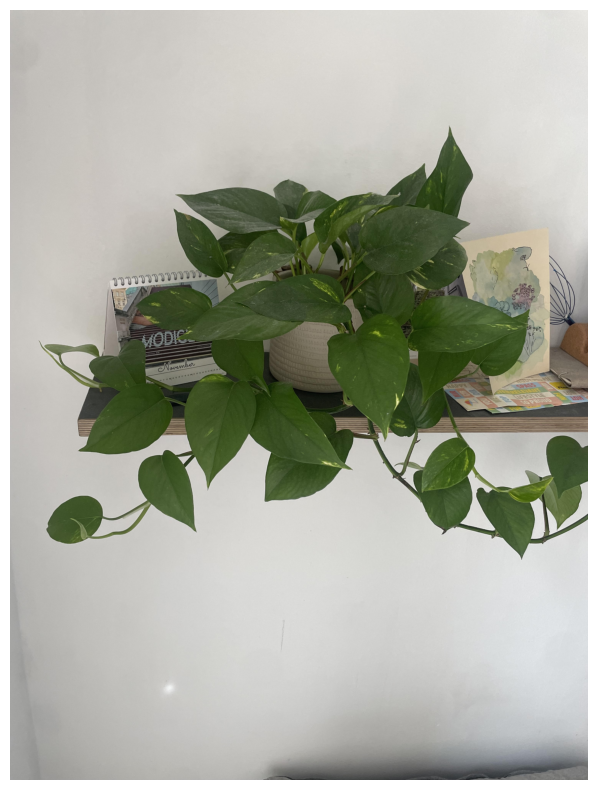

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

In [7]:
masks = mask_generator.generate(image)

In [14]:
print(len(masks))
print(masks[0].keys())
print(masks[0]["segmentation"])
print(masks[0]["segmentation"].shape, image.shape)

166
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(4032, 3024) (4032, 3024, 3)


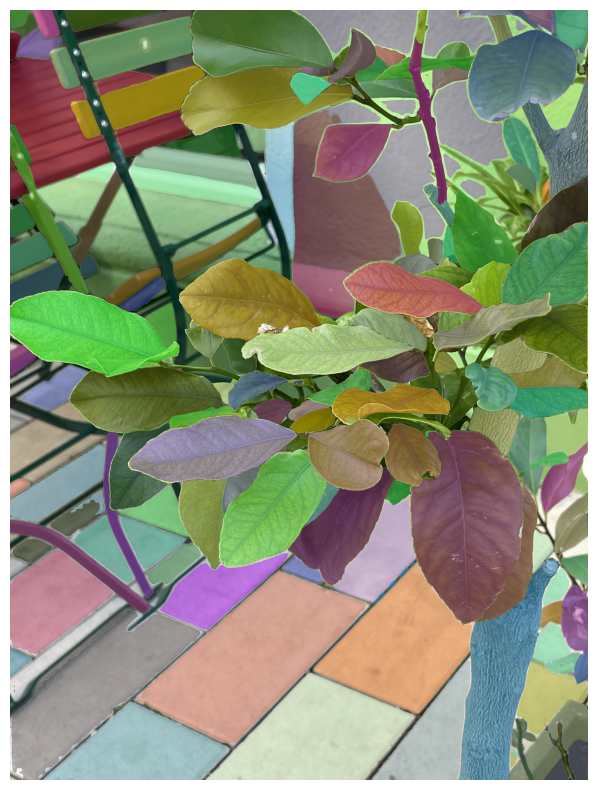

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

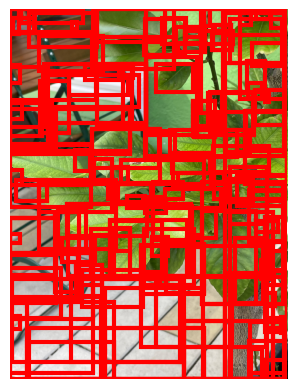

In [16]:
fig, ax = plt.subplots()
ax.imshow(image)
show_boxes(ax, [mask["bbox"] for mask in masks])
plt.axis('off')
plt.show() 

In [8]:
def get_patches(masks, image, apply_mask=False, padding=0):
    result = []
    
    for mask in masks:
        if apply_mask:
            image_tmp = image * (mask["segmentation"][:, :, np.newaxis])
        else:
            image_tmp = image
        
        bbox = mask["bbox"]
        x0 = bbox[1]-padding
        if x0 < 0:
            x0 = 0
        x1 = bbox[1]+bbox[3]+padding
        if x1 >= image.shape[0]:
            x1 = image.shape[0] - 1
        y0 = bbox[0]-padding
        if y0 < 0:
            y0 = 0
        y1 = bbox[0]+bbox[2]+padding
        if y1 >= image.shape[1]:
            y1 = image.shape[1] - 1
        
        patch = image_tmp[x0:x1, y0:y1]
        
        if 0 in patch.shape:
            continue
        result.append(patch)
    
    return result

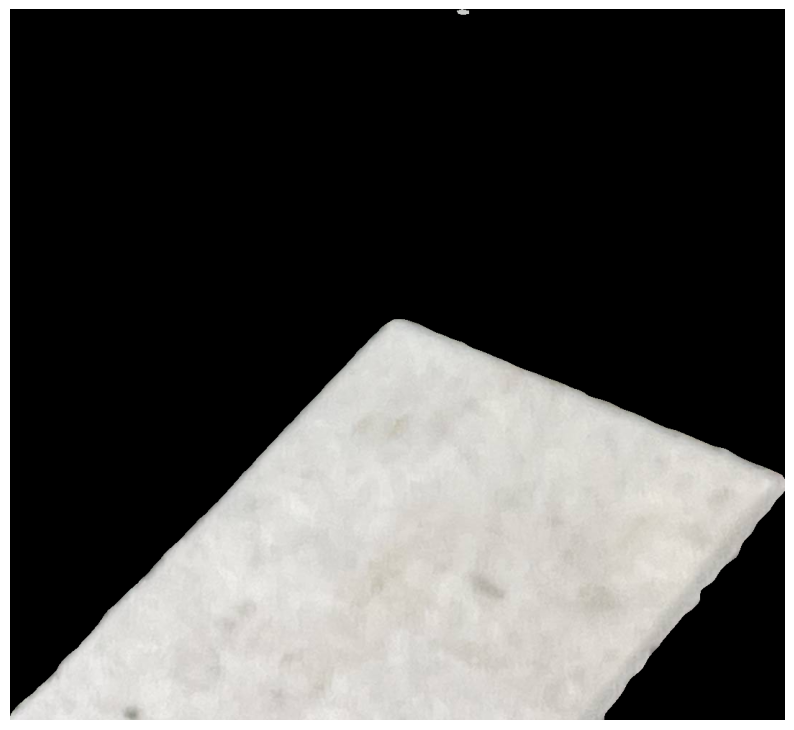

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(get_patches(masks, image, True)[25])
plt.axis('off')
plt.show()

In [19]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class SingleClassDataset(Dataset):
    def __init__(self, folder_path, transform=None, apply_mask=False, crop_to_mask=False, split=1):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(os.path.join(folder_path, "images")) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.apply_mask = apply_mask
        if apply_mask:
            self.mask_files = [f for f in os.listdir(os.path.join(folder_path, "leaf_instances")) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if split < 1:
            self.image_files = self.image_files[:int(len(self.image_files) * split)]
            self.mask_files = self.mask_files[:int(len(self.mask_files) * split)]
        self.crop_to_mask = crop_to_mask

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, "images", self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.apply_mask:
            mask_name = os.path.join(self.folder_path, "leaf_instances", self.mask_files[idx])
            mask = np.asarray(Image.open(mask_name).convert('L'))
            image = np.where(np.dstack([mask] * 3), image, 0)

            if self.crop_to_mask:
                binary_mask = np.any(image != [0, 0, 0], axis=-1)

                # Find the coordinates of the non-black pixels
                non_black_pixels = np.argwhere(binary_mask)

                # Find the bounding box of the non-black pixels
                top_left = np.min(non_black_pixels, axis=0)
                bottom_right = np.max(non_black_pixels, axis=0)
                
                image = image[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
                
            image = Image.fromarray(image)
        
        
        if self.transform:
            image = self.transform(image)
        
        # Since it's a single class, we can use a constant label (e.g., 0)
        label = 0
        
        return image, label

# Usage example:
folder_path = '_data/urban_street0_25'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SingleClassDataset(folder_path, transform=transform)

# Create a DataLoader
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [20]:
# Check if GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# YOLO detection 

In [41]:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('foduucom/plant-leaf-detection-and-classification')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

# perform inference
results = model.predict(os.path.realpath(os.path.join("_data", "combined", "test", image_file)))

# observe results
print(results[0].boxes)


image 1/1 /home/stefan.steinheber/bachelor/processing/leaf_segmentation/_data/combined/test/test3.jpg: 640x480 5 Blueberrys, 2 gauavas, 1 apple, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([22., 14., 14., 14., 22., 14., 28., 14.], device='cuda:0')
conf: tensor([0.6934, 0.5878, 0.5857, 0.5853, 0.5585, 0.4639, 0.2858, 0.2625], device='cuda:0')
data: tensor([[1.4180e+03, 2.1964e+03, 2.0904e+03, 3.2700e+03, 6.9341e-01, 2.2000e+01],
        [1.7065e+02, 1.2007e+03, 1.1361e+03, 1.7391e+03, 5.8779e-01, 1.4000e+01],
        [2.0058e+03, 3.3516e+01, 3.0240e+03, 4.8999e+02, 5.8566e-01, 1.4000e+01],
        [9.0139e+02, 7.6179e+02, 1.4239e+03, 1.1691e+03, 5.8530e-01, 1.4000e+01],
        [8.6794e+02, 2.4297e+03, 1.3416e+03, 2.9094e+03, 5.5847e-01, 2.2000e+01],
        [1.7341e+03, 4.2468e+02, 2.4014e+03, 1.1854e+03, 4.6386e-01, 1.4000e+01],
        [1.8935e+03, 1.1829e+

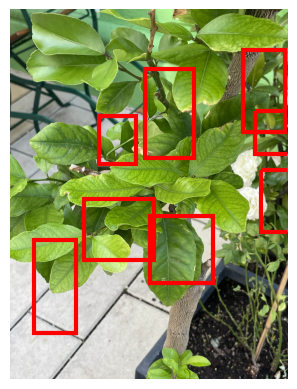

In [42]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(image)
results = results[0].cpu()
for i in range(len(results)):
    rect = patches.Rectangle((results.boxes.xywh[i, 1], results.boxes.xywh[i, 0]),
                             results.boxes.xywh[i, 3], 
                             results.boxes.xywh[i, 2],
                             edgecolor='r', facecolor='none', linewidth=3)
    ax.add_patch(rect)
plt.axis('off')
plt.show() 

# SAM + YOLO detection

In [ ]:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('foduucom/plant-leaf-detection-and-classification')

# set model parameters
model.overrides['conf'] = 0.8  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

patches = get_patches(masks, image, apply_mask=True)
results = []

for patch in patches:
    # perform inference
    result = model.predict(patch)
    results.append(result[0])

In [47]:
print(len([result for result in results if len(result.boxes) > 0]))

134


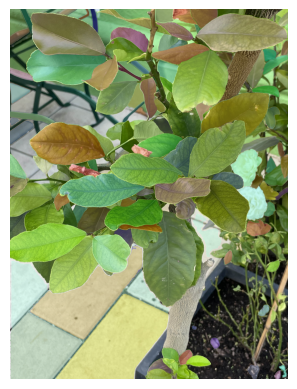

In [48]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
ax.imshow(image)


leaf_masks = [mask for mask, result in zip(masks, results) if len(result.boxes) > 0]

show_anns(leaf_masks)
plt.axis('off')
plt.show() 

# ResNet classification

In [92]:
import os
from PIL import Image
import numpy as np
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights

In [93]:
RESNET_OUT_DIR = "out/leaf_classifier/resnet_masked"
os.makedirs(RESNET_OUT_DIR, exist_ok=True)

In [94]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [95]:
class BinaryResnetClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(BinaryResnetClassifier, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = resnet50(ResNet50_Weights.IMAGENET1K_V1)  # You can choose any ResNet variant
        # Modify the last fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        nn.init.xavier_normal_(self.resnet.fc.weight)
        
    def forward(self, x):
        # Pass the input through the ResNet
        x = self.resnet(x)
        # Apply the sigmoid activation function
#        x = torch.sigmoid(x)  # Output will be between 0 and 1
        return x

In [5]:
from torchsummary import summary
#summary(resnet, (3, 256, 256))

In [96]:
import torchvision.transforms.v2 as transforms

tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomAffine(180, shear=45),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

In [7]:
def alpha_composite_with_color(image, color=(255, 255, 255)):
    """Alpha composite an RGBA image with a single color image of the
    specified color and the same size as the original image.

    Keyword Arguments:
    image -- PIL RGBA Image object
    color -- Tuple r, g, b (default 255, 255, 255)

    """
    back = Image.new('RGBA', size=image.size, color=color + (255,))
    return Image.alpha_composite(image, back)

In [8]:
def crop_to_nonblack(image, padding=0):
    """
    Crops an image to the outermost non-black pixels with optional padding.

    :param image: PIL.Image object to be cropped
    :param padding: Optional padding to add around the cropped area (default: 0)
    :return: Cropped PIL.Image object
    """
    # Convert image to grayscale to simplify black pixel detection
    grayscale = image.convert("L")
    
    # Create a binary mask where non-black pixels are white (255)
    binary_mask = grayscale.point(lambda x: 255 if x > 0 else 0, '1')

    # Use getbbox to find the bounding box of non-black areas
    bbox = binary_mask.getbbox()

    if not bbox:
        raise ValueError("The image appears to be completely black.")

    # Expand the bounding box by the specified padding, ensuring it stays within image bounds
    left, upper, right, lower = bbox
    left = max(0, left - padding)
    upper = max(0, upper - padding)
    right = min(image.width, right + padding)
    lower = min(image.height, lower + padding)

    # Crop the image using the expanded bounding box
    cropped_image = image.crop((left, upper, right, lower))

    return cropped_image

In [9]:
def load_img(path: str):
    with open(path, "rb") as f:
        img = Image.open(f).convert('RGB')
        return crop_to_nonblack(img, padding=30)

In [10]:
class0amount = len(os.listdir("_data/bi_class/places_segmented/leaves"))
class1amount = len(os.listdir("_data/bi_class/places_segmented/non_leaf"))
pos_weight = class0amount / class1amount
print(class0amount, class1amount, pos_weight)

9764 15918 0.6133936424173891


In [11]:
dataset = ImageFolder("_data/bi_class/places_segmented", transform=tf, loader=load_img)

n = len(dataset)  # total number of examples
n_test = int(0.1 * n)  # take ~10% for test
indices = list(range(n))
random.shuffle(indices)
val_indices = indices[:n_test]
train_indices = indices[n_test:]
val_set = torch.utils.data.Subset(dataset, val_indices)  # take first 10%
train_set = torch.utils.data.Subset(dataset, train_indices)  # take the rest   

train_dataloader = DataLoader(train_set, 
                        batch_size=16, 
                        shuffle=True, 
                        num_workers=2, 
                        drop_last=True, 
                        pin_memory=True,
                        persistent_workers=True,
                        prefetch_factor=16)
val_dataloader = DataLoader(val_set, 
                        batch_size=16, 
                        shuffle=True, 
                        num_workers=2, 
                        drop_last=True, 
                        pin_memory=True,
                        persistent_workers=True,
                        prefetch_factor=16)

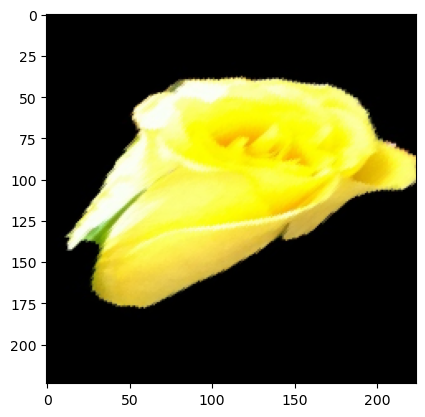

1


In [12]:
import matplotlib.pyplot as plt
batch = next(iter(val_dataloader))
plt.imshow(batch[0][1].permute((1,2,0)))
plt.show()
print(batch[1][1].item())

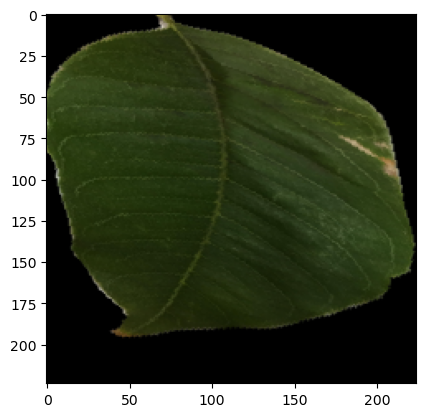

0


In [13]:
import matplotlib.pyplot as plt
batch = next(iter(train_dataloader))
plt.imshow(batch[0][1].permute((1,2,0)))
plt.show()
print(batch[1][1].item())

In [14]:
resnet = BinaryResnetClassifier()
resnet = resnet.to(device)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [15]:
num_epochs = 10
start = 0

In [37]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([pos_weight]).to(device))
val_criterion = nn.BCELoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-2)
#T_0 = 10
#T_mult = 2
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)

In [38]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs*len(train_dataloader), eta_min=1e-6)

In [39]:
import pandas as pd
df_training = pd.DataFrame(columns=["loss", "accuracy", "precision", "recall", "f1_score", "val_loss"])

In [ ]:
import one_class_detection
import itertools
from tqdm import tqdm
print("Starting Training")

scaler = torch.amp.GradScaler()

best_loss = 42342
for epoch in range(start, num_epochs):
    resnet.train()
    data_iter = iter(train_dataloader)

    next_batch = next(data_iter) # start loading the first batch
    next_batch = [ _.cuda(non_blocking=True) for _ in next_batch ]  # with pin_memory=True and non_blocking=True, this will copy data to GPU non blockingly

    p_bar = tqdm(range(len(train_dataloader)), desc=f"Epoch {epoch+1}")
    
    epoch_loss = 0
    
    for i in p_bar:
        optimizer.zero_grad()
        batch = next_batch 
        if i + 2 != len(train_dataloader): 
            # start copying data of next batch
            next_batch = next(data_iter)
            next_batch = [ _.cuda(non_blocking=True) for _ in next_batch]

        inputs, labels = batch
        #inputs = inputs.to(device)
        #labels = labels.to(device)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            pred = resnet(inputs)
            label = labels.unsqueeze(1).to(dtype=torch.float32)
            loss = criterion(pred, label)

        epoch_loss += loss.item()
        p_bar.set_description(f"Epoch {epoch+1} - Loss: {epoch_loss / (i+1):.6f}, LR: {scheduler.get_last_lr()[0]:.5f}")
        
        
        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()
        # for use with CosineAnnealingWarmRestarts
        #scheduler.step(epoch + i / len(train_dataloader))
        scheduler.step()


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_dataloader):.6f}, LR: {scheduler.get_last_lr()}')
    torch.save(resnet, f"{RESNET_OUT_DIR}/resnet_latest.pth")
    
    resnet.eval()
    y_true = np.array([])
    y_pred = np.array([])
    y_pred_raw = np.array([])
    with torch.no_grad():
        for batch_input, y in tqdm(val_dataloader):
            batch_input = batch_input.to(device)
            output = resnet(batch_input)
            result = (torch.sigmoid(output) >= .5).float()
            y_true = np.append(y_true, y.cpu().numpy())
            y_pred = np.append(y_pred, result.cpu().numpy())
            y_pred_raw = np.append(y_pred_raw, output.cpu().numpy())
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_pred_raw = y_pred_raw.flatten()

    test_results = one_class_detection.calculate_metrics(y_true, y_pred)
    val_loss = criterion(torch.tensor(y_pred_raw).to(device), torch.tensor(y_true).to(device)).cpu().numpy()
    
    # for use of ReduceLROnPlateau
    #scheduler.step(val_loss)
    
    test_results['val_loss'] = val_loss
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(resnet, f"{RESNET_OUT_DIR}/resnet_best.pth")
        print("Saved new best model")
    
    print(test_results)
    
    def predict_resnet(batch_input):
        batch_input = batch_input.to(device)
        output = resnet(batch_input)
        result = (output >= .5).float()
        return result.cpu()

    #test_results = one_class_detection.test_loop(predict_resnet)
    
    df_training.loc[len(df_training.index)] = [epoch_loss / len(train_dataloader)] + list(test_results.values())
    df_training.to_csv(f"{RESNET_OUT_DIR}/training_metrics.csv")

Starting Training


Epoch 6 - Loss: 0.037142, LR: 0.00821:  56%|█████▌    | 811/1444 [06:09<05:28,  1.93it/s]

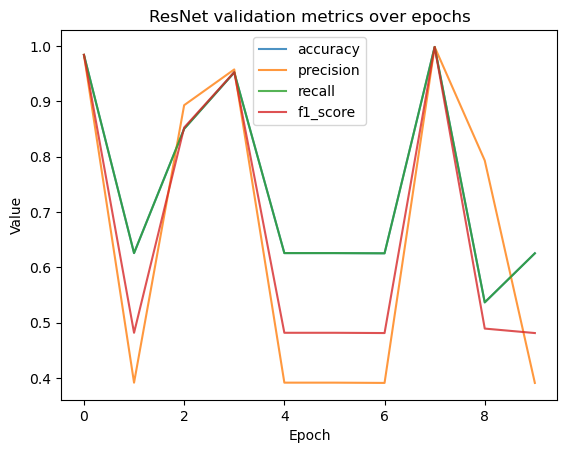

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
df_training = pd.read_csv(f"{RESNET_OUT_DIR}_cos/training_metrics.csv")
df_training = df_training.drop(df_training.columns[0], axis="columns")

for col in df_training.columns:
    if "loss" in col:
        continue
    plt.plot(df_training.index, df_training[col], label=col, alpha=.8)
    
plt.legend()
plt.title("ResNet validation metrics over epochs")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.show()

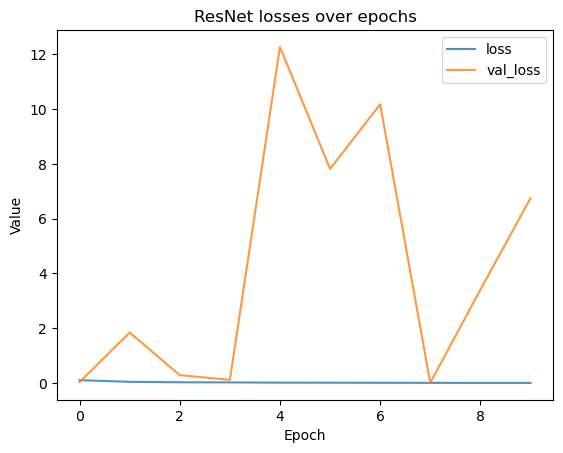

In [101]:
import matplotlib.pyplot as plt
df_training = pd.read_csv(f"{RESNET_OUT_DIR}_cos/training_metrics.csv")
df_training = df_training.drop(df_training.columns[0], axis="columns")

for col in df_training.columns:
    if "loss" not in col:
        continue
    plt.plot(df_training.index, df_training[col], label=col, alpha=.8)
    
plt.legend()
plt.title("ResNet losses over epochs")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.show()

In [97]:
import one_class_detection
import importlib
importlib.reload(one_class_detection)

resnet = torch.load(f"{RESNET_OUT_DIR}_cos/resnet_best.pth")
resnet = resnet.to(device)

def predict_resnet(batch_input):
    batch_input = batch_input.to(device)
    output = resnet(batch_input)
    result = (output >= .5).float()
    return result.cpu()

one_class_detection.test_loop(predict_resnet)

/tmp/ipykernel_3668440/2230205030.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet = torch.load(f"{RESNET_OUT_DIR}_cos/resnet_best.pth")
/home/stefan.steinheber/.c

{'accuracy': 0.4836309523809524,
 'precision': np.float64(0.23389889810090703),
 'recall': np.float64(0.4836309523809524),
 'f1_score': np.float64(0.31530603715909633)}

In [102]:
patches = get_patches(masks, image, apply_mask=True, padding=35)

In [103]:
tf_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
])

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(216, 188, 3)


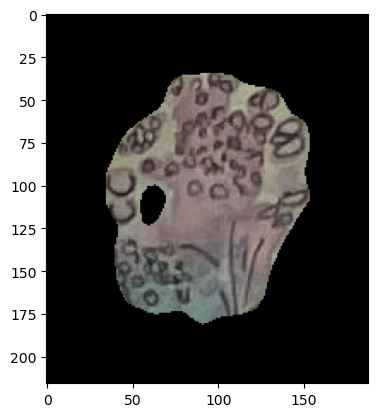

-9.930511474609375 4.8664529458619654e-05


In [175]:
INDEX = random.sample(list(range(len(patches))), k=1)[0]
patch = patches[INDEX]
#patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
print(patches[INDEX].shape)
plt.imshow(patch)
plt.show()
result = resnet(tf_test(patch).to(device).unsqueeze(0)).item()
print(result, torch.sigmoid(torch.tensor(result)).item())

In [58]:
from PIL import Image
results = []
with torch.no_grad():
    for patch in patches:
        input = tf(Image.fromarray(patch)).unsqueeze(0).to(device)
        result = torch.sigmoid(resnet(input)).cpu().item()
        
        results.append(result)

In [59]:
print(results)
print(np.min(results), np.max(results))

[0.004620015621185303, 0.022899674251675606, 0.12162532657384872, 0.4775432050228119, 0.15344996750354767, 0.014606325887143612, 0.013772139325737953, 0.00835163053125143, 0.04876173287630081, 0.03549957647919655, 0.0031797708943486214, 0.025390377268195152, 0.007675631437450647, 0.006295105442404747, 0.2270183563232422, 0.0013700624695047736, 0.05938396975398064, 0.007000562734901905, 0.004788372199982405, 0.06475692242383957, 0.004090883769094944, 0.5396196246147156, 0.0427037812769413, 0.06755699217319489, 0.08835947513580322, 0.06748960167169571, 0.20867620408535004, 0.08047949522733688, 0.003069628030061722, 0.04244617372751236, 0.025428814813494682, 0.027101337909698486, 0.031582921743392944, 0.007114584092050791, 0.013400292955338955, 0.29348865151405334, 0.006760475225746632, 0.04355120658874512, 0.17686285078525543, 0.01909237541258335, 0.21959573030471802, 0.4471075236797333, 0.07380113750696182, 0.3588520288467407, 0.25554588437080383, 0.025542156770825386, 0.222844958305358

Detected leaf masks: 85


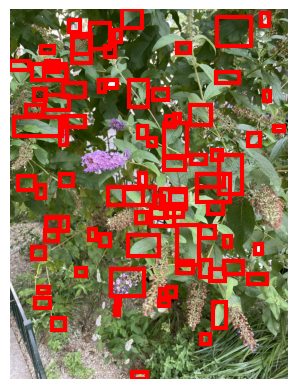

In [64]:
import matplotlib.patches as patches

PROBABILITY_THRESHOLD = .1
masks_filtered = [mask for mask, result in zip(masks,results) if result > PROBABILITY_THRESHOLD]
print("Detected leaf masks:", len(masks_filtered))
fig, ax = plt.subplots()
ax.imshow(image)
show_boxes(ax, [mask["bbox"] for mask in masks_filtered])
plt.axis('off')
plt.show() 

# Inception

In [10]:
import os
import numpy as np
import torch
import torchvision
import random
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [11]:
INCEPTION_OUT_DIR = "out/leaf_classifier/inception"
os.makedirs(INCEPTION_OUT_DIR, exist_ok=True)

In [12]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
class BinaryInceptionClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(BinaryInceptionClassifier, self).__init__()
        # Load a pre-trained ResNet model
        self.inception = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True) # You can choose any ResNet variant
        # Modify the last fully connected layer
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)
        nn.init.xavier_normal_(self.inception.fc.weight)
        
    def forward(self, x):
        # Pass the input through the ResNet
        x = self.inception(x)
        # Apply the sigmoid activation function
#        x = torch.sigmoid(x)  # Output will be between 0 and 1
        return x

In [5]:
def crop_to_nonblack(image, padding=0):
    """
    Crops an image to the outermost non-black pixels with optional padding.

    :param image: PIL.Image object to be cropped
    :param padding: Optional padding to add around the cropped area (default: 0)
    :return: Cropped PIL.Image object
    """
    # Convert image to grayscale to simplify black pixel detection
    grayscale = image.convert("L")
    
    # Create a binary mask where non-black pixels are white (255)
    binary_mask = grayscale.point(lambda x: 255 if x > 0 else 0, '1')

    # Use getbbox to find the bounding box of non-black areas
    bbox = binary_mask.getbbox()

    if not bbox:
        raise ValueError("The image appears to be completely black.")

    # Expand the bounding box by the specified padding, ensuring it stays within image bounds
    left, upper, right, lower = bbox
    left = max(0, left - padding)
    upper = max(0, upper - padding)
    right = min(image.width, right + padding)
    lower = min(image.height, lower + padding)

    # Crop the image using the expanded bounding box
    cropped_image = image.crop((left, upper, right, lower))

    return cropped_image

In [6]:
def load_img(path: str):
    with open(path, "rb") as f:
        img = Image.open(f).convert('RGB')
        return crop_to_nonblack(img, padding=30)

In [7]:
class0amount = len(os.listdir("_data/bi_class/places_segmented/leaves"))
class1amount = len(os.listdir("_data/bi_class/places_segmented/non_leaf"))
pos_weight = class0amount / class1amount
print(class0amount, class1amount, pos_weight)

9764 15918 0.6133936424173891


In [8]:
import torchvision.transforms.v2 as transforms

tf = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomAffine(180, shear=45),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
dataset = ImageFolder("_data/bi_class/places_segmented", transform=tf, loader=load_img)

dataloader = DataLoader(dataset, 
                        batch_size=8, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True, 
                        pin_memory=True)
n = len(dataset)  # total number of examples
n_test = int(0.1 * n)  # take ~10% for test
indices = list(range(n))
random.shuffle(indices)
val_indices = indices[:n_test]
train_indices = indices[n_test:]
val_set = torch.utils.data.Subset(dataset, val_indices)  # take first 10%
train_set = torch.utils.data.Subset(dataset, train_indices)  # take the rest   

train_dataloader = DataLoader(train_set, 
                        batch_size=16, 
                        shuffle=True, 
                        num_workers=2, 
                        drop_last=True, 
                        pin_memory=True,
                        persistent_workers=True,
                        prefetch_factor=8)
val_dataloader = DataLoader(val_set, 
                        batch_size=16, 
                        shuffle=True, 
                        num_workers=2, 
                        drop_last=True, 
                        pin_memory=True,
                        persistent_workers=True,
                        prefetch_factor=8)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
num_epochs = 10
start = 0

In [11]:
inception = BinaryInceptionClassifier()
inception = inception.to(device)

Using cache found in /home/stefan.steinheber/.cache/torch/hub/pytorch_vision_v0.10.0
/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([pos_weight]).to(device))
val_criterion = nn.BCELoss()
optimizer = optim.Adam(inception.parameters(), lr=1e-2)
#T_0 = 10
#T_mult = 2
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)

In [13]:
from fastai.callback.schedule import combined_cos
total_steps = len(train_dataloader) * num_epochs
ccos = combined_cos(0.25, 0.5, 1, 1e-5)
schedule_lr = lambda step: ccos(step / total_steps)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[schedule_lr])

In [14]:
import pandas as pd
df_training = pd.DataFrame(columns=["loss", "accuracy", "precision", "recall", "f1_score", "val_loss"])

In [15]:
import one_class_detection
import itertools
from tqdm import tqdm
print("Starting Training")

scaler = torch.amp.GradScaler()

best_loss = 42342
for epoch in range(start, num_epochs):
    inception.train()
    data_iter = iter(train_dataloader)

    next_batch = next(data_iter) # start loading the first batch
    next_batch = [ _.cuda(non_blocking=True) for _ in next_batch ]  # with pin_memory=True and non_blocking=True, this will copy data to GPU non blockingly

    p_bar = tqdm(range(len(train_dataloader)), desc=f"Epoch {epoch+1}")
    
    epoch_loss = 0
    
    for i in p_bar:
        optimizer.zero_grad()
        batch = next_batch 
        if i + 2 != len(train_dataloader): 
            # start copying data of next batch
            next_batch = next(data_iter)
            next_batch = [ _.cuda(non_blocking=True) for _ in next_batch]

        inputs, labels = batch
        #inputs = inputs.to(device)
        #labels = labels.to(device)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            pred = inception(inputs).logits
            label = labels.unsqueeze(1).to(dtype=torch.float32)
            loss = criterion(pred, label)

        epoch_loss += loss.item()
        p_bar.set_description(f"Epoch {epoch+1} - Loss: {epoch_loss / (i+1):.6f}, LR: {scheduler.get_last_lr()[0]:.5f}")
        
        
        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()
        # for use with CosineAnnealingWarmRestarts
        #scheduler.step(epoch + i / len(train_dataloader))
        #loss.backward()
        #optimizer.step()
        scheduler.step()


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_dataloader):.6f}, LR: {scheduler.get_last_lr()}')
    torch.save(inception, f"{INCEPTION_OUT_DIR}/inception_latest.pth")
    
    inception.eval()
    y_true = np.array([])
    y_pred = np.array([])
    y_pred_raw = np.array([])
    with torch.no_grad():
        for batch_input, y in tqdm(val_dataloader):
            batch_input = batch_input.to(device)
            output = inception(batch_input)
            result = (torch.sigmoid(output) >= .5).float()
            y_true = np.append(y_true, y.cpu().numpy())
            y_pred = np.append(y_pred, result.cpu().numpy())
            y_pred_raw = np.append(y_pred_raw, output.cpu().numpy())
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_pred_raw = y_pred_raw.flatten()

    test_results = one_class_detection.calculate_metrics(y_true, y_pred)
    val_loss = criterion(torch.tensor(y_pred_raw).to(device), torch.tensor(y_true).to(device)).cpu().numpy()
    
    # for use of ReduceLROnPlateau
    #scheduler.step(val_loss)
    
    test_results['val_loss'] = val_loss
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(inception, f"{INCEPTION_OUT_DIR}/inception_best.pth")
        print("Saved new best model")
    
    print(test_results)
    
    def predict_inception(batch_input):
        batch_input = batch_input.to(device)
        output = inception(batch_input)
        result = (output >= .5).float()
        return result.cpu()

    #test_results = one_class_detection.test_loop(predict_inception)
    
    df_training.loc[len(df_training.index)] = [epoch_loss / len(train_dataloader)] + list(test_results.values())
    df_training.to_csv(f"{INCEPTION_OUT_DIR}/training_metrics.csv")

Starting Training


Epoch 1 - Loss: 0.227161, LR: 0.00673: 100%|██████████| 1444/1444 [14:53<00:00,  1.62it/s]


Epoch [1/10], Loss: 0.227161, LR: [0.006727457558584801]


  1%|          | 1/160 [00:01<03:20,  1.26s/it]

tensor([[ -2.6495],
        [ -2.6577],
        [ 12.2992],
        [ -2.6583],
        [ -2.6556],
        [ -2.6866],
        [147.1153],
        [ 23.7371],
        [ -2.6761],
        [ 13.8562],
        [  1.1292],
        [ -2.8454],
        [  2.5531],
        [ -0.8069],
        [  3.5753],
        [ -2.6581]], device='cuda:0')
tensor([[ 7.8705],
        [ 1.9157],
        [13.6916],
        [-2.7074],
        [-2.6490],
        [-2.7416],
        [-2.6524],
        [-2.6504],
        [ 8.7677],
        [-2.6447],
        [-2.6525],
        [-2.6428],
        [ 4.7773],
        [-2.6500],
        [-2.6561],
        [-2.6523]], device='cuda:0')


  2%|▏         | 3/160 [00:02<01:47,  1.46it/s]

tensor([[-3.7732e+00],
        [-2.7541e+00],
        [-2.6518e+00],
        [-2.7505e+00],
        [-2.1411e-03],
        [ 1.7990e+01],
        [ 3.3740e+00],
        [-2.6402e+00],
        [-2.6504e+00],
        [-2.6496e+00],
        [ 1.1820e+01],
        [-2.6684e+00],
        [ 1.4432e+01],
        [-2.6668e+00],
        [-2.6568e+00],
        [ 3.4456e+00]], device='cuda:0')
tensor([[-2.6432],
        [-2.4420],
        [-1.7558],
        [-2.6913],
        [-2.6362],
        [10.9527],
        [10.5108],
        [-2.6882],
        [10.2861],
        [15.1023],
        [12.2601],
        [10.7827],
        [-2.6470],
        [-2.6612],
        [-2.7102],
        [-2.6409]], device='cuda:0')


  3%|▎         | 5/160 [00:03<01:35,  1.62it/s]

tensor([[-2.6468],
        [11.6604],
        [-2.6375],
        [ 8.4039],
        [ 4.8581],
        [-2.6735],
        [-2.6526],
        [-2.6506],
        [-2.6608],
        [-2.6499],
        [-2.1645],
        [-2.3617],
        [-2.6498],
        [-2.6490],
        [-2.7480],
        [-2.6520]], device='cuda:0')
tensor([[-2.6500],
        [13.2604],
        [ 4.9364],
        [-2.6502],
        [-0.8494],
        [-2.6451],
        [ 8.1212],
        [30.1062],
        [-2.2144],
        [ 0.0804],
        [-2.6606],
        [ 1.7000],
        [ 3.6287],
        [-2.6601],
        [-2.6476],
        [ 1.1784]], device='cuda:0')


  4%|▍         | 7/160 [00:03<01:14,  2.05it/s]

tensor([[-2.8342e+00],
        [ 4.6575e+00],
        [ 1.1422e+01],
        [ 1.9790e-02],
        [-2.6580e+00],
        [ 1.0080e+01],
        [-2.6498e+00],
        [-2.6696e+00],
        [-2.6494e+00],
        [-2.6481e+00],
        [-2.6261e+00],
        [ 1.1273e+01],
        [-2.6860e+00],
        [ 1.2058e+02],
        [ 6.3085e+00],
        [ 1.5224e-01]], device='cuda:0')


  5%|▌         | 8/160 [00:04<01:11,  2.12it/s]

tensor([[-2.6674],
        [-2.6412],
        [ 6.0417],
        [-2.7401],
        [-1.4774],
        [-2.6543],
        [ 2.8954],
        [ 1.3055],
        [-2.8653],
        [ 3.4891],
        [-2.6512],
        [-2.1040],
        [-2.6535],
        [-2.6525],
        [-2.8454],
        [44.4319]], device='cuda:0')


  6%|▌         | 9/160 [00:05<01:24,  1.79it/s]

tensor([[-2.6563],
        [ 0.1536],
        [-2.6831],
        [-2.6511],
        [-2.6847],
        [-2.6427],
        [-1.4220],
        [-2.8268],
        [ 8.8225],
        [-2.6500],
        [-2.6611],
        [-2.6542],
        [-2.6555],
        [-2.6400],
        [ 5.0862],
        [ 2.1977]], device='cuda:0')


  6%|▋         | 10/160 [00:06<01:36,  1.55it/s]

tensor([[-2.9594],
        [-2.6485],
        [-2.6542],
        [-2.6492],
        [-2.6398],
        [ 4.2579],
        [-2.6732],
        [-2.6563],
        [ 8.8811],
        [ 8.1671],
        [ 6.9751],
        [-2.6541],
        [-2.6421],
        [ 4.6556],
        [-2.6604],
        [ 2.6668]], device='cuda:0')


  7%|▋         | 11/160 [00:06<01:22,  1.81it/s]

tensor([[12.6424],
        [ 0.5687],
        [-2.6584],
        [-2.6461],
        [-2.6765],
        [ 4.4994],
        [-2.6546],
        [10.6397],
        [30.8434],
        [-2.7139],
        [-2.6532],
        [-2.6718],
        [ 1.9313],
        [11.5582],
        [-2.6525],
        [-2.6513]], device='cuda:0')


  8%|▊         | 12/160 [00:07<01:36,  1.54it/s]

tensor([[-2.2644],
        [-2.6550],
        [-2.6496],
        [-2.6468],
        [65.8814],
        [ 5.5535],
        [-2.6457],
        [-2.9476],
        [-2.6494],
        [-2.1343],
        [ 9.9914],
        [-2.3179],
        [-2.6625],
        [-2.6725],
        [-2.6966],
        [-2.6491]], device='cuda:0')
tensor([[-2.7427],
        [ 8.4220],
        [12.5965],
        [38.0095],
        [-2.6524],
        [ 2.6043],
        [-2.6583],
        [-2.6460],
        [ 8.1071],
        [15.1837],
        [-2.6603],
        [14.4906],
        [-2.6650],
        [ 1.6676],
        [-2.6536],
        [-2.6457]], device='cuda:0')


  9%|▉         | 14/160 [00:08<01:20,  1.81it/s]

tensor([[ -2.6578],
        [ -2.6514],
        [ -2.6497],
        [ -1.8095],
        [ -2.6526],
        [177.4424],
        [  8.7105],
        [ -2.6453],
        [ -2.6709],
        [  1.7446],
        [ -2.6525],
        [ -2.6449],
        [ -1.6723],
        [ -2.6735],
        [ 25.2005],
        [  0.6129]], device='cuda:0')


  9%|▉         | 15/160 [00:08<01:10,  2.05it/s]

tensor([[-2.6549],
        [-2.6514],
        [26.6396],
        [-2.6834],
        [-2.6537],
        [-2.6530],
        [-2.6464],
        [-2.6508],
        [ 0.9229],
        [18.8148],
        [-2.6695],
        [-2.6401],
        [ 9.1879],
        [ 5.4602],
        [-2.6446],
        [12.8676]], device='cuda:0')


 10%|█         | 16/160 [00:09<01:34,  1.52it/s]

tensor([[-2.6491],
        [-2.9157],
        [ 2.1677],
        [-2.6690],
        [-2.6537],
        [ 0.2349],
        [-2.6546],
        [-2.6575],
        [-2.6548],
        [-2.7098],
        [ 9.4978],
        [-2.6435],
        [-3.1117],
        [-2.6483],
        [ 2.0254],
        [ 8.3123]], device='cuda:0')


 11%|█         | 17/160 [00:09<01:23,  1.71it/s]

tensor([[-2.6896],
        [-2.6500],
        [-2.6559],
        [-2.6443],
        [-2.7296],
        [-2.6516],
        [-2.6591],
        [ 2.2163],
        [-2.3203],
        [-2.6768],
        [-2.6569],
        [-2.6498],
        [-2.6666],
        [-2.6476],
        [-2.7048],
        [ 4.3840]], device='cuda:0')


 11%|█▏        | 18/160 [00:10<01:19,  1.79it/s]

tensor([[21.6738],
        [-2.6516],
        [ 6.4886],
        [31.3233],
        [23.2740],
        [-2.6482],
        [-2.6642],
        [-2.6538],
        [ 2.3512],
        [-2.6503],
        [-2.7202],
        [-2.6497],
        [ 8.0918],
        [-2.7935],
        [-0.3842],
        [-0.2661]], device='cuda:0')


 12%|█▏        | 19/160 [00:10<01:15,  1.88it/s]

tensor([[-2.6502],
        [-0.5049],
        [-2.6462],
        [-2.8628],
        [ 2.8901],
        [-2.6508],
        [13.4639],
        [-2.6178],
        [-2.9648],
        [-2.6525],
        [76.8309],
        [-2.6529],
        [-2.9560],
        [-2.6425],
        [-2.4470],
        [-2.6496]], device='cuda:0')


 13%|█▎        | 21/160 [00:11<00:59,  2.34it/s]

tensor([[-2.8771],
        [-2.6495],
        [-2.7330],
        [-2.6555],
        [-2.6509],
        [-2.6523],
        [12.2819],
        [-2.6459],
        [-2.6523],
        [16.2218],
        [-2.7423],
        [-2.6522],
        [ 5.3212],
        [-2.6487],
        [-2.6876],
        [-2.6403]], device='cuda:0')
tensor([[-2.6510],
        [-2.4038],
        [ 7.5168],
        [-2.5387],
        [ 3.2627],
        [19.1573],
        [ 0.8592],
        [-1.0902],
        [ 7.6753],
        [-2.6589],
        [-2.6513],
        [-2.6680],
        [ 1.6394],
        [-2.8542],
        [-2.6481],
        [ 2.6485]], device='cuda:0')


 14%|█▍        | 22/160 [00:12<01:04,  2.16it/s]

tensor([[-2.6515],
        [-2.6749],
        [15.6787],
        [ 2.2482],
        [ 3.0743],
        [-2.6536],
        [ 4.2718],
        [-2.6520],
        [ 2.4667],
        [12.5891],
        [-2.6523],
        [-0.2297],
        [-2.7008],
        [-2.6528],
        [ 5.3777],
        [-2.6667]], device='cuda:0')


 14%|█▍        | 23/160 [00:13<01:24,  1.62it/s]

tensor([[-2.6417],
        [23.5923],
        [-2.6901],
        [-2.6480],
        [-2.6496],
        [ 6.7230],
        [-2.6519],
        [13.1446],
        [18.0160],
        [-2.6480],
        [12.2247],
        [-2.6898],
        [-2.6499],
        [-2.6522],
        [22.7025],
        [-2.6567]], device='cuda:0')


 15%|█▌        | 24/160 [00:13<01:09,  1.95it/s]

tensor([[66.5275],
        [-2.6984],
        [-2.6438],
        [-2.6671],
        [-2.9195],
        [-2.6458],
        [ 1.5915],
        [-2.6498],
        [12.5807],
        [-2.6476],
        [16.2848],
        [-2.6493],
        [-2.6837],
        [15.9647],
        [-2.6456],
        [-2.6512]], device='cuda:0')


 16%|█▋        | 26/160 [00:14<01:00,  2.22it/s]

tensor([[ 3.4821],
        [-2.2104],
        [-2.6504],
        [-2.7178],
        [-2.9296],
        [-2.6517],
        [ 7.3600],
        [-2.6506],
        [17.9729],
        [-2.6546],
        [-2.6442],
        [ 3.7426],
        [-2.6499],
        [-3.4147],
        [ 2.4197],
        [-2.6680]], device='cuda:0')
tensor([[ 6.1584],
        [-2.6502],
        [-2.6494],
        [-0.7389],
        [28.9094],
        [ 3.5432],
        [-1.0280],
        [ 0.0314],
        [21.7339],
        [-2.6533],
        [-2.4645],
        [-2.6535],
        [-2.6560],
        [-2.4926],
        [-2.6529],
        [-2.6516]], device='cuda:0')


 17%|█▋        | 27/160 [00:15<01:45,  1.26it/s]

tensor([[-2.6505],
        [-2.6503],
        [-2.6511],
        [-2.7150],
        [-2.6495],
        [ 8.5185],
        [ 4.5822],
        [-2.7000],
        [-2.6558],
        [-2.7277],
        [-2.6692],
        [-2.7071],
        [ 8.2254],
        [-3.1182],
        [-2.6482],
        [13.4796]], device='cuda:0')
tensor([[ -3.3437],
        [ 14.5391],
        [  9.1941],
        [352.1337],
        [ -2.6630],
        [ -0.4202],
        [ -2.6498],
        [  5.4726],
        [ -2.6817],
        [ -2.6508],
        [ -2.6501],
        [ -2.6580],
        [ -2.3250],
        [ -2.6492],
        [ -2.6573],
        [ -2.7082]], device='cuda:0')


 18%|█▊        | 29/160 [00:17<01:34,  1.38it/s]

tensor([[ 6.6377],
        [12.8986],
        [-2.6502],
        [-2.6481],
        [ 9.0750],
        [-2.7119],
        [-2.6492],
        [-2.6767],
        [56.2023],
        [-2.6491],
        [-2.6482],
        [-2.7403],
        [ 7.1986],
        [ 2.9901],
        [-2.7066],
        [-2.6535]], device='cuda:0')
tensor([[ 32.9399],
        [ -2.6517],
        [ -2.6531],
        [ -2.7624],
        [ -2.6542],
        [ -2.6679],
        [ -2.6534],
        [  3.7663],
        [  8.1859],
        [ -2.6691],
        [ -2.6481],
        [ -2.6505],
        [121.9624],
        [ 17.3338],
        [ -1.3033],
        [ -2.7065]], device='cuda:0')


 19%|█▉        | 31/160 [00:18<01:25,  1.51it/s]

tensor([[-2.6548],
        [-2.6538],
        [-2.8749],
        [-2.6551],
        [-2.8961],
        [-2.1793],
        [-2.6499],
        [ 6.2183],
        [-1.9395],
        [ 1.3022],
        [14.0323],
        [-2.6479],
        [10.4963],
        [-2.6573],
        [-2.7245],
        [-0.6536]], device='cuda:0')
tensor([[ 67.6085],
        [ -2.6581],
        [ -2.6490],
        [ -2.6508],
        [ -2.6565],
        [ 19.0733],
        [ -2.6446],
        [ -2.6718],
        [ 15.4044],
        [ -2.6506],
        [ 28.5151],
        [ -2.7936],
        [ 14.0034],
        [160.8785],
        [  0.2301],
        [ -2.6573]], device='cuda:0')


 21%|██        | 33/160 [00:18<01:06,  1.90it/s]

tensor([[ 7.0277],
        [25.6311],
        [ 1.8074],
        [-2.6230],
        [ 0.4593],
        [-0.6470],
        [-2.6503],
        [-2.6941],
        [-2.6459],
        [ 8.5457],
        [-3.0803],
        [-0.3434],
        [ 1.8603],
        [71.1495],
        [-2.7365],
        [-2.5055]], device='cuda:0')


 21%|██▏       | 34/160 [00:19<01:09,  1.82it/s]

tensor([[-2.7437],
        [-2.6491],
        [-2.7709],
        [-1.6439],
        [12.8851],
        [-2.6493],
        [ 3.3447],
        [-2.6536],
        [ 0.5987],
        [13.7054],
        [-2.7245],
        [-2.7108],
        [-2.6446],
        [-2.6513],
        [-2.6547],
        [-2.7177]], device='cuda:0')
tensor([[-2.6617e+00],
        [-1.2728e-02],
        [ 1.2281e+00],
        [ 1.6703e+01],
        [ 7.9035e+00],
        [-2.6529e+00],
        [ 9.4842e+00],
        [-2.6562e+00],
        [-2.6693e+00],
        [ 2.3599e+01],
        [ 8.8256e+01],
        [ 6.7581e+00],
        [-2.9440e+00],
        [-2.6558e+00],
        [ 3.4637e+01],
        [-2.6535e+00]], device='cuda:0')


 22%|██▎       | 36/160 [00:20<00:57,  2.16it/s]

tensor([[ 6.4039],
        [-2.3654],
        [ 3.4028],
        [14.2973],
        [-2.8080],
        [ 7.9557],
        [-2.8490],
        [-2.6478],
        [-2.6498],
        [-2.6372],
        [ 6.8602],
        [12.8669],
        [-2.6502],
        [-2.6989],
        [ 3.7841],
        [-2.6547]], device='cuda:0')


 23%|██▎       | 37/160 [00:20<00:56,  2.17it/s]

tensor([[-2.6777],
        [ 9.5027],
        [64.7875],
        [ 0.2293],
        [ 2.9077],
        [ 8.3429],
        [ 6.0231],
        [10.4917],
        [-2.6501],
        [-2.6304],
        [-2.6747],
        [ 2.4626],
        [-2.6578],
        [-2.6396],
        [10.1418],
        [10.1309]], device='cuda:0')


 24%|██▍       | 38/160 [00:21<01:00,  2.00it/s]

tensor([[-2.6552],
        [-0.2561],
        [-2.6471],
        [-2.6494],
        [ 5.0425],
        [-0.7842],
        [-2.6636],
        [-2.6525],
        [-2.6506],
        [-2.6511],
        [-2.6488],
        [ 3.4326],
        [-2.6466],
        [-2.8412],
        [-2.6836],
        [ 0.8595]], device='cuda:0')


 24%|██▍       | 39/160 [00:21<01:02,  1.93it/s]

tensor([[-2.5493],
        [23.5708],
        [-2.6434],
        [ 3.1149],
        [-2.9407],
        [-2.9155],
        [ 7.6654],
        [-2.6499],
        [-2.6531],
        [-2.6508],
        [-2.6484],
        [ 4.3639],
        [-2.6508],
        [-2.6559],
        [-1.4624],
        [-2.6552]], device='cuda:0')


 25%|██▌       | 40/160 [00:22<00:52,  2.28it/s]

tensor([[ 8.3719],
        [-2.6560],
        [-2.7039],
        [-2.9737],
        [-3.1150],
        [ 5.0145],
        [ 9.5966],
        [ 9.6522],
        [13.9327],
        [-2.5916],
        [-0.0885],
        [-3.2463],
        [14.3990],
        [-2.6531],
        [-2.6549],
        [ 3.4088]], device='cuda:0')


 26%|██▌       | 41/160 [00:22<00:54,  2.20it/s]

tensor([[ 19.6018],
        [ -2.6633],
        [ -2.6491],
        [  7.3909],
        [ 22.0977],
        [ -1.4404],
        [ -2.6884],
        [ -2.6453],
        [ 16.0518],
        [  0.1235],
        [ 10.2045],
        [ -2.6500],
        [ -2.6511],
        [ -2.7387],
        [  3.8289],
        [116.5294]], device='cuda:0')


 26%|██▋       | 42/160 [00:22<00:49,  2.38it/s]

tensor([[18.9229],
        [-2.6533],
        [ 3.3685],
        [ 2.2880],
        [-2.6739],
        [-2.6607],
        [-2.6442],
        [-0.5348],
        [ 5.7142],
        [-2.6556],
        [ 0.8190],
        [-2.6513],
        [ 1.8182],
        [-2.6774],
        [-2.6517],
        [-2.6521]], device='cuda:0')


 27%|██▋       | 43/160 [00:23<01:08,  1.70it/s]

tensor([[-2.6623],
        [-2.6501],
        [-2.6541],
        [-2.5293],
        [-2.6540],
        [-2.6496],
        [10.2712],
        [ 6.9737],
        [-2.6545],
        [-2.6544],
        [11.4803],
        [12.4701],
        [-3.3691],
        [-2.6517],
        [-2.8036],
        [-2.6601]], device='cuda:0')
tensor([[-2.6534],
        [-2.6473],
        [ 2.7225],
        [-2.6500],
        [-2.6487],
        [23.5396],
        [ 8.1527],
        [-2.6523],
        [ 2.1536],
        [ 0.5530],
        [-0.7820],
        [-2.6593],
        [-2.9956],
        [-2.6973],
        [-2.6485],
        [-2.6535]], device='cuda:0')


 28%|██▊       | 45/160 [00:24<00:53,  2.14it/s]

tensor([[-2.6617],
        [-2.6537],
        [-2.6673],
        [12.6455],
        [-1.6638],
        [10.8332],
        [ 3.3126],
        [-2.6522],
        [31.9944],
        [ 5.3487],
        [-2.5447],
        [-2.8500],
        [-2.6557],
        [ 8.9386],
        [-2.8282],
        [-1.5882]], device='cuda:0')


 29%|██▉       | 46/160 [00:25<00:53,  2.11it/s]

tensor([[13.2641],
        [-2.7478],
        [-2.6493],
        [-2.8463],
        [-2.6594],
        [ 0.1908],
        [-2.6547],
        [-2.6505],
        [ 3.8413],
        [-2.6475],
        [-2.6692],
        [ 0.9116],
        [-2.7513],
        [ 3.5655],
        [-2.6467],
        [-2.6497]], device='cuda:0')


 29%|██▉       | 47/160 [00:25<00:50,  2.24it/s]

tensor([[-2.6506],
        [-0.9182],
        [22.6474],
        [-2.6525],
        [20.3890],
        [-2.6350],
        [-2.6956],
        [-2.6480],
        [-0.7833],
        [19.8047],
        [ 3.6840],
        [27.3118],
        [-2.6479],
        [ 3.8926],
        [-2.6508],
        [74.6860]], device='cuda:0')


 31%|███       | 49/160 [00:26<00:44,  2.47it/s]

tensor([[-2.4973],
        [-2.0575],
        [17.6466],
        [-2.6523],
        [12.2266],
        [-2.6540],
        [-2.7498],
        [-2.6480],
        [ 0.4258],
        [-2.6473],
        [-2.6492],
        [-2.6494],
        [-3.6146],
        [-2.6527],
        [ 4.2851],
        [-2.6451]], device='cuda:0')
tensor([[ 12.2961],
        [ -2.6521],
        [ -2.6050],
        [ 14.3457],
        [  1.9046],
        [ 10.6474],
        [417.8143],
        [ -2.6537],
        [ -3.1497],
        [ -2.6534],
        [ -1.5639],
        [ 12.3185],
        [ -2.6532],
        [ -2.6195],
        [ -2.6505],
        [ -2.6421]], device='cuda:0')


 31%|███▏      | 50/160 [00:26<00:44,  2.45it/s]

tensor([[-1.7351],
        [-2.6578],
        [ 1.8706],
        [ 4.4800],
        [ 6.6360],
        [-1.7485],
        [-2.6904],
        [10.4574],
        [-0.5920],
        [-2.6511],
        [ 1.2483],
        [-2.6552],
        [-2.6511],
        [12.2138],
        [-2.6810],
        [ 0.7541]], device='cuda:0')


 32%|███▏      | 51/160 [00:26<00:40,  2.67it/s]

tensor([[-0.1202],
        [ 3.0765],
        [ 7.3917],
        [ 2.1525],
        [ 9.2276],
        [-0.2839],
        [ 8.4552],
        [11.2421],
        [ 4.3899],
        [-2.6525],
        [-2.6536],
        [ 6.1654],
        [-2.6410],
        [-0.3540],
        [-1.6514],
        [-1.8702]], device='cuda:0')


 32%|███▎      | 52/160 [00:27<00:40,  2.67it/s]

tensor([[ 9.8138],
        [-2.6570],
        [-2.6475],
        [-2.6630],
        [-2.6807],
        [-2.6497],
        [ 8.3173],
        [-2.6495],
        [ 6.3010],
        [-2.6511],
        [35.9160],
        [ 3.3288],
        [93.6304],
        [41.6028],
        [ 0.7483],
        [ 1.7740]], device='cuda:0')


 33%|███▎      | 53/160 [00:27<00:43,  2.46it/s]

tensor([[ 1.0071e+00],
        [-2.6535e+00],
        [-3.2775e+00],
        [-2.6486e+00],
        [-2.0090e+00],
        [ 7.4335e+00],
        [-2.6534e+00],
        [-6.8167e-03],
        [-2.6558e+00],
        [-2.6498e+00],
        [-2.6514e+00],
        [-2.8152e+00],
        [ 6.5794e+00],
        [ 1.0971e+01],
        [-2.6524e+00],
        [ 3.1721e+00]], device='cuda:0')


 34%|███▍      | 54/160 [00:28<00:41,  2.53it/s]

tensor([[46.0756],
        [11.9005],
        [10.4401],
        [-2.6528],
        [-1.9246],
        [-2.8207],
        [12.6137],
        [-0.6623],
        [ 3.2648],
        [-2.6515],
        [-1.0524],
        [ 2.7727],
        [-2.6528],
        [ 1.3595],
        [22.0572],
        [10.4506]], device='cuda:0')


 34%|███▍      | 55/160 [00:29<00:56,  1.86it/s]

tensor([[ -2.6456],
        [ -2.1018],
        [ -2.6451],
        [  7.1482],
        [ -2.6448],
        [ -2.6731],
        [  1.8145],
        [ -2.6536],
        [ 23.3541],
        [ 11.6837],
        [250.6198],
        [ 15.7089],
        [ -2.6517],
        [ -2.6675],
        [ -3.0593],
        [ -2.6530]], device='cuda:0')
tensor([[15.8010],
        [ 7.4944],
        [-2.6529],
        [-1.8747],
        [-2.6696],
        [-2.6569],
        [ 4.9301],
        [-2.6513],
        [ 6.6908],
        [-2.6513],
        [ 4.0271],
        [10.7855],
        [22.3994],
        [-2.6530],
        [16.2799],
        [-2.6538]], device='cuda:0')


 36%|███▌      | 57/160 [00:30<00:59,  1.74it/s]

tensor([[-2.6463],
        [-1.0111],
        [-2.6492],
        [-2.6525],
        [-2.6520],
        [-2.6471],
        [-2.6528],
        [51.8702],
        [-0.7049],
        [ 2.6642],
        [ 9.6783],
        [-2.7064],
        [14.7518],
        [-2.9560],
        [-2.6508],
        [11.8530]], device='cuda:0')
tensor([[11.4203],
        [-2.6662],
        [ 2.1240],
        [-2.6528],
        [14.4211],
        [-2.6537],
        [-2.6386],
        [ 5.4781],
        [ 4.8533],
        [12.9361],
        [ 3.1441],
        [-2.6730],
        [-2.7193],
        [10.4551],
        [-2.6625],
        [-2.8167]], device='cuda:0')


 37%|███▋      | 59/160 [00:31<00:54,  1.87it/s]

tensor([[-2.6535],
        [ 3.7926],
        [11.7697],
        [ 5.5329],
        [-2.6538],
        [15.3784],
        [-2.6538],
        [ 3.0806],
        [-2.6511],
        [-2.6642],
        [ 4.0976],
        [-2.6500],
        [-2.6481],
        [-2.7522],
        [-2.7082],
        [-1.7887]], device='cuda:0')
tensor([[ 3.2961],
        [77.0483],
        [ 0.4582],
        [-2.6694],
        [-2.6502],
        [ 5.0982],
        [-2.7394],
        [-2.6482],
        [20.2008],
        [ 3.1479],
        [-2.6540],
        [-2.6498],
        [ 9.3793],
        [ 9.0580],
        [ 0.3962],
        [ 2.8527]], device='cuda:0')


 38%|███▊      | 61/160 [00:32<00:53,  1.86it/s]

tensor([[-2.7103],
        [-1.8519],
        [-2.6500],
        [-2.6511],
        [ 8.1486],
        [ 9.3818],
        [-2.7203],
        [ 9.3281],
        [-2.6817],
        [16.1184],
        [-3.1370],
        [10.0143],
        [76.5982],
        [-2.6560],
        [-2.6464],
        [30.3868]], device='cuda:0')
tensor([[ 1.0832],
        [19.3866],
        [-2.6492],
        [-2.6475],
        [ 0.2677],
        [-2.6523],
        [-2.6624],
        [ 0.1135],
        [ 2.9994],
        [-2.6481],
        [-2.6464],
        [ 0.1137],
        [-2.6608],
        [-2.8018],
        [11.2678],
        [-2.6467]], device='cuda:0')


 39%|███▉      | 63/160 [00:33<00:53,  1.81it/s]

tensor([[ 2.2385],
        [11.0091],
        [-2.6491],
        [-2.6564],
        [ 5.6707],
        [-2.6508],
        [ 9.6446],
        [-2.6949],
        [11.7813],
        [-2.9437],
        [-2.6543],
        [-2.6516],
        [11.3344],
        [-2.6454],
        [-2.6532],
        [-2.6558]], device='cuda:0')
tensor([[ 5.9767],
        [ 0.0971],
        [-2.6737],
        [ 3.3883],
        [-2.6662],
        [-2.6560],
        [-2.6499],
        [-2.6903],
        [-2.5220],
        [-2.6703],
        [-0.9743],
        [-2.6566],
        [-2.6500],
        [-2.6554],
        [-2.6523],
        [-2.7308]], device='cuda:0')


 41%|████      | 65/160 [00:34<00:50,  1.88it/s]

tensor([[-2.3208],
        [-2.6483],
        [-2.6479],
        [27.1510],
        [-2.6468],
        [11.0738],
        [-2.7380],
        [ 9.2368],
        [-2.6514],
        [ 4.0671],
        [-2.6474],
        [-2.6533],
        [-2.6860],
        [-2.6515],
        [-2.6832],
        [13.1366]], device='cuda:0')
tensor([[ 0.8460],
        [-2.6493],
        [-2.6992],
        [ 8.0434],
        [-2.6532],
        [12.3648],
        [-2.8829],
        [10.4581],
        [ 2.8626],
        [-2.6504],
        [-2.6533],
        [-2.6261],
        [31.1910],
        [ 2.0716],
        [-2.6576],
        [-2.6689]], device='cuda:0')


 42%|████▏     | 67/160 [00:35<00:48,  1.91it/s]

tensor([[-2.6528],
        [-2.6494],
        [ 9.1283],
        [-2.6542],
        [-2.6660],
        [ 2.3647],
        [ 7.4507],
        [ 5.8471],
        [ 3.0190],
        [-2.6557],
        [ 4.8577],
        [58.4283],
        [-2.6599],
        [12.2470],
        [-2.6451],
        [ 3.5343]], device='cuda:0')
tensor([[-2.7914],
        [-2.6512],
        [-2.6500],
        [-2.6473],
        [ 1.3199],
        [ 3.8139],
        [-2.6228],
        [ 5.0345],
        [ 3.0656],
        [-2.6457],
        [-2.6698],
        [ 6.9363],
        [-2.6524],
        [-2.6488],
        [-2.8891],
        [-2.6538]], device='cuda:0')


 43%|████▎     | 69/160 [00:36<00:51,  1.78it/s]

tensor([[-2.6521],
        [ 2.5172],
        [ 5.9664],
        [-2.6689],
        [-2.6572],
        [ 3.0417],
        [-2.9678],
        [ 3.1462],
        [16.5913],
        [25.5810],
        [-2.6517],
        [17.3949],
        [-2.9550],
        [-2.6564],
        [-2.6490],
        [-2.6424]], device='cuda:0')
tensor([[-2.6607],
        [-2.6356],
        [16.8353],
        [-1.4346],
        [-2.6264],
        [-2.8733],
        [-2.6653],
        [ 3.1494],
        [-2.6556],
        [-2.6524],
        [-2.8427],
        [ 0.0310],
        [24.1454],
        [ 0.6385],
        [-2.6513],
        [-2.6515]], device='cuda:0')


 45%|████▌     | 72/160 [00:37<00:40,  2.19it/s]

tensor([[ 9.2061],
        [-2.6533],
        [-2.6499],
        [10.6681],
        [-0.7571],
        [-3.1274],
        [ 3.0299],
        [11.3358],
        [-2.9073],
        [-2.6397],
        [ 3.8620],
        [-2.6477],
        [13.7126],
        [ 0.3589],
        [-0.6176],
        [ 0.7930]], device='cuda:0')
tensor([[-2.6458e+00],
        [ 7.1970e+01],
        [-2.6493e+00],
        [ 1.2142e+00],
        [-2.6505e+00],
        [-9.0723e-01],
        [ 2.2802e+00],
        [-2.8605e-02],
        [-2.6629e+00],
        [-2.6578e+00],
        [-2.6486e+00],
        [ 1.7326e+01],
        [-2.6641e+00],
        [-2.6508e+00],
        [ 3.1707e+00],
        [-2.6722e+00]], device='cuda:0')


 46%|████▌     | 73/160 [00:38<00:46,  1.89it/s]

tensor([[ 1.9930],
        [-2.6535],
        [-2.6471],
        [-2.6504],
        [ 7.0942],
        [-2.6561],
        [-2.6548],
        [10.4766],
        [ 6.9503],
        [-2.2879],
        [ 1.2119],
        [-2.6496],
        [ 4.2654],
        [15.7540],
        [-1.0786],
        [-2.6677]], device='cuda:0')


 46%|████▋     | 74/160 [00:38<00:42,  2.01it/s]

tensor([[-2.6535],
        [10.0924],
        [-2.6538],
        [20.8175],
        [-2.6540],
        [-2.6542],
        [-2.6533],
        [-2.6516],
        [-2.6468],
        [-2.6492],
        [31.8318],
        [-2.6574],
        [ 0.7827],
        [10.2283],
        [-2.6532],
        [-2.6475]], device='cuda:0')


 47%|████▋     | 75/160 [00:39<00:41,  2.07it/s]

tensor([[-3.2102],
        [12.0469],
        [-2.6494],
        [ 1.3170],
        [-2.7409],
        [-1.3441],
        [-0.8683],
        [ 4.1389],
        [ 3.3283],
        [ 8.4422],
        [22.8011],
        [-2.6631],
        [ 4.7033],
        [ 5.5568],
        [10.1363],
        [-2.6520]], device='cuda:0')


 48%|████▊     | 76/160 [00:40<00:47,  1.77it/s]

tensor([[-2.6488],
        [41.0696],
        [-2.7207],
        [-2.6672],
        [-2.6510],
        [-2.6491],
        [-2.6532],
        [15.1593],
        [-2.6618],
        [-2.6571],
        [-2.6527],
        [ 6.9363],
        [-2.6538],
        [ 0.3060],
        [-2.5290],
        [-2.6429]], device='cuda:0')


 48%|████▊     | 77/160 [00:41<00:52,  1.57it/s]

tensor([[-2.8281],
        [-2.6489],
        [-2.6481],
        [-2.6664],
        [-2.6608],
        [ 1.1409],
        [-2.7880],
        [ 4.5905],
        [-2.6647],
        [-2.6696],
        [-2.6509],
        [-2.6560],
        [-2.6554],
        [-2.6537],
        [-0.2583],
        [ 0.5869]], device='cuda:0')
tensor([[ 7.2096],
        [-2.6504],
        [-1.8141],
        [-2.6557],
        [10.5888],
        [ 6.0295],
        [-2.7057],
        [ 0.0863],
        [-1.6253],
        [ 8.8347],
        [-2.7803],
        [-1.4804],
        [-2.6816],
        [ 7.1162],
        [-2.6649],
        [-2.6485]], device='cuda:0')


 49%|████▉     | 79/160 [00:41<00:45,  1.79it/s]

tensor([[-2.6475],
        [ 8.5909],
        [16.1585],
        [-2.6517],
        [-2.6402],
        [15.6623],
        [-2.6458],
        [-2.6483],
        [ 9.1922],
        [ 5.1471],
        [12.9296],
        [-1.7675],
        [-2.9962],
        [-3.4902],
        [-2.6537],
        [ 1.5721]], device='cuda:0')
tensor([[ 10.1179],
        [ -2.6490],
        [  6.1922],
        [  0.7451],
        [ -2.6520],
        [ -2.6479],
        [ -2.4461],
        [ 11.8240],
        [273.9908],
        [ -2.5219],
        [  1.0187],
        [  9.0008],
        [ -2.0042],
        [  3.8786],
        [ -2.6471],
        [ -2.6605]], device='cuda:0')


 51%|█████     | 81/160 [00:42<00:40,  1.94it/s]

tensor([[ 1.7149],
        [-2.6727],
        [13.1054],
        [-2.1762],
        [-2.6555],
        [ 0.2747],
        [-2.6476],
        [-2.7205],
        [ 0.7811],
        [12.0051],
        [13.6511],
        [-2.6503],
        [-2.6478],
        [-2.6547],
        [-2.7058],
        [17.9374]], device='cuda:0')


 51%|█████▏    | 82/160 [00:43<00:37,  2.11it/s]

tensor([[-2.8333],
        [-2.6533],
        [17.7316],
        [24.0497],
        [-1.1994],
        [ 2.3620],
        [ 6.5781],
        [-2.7614],
        [-1.0956],
        [-2.6521],
        [-2.6561],
        [-2.6531],
        [-2.6535],
        [-2.6526],
        [-2.6887],
        [-2.4093]], device='cuda:0')


 52%|█████▏    | 83/160 [00:43<00:37,  2.06it/s]

tensor([[ 4.2496],
        [ 2.4417],
        [-2.6322],
        [-3.1032],
        [-0.6998],
        [ 2.1472],
        [-2.6511],
        [16.0970],
        [ 4.7058],
        [15.2211],
        [-2.6923],
        [13.7804],
        [23.7053],
        [-2.6474],
        [ 5.3107],
        [ 7.1101]], device='cuda:0')


 53%|█████▎    | 85/160 [00:44<00:31,  2.38it/s]

tensor([[ 8.0390],
        [35.5943],
        [ 4.2143],
        [-0.1428],
        [11.1957],
        [ 3.8436],
        [ 6.6085],
        [20.1280],
        [-2.6557],
        [-2.6533],
        [-2.6515],
        [ 0.4091],
        [-2.6477],
        [-2.6491],
        [-2.6535],
        [-2.6434]], device='cuda:0')
tensor([[-2.6676],
        [ 4.4452],
        [-2.6471],
        [-2.6534],
        [34.3817],
        [-2.6442],
        [-2.6491],
        [ 0.7225],
        [-2.2933],
        [16.4951],
        [-2.7917],
        [-2.6494],
        [-2.6547],
        [ 2.9134],
        [ 1.9952],
        [-2.6485]], device='cuda:0')


 54%|█████▍    | 86/160 [00:45<00:47,  1.54it/s]

tensor([[29.7620],
        [58.8063],
        [-2.6568],
        [-2.6463],
        [-2.6538],
        [-2.6634],
        [-2.6535],
        [ 9.7597],
        [-3.0390],
        [-2.6508],
        [ 3.9527],
        [-2.6815],
        [-2.6501],
        [-2.6496],
        [-2.6530],
        [-2.6515]], device='cuda:0')


 54%|█████▍    | 87/160 [00:45<00:38,  1.89it/s]

tensor([[ 9.4574],
        [-2.6662],
        [-0.2190],
        [-2.6480],
        [ 3.2938],
        [-2.6465],
        [ 6.0536],
        [-2.6502],
        [-2.7970],
        [ 0.1911],
        [-0.0651],
        [-2.6984],
        [-2.6424],
        [-2.6492],
        [ 0.2475],
        [-2.7301]], device='cuda:0')


 55%|█████▌    | 88/160 [00:46<00:40,  1.77it/s]

tensor([[18.2851],
        [ 0.4692],
        [-2.7704],
        [ 2.2720],
        [-2.6506],
        [10.4140],
        [ 7.7361],
        [-2.6441],
        [-0.4208],
        [-2.6489],
        [-2.7624],
        [-2.6517],
        [-2.6520],
        [ 9.4251],
        [ 4.2137],
        [-2.6486]], device='cuda:0')


 56%|█████▌    | 89/160 [00:46<00:33,  2.11it/s]

tensor([[-2.6500],
        [-2.6530],
        [-2.6683],
        [12.6750],
        [-3.9332],
        [-2.6518],
        [ 5.6221],
        [19.0527],
        [10.5836],
        [14.7345],
        [13.1589],
        [-2.6731],
        [-3.0579],
        [53.5469],
        [-2.6534],
        [ 1.4966]], device='cuda:0')


 56%|█████▋    | 90/160 [00:48<00:52,  1.33it/s]

tensor([[ 1.7442],
        [-0.3080],
        [-2.6502],
        [-2.6639],
        [-2.6543],
        [-2.6564],
        [-2.6477],
        [-2.7276],
        [-2.7057],
        [39.5904],
        [-2.6531],
        [-2.6557],
        [-2.6550],
        [-2.6479],
        [-2.6514],
        [-2.7709]], device='cuda:0')
tensor([[-2.6480],
        [-2.6503],
        [-2.6732],
        [18.9961],
        [-2.6535],
        [40.3274],
        [10.9910],
        [-2.6516],
        [-2.6533],
        [-2.6494],
        [-2.6479],
        [-2.6482],
        [-2.6929],
        [18.1183],
        [ 4.7296],
        [-2.6526]], device='cuda:0')


 57%|█████▊    | 92/160 [00:49<00:41,  1.66it/s]

tensor([[-2.6690],
        [-2.6553],
        [-2.6497],
        [11.1459],
        [10.6191],
        [ 6.9153],
        [-2.6408],
        [ 8.9228],
        [ 1.3812],
        [12.2939],
        [12.7735],
        [46.4602],
        [ 1.0564],
        [ 7.7152],
        [ 6.4718],
        [-2.6521]], device='cuda:0')


 58%|█████▊    | 93/160 [00:49<00:39,  1.71it/s]

tensor([[ 0.5684],
        [-2.6504],
        [-2.6436],
        [ 5.5034],
        [-2.6557],
        [-2.6520],
        [-2.6584],
        [-2.6512],
        [ 5.4940],
        [-2.6536],
        [ 8.1745],
        [-2.6491],
        [-2.6514],
        [13.9242],
        [-2.6509],
        [-2.6525]], device='cuda:0')


 59%|█████▉    | 94/160 [00:50<00:41,  1.59it/s]

tensor([[-2.6513],
        [-2.6533],
        [-2.7813],
        [-2.7522],
        [ 9.2467],
        [ 2.4537],
        [-2.8430],
        [-2.6526],
        [-2.7408],
        [-2.6545],
        [ 7.1010],
        [-2.6536],
        [-2.2790],
        [19.1871],
        [-2.6543],
        [12.3876]], device='cuda:0')


 59%|█████▉    | 95/160 [00:50<00:36,  1.79it/s]

tensor([[ 2.4697e-02],
        [ 5.7188e+00],
        [-1.4059e-01],
        [ 1.6120e+00],
        [-2.6492e+00],
        [-2.6557e+00],
        [-2.6980e+00],
        [-2.6513e+00],
        [-2.6491e+00],
        [ 2.0292e+01],
        [ 1.2499e+01],
        [ 1.1482e+01],
        [-5.7835e-01],
        [-2.6461e+00],
        [ 2.1211e+01],
        [ 2.9541e+01]], device='cuda:0')


 61%|██████    | 97/160 [00:51<00:29,  2.11it/s]

tensor([[ 7.8146],
        [-0.1586],
        [-2.6496],
        [ 3.2179],
        [15.2054],
        [ 7.2155],
        [-2.6495],
        [-2.6513],
        [-2.6534],
        [-2.6506],
        [-2.6509],
        [10.7761],
        [-2.7809],
        [-2.6508],
        [-2.6500],
        [-2.6500]], device='cuda:0')
tensor([[-2.6540],
        [-2.6514],
        [-2.6535],
        [-2.6456],
        [-1.2524],
        [-3.2905],
        [-2.6548],
        [13.0660],
        [-2.6524],
        [-2.6557],
        [ 4.5699],
        [ 9.9325],
        [39.6507],
        [-2.6667],
        [-2.6518],
        [ 9.0586]], device='cuda:0')


 61%|██████▏   | 98/160 [00:52<00:39,  1.59it/s]

tensor([[-2.6572],
        [-2.6924],
        [ 1.8962],
        [-3.2519],
        [-2.3531],
        [-2.6433],
        [ 1.0730],
        [-2.6526],
        [ 1.0930],
        [-2.7218],
        [-2.6484],
        [ 2.6021],
        [-2.6469],
        [-2.6518],
        [ 9.1161],
        [-2.6892]], device='cuda:0')
tensor([[-2.6526],
        [10.7772],
        [ 5.8632],
        [-3.0304],
        [18.0634],
        [-2.6495],
        [ 8.5643],
        [10.7081],
        [-2.6525],
        [-2.6988],
        [-2.6565],
        [13.2124],
        [-3.0831],
        [ 6.8101],
        [ 4.4004],
        [-1.2868]], device='cuda:0')


 62%|██████▎   | 100/160 [00:53<00:38,  1.56it/s]

tensor([[-2.6547],
        [ 5.8867],
        [-2.6488],
        [-2.6892],
        [11.1528],
        [ 1.9443],
        [59.8154],
        [-2.6501],
        [-3.3837],
        [-2.7556],
        [14.9439],
        [-2.6494],
        [ 6.4940],
        [-2.6508],
        [ 9.8148],
        [-2.6534]], device='cuda:0')
tensor([[-2.6538],
        [-2.6700],
        [ 9.4761],
        [62.2770],
        [29.0069],
        [24.7853],
        [-2.8452],
        [-2.6534],
        [-2.6676],
        [-2.7357],
        [ 9.7391],
        [-2.6556],
        [-2.6481],
        [-0.0704],
        [ 9.7095],
        [ 0.7256]], device='cuda:0')


 64%|██████▍   | 102/160 [00:54<00:31,  1.85it/s]

tensor([[ 1.6363],
        [-2.0277],
        [-2.6475],
        [-2.6513],
        [-2.7939],
        [-2.6527],
        [ 4.2265],
        [-2.7276],
        [18.8378],
        [ 9.7859],
        [12.2214],
        [-2.6530],
        [-2.6553],
        [-2.6545],
        [ 1.0871],
        [15.1218]], device='cuda:0')
tensor([[25.5723],
        [-2.6507],
        [-2.6549],
        [-1.1715],
        [-1.8010],
        [-2.6487],
        [-2.6939],
        [ 1.2126],
        [ 7.9430],
        [-2.6487],
        [-2.6434],
        [-2.7210],
        [-2.6494],
        [-2.6428],
        [-2.6451],
        [-2.6514]], device='cuda:0')


 66%|██████▌   | 105/160 [00:55<00:22,  2.47it/s]

tensor([[-2.6523],
        [-2.0885],
        [-2.6538],
        [17.5604],
        [-2.6543],
        [-2.6470],
        [-1.3318],
        [-2.6537],
        [ 0.7954],
        [-2.6529],
        [-2.6594],
        [-2.6548],
        [-2.6489],
        [ 8.3061],
        [29.1662],
        [-2.7641]], device='cuda:0')
tensor([[ -2.6501],
        [ 12.2476],
        [ -2.6550],
        [ -2.7148],
        [171.9741],
        [  5.5165],
        [  9.0412],
        [ -2.6518],
        [ -2.6776],
        [ 13.8879],
        [  5.7720],
        [ -2.6537],
        [ -2.6510],
        [ -2.2402],
        [ -2.6506],
        [  6.7630]], device='cuda:0')


 66%|██████▋   | 106/160 [00:56<00:27,  1.98it/s]

tensor([[ 7.9323],
        [-2.8437],
        [ 6.0861],
        [-2.6486],
        [-1.4826],
        [ 5.3088],
        [-2.7314],
        [-2.6524],
        [ 6.4433],
        [44.1337],
        [-2.8373],
        [-0.1736],
        [-2.6813],
        [-2.6726],
        [10.4726],
        [-2.6469]], device='cuda:0')
tensor([[16.5733],
        [-2.6546],
        [41.2639],
        [ 2.3078],
        [ 9.5839],
        [-2.2398],
        [-2.7229],
        [-2.6454],
        [ 8.1378],
        [-2.6390],
        [-2.6528],
        [-2.6521],
        [-2.6494],
        [-2.6549],
        [-2.6527],
        [ 5.0855]], device='cuda:0')


 68%|██████▊   | 108/160 [00:58<00:33,  1.54it/s]

tensor([[-3.2528],
        [26.0920],
        [-2.6499],
        [-2.6541],
        [-2.8257],
        [-2.6484],
        [ 6.7692],
        [-2.6510],
        [-2.6700],
        [ 0.8932],
        [ 2.8257],
        [23.2188],
        [-2.6488],
        [-2.6452],
        [-3.1102],
        [-2.6777]], device='cuda:0')
tensor([[13.9932],
        [-2.6584],
        [-1.5949],
        [-2.6490],
        [-2.6514],
        [ 9.0267],
        [-2.6615],
        [-2.6517],
        [-2.7838],
        [ 2.8091],
        [-2.6504],
        [-2.6533],
        [-2.6503],
        [-2.6800],
        [-2.6903],
        [ 7.0161]], device='cuda:0')


 69%|██████▉   | 110/160 [00:59<00:32,  1.56it/s]

tensor([[10.6949],
        [-2.2854],
        [-2.6693],
        [-0.7061],
        [-2.6917],
        [-2.7741],
        [-2.6514],
        [13.0826],
        [ 9.8091],
        [ 7.1127],
        [-3.3865],
        [ 5.8774],
        [ 0.8173],
        [-2.6476],
        [-2.2404],
        [-2.6525]], device='cuda:0')
tensor([[ 4.1993],
        [-2.6417],
        [-2.6581],
        [-2.6419],
        [-2.6555],
        [-2.7143],
        [-0.9806],
        [-2.6446],
        [-3.0898],
        [-2.6463],
        [-2.6600],
        [-2.6546],
        [-0.1164],
        [-2.6461],
        [ 2.6821],
        [-2.6501]], device='cuda:0')


 70%|███████   | 112/160 [01:00<00:31,  1.55it/s]

tensor([[-2.6525],
        [-2.6458],
        [ 6.2518],
        [-2.6521],
        [-2.6405],
        [-0.2511],
        [14.0950],
        [-2.6491],
        [ 2.4224],
        [ 2.1811],
        [ 8.6611],
        [-2.6411],
        [ 7.0254],
        [31.8687],
        [-2.6484],
        [ 6.9556]], device='cuda:0')
tensor([[-2.6540],
        [-2.6458],
        [-2.6513],
        [-2.7142],
        [-2.6522],
        [ 6.0360],
        [-2.6435],
        [ 0.6115],
        [-2.6646],
        [ 3.4085],
        [-2.6464],
        [-2.6486],
        [ 1.1329],
        [10.4323],
        [-2.6541],
        [40.7989]], device='cuda:0')


 71%|███████▏  | 114/160 [01:01<00:27,  1.65it/s]

tensor([[ 1.6346],
        [-2.6575],
        [-2.6513],
        [-2.6721],
        [-2.6540],
        [-1.3962],
        [-2.6173],
        [-2.6510],
        [-2.6528],
        [-2.6529],
        [-2.6510],
        [11.7321],
        [-2.6932],
        [-2.7361],
        [ 1.8514],
        [-2.6593]], device='cuda:0')
tensor([[-2.6475],
        [ 6.8532],
        [-2.6696],
        [-2.6558],
        [ 8.4540],
        [ 2.3292],
        [-2.6827],
        [11.9195],
        [-2.6701],
        [ 0.1695],
        [ 3.0360],
        [ 7.5594],
        [ 8.4198],
        [46.8021],
        [ 3.7467],
        [-2.7382]], device='cuda:0')


 72%|███████▎  | 116/160 [01:02<00:24,  1.79it/s]

tensor([[16.2592],
        [-2.6725],
        [-2.4497],
        [-2.6502],
        [-3.2568],
        [ 0.5286],
        [-2.6498],
        [18.3814],
        [12.6709],
        [-2.6667],
        [ 9.1776],
        [ 7.1386],
        [-2.6476],
        [ 9.6035],
        [-2.8932],
        [-2.6699]], device='cuda:0')
tensor([[ 8.5329],
        [-2.8121],
        [75.5038],
        [ 5.3733],
        [-0.7218],
        [ 1.4145],
        [-2.7349],
        [ 9.9916],
        [-2.6552],
        [ 4.9482],
        [-2.6595],
        [-2.6523],
        [-2.6710],
        [-2.6561],
        [21.4224],
        [-2.6517]], device='cuda:0')


 74%|███████▍  | 118/160 [01:03<00:24,  1.70it/s]

tensor([[-2.6561],
        [-2.6531],
        [-2.6397],
        [-2.6481],
        [-2.6675],
        [-2.6513],
        [ 6.4756],
        [-2.6484],
        [-3.0340],
        [-0.8447],
        [-0.0341],
        [11.4490],
        [-2.6739],
        [ 5.4765],
        [-1.5087],
        [-2.6498]], device='cuda:0')
tensor([[ 5.2271],
        [-2.6494],
        [-2.6495],
        [-0.2691],
        [-0.2130],
        [-2.6487],
        [11.5789],
        [ 4.8306],
        [-2.6520],
        [ 5.9471],
        [ 8.8001],
        [-2.6476],
        [-2.6523],
        [-0.1207],
        [-2.6812],
        [-2.6334]], device='cuda:0')


 75%|███████▌  | 120/160 [01:05<00:22,  1.75it/s]

tensor([[-2.6512],
        [-2.6523],
        [-2.6500],
        [ 4.7242],
        [-2.6442],
        [ 9.9229],
        [-2.6554],
        [10.3239],
        [-2.6722],
        [-2.6775],
        [ 1.6850],
        [ 3.5333],
        [-2.6515],
        [ 2.4965],
        [ 1.0112],
        [-2.6651]], device='cuda:0')
tensor([[-2.6454],
        [ 8.7219],
        [-2.2689],
        [16.7722],
        [-2.6493],
        [ 7.2293],
        [ 5.7654],
        [-2.6510],
        [-2.6527],
        [-2.6544],
        [-2.6538],
        [-2.6520],
        [-2.6869],
        [-2.6501],
        [ 6.5117],
        [-2.6481]], device='cuda:0')


 76%|███████▋  | 122/160 [01:06<00:21,  1.77it/s]

tensor([[-2.6472],
        [-2.6514],
        [-2.6565],
        [-2.6523],
        [-2.6999],
        [ 4.3386],
        [ 6.8062],
        [-2.6458],
        [-2.6384],
        [ 4.6354],
        [-2.6665],
        [-2.6596],
        [-0.9496],
        [17.8556],
        [-2.6490],
        [13.9793]], device='cuda:0')
tensor([[-2.6446],
        [-2.6529],
        [-2.6780],
        [-1.7392],
        [ 9.1504],
        [-1.3787],
        [ 4.9072],
        [-2.6523],
        [-2.9152],
        [ 7.6462],
        [-2.7337],
        [-0.8384],
        [ 5.9199],
        [ 5.9528],
        [-2.6647],
        [-1.3062]], device='cuda:0')


 78%|███████▊  | 124/160 [01:07<00:22,  1.60it/s]

tensor([[-2.6467],
        [-2.6516],
        [11.1848],
        [-1.3055],
        [ 1.8160],
        [-2.6436],
        [58.0538],
        [-2.6538],
        [-2.6362],
        [-2.6540],
        [-2.7451],
        [-2.6483],
        [-2.6499],
        [-2.6477],
        [-2.9636],
        [-2.6504]], device='cuda:0')
tensor([[ 8.4290],
        [-1.7317],
        [-2.6556],
        [17.4981],
        [-2.6519],
        [ 0.5196],
        [-2.6537],
        [-2.6712],
        [-2.6573],
        [-2.7718],
        [ 3.0065],
        [-2.6575],
        [20.2203],
        [ 5.1067],
        [-2.6510],
        [27.6285]], device='cuda:0')


 79%|███████▉  | 126/160 [01:08<00:21,  1.58it/s]

tensor([[  4.8725],
        [  2.0757],
        [ -2.6516],
        [299.1988],
        [ -2.6616],
        [ -2.6516],
        [ -2.7151],
        [ -2.6433],
        [ -2.6608],
        [ -2.6511],
        [ -2.6572],
        [ -2.6509],
        [ -3.2911],
        [ 14.1431],
        [ -2.6462],
        [ -2.8728]], device='cuda:0')
tensor([[-2.6950],
        [ 1.7074],
        [-2.6519],
        [-2.6952],
        [11.8244],
        [-2.6525],
        [-2.6531],
        [-2.6433],
        [-2.6511],
        [-3.0105],
        [-2.6680],
        [-2.3122],
        [ 0.8577],
        [-3.0768],
        [12.1730],
        [-3.1493]], device='cuda:0')


 80%|████████  | 128/160 [01:10<00:20,  1.59it/s]

tensor([[14.1474],
        [10.9531],
        [10.5450],
        [-2.6524],
        [17.4280],
        [-2.6498],
        [22.2936],
        [ 7.8592],
        [-2.6704],
        [-2.6319],
        [-2.6714],
        [ 6.3518],
        [-0.1504],
        [-2.6753],
        [ 2.1303],
        [-2.6855]], device='cuda:0')
tensor([[-2.6493],
        [-2.6496],
        [-0.8318],
        [-2.9997],
        [-2.6511],
        [11.7123],
        [11.0573],
        [-1.9704],
        [ 8.0033],
        [-2.6534],
        [-2.6489],
        [-2.6534],
        [-2.6557],
        [ 3.6450],
        [-2.6674],
        [12.4392]], device='cuda:0')


 81%|████████▏ | 130/160 [01:11<00:19,  1.56it/s]

tensor([[ 0.0742],
        [-2.6591],
        [-2.6481],
        [ 1.7501],
        [-2.6510],
        [ 2.6773],
        [-2.6571],
        [-2.6481],
        [-2.6453],
        [-2.6515],
        [-2.6542],
        [ 6.8603],
        [-3.7118],
        [-2.6506],
        [-2.6514],
        [-0.5890]], device='cuda:0')
tensor([[18.9022],
        [-2.6771],
        [ 4.2024],
        [-3.0389],
        [27.6354],
        [-2.6521],
        [-2.6504],
        [ 0.5649],
        [-2.6518],
        [23.6943],
        [-2.3246],
        [ 7.4175],
        [-2.6524],
        [ 7.2713],
        [-2.6456],
        [-2.6502]], device='cuda:0')


 82%|████████▎ | 132/160 [01:13<00:18,  1.49it/s]

tensor([[-2.6516],
        [-2.7461],
        [-2.6497],
        [-2.6665],
        [-2.6524],
        [-2.6546],
        [-2.6997],
        [ 9.1957],
        [-2.6549],
        [-2.6532],
        [-2.6501],
        [-2.6493],
        [-2.6458],
        [-2.5729],
        [-2.6544],
        [17.6567]], device='cuda:0')
tensor([[10.4186],
        [ 0.7460],
        [-2.6524],
        [ 2.9257],
        [-2.6519],
        [ 8.8119],
        [ 5.9831],
        [ 6.1347],
        [ 0.7164],
        [-2.6544],
        [ 3.4386],
        [-2.6530],
        [ 1.6426],
        [-2.6639],
        [-2.6710],
        [ 5.7347]], device='cuda:0')


 84%|████████▍ | 134/160 [01:14<00:16,  1.61it/s]

tensor([[-1.6227],
        [-2.6526],
        [-2.6691],
        [-2.6416],
        [-2.6953],
        [-1.1205],
        [-2.6484],
        [ 1.6758],
        [-2.6531],
        [-2.6480],
        [-2.5788],
        [ 2.1735],
        [-2.6442],
        [-2.6537],
        [ 8.2983],
        [-2.6497]], device='cuda:0')
tensor([[ -2.6435],
        [ 25.0475],
        [ -2.8586],
        [ -2.7131],
        [ 12.8086],
        [ -2.6348],
        [ 16.7630],
        [ -2.6504],
        [ -2.6510],
        [ -2.6544],
        [ 16.7216],
        [  7.4147],
        [ 11.5242],
        [302.3118],
        [  4.8967],
        [ -2.6726]], device='cuda:0')


 85%|████████▌ | 136/160 [01:14<00:12,  1.90it/s]

tensor([[14.4440],
        [-2.6454],
        [-2.6119],
        [ 9.5020],
        [-2.6382],
        [-1.0143],
        [ 7.8405],
        [ 9.8180],
        [ 8.4141],
        [ 1.7671],
        [-2.8884],
        [-2.7595],
        [-2.6502],
        [-1.2881],
        [-2.6452],
        [ 1.6626]], device='cuda:0')
tensor([[ -2.6601],
        [ -2.6617],
        [ -2.7095],
        [ -0.4082],
        [ -0.7222],
        [  2.4638],
        [ -2.6530],
        [ -2.6352],
        [ -2.6832],
        [  4.0856],
        [ -2.6523],
        [  3.4713],
        [226.4278],
        [ 11.1135],
        [ -2.6529],
        [ -2.7553]], device='cuda:0')


 86%|████████▋ | 138/160 [01:15<00:11,  1.84it/s]

tensor([[ -2.7492],
        [ -2.6530],
        [ -2.6544],
        [ -2.6497],
        [ 14.5491],
        [ -2.6539],
        [  1.2691],
        [ -1.9259],
        [  3.4864],
        [ -2.6480],
        [ -2.6556],
        [ -1.4808],
        [ -2.6529],
        [101.7345],
        [  6.1728],
        [ -2.6496]], device='cuda:0')
tensor([[ 1.4193],
        [-2.6453],
        [ 2.1718],
        [-2.6534],
        [11.6957],
        [-2.6502],
        [ 9.9627],
        [-2.8384],
        [23.3022],
        [-0.9395],
        [-2.7463],
        [ 1.5268],
        [-2.6917],
        [-2.4738],
        [-2.7895],
        [ 4.0627]], device='cuda:0')


 88%|████████▊ | 140/160 [01:16<00:10,  1.91it/s]

tensor([[-2.6421],
        [-2.6498],
        [-2.3254],
        [ 9.4033],
        [-2.6438],
        [ 6.4329],
        [ 9.5636],
        [-2.6529],
        [-2.6527],
        [14.5168],
        [-2.8004],
        [ 2.3648],
        [ 6.8326],
        [16.3265],
        [ 4.3421],
        [ 5.3445]], device='cuda:0')
tensor([[-2.6837e+00],
        [ 8.8670e+00],
        [ 1.3537e+02],
        [-2.6501e+00],
        [-2.6484e+00],
        [-2.6673e+00],
        [-5.7557e-02],
        [-2.9963e+00],
        [-2.6196e+00],
        [-3.1828e+00],
        [ 6.3990e-01],
        [-2.6593e+00],
        [-2.7173e+00],
        [ 6.9859e+00],
        [ 9.6822e+00],
        [ 1.3273e+00]], device='cuda:0')


 89%|████████▉ | 142/160 [01:17<00:09,  1.95it/s]

tensor([[-1.9699],
        [-2.6455],
        [-2.6512],
        [-2.6526],
        [ 1.1323],
        [-2.6513],
        [-2.6507],
        [ 5.4427],
        [-2.6437],
        [-2.5188],
        [14.2941],
        [-1.2646],
        [-2.7028],
        [-2.9134],
        [-2.6538],
        [-2.6502]], device='cuda:0')
tensor([[  0.6628],
        [ -2.3991],
        [ -2.6499],
        [ -2.7863],
        [ 15.8134],
        [312.1242],
        [ -2.6527],
        [ -2.6531],
        [ -2.7949],
        [ -1.6768],
        [ -1.7274],
        [ -2.9716],
        [ 23.3216],
        [ -2.6510],
        [ -2.7464],
        [ -2.7631]], device='cuda:0')


 90%|█████████ | 144/160 [01:18<00:07,  2.09it/s]

tensor([[-2.6846],
        [-2.8303],
        [11.3746],
        [-3.7258],
        [-2.6415],
        [-0.8120],
        [ 3.7385],
        [14.4349],
        [16.0101],
        [-2.6463],
        [-2.7569],
        [-1.8759],
        [-2.6514],
        [-2.7902],
        [18.8940],
        [17.4946]], device='cuda:0')
tensor([[  5.3054],
        [ -2.6530],
        [ -1.0772],
        [ 16.7707],
        [ 10.0801],
        [ -2.6519],
        [ -2.6539],
        [462.9401],
        [ -2.6720],
        [  8.2196],
        [  1.3502],
        [  8.9014],
        [ -2.8750],
        [ -2.6523],
        [ -2.6460],
        [ 13.7532]], device='cuda:0')


 91%|█████████▏| 146/160 [01:19<00:06,  2.10it/s]

tensor([[ 9.9231],
        [-2.8816],
        [13.4249],
        [-2.6486],
        [-2.6486],
        [46.2032],
        [11.8720],
        [-2.7290],
        [-1.9177],
        [-2.7388],
        [ 1.3413],
        [ 4.0189],
        [-2.8907],
        [ 5.3203],
        [ 6.7857],
        [-2.0265]], device='cuda:0')
tensor([[-2.6548],
        [-2.6549],
        [-2.6482],
        [-2.6513],
        [-2.2818],
        [-2.6522],
        [-2.6551],
        [-3.1855],
        [-2.8504],
        [ 9.8092],
        [-2.6490],
        [-2.6515],
        [ 0.7990],
        [-2.8302],
        [-2.7696],
        [-2.6523]], device='cuda:0')


 92%|█████████▎| 148/160 [01:20<00:06,  1.95it/s]

tensor([[-2.6577],
        [-2.6500],
        [19.3653],
        [-2.6536],
        [-2.6729],
        [-2.6550],
        [-2.8920],
        [-2.6535],
        [-2.8868],
        [ 3.2016],
        [-2.6539],
        [14.0938],
        [33.7292],
        [-2.6583],
        [-2.6521],
        [-2.6534]], device='cuda:0')
tensor([[ 2.4352],
        [ 8.2051],
        [-2.6541],
        [-2.6531],
        [-2.6528],
        [ 1.3492],
        [-2.6523],
        [ 2.6113],
        [ 1.1006],
        [27.0500],
        [ 5.4268],
        [-2.7652],
        [ 2.1236],
        [-2.6481],
        [10.8580],
        [-2.6531]], device='cuda:0')


 94%|█████████▍| 150/160 [01:21<00:04,  2.24it/s]

tensor([[11.1870],
        [-2.6659],
        [12.5007],
        [ 8.7050],
        [-2.6528],
        [-1.9102],
        [18.7804],
        [24.4688],
        [10.7208],
        [27.9656],
        [15.5236],
        [11.5665],
        [ 4.3347],
        [42.3445],
        [-2.6547],
        [-0.9492]], device='cuda:0')
tensor([[ 5.1940],
        [-2.6454],
        [-2.6537],
        [-2.6518],
        [17.2727],
        [-2.6460],
        [-2.6558],
        [-2.6512],
        [17.9304],
        [-0.1315],
        [ 1.6351],
        [-2.7333],
        [35.2668],
        [ 4.4238],
        [-2.6937],
        [-3.1966]], device='cuda:0')


 95%|█████████▌| 152/160 [01:21<00:03,  2.51it/s]

tensor([[-2.6372],
        [26.9046],
        [-2.6532],
        [ 7.4662],
        [-2.6538],
        [-2.6822],
        [ 0.9967],
        [-2.6638],
        [-2.7089],
        [ 8.1001],
        [-2.6544],
        [ 5.9389],
        [-2.6534],
        [20.0104],
        [ 8.4115],
        [-2.6461]], device='cuda:0')
tensor([[ 3.6402],
        [ 6.4224],
        [ 7.8658],
        [-1.6019],
        [ 2.9417],
        [-2.6555],
        [ 0.9662],
        [-2.6530],
        [ 6.8599],
        [-2.6826],
        [ 2.4032],
        [-2.6868],
        [-2.8196],
        [-2.6496],
        [ 9.4909],
        [-2.6510]], device='cuda:0')


 96%|█████████▋| 154/160 [01:22<00:02,  2.63it/s]

tensor([[-2.7143],
        [12.0641],
        [-2.6195],
        [-2.6507],
        [ 3.0437],
        [-2.6503],
        [ 2.5071],
        [ 8.5556],
        [-2.6533],
        [-2.6592],
        [ 6.0305],
        [-2.6511],
        [-2.6507],
        [-2.6516],
        [ 2.9126],
        [-2.7285]], device='cuda:0')
tensor([[ 0.1737],
        [ 4.8018],
        [-0.8610],
        [-2.6840],
        [ 1.3370],
        [ 3.4465],
        [-2.6513],
        [ 3.9536],
        [ 8.2164],
        [-2.6539],
        [-2.6466],
        [-2.6492],
        [-2.6496],
        [-2.6584],
        [-2.6704],
        [56.2561]], device='cuda:0')


 98%|█████████▊| 156/160 [01:23<00:01,  2.75it/s]

tensor([[-2.6516],
        [-2.6457],
        [17.7369],
        [-2.6476],
        [ 3.7362],
        [18.6450],
        [-2.6608],
        [36.7155],
        [-2.6466],
        [-2.9257],
        [-0.4079],
        [-2.6565],
        [ 0.4601],
        [11.1443],
        [23.9982],
        [-1.8845]], device='cuda:0')
tensor([[ 8.5022],
        [11.4733],
        [-2.6400],
        [-2.7976],
        [-2.6482],
        [-2.6474],
        [ 7.5582],
        [-2.6518],
        [ 5.1698],
        [-2.6755],
        [-2.6486],
        [ 0.1005],
        [-2.6491],
        [ 3.7658],
        [-2.6643],
        [-1.2031]], device='cuda:0')


 99%|█████████▉| 158/160 [01:23<00:00,  3.18it/s]

tensor([[ 4.2011],
        [-2.6469],
        [ 5.3702],
        [12.5071],
        [-2.6522],
        [ 3.0199],
        [-2.6460],
        [-2.6693],
        [-2.6526],
        [ 3.9532],
        [-0.8892],
        [-2.6522],
        [ 8.7364],
        [10.6559],
        [-2.6506],
        [-1.4708]], device='cuda:0')
tensor([[-2.6491],
        [-2.6458],
        [-2.6706],
        [-2.6857],
        [-2.6599],
        [-2.6798],
        [-2.6471],
        [18.4895],
        [18.7758],
        [-1.5502],
        [-2.6505],
        [-2.0284],
        [-2.6434],
        [-2.7049],
        [-2.6429],
        [17.8702]], device='cuda:0')


100%|██████████| 160/160 [01:24<00:00,  1.90it/s]

tensor([[ 0.3954],
        [-2.8230],
        [-2.6392],
        [-2.6475],
        [29.3492],
        [-2.6510],
        [-3.2243],
        [-2.6487],
        [-2.6492],
        [-3.0453],
        [-2.7419],
        [-2.6523],
        [-2.8704],
        [ 3.2291],
        [26.8035],
        [ 3.4894]], device='cuda:0')
Saved new best model
{'accuracy': 0.7703125, 'precision': np.float64(0.852812022513489), 'recall': np.float64(0.7703125), 'f1_score': np.float64(0.7687145313963342), 'val_loss': array(0.37705788)}



Epoch 2 - Loss: 0.104379, LR: 0.00952: 100%|██████████| 1444/1444 [16:12<00:00,  1.49it/s]


Epoch [2/10], Loss: 0.104379, LR: [0.009522542540969793]


  1%|          | 1/160 [00:00<02:35,  1.02it/s]

tensor([[ 81.5772],
        [295.5499],
        [214.8288],
        [137.3351],
        [142.8821],
        [405.7350],
        [304.9573],
        [ 26.7281],
        [379.9105],
        [414.3660],
        [147.6545],
        [378.4304],
        [193.3761],
        [ 41.8099],
        [335.2918],
        [ 83.6699]], device='cuda:0')


  1%|▏         | 2/160 [00:01<01:28,  1.79it/s]

tensor([[ 39.2000],
        [ 81.9564],
        [368.9821],
        [225.0525],
        [248.8654],
        [250.1104],
        [249.1820],
        [216.6038],
        [ 49.8122],
        [418.6164],
        [ 92.3112],
        [ 35.1829],
        [390.4036],
        [159.7540],
        [153.4516],
        [ 32.6513]], device='cuda:0')


  2%|▏         | 3/160 [00:02<02:02,  1.28it/s]

tensor([[132.5925],
        [127.8063],
        [ 63.4497],
        [107.8973],
        [165.1903],
        [367.1229],
        [337.1140],
        [281.2286],
        [273.2126],
        [190.6488],
        [369.3425],
        [194.1632],
        [282.7641],
        [191.2508],
        [ 74.4231],
        [148.5954]], device='cuda:0')
tensor([[ 63.5533],
        [286.5110],
        [233.6268],
        [139.3038],
        [335.3415],
        [418.3526],
        [224.5678],
        [112.2608],
        [267.6513],
        [222.1532],
        [220.7547],
        [ 97.6550],
        [ 60.8731],
        [428.8156],
        [348.5987],
        [347.4476]], device='cuda:0')


  3%|▎         | 5/160 [00:03<01:27,  1.78it/s]

tensor([[ 67.9504],
        [280.6657],
        [335.1607],
        [ 80.8237],
        [306.8255],
        [214.9804],
        [ 60.8398],
        [354.5017],
        [ 92.4950],
        [304.4366],
        [165.1390],
        [383.1973],
        [ 30.5287],
        [ 74.6707],
        [179.2700],
        [335.2906]], device='cuda:0')


  4%|▍         | 6/160 [00:03<01:15,  2.03it/s]

tensor([[198.3733],
        [ 55.4160],
        [356.2625],
        [314.7355],
        [364.7584],
        [ 62.9290],
        [107.1631],
        [375.8778],
        [ 23.0835],
        [146.7505],
        [155.6330],
        [ 92.5230],
        [631.3091],
        [ 49.6729],
        [276.7968],
        [233.1191]], device='cuda:0')


  4%|▍         | 7/160 [00:04<01:32,  1.66it/s]

tensor([[337.5488],
        [320.1708],
        [ 98.0323],
        [ 71.9663],
        [231.5846],
        [ 40.7055],
        [297.4406],
        [ 92.7023],
        [362.4827],
        [353.4886],
        [272.0985],
        [298.6020],
        [198.3445],
        [150.5615],
        [357.5035],
        [277.9980]], device='cuda:0')
tensor([[439.6386],
        [100.6064],
        [ 82.6433],
        [ 88.2697],
        [547.3806],
        [290.1609],
        [364.7833],
        [196.4601],
        [253.3113],
        [404.2711],
        [344.7640],
        [ 89.5232],
        [395.4247],
        [417.8723],
        [ 52.0276],
        [388.4379]], device='cuda:0')


  6%|▌         | 9/160 [00:05<01:30,  1.67it/s]

tensor([[308.0719],
        [ 50.3355],
        [110.1483],
        [ 28.1099],
        [212.5093],
        [376.4939],
        [ 86.7579],
        [220.5842],
        [301.5110],
        [299.7065],
        [ 49.6757],
        [275.8782],
        [275.2057],
        [ 50.8191],
        [169.0575],
        [169.4221]], device='cuda:0')


  6%|▋         | 10/160 [00:05<01:20,  1.87it/s]

tensor([[395.5060],
        [ 87.6072],
        [218.5719],
        [ 44.6850],
        [258.0811],
        [333.7272],
        [318.5992],
        [206.9292],
        [ 78.8998],
        [154.8339],
        [123.2855],
        [ 49.0098],
        [210.6854],
        [ 94.8070],
        [ 81.3980],
        [166.6982]], device='cuda:0')


  7%|▋         | 11/160 [00:06<01:36,  1.54it/s]

tensor([[ 35.8917],
        [339.6545],
        [280.3645],
        [351.3876],
        [ 90.1108],
        [272.5835],
        [ 70.7435],
        [319.2152],
        [343.2612],
        [352.9120],
        [ 41.4301],
        [276.6737],
        [311.3266],
        [ 38.7687],
        [392.0333],
        [ 47.0738]], device='cuda:0')


  8%|▊         | 13/160 [00:07<01:13,  2.00it/s]

tensor([[ 29.7005],
        [357.5872],
        [ 33.7060],
        [399.9646],
        [145.1145],
        [210.8376],
        [285.9157],
        [ 79.2186],
        [134.8598],
        [374.3368],
        [255.1531],
        [ 85.8574],
        [290.4834],
        [204.0922],
        [ 36.1497],
        [ 60.4073]], device='cuda:0')
tensor([[163.7304],
        [193.0259],
        [ 92.1575],
        [264.6363],
        [ 81.5499],
        [268.5021],
        [126.2933],
        [404.0049],
        [516.2457],
        [290.6647],
        [190.4349],
        [357.2899],
        [ 63.9410],
        [291.1400],
        [284.6888],
        [ 79.5137]], device='cuda:0')


  9%|▉         | 14/160 [00:08<01:48,  1.35it/s]

tensor([[185.0374],
        [392.4020],
        [133.3103],
        [112.9467],
        [147.1664],
        [ 55.9246],
        [303.8413],
        [266.9724],
        [228.0149],
        [209.1010],
        [350.5114],
        [337.2058],
        [ 31.8695],
        [286.6875],
        [247.9486],
        [167.7290]], device='cuda:0')
tensor([[211.3579],
        [277.3313],
        [322.6471],
        [372.8284],
        [253.6189],
        [328.1603],
        [169.7548],
        [334.1404],
        [220.1842],
        [304.1154],
        [319.3779],
        [265.1970],
        [330.9916],
        [258.8840],
        [158.1380],
        [322.4156]], device='cuda:0')


 11%|█         | 17/160 [00:10<01:13,  1.94it/s]

tensor([[ 12.5572],
        [233.1684],
        [ 99.0598],
        [422.4872],
        [379.8068],
        [249.2123],
        [297.5413],
        [334.3665],
        [175.7106],
        [ 67.7317],
        [ 70.4144],
        [325.9578],
        [370.3988],
        [ 66.7698],
        [139.3574],
        [421.9397]], device='cuda:0')
tensor([[152.1696],
        [106.9998],
        [173.6517],
        [137.1413],
        [118.4446],
        [ 38.3968],
        [322.4870],
        [444.1635],
        [179.8079],
        [ 71.8216],
        [289.2263],
        [ 51.8947],
        [288.9817],
        [294.2317],
        [128.0215],
        [244.2621]], device='cuda:0')


 11%|█▏        | 18/160 [00:11<01:33,  1.52it/s]

tensor([[425.9273],
        [382.0669],
        [357.6308],
        [ 79.0286],
        [ 82.8908],
        [ 38.0933],
        [133.6701],
        [ 36.7559],
        [280.2694],
        [448.2165],
        [192.2272],
        [ 42.3645],
        [236.9189],
        [357.4070],
        [222.7374],
        [359.1970]], device='cuda:0')
tensor([[153.6115],
        [290.8763],
        [229.8394],
        [334.3682],
        [218.6797],
        [398.9458],
        [308.8979],
        [485.3997],
        [316.0179],
        [256.9583],
        [336.3324],
        [286.7160],
        [498.6794],
        [251.3434],
        [204.1053],
        [476.1762]], device='cuda:0')


 12%|█▎        | 20/160 [00:11<01:18,  1.79it/s]

tensor([[221.2337],
        [303.3661],
        [427.4962],
        [243.0197],
        [167.0903],
        [248.4789],
        [427.1885],
        [256.5119],
        [254.2901],
        [141.8733],
        [ 40.3386],
        [200.5733],
        [138.3031],
        [173.8147],
        [259.8806],
        [205.7666]], device='cuda:0')


 13%|█▎        | 21/160 [00:12<01:09,  1.99it/s]

tensor([[ 93.4511],
        [180.7784],
        [339.2018],
        [240.8627],
        [245.1078],
        [ 37.0196],
        [343.1866],
        [ 45.5192],
        [ 28.8112],
        [279.3522],
        [ 44.2005],
        [175.6061],
        [212.8278],
        [404.8729],
        [ 87.9671],
        [ 54.5380]], device='cuda:0')


 14%|█▍        | 22/160 [00:13<01:19,  1.73it/s]

tensor([[104.4727],
        [288.7618],
        [ 60.2026],
        [338.4818],
        [ 98.1624],
        [142.9554],
        [161.7617],
        [318.3498],
        [329.3724],
        [169.5220],
        [361.2747],
        [ 70.6014],
        [280.7230],
        [352.8471],
        [  4.5532],
        [150.5388]], device='cuda:0')


 14%|█▍        | 23/160 [00:13<01:10,  1.93it/s]

tensor([[404.8745],
        [303.2903],
        [225.5326],
        [361.6590],
        [221.7662],
        [337.9180],
        [303.2459],
        [170.5268],
        [363.5452],
        [ 44.5581],
        [325.7109],
        [373.9163],
        [ 85.8812],
        [234.7303],
        [ 26.6653],
        [315.5975]], device='cuda:0')


 15%|█▌        | 24/160 [00:14<01:35,  1.43it/s]

tensor([[243.4521],
        [486.4812],
        [199.8166],
        [317.0952],
        [142.4373],
        [ 50.5966],
        [ 78.1107],
        [284.1919],
        [196.4893],
        [453.8203],
        [335.1548],
        [183.2150],
        [ 86.6894],
        [307.6341],
        [469.3483],
        [175.2578]], device='cuda:0')
tensor([[ 82.7889],
        [347.6093],
        [108.4478],
        [ 92.5513],
        [470.4592],
        [197.4557],
        [196.6020],
        [469.9820],
        [ 37.9449],
        [235.4819],
        [351.5578],
        [148.1089],
        [350.2460],
        [352.5850],
        [ 79.3404],
        [117.5170]], device='cuda:0')


 16%|█▋        | 26/160 [00:15<01:25,  1.57it/s]

tensor([[218.4847],
        [178.9891],
        [ 87.7688],
        [407.8206],
        [242.2836],
        [287.7489],
        [378.9797],
        [366.2676],
        [161.4059],
        [349.7996],
        [160.3915],
        [137.0292],
        [ 29.8612],
        [179.6904],
        [142.2324],
        [144.6813]], device='cuda:0')
tensor([[250.4355],
        [147.9189],
        [138.0455],
        [453.3504],
        [ 42.5060],
        [373.7298],
        [323.6360],
        [390.8100],
        [239.4668],
        [147.1026],
        [311.6378],
        [ 69.1631],
        [251.3211],
        [121.8715],
        [ 92.8633],
        [ 74.7769]], device='cuda:0')


 18%|█▊        | 28/160 [00:17<01:28,  1.49it/s]

tensor([[210.0664],
        [288.7989],
        [425.6629],
        [354.7065],
        [228.1268],
        [ 54.6715],
        [133.3414],
        [ 46.0808],
        [ 18.4306],
        [ 71.5104],
        [203.9877],
        [257.2990],
        [199.9468],
        [364.5676],
        [ 53.4231],
        [310.5694]], device='cuda:0')
tensor([[220.5148],
        [161.1401],
        [137.8742],
        [395.4734],
        [247.0408],
        [118.1685],
        [427.1938],
        [ 89.0183],
        [396.6636],
        [561.4547],
        [188.7742],
        [136.7050],
        [335.5820],
        [252.3125],
        [182.4098],
        [ 37.4986]], device='cuda:0')


 19%|█▉        | 30/160 [00:17<01:14,  1.75it/s]

tensor([[342.4771],
        [ 27.0027],
        [154.5491],
        [ 55.0340],
        [333.4973],
        [384.2209],
        [326.2520],
        [218.9145],
        [264.4818],
        [321.1651],
        [199.2741],
        [111.6314],
        [383.0825],
        [444.6510],
        [207.0273],
        [249.2921]], device='cuda:0')


 19%|█▉        | 31/160 [00:18<01:09,  1.85it/s]

tensor([[393.9208],
        [331.1871],
        [331.9471],
        [ 54.4661],
        [ 84.7270],
        [ 96.7295],
        [194.6431],
        [356.0699],
        [307.8716],
        [ 31.5707],
        [190.2930],
        [138.2744],
        [203.5795],
        [118.0073],
        [199.5458],
        [ 30.4634]], device='cuda:0')


 20%|██        | 32/160 [00:18<01:09,  1.85it/s]

tensor([[ 37.1909],
        [ 45.9352],
        [ 22.9719],
        [ 65.8024],
        [366.3904],
        [343.0837],
        [264.9863],
        [337.5676],
        [339.3647],
        [148.4138],
        [339.0368],
        [381.5361],
        [299.5363],
        [ 94.6238],
        [329.5922],
        [362.2226]], device='cuda:0')


 21%|██        | 33/160 [00:19<01:10,  1.79it/s]

tensor([[ 94.6451],
        [116.5003],
        [180.0782],
        [684.6331],
        [263.3265],
        [124.8197],
        [ 87.9508],
        [241.5531],
        [121.2124],
        [ 55.9800],
        [153.8141],
        [150.2121],
        [148.4747],
        [305.2595],
        [199.2615],
        [319.1969]], device='cuda:0')


 21%|██▏       | 34/160 [00:19<01:07,  1.87it/s]

tensor([[207.2344],
        [229.2706],
        [281.4777],
        [ 49.0053],
        [343.2118],
        [299.6817],
        [386.2877],
        [179.7009],
        [ 87.7974],
        [372.3764],
        [366.9530],
        [373.0476],
        [204.3358],
        [323.7274],
        [170.9564],
        [128.2845]], device='cuda:0')


 22%|██▏       | 35/160 [00:20<01:05,  1.90it/s]

tensor([[281.8786],
        [173.8133],
        [ 66.0731],
        [252.9217],
        [305.9217],
        [250.8774],
        [ 54.6950],
        [ 75.8229],
        [ 79.5175],
        [393.9115],
        [362.1060],
        [186.5990],
        [354.5129],
        [449.2095],
        [203.1698],
        [150.9662]], device='cuda:0')


 22%|██▎       | 36/160 [00:21<01:10,  1.75it/s]

tensor([[ 63.9509],
        [575.9628],
        [ 76.8546],
        [ 88.9065],
        [303.7331],
        [405.1668],
        [327.9597],
        [384.1086],
        [418.8932],
        [267.3691],
        [195.7715],
        [211.8291],
        [365.5547],
        [221.1322],
        [115.7514],
        [ 50.5783]], device='cuda:0')


 23%|██▎       | 37/160 [00:21<01:11,  1.72it/s]

tensor([[168.4792],
        [274.1005],
        [207.9862],
        [353.9093],
        [ 69.3824],
        [208.0837],
        [ 28.9536],
        [182.0466],
        [ 77.9341],
        [229.6606],
        [252.6815],
        [395.8567],
        [ 63.3039],
        [114.9233],
        [225.2909],
        [240.2428]], device='cuda:0')


 24%|██▍       | 38/160 [00:22<01:13,  1.65it/s]

tensor([[391.3653],
        [188.9870],
        [358.3437],
        [ 31.5169],
        [144.0330],
        [ 75.0433],
        [327.6034],
        [374.4427],
        [218.0268],
        [ 54.2225],
        [315.3513],
        [186.2103],
        [316.9266],
        [155.0916],
        [ 79.6703],
        [ 53.9168]], device='cuda:0')


 24%|██▍       | 39/160 [00:22<01:01,  1.97it/s]

tensor([[159.3445],
        [108.5252],
        [161.6914],
        [256.2848],
        [301.6250],
        [251.0452],
        [ 29.4842],
        [ 81.5401],
        [364.6845],
        [262.2977],
        [353.2546],
        [593.0389],
        [247.4047],
        [153.4290],
        [291.2102],
        [173.2767]], device='cuda:0')


 26%|██▌       | 41/160 [00:23<00:48,  2.43it/s]

tensor([[154.0470],
        [403.2253],
        [338.0674],
        [273.2542],
        [242.6111],
        [107.8581],
        [311.3323],
        [308.8344],
        [ 93.4500],
        [277.8703],
        [256.7067],
        [324.6660],
        [ 53.3939],
        [234.8490],
        [202.0356],
        [ 24.8765]], device='cuda:0')
tensor([[272.5288],
        [362.8152],
        [300.4011],
        [413.3276],
        [ 32.5639],
        [318.5496],
        [131.8828],
        [ 28.1728],
        [ 52.6394],
        [184.7839],
        [201.5619],
        [249.2861],
        [ 47.3120],
        [206.9141],
        [371.4481],
        [360.5095]], device='cuda:0')


 26%|██▋       | 42/160 [00:23<00:49,  2.41it/s]

tensor([[116.3316],
        [356.3891],
        [421.2078],
        [ 72.9373],
        [200.5107],
        [199.0650],
        [102.6035],
        [390.0771],
        [164.8864],
        [377.0743],
        [ 44.0539],
        [149.6064],
        [392.3863],
        [ 73.5329],
        [180.2453],
        [404.8748]], device='cuda:0')


 27%|██▋       | 43/160 [00:24<00:58,  1.99it/s]

tensor([[307.4310],
        [454.2350],
        [307.1590],
        [119.5401],
        [251.5319],
        [373.4105],
        [238.5693],
        [ 27.6354],
        [308.8257],
        [487.4275],
        [349.3454],
        [141.0154],
        [193.0398],
        [341.5614],
        [ 50.4905],
        [100.4754]], device='cuda:0')


 28%|██▊       | 45/160 [00:25<00:44,  2.60it/s]

tensor([[286.4007],
        [160.2364],
        [ 95.7593],
        [162.4564],
        [151.4744],
        [207.3315],
        [246.6550],
        [ 90.0896],
        [158.6396],
        [305.4153],
        [ 38.4625],
        [148.8507],
        [233.3907],
        [394.0382],
        [337.3685],
        [207.4960]], device='cuda:0')
tensor([[156.4594],
        [277.8992],
        [206.5042],
        [333.3849],
        [296.2886],
        [295.6498],
        [ 45.9074],
        [349.5482],
        [323.8962],
        [293.1206],
        [123.0648],
        [366.3793],
        [103.9621],
        [411.6418],
        [303.0909],
        [131.8059]], device='cuda:0')


 29%|██▉       | 47/160 [00:26<00:44,  2.53it/s]

tensor([[281.2738],
        [315.5555],
        [330.6175],
        [297.5621],
        [ 75.3773],
        [254.6075],
        [ 50.2970],
        [143.2776],
        [ 38.1853],
        [ 35.4540],
        [ 29.6868],
        [235.8567],
        [375.0052],
        [123.2255],
        [162.9547],
        [511.3915]], device='cuda:0')
tensor([[416.0439],
        [346.7645],
        [ 79.4019],
        [258.7129],
        [257.6220],
        [ 59.2215],
        [112.8577],
        [226.4757],
        [271.7270],
        [136.5132],
        [ 26.1295],
        [ 73.2269],
        [270.9125],
        [ 66.5076],
        [248.8348],
        [249.5694]], device='cuda:0')


 30%|███       | 48/160 [00:27<01:11,  1.57it/s]

tensor([[342.4774],
        [365.7061],
        [326.8074],
        [245.5173],
        [ 31.4846],
        [346.0062],
        [460.0727],
        [329.3723],
        [141.7882],
        [134.5196],
        [156.9609],
        [ 69.0836],
        [340.3415],
        [421.2258],
        [ 80.0387],
        [ 32.0150]], device='cuda:0')
tensor([[ 60.9045],
        [ 86.1977],
        [216.8893],
        [266.6872],
        [334.1186],
        [ 45.0597],
        [344.9325],
        [ 61.7278],
        [ 99.8573],
        [265.7242],
        [ 77.2866],
        [327.2884],
        [342.3471],
        [186.5953],
        [ 61.9789],
        [246.7000]], device='cuda:0')


 31%|███▏      | 50/160 [00:28<01:01,  1.79it/s]

tensor([[367.5603],
        [210.8869],
        [385.1939],
        [215.5817],
        [112.6149],
        [159.4670],
        [145.7448],
        [251.3107],
        [220.6081],
        [352.7035],
        [ 48.0652],
        [ 34.5977],
        [224.9980],
        [369.3224],
        [ 23.2807],
        [335.5644]], device='cuda:0')
tensor([[471.1544],
        [ 70.4065],
        [419.8019],
        [317.4927],
        [104.8548],
        [ 47.3285],
        [ 40.4870],
        [123.6550],
        [370.3389],
        [409.2535],
        [ 68.2503],
        [216.9255],
        [335.3438],
        [474.6385],
        [185.2205],
        [260.2843]], device='cuda:0')


 32%|███▎      | 52/160 [00:29<00:59,  1.82it/s]

tensor([[118.1130],
        [384.5526],
        [143.8254],
        [497.8850],
        [229.1696],
        [212.8249],
        [179.3163],
        [105.2453],
        [ 36.6580],
        [338.9442],
        [135.0420],
        [ 80.3427],
        [ 38.3172],
        [102.4168],
        [244.5632],
        [407.3150]], device='cuda:0')
tensor([[345.1860],
        [ 50.9761],
        [ 41.7750],
        [178.6688],
        [ 87.9827],
        [282.6410],
        [ 83.4893],
        [ 85.6247],
        [ 56.5837],
        [ 76.3667],
        [338.4514],
        [141.3654],
        [419.1812],
        [157.5863],
        [223.5924],
        [ 33.7030]], device='cuda:0')


 34%|███▍      | 54/160 [00:29<00:50,  2.09it/s]

tensor([[130.5620],
        [210.5549],
        [273.3851],
        [347.7359],
        [340.0665],
        [ 33.9813],
        [179.3391],
        [288.0407],
        [ 32.4828],
        [159.8458],
        [312.1219],
        [ 37.8285],
        [353.4900],
        [261.8726],
        [349.5706],
        [178.1219]], device='cuda:0')


 34%|███▍      | 55/160 [00:30<00:49,  2.11it/s]

tensor([[441.8249],
        [409.7891],
        [ 96.5539],
        [ 76.3867],
        [325.9994],
        [307.5145],
        [ 43.0611],
        [ 35.8948],
        [111.6728],
        [118.0399],
        [169.6544],
        [ 97.9467],
        [316.8075],
        [182.3593],
        [351.8018],
        [171.8101]], device='cuda:0')


 35%|███▌      | 56/160 [00:31<00:59,  1.76it/s]

tensor([[289.1283],
        [211.2534],
        [211.5215],
        [ 87.6483],
        [318.9717],
        [376.5156],
        [ 40.7660],
        [258.7781],
        [255.1309],
        [218.4698],
        [342.3301],
        [144.8697],
        [202.2014],
        [342.4503],
        [187.9685],
        [401.4535]], device='cuda:0')
tensor([[358.0083],
        [228.3089],
        [ 72.8911],
        [177.1076],
        [ 30.4380],
        [ 89.0228],
        [ 18.1104],
        [572.5894],
        [379.7810],
        [132.4362],
        [ 87.3477],
        [177.6076],
        [100.3126],
        [152.4446],
        [207.8288],
        [340.3699]], device='cuda:0')


 36%|███▋      | 58/160 [00:32<00:55,  1.83it/s]

tensor([[306.4337],
        [394.2692],
        [387.4329],
        [201.2736],
        [143.2759],
        [333.3525],
        [253.2391],
        [ 73.2173],
        [215.7697],
        [345.2221],
        [265.5974],
        [129.0419],
        [322.8231],
        [357.3063],
        [ 89.9375],
        [309.9715]], device='cuda:0')


 37%|███▋      | 59/160 [00:32<00:49,  2.03it/s]

tensor([[337.5957],
        [227.3071],
        [168.0511],
        [187.3033],
        [229.5743],
        [ 39.3862],
        [138.3009],
        [ 32.9314],
        [ 85.3155],
        [282.7574],
        [391.4949],
        [326.1248],
        [126.0376],
        [268.9089],
        [ 72.4860],
        [238.2728]], device='cuda:0')


 38%|███▊      | 60/160 [00:33<01:01,  1.64it/s]

tensor([[ 56.6579],
        [234.3395],
        [209.0134],
        [382.8256],
        [295.1392],
        [303.1002],
        [ 70.7871],
        [193.3137],
        [269.2794],
        [374.1520],
        [ 91.3589],
        [ 37.2247],
        [ 86.7793],
        [182.1796],
        [176.3227],
        [ 67.8368]], device='cuda:0')
tensor([[323.8063],
        [274.8111],
        [343.3374],
        [196.4491],
        [291.0672],
        [ 80.7258],
        [263.9520],
        [137.7952],
        [109.6184],
        [ 90.7072],
        [210.3217],
        [159.4055],
        [406.8325],
        [ 61.1491],
        [413.8382],
        [425.1978]], device='cuda:0')


 39%|███▉      | 62/160 [00:34<00:56,  1.73it/s]

tensor([[364.0579],
        [261.3156],
        [ 47.8466],
        [281.9691],
        [211.7498],
        [115.1674],
        [210.0508],
        [112.2787],
        [149.8078],
        [369.5345],
        [ 89.6849],
        [333.6126],
        [296.9868],
        [387.7729],
        [363.5597],
        [207.5477]], device='cuda:0')
tensor([[418.2120],
        [180.5707],
        [399.2863],
        [122.4748],
        [334.6581],
        [ 73.0011],
        [289.2444],
        [278.0188],
        [ 29.4344],
        [346.9477],
        [306.4850],
        [213.2046],
        [236.0427],
        [338.1736],
        [267.8293],
        [372.2732]], device='cuda:0')


 40%|████      | 64/160 [00:35<00:55,  1.74it/s]

tensor([[254.1212],
        [330.4733],
        [ 38.8046],
        [438.2233],
        [ 34.1806],
        [157.9338],
        [348.3604],
        [192.0530],
        [161.0597],
        [ 48.2815],
        [254.7229],
        [358.9892],
        [199.2333],
        [374.6293],
        [111.3184],
        [348.6262]], device='cuda:0')
tensor([[ 54.9036],
        [292.3905],
        [ 37.6697],
        [211.5372],
        [ 84.1306],
        [ 44.0290],
        [365.2906],
        [435.9914],
        [265.4442],
        [394.7308],
        [358.0014],
        [239.1380],
        [317.8710],
        [ 90.4078],
        [301.1409],
        [310.2161]], device='cuda:0')


 41%|████▏     | 66/160 [00:36<00:50,  1.87it/s]

tensor([[219.0017],
        [ 77.4894],
        [321.6964],
        [207.6651],
        [199.5372],
        [409.6215],
        [202.7611],
        [205.5222],
        [223.7952],
        [172.3446],
        [255.8532],
        [221.7474],
        [197.2640],
        [ 76.8728],
        [260.4319],
        [374.4728]], device='cuda:0')
tensor([[ 16.7246],
        [402.5828],
        [222.1241],
        [ 90.1965],
        [217.0463],
        [462.2408],
        [ 83.5534],
        [ 44.6425],
        [132.3030],
        [355.0334],
        [322.4213],
        [151.6600],
        [ 72.6173],
        [257.7828],
        [305.2683],
        [265.3376]], device='cuda:0')


 42%|████▎     | 68/160 [00:37<00:45,  2.01it/s]

tensor([[ 81.4833],
        [365.4896],
        [349.5429],
        [374.9616],
        [ 31.3655],
        [245.9986],
        [406.5387],
        [214.8219],
        [163.6224],
        [ 29.9995],
        [351.2150],
        [402.3289],
        [ 68.2930],
        [ 96.3059],
        [485.7507],
        [355.1498]], device='cuda:0')
tensor([[486.4861],
        [ 80.8968],
        [104.8027],
        [230.3609],
        [126.5838],
        [359.9732],
        [152.0103],
        [ 42.1230],
        [202.0448],
        [334.5319],
        [301.5630],
        [332.0480],
        [362.3485],
        [100.6426],
        [332.2191],
        [350.2348]], device='cuda:0')


 44%|████▍     | 70/160 [00:38<00:48,  1.86it/s]

tensor([[264.2612],
        [120.9052],
        [289.3646],
        [318.3939],
        [ 74.8932],
        [102.5734],
        [144.2267],
        [305.0665],
        [ 88.0169],
        [270.8286],
        [268.2391],
        [324.6659],
        [156.1778],
        [240.4839],
        [341.6875],
        [352.1636]], device='cuda:0')
tensor([[368.2111],
        [289.8146],
        [343.5476],
        [285.0154],
        [312.9135],
        [206.6488],
        [244.4573],
        [321.2008],
        [367.8142],
        [334.4709],
        [261.7104],
        [316.6295],
        [235.8423],
        [209.7974],
        [ 60.7682],
        [328.2021]], device='cuda:0')


 45%|████▌     | 72/160 [00:40<00:51,  1.70it/s]

tensor([[112.7284],
        [223.4726],
        [145.3728],
        [109.9044],
        [141.7050],
        [390.9873],
        [ 76.3321],
        [173.8370],
        [112.5566],
        [313.1743],
        [307.4682],
        [214.3616],
        [197.0169],
        [316.5434],
        [401.0164],
        [ 34.7666]], device='cuda:0')
tensor([[354.4356],
        [ 81.4495],
        [117.6574],
        [389.7675],
        [ 89.7691],
        [205.9991],
        [191.1835],
        [205.6973],
        [237.9833],
        [298.0603],
        [471.3042],
        [208.3031],
        [121.6630],
        [ 91.6599],
        [334.9481],
        [ 54.7115]], device='cuda:0')


 46%|████▋     | 74/160 [00:40<00:42,  2.04it/s]

tensor([[422.1748],
        [243.0105],
        [335.6264],
        [251.8791],
        [ 82.4834],
        [104.5269],
        [202.5372],
        [365.9589],
        [356.3204],
        [ 57.6087],
        [391.4589],
        [586.3300],
        [143.8812],
        [198.5232],
        [313.3169],
        [438.9482]], device='cuda:0')
tensor([[321.7983],
        [330.8476],
        [ 25.1185],
        [327.5395],
        [213.8160],
        [269.6081],
        [ 62.1564],
        [ 69.3715],
        [304.7655],
        [328.9268],
        [248.2935],
        [ 65.8171],
        [ 86.1368],
        [159.8890],
        [332.6837],
        [297.9090]], device='cuda:0')


 48%|████▊     | 76/160 [00:42<00:46,  1.81it/s]

tensor([[ 94.9579],
        [259.1629],
        [ 57.7955],
        [142.7764],
        [295.0613],
        [584.9868],
        [456.9478],
        [ 97.0019],
        [231.7192],
        [370.8315],
        [172.2754],
        [368.6619],
        [ 43.4070],
        [ 84.7468],
        [ 37.8500],
        [317.1903]], device='cuda:0')
tensor([[285.6819],
        [242.2427],
        [144.1558],
        [221.5167],
        [ 62.3697],
        [132.8522],
        [305.9272],
        [338.6316],
        [ 66.5049],
        [154.2661],
        [281.1392],
        [ 40.8832],
        [410.0858],
        [401.3390],
        [368.5068],
        [103.3131]], device='cuda:0')


 49%|████▉     | 78/160 [00:43<00:42,  1.92it/s]

tensor([[301.2162],
        [209.7902],
        [368.9847],
        [298.3483],
        [233.4786],
        [193.3184],
        [130.2031],
        [218.7638],
        [238.9847],
        [136.7596],
        [277.9936],
        [ 37.0743],
        [402.5147],
        [221.6584],
        [402.0118],
        [335.3620]], device='cuda:0')
tensor([[ 29.8569],
        [ 72.6636],
        [249.6784],
        [136.1990],
        [331.3212],
        [312.5251],
        [421.9774],
        [209.6408],
        [389.9410],
        [313.4969],
        [ 85.9707],
        [ 71.8543],
        [105.2195],
        [347.1747],
        [ 90.2748],
        [342.4759]], device='cuda:0')


 50%|█████     | 80/160 [00:44<00:43,  1.84it/s]

tensor([[ 48.7330],
        [ 44.5273],
        [154.6259],
        [348.9846],
        [240.3870],
        [125.8747],
        [256.2055],
        [101.0355],
        [ 83.2254],
        [189.4640],
        [230.9351],
        [111.3250],
        [304.7509],
        [341.0647],
        [292.7620],
        [344.6144]], device='cuda:0')
tensor([[316.7799],
        [ 57.1100],
        [509.4506],
        [193.0514],
        [ 73.4508],
        [306.9918],
        [129.9494],
        [339.7328],
        [251.3542],
        [381.6458],
        [258.2767],
        [260.1837],
        [324.7012],
        [ 59.9188],
        [117.7795],
        [300.6151]], device='cuda:0')


 51%|█████▏    | 82/160 [00:45<00:48,  1.60it/s]

tensor([[346.2576],
        [242.3931],
        [306.1613],
        [ 37.8787],
        [291.4358],
        [132.2267],
        [ 36.3156],
        [ 19.7574],
        [395.7288],
        [ 62.2740],
        [ 28.3111],
        [175.7941],
        [202.3656],
        [402.4770],
        [262.0949],
        [267.1291]], device='cuda:0')
tensor([[253.4527],
        [472.6107],
        [285.2783],
        [291.3359],
        [329.5275],
        [421.4993],
        [ 92.0637],
        [281.6584],
        [231.7215],
        [113.1952],
        [311.2098],
        [298.3019],
        [231.5157],
        [ 97.2917],
        [ 30.7080],
        [278.6962]], device='cuda:0')


 52%|█████▎    | 84/160 [00:46<00:42,  1.77it/s]

tensor([[271.7908],
        [131.1066],
        [257.6588],
        [299.5939],
        [ 50.7952],
        [373.9751],
        [228.4677],
        [334.1143],
        [337.3551],
        [263.9067],
        [102.7836],
        [403.0836],
        [249.9871],
        [244.8389],
        [389.9779],
        [210.0377]], device='cuda:0')
tensor([[241.9745],
        [265.1809],
        [207.5301],
        [344.9318],
        [ 87.7986],
        [351.2383],
        [230.3862],
        [147.1608],
        [187.9443],
        [ 49.2699],
        [242.8940],
        [255.3230],
        [ 71.0345],
        [ 99.8417],
        [163.5970],
        [348.5674]], device='cuda:0')


 54%|█████▍    | 86/160 [00:47<00:42,  1.74it/s]

tensor([[348.5618],
        [250.0999],
        [155.0678],
        [241.4823],
        [ 93.5095],
        [ 28.0748],
        [303.4105],
        [125.6466],
        [361.2083],
        [350.8488],
        [332.4326],
        [216.9404],
        [153.4517],
        [304.6941],
        [303.7333],
        [ 63.9683]], device='cuda:0')
tensor([[132.2254],
        [ 75.1799],
        [163.8383],
        [ 51.8764],
        [517.9687],
        [184.7390],
        [204.8701],
        [ 95.9546],
        [ 93.6358],
        [360.2566],
        [ 29.7604],
        [282.4189],
        [180.6131],
        [ 69.3809],
        [118.1824],
        [397.9575]], device='cuda:0')


 55%|█████▌    | 88/160 [00:48<00:36,  1.98it/s]

tensor([[130.6319],
        [280.6479],
        [245.3279],
        [ 29.3286],
        [279.7780],
        [233.4004],
        [ 72.4502],
        [ 87.1297],
        [113.8131],
        [240.8599],
        [455.7542],
        [220.2288],
        [125.1665],
        [ 69.3207],
        [124.1379],
        [113.0387]], device='cuda:0')
tensor([[211.1919],
        [265.9530],
        [ 63.8288],
        [100.0546],
        [139.0159],
        [111.1109],
        [ 71.4182],
        [239.5611],
        [ 99.7526],
        [175.2696],
        [318.3535],
        [169.0296],
        [157.4570],
        [622.6045],
        [391.9406],
        [335.5856]], device='cuda:0')


 56%|█████▋    | 90/160 [00:49<00:39,  1.77it/s]

tensor([[190.4516],
        [173.9998],
        [134.3595],
        [368.4986],
        [ 73.2647],
        [287.2448],
        [387.0647],
        [356.4298],
        [314.4257],
        [358.3903],
        [393.8279],
        [253.0482],
        [104.4268],
        [355.0450],
        [359.5832],
        [ 64.6889]], device='cuda:0')
tensor([[290.8005],
        [ 53.6842],
        [356.9781],
        [261.4053],
        [112.4229],
        [414.5183],
        [ 71.8460],
        [342.1347],
        [147.4729],
        [ 69.3305],
        [396.7269],
        [255.3430],
        [333.1501],
        [196.9450],
        [189.9011],
        [419.1834]], device='cuda:0')


 57%|█████▊    | 92/160 [00:51<00:37,  1.80it/s]

tensor([[199.5544],
        [ 34.4031],
        [117.2180],
        [558.4513],
        [ 72.3841],
        [324.3021],
        [275.0753],
        [188.2978],
        [260.4614],
        [ 53.6037],
        [ 37.6669],
        [ 57.2558],
        [351.1969],
        [407.5067],
        [177.9087],
        [205.6865]], device='cuda:0')
tensor([[334.2345],
        [198.8728],
        [405.7104],
        [159.9882],
        [155.9059],
        [ 85.7051],
        [ 92.5313],
        [134.5252],
        [126.6966],
        [342.0011],
        [400.5057],
        [225.9997],
        [ 36.0264],
        [398.9654],
        [230.2162],
        [291.5225]], device='cuda:0')


 59%|█████▉    | 94/160 [00:51<00:33,  1.98it/s]

tensor([[209.6736],
        [348.9286],
        [302.4858],
        [176.9796],
        [321.0473],
        [369.2673],
        [399.1012],
        [ 36.8781],
        [ 97.1329],
        [192.4874],
        [ 28.7469],
        [ 97.4400],
        [286.1743],
        [330.2247],
        [426.0656],
        [ 37.4944]], device='cuda:0')


 59%|█████▉    | 95/160 [00:52<00:31,  2.07it/s]

tensor([[ 75.9489],
        [ 28.4045],
        [365.7731],
        [152.9251],
        [260.8328],
        [350.5698],
        [368.5886],
        [283.3213],
        [254.5249],
        [243.2483],
        [227.3773],
        [142.6326],
        [162.7865],
        [162.9258],
        [375.3478],
        [282.2390]], device='cuda:0')


 61%|██████    | 97/160 [00:53<00:33,  1.89it/s]

tensor([[ 37.6616],
        [ 87.7719],
        [201.7272],
        [331.9236],
        [342.6022],
        [417.9254],
        [377.3325],
        [287.8750],
        [451.5163],
        [ 47.0751],
        [100.9638],
        [ 28.5150],
        [190.1325],
        [185.2453],
        [278.1807],
        [352.4054]], device='cuda:0')
tensor([[328.1575],
        [465.8683],
        [375.6657],
        [287.2703],
        [109.6631],
        [314.4715],
        [153.8875],
        [401.1011],
        [277.7788],
        [349.1285],
        [ 45.3715],
        [375.2031],
        [184.3156],
        [336.0272],
        [262.6185],
        [150.9969]], device='cuda:0')


 61%|██████▏   | 98/160 [00:54<00:39,  1.57it/s]

tensor([[2.3299e+02],
        [2.6313e+02],
        [4.4308e+02],
        [6.8690e+01],
        [3.9413e+02],
        [3.9126e+02],
        [1.0011e+02],
        [1.1076e+02],
        [2.7965e+02],
        [2.8074e+02],
        [3.3911e+02],
        [9.3050e+01],
        [2.4391e+02],
        [3.8877e+01],
        [3.1135e-01],
        [6.6460e+01]], device='cuda:0')


 62%|██████▏   | 99/160 [00:54<00:33,  1.83it/s]

tensor([[391.6051],
        [159.9015],
        [130.9415],
        [371.7286],
        [298.5604],
        [ 66.0804],
        [294.8550],
        [321.2990],
        [358.5119],
        [ 95.8460],
        [331.3734],
        [ 29.8335],
        [261.5314],
        [107.0991],
        [519.2153],
        [315.5025]], device='cuda:0')


 62%|██████▎   | 100/160 [00:55<00:40,  1.50it/s]

tensor([[346.1848],
        [151.3810],
        [ 94.9282],
        [357.0250],
        [241.9370],
        [199.1973],
        [255.3594],
        [355.8656],
        [303.3621],
        [255.5115],
        [133.5880],
        [202.8274],
        [182.0119],
        [244.4680],
        [ 50.3684],
        [343.9512]], device='cuda:0')
tensor([[359.3673],
        [371.2802],
        [130.3928],
        [262.1918],
        [291.4813],
        [210.1157],
        [161.9933],
        [149.4513],
        [245.6804],
        [418.1089],
        [ 71.5428],
        [252.6212],
        [203.0006],
        [217.4984],
        [ 76.3228],
        [434.1116]], device='cuda:0')


 64%|██████▍   | 102/160 [00:56<00:34,  1.67it/s]

tensor([[ 92.2130],
        [225.3817],
        [ 49.9090],
        [149.4010],
        [438.5084],
        [195.3960],
        [134.9001],
        [218.5883],
        [197.3563],
        [ 92.0167],
        [344.2482],
        [226.3769],
        [250.3614],
        [269.3843],
        [118.2069],
        [185.2939]], device='cuda:0')
tensor([[279.0433],
        [ 35.6491],
        [297.6406],
        [144.6482],
        [329.0842],
        [376.8057],
        [404.2033],
        [375.9237],
        [ 44.0940],
        [288.8847],
        [370.1779],
        [291.1170],
        [  8.8991],
        [337.0169],
        [296.0440],
        [295.7041]], device='cuda:0')


 65%|██████▌   | 104/160 [00:57<00:29,  1.87it/s]

tensor([[179.8829],
        [492.7419],
        [324.2579],
        [310.9675],
        [370.2080],
        [186.3339],
        [346.6432],
        [118.4210],
        [206.1436],
        [107.5633],
        [135.3197],
        [511.6677],
        [106.7633],
        [379.8540],
        [307.5605],
        [220.4046]], device='cuda:0')
tensor([[197.2294],
        [303.0836],
        [142.1003],
        [273.6221],
        [358.7796],
        [293.6192],
        [112.0605],
        [338.8480],
        [363.3250],
        [ 36.8810],
        [338.5855],
        [ 45.8609],
        [315.3947],
        [312.4353],
        [297.9776],
        [212.3407]], device='cuda:0')


 66%|██████▋   | 106/160 [00:59<00:32,  1.66it/s]

tensor([[172.1951],
        [301.2123],
        [171.6847],
        [ 96.3522],
        [142.2457],
        [ 95.2918],
        [120.2421],
        [276.8004],
        [136.5887],
        [110.9922],
        [ 51.8328],
        [284.2155],
        [ 26.2068],
        [263.3462],
        [236.3565],
        [257.3171]], device='cuda:0')
tensor([[ 73.6452],
        [219.0726],
        [ 35.7828],
        [343.1732],
        [334.7245],
        [226.0455],
        [270.8524],
        [366.1210],
        [285.3405],
        [293.1146],
        [204.4824],
        [292.3577],
        [340.6277],
        [289.6673],
        [122.9160],
        [356.8364]], device='cuda:0')


 68%|██████▊   | 108/160 [00:59<00:27,  1.87it/s]

tensor([[416.0002],
        [232.5972],
        [252.9602],
        [ 54.9592],
        [418.2290],
        [187.6634],
        [ 42.1931],
        [353.0434],
        [286.5305],
        [ 44.7251],
        [371.1344],
        [159.8248],
        [ 84.1117],
        [310.8975],
        [294.2831],
        [134.3625]], device='cuda:0')
tensor([[165.2670],
        [317.5013],
        [366.4438],
        [115.0852],
        [181.0562],
        [218.1861],
        [126.3635],
        [336.4034],
        [119.7686],
        [315.5799],
        [ 39.2725],
        [283.9755],
        [360.9104],
        [408.1894],
        [228.0193],
        [206.9186]], device='cuda:0')


 69%|██████▉   | 110/160 [01:00<00:23,  2.11it/s]

tensor([[191.1082],
        [ 78.7734],
        [366.6807],
        [137.8885],
        [443.7827],
        [302.7117],
        [112.3511],
        [248.7648],
        [ 84.2502],
        [329.6008],
        [300.8953],
        [ 89.0272],
        [107.1321],
        [138.5856],
        [387.3152],
        [413.3010]], device='cuda:0')
tensor([[397.2425],
        [132.7902],
        [249.6655],
        [247.1612],
        [392.1606],
        [337.2681],
        [187.0379],
        [101.2747],
        [353.3298],
        [180.9601],
        [ 78.5826],
        [349.4616],
        [438.2366],
        [194.2972],
        [ 49.1844],
        [358.7523]], device='cuda:0')


 70%|███████   | 112/160 [01:01<00:20,  2.39it/s]

tensor([[343.7067],
        [375.8358],
        [338.0333],
        [ 78.4662],
        [ 78.6952],
        [184.4353],
        [422.4181],
        [334.3463],
        [ 62.0992],
        [309.5640],
        [349.3085],
        [ 50.5770],
        [381.4464],
        [440.3509],
        [281.0952],
        [118.4732]], device='cuda:0')
tensor([[235.2557],
        [244.9695],
        [257.3187],
        [243.3630],
        [ 49.2616],
        [396.1904],
        [179.5597],
        [355.1789],
        [179.7000],
        [318.1029],
        [225.5068],
        [187.9807],
        [177.6695],
        [514.5122],
        [389.5484],
        [373.8107]], device='cuda:0')


 71%|███████▏  | 114/160 [01:01<00:18,  2.53it/s]

tensor([[164.9542],
        [329.0667],
        [290.7864],
        [355.2894],
        [191.4102],
        [254.7611],
        [ 44.9571],
        [110.0469],
        [364.3391],
        [312.3608],
        [384.5934],
        [126.2518],
        [369.9031],
        [162.8565],
        [ 65.6644],
        [225.9195]], device='cuda:0')
tensor([[ 67.5061],
        [ 54.4825],
        [222.3678],
        [296.7280],
        [291.6302],
        [353.3036],
        [343.3835],
        [461.1727],
        [343.2462],
        [306.9332],
        [ 42.0239],
        [409.8288],
        [235.4392],
        [331.2690],
        [343.4446],
        [ 44.6565]], device='cuda:0')


 72%|███████▎  | 116/160 [01:02<00:18,  2.34it/s]

tensor([[ 39.8040],
        [257.7922],
        [ 46.9789],
        [419.3440],
        [264.3545],
        [371.4215],
        [128.8620],
        [314.8490],
        [150.2885],
        [199.9960],
        [ 63.0982],
        [355.9919],
        [336.1318],
        [381.5127],
        [290.1243],
        [106.2453]], device='cuda:0')
tensor([[147.9484],
        [227.4011],
        [167.5141],
        [247.6807],
        [334.3274],
        [224.6569],
        [539.0281],
        [111.7863],
        [122.0216],
        [437.4075],
        [140.9936],
        [320.8359],
        [ 34.3390],
        [138.5709],
        [150.1899],
        [105.0657]], device='cuda:0')


 74%|███████▍  | 118/160 [01:04<00:19,  2.12it/s]

tensor([[271.9201],
        [454.3100],
        [113.7787],
        [ 35.0973],
        [189.7716],
        [ 16.0919],
        [124.4211],
        [339.3353],
        [380.0280],
        [435.2926],
        [246.9954],
        [100.7006],
        [141.3777],
        [319.8026],
        [182.0562],
        [308.7867]], device='cuda:0')
tensor([[338.0833],
        [ 68.2722],
        [189.0598],
        [393.5997],
        [164.7888],
        [287.7364],
        [ 44.9828],
        [140.6567],
        [220.9782],
        [388.2588],
        [ 43.1949],
        [ 31.5837],
        [168.1456],
        [232.0098],
        [304.8126],
        [395.7173]], device='cuda:0')


 75%|███████▌  | 120/160 [01:05<00:18,  2.12it/s]

tensor([[349.4334],
        [316.1263],
        [ 28.5518],
        [152.4022],
        [258.9664],
        [132.2552],
        [ 48.2227],
        [110.9706],
        [183.4395],
        [101.8065],
        [466.2888],
        [ 84.4668],
        [269.9189],
        [311.8584],
        [128.5960],
        [287.6416]], device='cuda:0')
tensor([[186.9447],
        [120.0722],
        [143.7096],
        [337.6107],
        [305.7261],
        [288.1171],
        [ 47.3519],
        [326.1502],
        [214.9531],
        [343.9201],
        [ 75.3552],
        [245.4172],
        [ 92.0223],
        [270.5274],
        [135.7463],
        [245.3701]], device='cuda:0')


 76%|███████▋  | 122/160 [01:06<00:19,  1.96it/s]

tensor([[327.9407],
        [304.3154],
        [285.2079],
        [213.8542],
        [390.6843],
        [103.8510],
        [ 34.6439],
        [266.2074],
        [306.5700],
        [ 58.1312],
        [307.6748],
        [290.7858],
        [ 37.6752],
        [199.0617],
        [ 67.2967],
        [362.7628]], device='cuda:0')


 77%|███████▋  | 123/160 [01:07<00:20,  1.77it/s]

tensor([[413.1870],
        [356.2321],
        [ 44.6413],
        [218.2189],
        [122.1109],
        [354.7209],
        [ 59.7139],
        [ 41.7936],
        [281.1530],
        [220.3497],
        [172.4407],
        [220.9340],
        [348.3683],
        [113.5461],
        [ 35.0512],
        [342.4023]], device='cuda:0')
tensor([[284.0746],
        [216.0829],
        [140.8739],
        [245.4519],
        [118.0014],
        [321.8762],
        [210.3768],
        [249.8764],
        [304.0411],
        [109.0094],
        [278.1717],
        [337.5423],
        [313.2456],
        [364.5506],
        [176.1488],
        [110.9324]], device='cuda:0')


 78%|███████▊  | 125/160 [01:07<00:17,  2.00it/s]

tensor([[148.5192],
        [366.5406],
        [268.9058],
        [434.8167],
        [304.9546],
        [ 30.2118],
        [314.2892],
        [226.8778],
        [266.7339],
        [346.8153],
        [ 71.2839],
        [429.1986],
        [344.8265],
        [123.5265],
        [343.6467],
        [364.6657]], device='cuda:0')
tensor([[141.4818],
        [185.1494],
        [193.8991],
        [239.3642],
        [355.8898],
        [ 62.1761],
        [ 98.8915],
        [385.0013],
        [271.9947],
        [106.5922],
        [389.3376],
        [ 34.1048],
        [365.8321],
        [130.3811],
        [388.1572],
        [265.9027]], device='cuda:0')


 79%|███████▉  | 127/160 [01:09<00:19,  1.70it/s]

tensor([[250.2119],
        [213.0510],
        [ 52.1165],
        [335.2067],
        [153.0275],
        [ 74.8829],
        [353.6945],
        [279.5076],
        [352.8845],
        [347.7177],
        [ 41.9851],
        [124.2599],
        [324.9346],
        [332.1364],
        [194.1347],
        [375.4824]], device='cuda:0')
tensor([[ 95.3807],
        [174.0284],
        [274.6353],
        [359.7097],
        [188.8846],
        [329.8216],
        [126.1563],
        [132.5820],
        [ 51.3437],
        [305.1793],
        [325.2379],
        [390.5520],
        [ 70.0024],
        [415.9868],
        [331.8851],
        [384.6369]], device='cuda:0')


 81%|████████  | 129/160 [01:10<00:17,  1.74it/s]

tensor([[263.6396],
        [442.1095],
        [299.2318],
        [447.8132],
        [232.8788],
        [239.0517],
        [320.6891],
        [ 71.9326],
        [ 20.2131],
        [143.0844],
        [385.9012],
        [ 33.7838],
        [ 28.3252],
        [379.9785],
        [299.1791],
        [313.4607]], device='cuda:0')
tensor([[440.7632],
        [159.7539],
        [366.8535],
        [ 45.0900],
        [367.3263],
        [361.5171],
        [224.9064],
        [249.3565],
        [338.2080],
        [249.1080],
        [247.2884],
        [101.8958],
        [229.9344],
        [157.6774],
        [229.2603],
        [202.4309]], device='cuda:0')


 82%|████████▏ | 131/160 [01:11<00:15,  1.85it/s]

tensor([[ 91.7184],
        [513.8003],
        [261.2540],
        [302.7584],
        [169.3541],
        [169.1024],
        [211.9044],
        [ 41.0192],
        [373.1888],
        [130.5787],
        [160.3144],
        [328.4130],
        [147.4834],
        [191.2332],
        [236.5667],
        [220.0770]], device='cuda:0')
tensor([[373.4248],
        [332.5193],
        [333.1777],
        [145.2521],
        [359.8006],
        [325.1714],
        [230.0392],
        [171.3423],
        [473.3615],
        [ 58.7754],
        [ 97.3577],
        [202.1141],
        [100.5581],
        [290.2700],
        [324.8525],
        [363.5363]], device='cuda:0')


 83%|████████▎ | 133/160 [01:13<00:17,  1.55it/s]

tensor([[117.6075],
        [162.1044],
        [ 48.5498],
        [ 72.3761],
        [309.9083],
        [213.8772],
        [400.0919],
        [ 75.9339],
        [363.8771],
        [116.0214],
        [101.1822],
        [149.7079],
        [200.1972],
        [266.8322],
        [161.7259],
        [193.2022]], device='cuda:0')
tensor([[ 29.6522],
        [195.7884],
        [163.8588],
        [357.1750],
        [ 75.9530],
        [369.0805],
        [387.6799],
        [398.8097],
        [336.3248],
        [101.2606],
        [475.5338],
        [ 40.3754],
        [413.3656],
        [466.1768],
        [ 81.8918],
        [280.7789]], device='cuda:0')


 84%|████████▍ | 135/160 [01:14<00:16,  1.49it/s]

tensor([[ 49.0028],
        [ 37.7115],
        [107.1879],
        [205.0311],
        [250.5859],
        [ 57.9061],
        [409.1002],
        [320.6158],
        [334.9577],
        [333.8340],
        [112.9590],
        [461.0562],
        [279.8854],
        [ 72.3200],
        [210.9070],
        [ 31.1446]], device='cuda:0')
tensor([[365.7959],
        [353.6036],
        [186.8321],
        [195.5175],
        [108.5120],
        [251.7135],
        [182.4926],
        [274.7724],
        [314.4197],
        [273.5105],
        [142.3450],
        [ 42.9103],
        [216.0854],
        [ 66.0931],
        [407.7081],
        [281.3998]], device='cuda:0')


 86%|████████▌ | 137/160 [01:15<00:15,  1.51it/s]

tensor([[361.9908],
        [100.6022],
        [176.6582],
        [220.2893],
        [184.2215],
        [ 28.1620],
        [ 16.9797],
        [ 51.2701],
        [ 91.8683],
        [121.2078],
        [263.7052],
        [ 99.3266],
        [110.3430],
        [105.4208],
        [261.2661],
        [176.5786]], device='cuda:0')
tensor([[ 38.4286],
        [382.2837],
        [308.6601],
        [178.9033],
        [ 26.8831],
        [249.9264],
        [162.7398],
        [304.6525],
        [289.2545],
        [147.5857],
        [102.3162],
        [451.8586],
        [374.1323],
        [246.3334],
        [ 37.6016],
        [ 42.2540]], device='cuda:0')


 87%|████████▋ | 139/160 [01:17<00:15,  1.39it/s]

tensor([[397.4659],
        [426.5104],
        [ 46.3164],
        [ 49.0983],
        [ 42.4602],
        [ 32.6064],
        [306.9035],
        [ 35.3418],
        [ 51.7664],
        [215.7398],
        [ 57.2055],
        [303.0413],
        [173.2908],
        [381.7581],
        [409.5018],
        [113.0336]], device='cuda:0')
tensor([[ 99.2165],
        [343.9285],
        [360.5107],
        [255.2002],
        [209.0008],
        [384.3406],
        [108.7681],
        [319.1236],
        [ 39.6182],
        [191.1389],
        [273.6515],
        [184.8480],
        [308.9453],
        [309.3193],
        [396.1628],
        [215.1090]], device='cuda:0')


 88%|████████▊ | 141/160 [01:18<00:12,  1.48it/s]

tensor([[175.8805],
        [459.4628],
        [144.8119],
        [222.6903],
        [140.2050],
        [220.8444],
        [ 47.0505],
        [277.4422],
        [252.6872],
        [ 42.3809],
        [ 61.5198],
        [390.3642],
        [ 77.4173],
        [111.2072],
        [341.6020],
        [361.3117]], device='cuda:0')
tensor([[316.1967],
        [103.5379],
        [ 50.0778],
        [191.8387],
        [ 75.7152],
        [155.7056],
        [173.9203],
        [293.0996],
        [361.2293],
        [158.7903],
        [ 87.6928],
        [ 58.7588],
        [ 77.6555],
        [ 45.9152],
        [338.2485],
        [ 25.6147]], device='cuda:0')


 89%|████████▉ | 143/160 [01:20<00:12,  1.36it/s]

tensor([[ 40.3754],
        [293.4156],
        [463.2030],
        [212.0575],
        [187.8553],
        [370.0874],
        [ 12.0079],
        [ 43.3177],
        [133.1905],
        [134.8086],
        [387.5800],
        [262.5931],
        [ 86.1886],
        [ 34.5871],
        [318.9461],
        [ 75.8240]], device='cuda:0')
tensor([[368.2905],
        [397.5925],
        [127.9842],
        [154.4504],
        [350.2695],
        [ 53.7285],
        [185.2414],
        [ 82.1143],
        [223.3361],
        [133.7311],
        [297.1100],
        [ 90.1002],
        [234.6896],
        [234.4689],
        [116.4488],
        [102.5447]], device='cuda:0')


 91%|█████████ | 145/160 [01:21<00:09,  1.57it/s]

tensor([[410.0446],
        [ 63.9029],
        [413.9486],
        [ 32.6614],
        [309.6682],
        [500.3522],
        [326.9697],
        [319.6117],
        [402.1964],
        [182.7281],
        [ 18.5687],
        [170.2312],
        [269.1147],
        [220.4944],
        [423.8060],
        [264.0520]], device='cuda:0')
tensor([[ 77.9954],
        [124.6882],
        [241.5242],
        [121.6529],
        [135.2412],
        [155.2717],
        [500.6882],
        [239.7390],
        [246.9562],
        [517.0198],
        [353.7770],
        [175.6965],
        [279.9885],
        [255.3628],
        [377.1194],
        [393.0759]], device='cuda:0')


 92%|█████████▏| 147/160 [01:22<00:07,  1.71it/s]

tensor([[235.0959],
        [ 62.8057],
        [167.6722],
        [ 45.6754],
        [431.4556],
        [263.4715],
        [325.9974],
        [285.6896],
        [174.2916],
        [317.8248],
        [117.0465],
        [261.9217],
        [219.9716],
        [377.6896],
        [232.0963],
        [172.2193]], device='cuda:0')
tensor([[ 30.1954],
        [374.0517],
        [ 36.6975],
        [ 97.4209],
        [214.2514],
        [284.3093],
        [315.1711],
        [124.2922],
        [205.4791],
        [293.9985],
        [312.4308],
        [269.5320],
        [534.5549],
        [351.4954],
        [388.8453],
        [236.9345]], device='cuda:0')


 93%|█████████▎| 149/160 [01:22<00:05,  1.92it/s]

tensor([[ 81.8551],
        [301.1938],
        [122.9553],
        [247.1604],
        [212.6931],
        [235.8465],
        [132.2853],
        [321.4418],
        [377.6866],
        [ 18.1144],
        [490.3193],
        [206.7342],
        [154.7436],
        [222.6462],
        [243.7140],
        [ 90.0286]], device='cuda:0')
tensor([[ 36.5861],
        [ 96.1110],
        [292.0891],
        [363.9552],
        [ 28.0752],
        [161.9010],
        [279.3333],
        [355.8088],
        [ 97.3160],
        [292.0618],
        [130.8415],
        [338.2590],
        [385.2245],
        [314.3824],
        [260.7936],
        [ 64.1474]], device='cuda:0')


 94%|█████████▍| 151/160 [01:24<00:04,  1.91it/s]

tensor([[350.6673],
        [323.2172],
        [278.9066],
        [384.5649],
        [259.2496],
        [339.9603],
        [296.5079],
        [275.6793],
        [201.4007],
        [207.6614],
        [403.6385],
        [ 55.8888],
        [ 45.8074],
        [304.2345],
        [205.0135],
        [190.5372]], device='cuda:0')
tensor([[224.0385],
        [207.1559],
        [174.8452],
        [ 43.3513],
        [311.7684],
        [ 27.5165],
        [ 37.7438],
        [247.6075],
        [296.8831],
        [390.2498],
        [332.6912],
        [259.0429],
        [ 36.7372],
        [213.3749],
        [ 68.3195],
        [316.2639]], device='cuda:0')


 96%|█████████▌| 153/160 [01:25<00:03,  1.90it/s]

tensor([[ 53.2360],
        [ 63.4938],
        [195.3632],
        [ 38.3963],
        [464.7497],
        [203.7676],
        [ 57.8205],
        [330.9539],
        [406.7551],
        [209.1437],
        [317.8475],
        [123.5695],
        [320.7307],
        [ 86.7468],
        [341.6234],
        [493.7465]], device='cuda:0')
tensor([[216.1274],
        [427.4675],
        [111.6749],
        [150.8748],
        [281.1160],
        [356.9811],
        [359.5734],
        [ 47.2385],
        [306.8328],
        [ 21.0684],
        [486.6376],
        [164.4940],
        [352.7579],
        [180.8111],
        [122.1118],
        [ 27.0752]], device='cuda:0')


 97%|█████████▋| 155/160 [01:25<00:02,  2.44it/s]

tensor([[296.3279],
        [165.4402],
        [396.7515],
        [379.8747],
        [370.7072],
        [369.4483],
        [436.1282],
        [283.7478],
        [283.3323],
        [343.1353],
        [315.3606],
        [261.0260],
        [195.2093],
        [216.9417],
        [258.3714],
        [230.9715]], device='cuda:0')
tensor([[262.2882],
        [345.3985],
        [353.7128],
        [112.9226],
        [ 31.9258],
        [375.3783],
        [  8.0196],
        [412.4739],
        [ 27.3690],
        [305.1281],
        [181.5467],
        [239.2984],
        [326.1716],
        [462.2005],
        [ 52.9290],
        [296.5518]], device='cuda:0')


 98%|█████████▊| 157/160 [01:26<00:01,  2.33it/s]

tensor([[230.0289],
        [ 54.4621],
        [ 34.7119],
        [ 32.0924],
        [405.4552],
        [417.7491],
        [224.0644],
        [151.9318],
        [268.0196],
        [129.5067],
        [149.4563],
        [ 85.3877],
        [123.6300],
        [218.0164],
        [ 31.0636],
        [260.4083]], device='cuda:0')
tensor([[161.2711],
        [ 82.9348],
        [348.8652],
        [150.3091],
        [202.0253],
        [ 36.3898],
        [219.0267],
        [347.6143],
        [376.8864],
        [222.6344],
        [ 59.2531],
        [339.2620],
        [168.4952],
        [316.1849],
        [349.2942],
        [166.1150]], device='cuda:0')


100%|██████████| 160/160 [01:27<00:00,  1.84it/s]

tensor([[211.8148],
        [350.9207],
        [332.9831],
        [277.9076],
        [ 89.0955],
        [181.1543],
        [285.3305],
        [371.1688],
        [126.9497],
        [171.3946],
        [204.3578],
        [ 50.6928],
        [106.5934],
        [387.6142],
        [302.9022],
        [310.1627]], device='cuda:0')
tensor([[ 53.6469],
        [281.5266],
        [259.1781],
        [338.4133],
        [ 39.6785],
        [162.4466],
        [ 83.0336],
        [132.1568],
        [332.3221],
        [377.9128],
        [152.1222],
        [326.8094],
        [367.2058],
        [ 35.0391],
        [226.6326],
        [ 35.7832]], device='cuda:0')
{'accuracy': 0.599609375, 'precision': np.float64(0.3595314025878906), 'recall': np.float64(0.599609375), 'f1_score': np.float64(0.4495240003052503), 'val_loss': array(65.06790929)}



/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 3 - Loss: 0.140629, LR: 0.00989: 100%|██████████| 1444/1444 [12:22<00:00,  1.95it/s]


Epoch [3/10], Loss: 0.140629, LR: [0.009890739036269117]


  1%|▏         | 2/160 [00:00<01:04,  2.46it/s]

tensor([[ 3344.1772],
        [11105.9648],
        [ 4368.8633],
        [ 2873.8564],
        [   50.4883],
        [ 7101.4346],
        [ 8184.8345],
        [ 8125.1562],
        [ 4323.9785],
        [ 8538.0547],
        [ 3845.3076],
        [12884.0059],
        [ 7888.3062],
        [ 3420.9287],
        [10945.0078],
        [ 7544.5049]], device='cuda:0')
tensor([[ 5819.5679],
        [10414.8545],
        [ 4146.2920],
        [ 6369.3584],
        [ 1795.4948],
        [ 5924.1729],
        [ 3322.5469],
        [ 9405.6807],
        [ 5640.7861],
        [ 4995.7773],
        [ 1898.1630],
        [ 4934.9932],
        [11695.0557],
        [ 9198.5293],
        [ 1456.0946],
        [ 4270.8052]], device='cuda:0')


  2%|▏         | 3/160 [00:02<02:01,  1.29it/s]

tensor([[ 9973.9121],
        [ 4676.2222],
        [ 1455.2875],
        [11968.9443],
        [ 4642.6167],
        [ 4410.0322],
        [ 8415.8145],
        [ 4180.4326],
        [ 9473.3105],
        [ 3640.4070],
        [ 2653.0645],
        [ 2832.2891],
        [  973.4866],
        [ 1398.1747],
        [ 2623.5308],
        [11040.2549]], device='cuda:0')
tensor([[ 5200.7231],
        [ 9366.3105],
        [ 1716.9286],
        [ 2243.4707],
        [ 9304.2617],
        [ 2986.6836],
        [ 5439.8140],
        [ 1903.6283],
        [  500.1086],
        [10663.2480],
        [ 2580.4177],
        [ 3373.6978],
        [11972.9414],
        [ 6369.9478],
        [ 1192.2225],
        [ 8445.7285]], device='cuda:0')


  3%|▎         | 5/160 [00:03<01:52,  1.38it/s]

tensor([[8.0695e+03],
        [4.7113e+03],
        [2.3995e+03],
        [3.0650e+03],
        [6.2628e+03],
        [4.5361e+02],
        [4.0582e+03],
        [8.7791e+03],
        [3.8231e+00],
        [9.9600e+03],
        [1.2647e+03],
        [1.6522e+03],
        [2.6496e+03],
        [1.7147e+03],
        [3.4939e+03],
        [1.2924e+02]], device='cuda:0')
tensor([[7202.6396],
        [5162.8018],
        [3935.6577],
        [8948.5752],
        [5756.1016],
        [2037.7452],
        [3440.4595],
        [4546.2676],
        [6780.8394],
        [5223.6250],
        [7942.5176],
        [7532.2607],
        [8657.2461],
        [7861.5332],
        [2211.4155],
        [5554.7119]], device='cuda:0')


  4%|▍         | 7/160 [00:04<01:34,  1.63it/s]

tensor([[ 2701.3105],
        [11650.6875],
        [ 7264.5244],
        [ 7144.3545],
        [ 4850.0386],
        [ 3035.0430],
        [ 2901.9395],
        [ 2879.5449],
        [ 5026.6938],
        [ 1618.2919],
        [ 9589.5586],
        [ 2356.1968],
        [11765.6543],
        [10680.5312],
        [ 2671.8025],
        [ 5075.5679]], device='cuda:0')
tensor([[ 7013.0830],
        [ 1549.4132],
        [ 2385.8440],
        [ 1744.4069],
        [ 5781.4502],
        [ 1505.9568],
        [10259.6973],
        [ 8650.7129],
        [  210.3149],
        [   16.0020],
        [ 3607.6868],
        [ 2595.8770],
        [ 2993.6050],
        [ 3343.7041],
        [ 2394.7156],
        [ 5144.7910]], device='cuda:0')


  6%|▌         | 9/160 [00:05<01:35,  1.58it/s]

tensor([[ 2664.4062],
        [  865.8635],
        [ 1332.3928],
        [ 1960.6569],
        [ 4240.4697],
        [ 2370.9639],
        [ 4088.3818],
        [ 1032.4131],
        [ 7879.4048],
        [  810.1290],
        [ 3591.3228],
        [ 7505.3350],
        [12195.2754],
        [ 1404.0277],
        [14224.9561],
        [ 1638.8749]], device='cuda:0')
tensor([[ 4506.3726],
        [ 5643.0918],
        [ 9397.4023],
        [12728.8281],
        [ 1290.9379],
        [ 6315.6885],
        [ 2595.0759],
        [ 4966.9482],
        [ 6559.5020],
        [ 4254.7744],
        [ 7254.5000],
        [  859.5573],
        [ 2555.7139],
        [ 4212.4062],
        [ 9478.8535],
        [ 1444.5514]], device='cuda:0')


  7%|▋         | 11/160 [00:07<01:36,  1.54it/s]

tensor([[ 5129.0967],
        [10247.7910],
        [ 6300.0220],
        [ 1609.0537],
        [ 1554.2867],
        [  656.2814],
        [ 4064.7754],
        [ 8149.9531],
        [ 6582.0532],
        [10692.5176],
        [ 4750.3516],
        [ 4650.7725],
        [ 6016.2842],
        [ 2723.0688],
        [ 5973.3823],
        [ 4351.7734]], device='cuda:0')
tensor([[  944.9029],
        [12213.3633],
        [  715.0046],
        [ 6923.5244],
        [ 1469.8959],
        [  972.9476],
        [ 4315.7139],
        [13482.4453],
        [ 5787.9854],
        [10839.4775],
        [ 3478.9104],
        [12185.5205],
        [11420.4199],
        [  927.0450],
        [ 1126.0278],
        [ 3357.4229]], device='cuda:0')


  8%|▊         | 13/160 [00:08<01:26,  1.69it/s]

tensor([[ 3727.5137],
        [11730.2363],
        [ 2276.4810],
        [ 7487.7041],
        [ 8002.2139],
        [ 1020.9912],
        [ 6165.1367],
        [ 5296.1309],
        [ 4048.6650],
        [11095.0605],
        [ 8144.4629],
        [10494.1602],
        [12347.7422],
        [ 6917.0166],
        [ 1318.0801],
        [ 7415.9912]], device='cuda:0')
tensor([[1585.8668],
        [5922.3823],
        [2149.2808],
        [1150.1600],
        [4546.0913],
        [4535.4844],
        [1830.1993],
        [5273.1685],
        [1122.1610],
        [2896.8706],
        [9276.6201],
        [3294.2107],
        [3889.2759],
        [4490.8745],
        [5823.0273],
        [6384.0537]], device='cuda:0')


  9%|▉         | 15/160 [00:08<01:17,  1.87it/s]

tensor([[  520.8806],
        [ 4769.2642],
        [ 5827.7002],
        [ 5841.1855],
        [   28.3559],
        [  243.1348],
        [ 8349.7676],
        [ 6617.9648],
        [  606.8341],
        [ 6439.2563],
        [ 4090.0190],
        [ 5974.6777],
        [ 7245.5093],
        [ 3927.3472],
        [11351.1348],
        [ 2721.7358]], device='cuda:0')
tensor([[ 1773.6656],
        [ 8344.8799],
        [ 1923.2555],
        [14292.9902],
        [ 5267.7876],
        [ 3559.0991],
        [ 3390.2266],
        [11224.7559],
        [ 7738.8936],
        [ 6159.0596],
        [ 1545.5393],
        [ 5779.2632],
        [ 5798.9434],
        [ 4687.5596],
        [ 3217.5068],
        [ 2830.2754]], device='cuda:0')


 11%|█         | 17/160 [00:10<01:16,  1.87it/s]

tensor([[ 3372.1084],
        [ 1031.0802],
        [ 1897.3715],
        [ 5858.1299],
        [ 4375.1934],
        [ 4332.4575],
        [ 5889.7930],
        [10612.3574],
        [ 6162.3862],
        [ 3481.4109],
        [ 9118.1689],
        [ 5187.4683],
        [ 2148.9648],
        [ 3956.6550],
        [ 9516.7266],
        [11529.8936]], device='cuda:0')
tensor([[ 8124.0137],
        [ 7265.9219],
        [  571.7907],
        [ 5796.6602],
        [ 1607.8185],
        [ 9747.0156],
        [  749.6824],
        [ 8174.0410],
        [ 3834.3901],
        [10110.9238],
        [ 4698.2393],
        [ 7862.0967],
        [ 2590.5095],
        [ 9372.3457],
        [ 5850.3916],
        [ 6832.0928]], device='cuda:0')


 12%|█▏        | 19/160 [00:11<01:19,  1.78it/s]

tensor([[ 1272.8818],
        [ 6580.3428],
        [ 5953.1143],
        [ 9932.6230],
        [ 6479.9053],
        [ 3554.4526],
        [11422.9355],
        [ 1291.1128],
        [ 1783.1281],
        [ 6476.0244],
        [ 6786.6699],
        [   23.3161],
        [11320.1406],
        [ 4271.7549],
        [13807.5381],
        [12308.3828]], device='cuda:0')
tensor([[ 2327.7769],
        [ 4245.8960],
        [  332.8428],
        [11762.8906],
        [ 1186.9594],
        [  915.8073],
        [11783.5332],
        [ 1893.8610],
        [ 3096.3013],
        [12411.2070],
        [ 9396.4023],
        [ 4658.1362],
        [ 3622.6648],
        [ 4262.0859],
        [ 3393.9985],
        [ 5770.6787]], device='cuda:0')


 13%|█▎        | 21/160 [00:11<01:08,  2.02it/s]

tensor([[ 4383.5352],
        [ 2870.1978],
        [12062.8291],
        [ 4775.6924],
        [ 2625.7280],
        [ 5467.7285],
        [ 7687.4482],
        [ 6917.1309],
        [ 3846.9070],
        [13711.6211],
        [ 8655.9805],
        [ 2494.8730],
        [ 9187.8027],
        [ 7245.8594],
        [  309.5123],
        [ 5567.9565]], device='cuda:0')
tensor([[ 2940.8516],
        [   56.0405],
        [   25.9328],
        [13214.4121],
        [ 3532.5850],
        [ 5399.3574],
        [ 4233.8135],
        [ 4549.8359],
        [ 3598.1875],
        [ 1291.7587],
        [ 3186.2126],
        [ 2024.6591],
        [ 4992.5352],
        [ 6538.7197],
        [  129.9024],
        [11217.8047]], device='cuda:0')


 14%|█▍        | 23/160 [00:12<01:07,  2.02it/s]

tensor([[ 3330.9302],
        [10359.6738],
        [ 5162.2090],
        [ 5291.9023],
        [ 4234.7471],
        [ 2550.5635],
        [ 4227.2666],
        [ 3833.5107],
        [10619.5977],
        [ 2190.5347],
        [10955.2207],
        [ 7162.1294],
        [  697.7260],
        [ 3011.9199],
        [ 3085.9480],
        [  915.4681]], device='cuda:0')
tensor([[ 7459.9473],
        [ 7368.3911],
        [ 8114.9062],
        [13132.6377],
        [ 1600.9733],
        [ 6491.1230],
        [ 8535.7744],
        [ 3801.3403],
        [10159.9238],
        [  691.7733],
        [  288.1667],
        [ 1390.1473],
        [11159.4180],
        [ 5488.9434],
        [ 2483.1841],
        [ 8534.9580]], device='cuda:0')


 16%|█▌        | 25/160 [00:14<01:10,  1.91it/s]

tensor([[5919.3696],
        [6069.0908],
        [9356.5957],
        [8477.4902],
        [3894.2339],
        [5912.3652],
        [1357.9958],
        [7877.5913],
        [1727.2267],
        [ 273.1245],
        [4539.0664],
        [ 879.9977],
        [1876.3998],
        [1239.3630],
        [7215.0298],
        [9249.7061]], device='cuda:0')
tensor([[ 3339.7739],
        [ 2530.1257],
        [ 8220.8223],
        [ 6701.0000],
        [ 4923.9619],
        [ 8147.3477],
        [ 9220.2324],
        [ 1202.5902],
        [ 4900.7046],
        [11874.6240],
        [ 1424.3254],
        [ 5308.3452],
        [10422.1143],
        [ 7501.1523],
        [ 1918.7137],
        [ 1861.9602]], device='cuda:0')


 17%|█▋        | 27/160 [00:15<01:09,  1.90it/s]

tensor([[ 4525.2847],
        [ 2923.9958],
        [11560.3105],
        [ 4509.2612],
        [ 4754.9990],
        [ 1070.9487],
        [  548.0146],
        [ 8032.0547],
        [ 7501.5933],
        [ 8635.8418],
        [ 3222.0161],
        [ 1669.0912],
        [ 5833.3057],
        [ 7045.5088],
        [ 1509.7548],
        [ 1398.4888]], device='cuda:0')
tensor([[   33.3345],
        [  939.4489],
        [ 5499.4585],
        [ 6833.9272],
        [ 7734.4395],
        [ 1609.0485],
        [   42.7625],
        [ 7052.8447],
        [ 2147.1379],
        [ 8386.3223],
        [ 6180.7803],
        [ 4597.0537],
        [10432.5732],
        [ 7141.0410],
        [ 7394.9170],
        [ 7624.2383]], device='cuda:0')


 18%|█▊        | 29/160 [00:16<01:10,  1.87it/s]

tensor([[ 8043.7881],
        [ 2805.1753],
        [11502.7227],
        [ 1413.3073],
        [ 9576.1738],
        [ 4031.5588],
        [ 4189.5410],
        [ 3040.5918],
        [ 7281.0679],
        [ 9588.6211],
        [ 2992.7554],
        [ 3353.7305],
        [ 5129.6816],
        [  721.4995],
        [ 5032.4243],
        [ 1719.2333]], device='cuda:0')
tensor([[ 5386.8623],
        [ 6915.2998],
        [ 2582.2893],
        [ 2878.4844],
        [ 1216.4813],
        [ 2077.2000],
        [ 4821.6782],
        [13294.1855],
        [11972.9150],
        [  236.1530],
        [ 3362.6519],
        [ 2995.2183],
        [  917.3719],
        [11619.9941],
        [ 4715.2603],
        [ 3607.4165]], device='cuda:0')


 19%|█▉        | 31/160 [00:17<01:05,  1.97it/s]

tensor([[3137.3530],
        [ 546.7819],
        [8372.8379],
        [5136.5532],
        [3407.1467],
        [8335.9951],
        [4165.5449],
        [7187.7451],
        [9900.1143],
        [ 744.9557],
        [7764.6553],
        [2460.3987],
        [7244.7949],
        [8333.7754],
        [3450.8657],
        [ 921.3505]], device='cuda:0')
tensor([[ 7629.8857],
        [  283.8135],
        [ 9912.0430],
        [ 3596.6208],
        [  532.6830],
        [13743.1953],
        [ 2749.3223],
        [ 3864.1782],
        [  531.4858],
        [ 2172.6882],
        [12106.0352],
        [ 5981.0859],
        [11510.5459],
        [ 4917.2397],
        [ 5456.9980],
        [ 6911.4736]], device='cuda:0')


 21%|██        | 33/160 [00:18<01:02,  2.02it/s]

tensor([[ 3942.5288],
        [10119.9160],
        [ 9024.8789],
        [10469.7344],
        [ 4007.2297],
        [10210.6553],
        [ 6920.2720],
        [ 2095.9241],
        [ 8222.3789],
        [  606.6066],
        [ 7449.8604],
        [  172.1770],
        [  978.1102],
        [ 8277.5234],
        [ 3931.3169],
        [ 7990.1250]], device='cuda:0')
tensor([[ 2151.6094],
        [  728.3578],
        [ 5371.6338],
        [ 4148.1045],
        [ 4518.2139],
        [10047.6045],
        [ 6711.9033],
        [ 3912.8555],
        [ 8861.9395],
        [ 7319.0400],
        [ 2686.0583],
        [ 4861.5234],
        [ 7686.1357],
        [ 8639.0156],
        [ 7116.3506],
        [ 4776.3174]], device='cuda:0')


 22%|██▏       | 35/160 [00:18<00:54,  2.30it/s]

tensor([[7.4404e+03],
        [1.2414e+01],
        [3.3578e+02],
        [4.8668e+03],
        [7.1423e+03],
        [6.7496e+03],
        [6.2664e+03],
        [8.4104e+03],
        [6.8345e+03],
        [3.5953e+03],
        [1.4154e+04],
        [1.1205e+04],
        [1.1293e+04],
        [4.9931e+03],
        [1.3095e+03],
        [6.1814e+03]], device='cuda:0')
tensor([[ 6962.6152],
        [11723.4863],
        [11486.4785],
        [ 7014.8262],
        [ 2451.1382],
        [ 9640.5352],
        [ 9372.6191],
        [ 6258.6187],
        [ 5274.9932],
        [ 5061.7275],
        [ 8335.0703],
        [10409.9854],
        [ 4560.6304],
        [ 2164.2449],
        [ 6815.6445],
        [ 4254.8496]], device='cuda:0')


 23%|██▎       | 37/160 [00:20<01:04,  1.92it/s]

tensor([[ 8945.3252],
        [  669.8715],
        [ 1051.8018],
        [  774.3984],
        [ 2649.8040],
        [ 6026.5469],
        [ 2111.5146],
        [10917.8613],
        [ 6341.0562],
        [ 3020.9485],
        [ 7408.0181],
        [  919.7261],
        [ 1661.8096],
        [ 9263.7236],
        [ 3822.6011],
        [ 3015.0034]], device='cuda:0')
tensor([[ 3244.8831],
        [11127.2715],
        [10558.2686],
        [11490.6260],
        [ 5365.8193],
        [ 2488.7004],
        [ 7470.9619],
        [  117.1357],
        [ 3837.5337],
        [ 2604.6213],
        [ 4084.0261],
        [ 5976.7314],
        [ 3223.7832],
        [ 7465.6587],
        [ 2025.0707],
        [  706.8234]], device='cuda:0')


 24%|██▍       | 39/160 [00:20<00:57,  2.11it/s]

tensor([[  693.4420],
        [ 6518.4824],
        [ 8160.4741],
        [ 5367.3174],
        [  526.4469],
        [ 9184.0059],
        [ 3255.2173],
        [  964.7947],
        [11521.0713],
        [  655.7183],
        [ 3910.3589],
        [ 6829.9932],
        [ 1910.9257],
        [10456.7168],
        [11756.0469],
        [ 6673.1694]], device='cuda:0')
tensor([[1.9004e+03],
        [5.2518e+03],
        [2.0480e+03],
        [1.9387e+01],
        [3.8396e+03],
        [9.6270e+03],
        [2.9440e+03],
        [9.5543e+03],
        [1.5823e+03],
        [1.7901e+03],
        [6.3258e+03],
        [3.7141e+03],
        [2.8948e+03],
        [5.3169e+03],
        [6.7080e+03],
        [8.7553e+00]], device='cuda:0')


 26%|██▌       | 41/160 [00:21<00:59,  2.01it/s]

tensor([[ 5434.7729],
        [ 5222.6948],
        [ 3871.5195],
        [ 2892.9434],
        [15145.2969],
        [ 2521.4875],
        [ 6596.1157],
        [ 2440.0493],
        [ 8893.9414],
        [ 1386.6123],
        [ 9443.8496],
        [ 2495.5771],
        [  951.8351],
        [ 1496.2701],
        [ 6560.7334],
        [ 7233.9126]], device='cuda:0')
tensor([[ 3517.9590],
        [ 2892.5769],
        [10028.1719],
        [ 1422.1968],
        [11921.0566],
        [ 6665.4810],
        [ 4394.1553],
        [ 6768.6787],
        [ 4392.3037],
        [ 3947.5195],
        [11576.5605],
        [ 2699.5371],
        [ 7633.5605],
        [ 3489.7026],
        [ 2542.1025],
        [ 7396.1768]], device='cuda:0')


 27%|██▋       | 43/160 [00:22<00:52,  2.24it/s]

tensor([[ 8750.3027],
        [10629.0156],
        [ 8684.1299],
        [ 9879.8008],
        [ 2200.7847],
        [10670.4199],
        [   11.8841],
        [ 8651.8008],
        [ 8757.5684],
        [ 1145.0308],
        [ 3027.6184],
        [11430.4082],
        [ 7235.1543],
        [ 6027.6289],
        [ 5338.9912],
        [ 1221.5087]], device='cuda:0')


 28%|██▊       | 44/160 [00:22<00:46,  2.48it/s]

tensor([[1253.1498],
        [3333.5054],
        [2276.1724],
        [1491.5636],
        [ 794.7325],
        [2679.0139],
        [8815.9443],
        [6066.9810],
        [5220.6943],
        [ 335.0359],
        [8943.4844],
        [9678.9414],
        [9621.0938],
        [6708.3677],
        [7912.1519],
        [3414.0271]], device='cuda:0')


 28%|██▊       | 45/160 [00:23<00:46,  2.49it/s]

tensor([[   24.0525],
        [ 8290.9258],
        [ 1289.5253],
        [10726.6289],
        [ 5381.8579],
        [ 9088.0898],
        [  405.2260],
        [  520.8682],
        [ 9911.3682],
        [ 4418.9121],
        [ 8810.3721],
        [ 7443.0410],
        [ 7240.0635],
        [   30.7042],
        [ 9941.3574],
        [ 9676.8428]], device='cuda:0')


 29%|██▉       | 46/160 [00:23<00:49,  2.30it/s]

tensor([[ 3501.0479],
        [ 4606.9062],
        [ 3110.9424],
        [ 5899.4888],
        [  768.5435],
        [12401.9434],
        [ 5515.9756],
        [ 2126.9250],
        [ 3130.7905],
        [ 6776.7559],
        [ 6542.4067],
        [ 9141.7539],
        [ 2066.0366],
        [ 6040.4639],
        [ 3791.5195],
        [ 9842.6133]], device='cuda:0')


 30%|███       | 48/160 [00:24<00:42,  2.63it/s]

tensor([[10493.5977],
        [ 5147.4048],
        [ 7801.7075],
        [ 1215.8317],
        [ 3889.8042],
        [10675.8223],
        [ 6380.9048],
        [ 6801.8232],
        [ 2198.7380],
        [ 4930.7817],
        [12318.1758],
        [ 1390.7274],
        [ 5244.3706],
        [ 1162.7156],
        [ 3166.0967],
        [ 2330.4336]], device='cuda:0')
tensor([[ 9149.5723],
        [ 6746.0254],
        [11606.9180],
        [ 9729.9668],
        [ 6248.3164],
        [13668.7295],
        [ 9391.9658],
        [ 8522.6699],
        [ 5734.3643],
        [ 3266.9766],
        [ 7970.7681],
        [ 9223.4346],
        [ 1866.1704],
        [ 1248.6605],
        [ 8336.9121],
        [ 6625.0210]], device='cuda:0')


 31%|███       | 49/160 [00:25<00:54,  2.04it/s]

tensor([[ 2624.9016],
        [ 4174.3198],
        [10035.0859],
        [ 5413.6953],
        [ 5889.6064],
        [ 1023.0649],
        [ 2476.1465],
        [ 5688.6167],
        [10038.2549],
        [ 8104.7256],
        [ 6349.4531],
        [12477.0449],
        [ 1606.6879],
        [ 6564.7954],
        [ 4066.7188],
        [ 3880.3271]], device='cuda:0')
tensor([[ 3077.4971],
        [ 3824.7468],
        [ 4713.7832],
        [ 4339.1440],
        [ 6229.1738],
        [ 3031.6499],
        [ 7692.5698],
        [   42.6178],
        [11070.1006],
        [ 4658.2295],
        [ 9299.0195],
        [ 6344.0938],
        [ 8554.7314],
        [ 5528.6016],
        [ 9629.5391],
        [ 6294.1733]], device='cuda:0')


 32%|███▏      | 51/160 [00:26<00:47,  2.30it/s]

tensor([[12997.2568],
        [ 5014.3301],
        [11003.8203],
        [ 2472.5310],
        [12507.3203],
        [10037.4902],
        [ 8061.8398],
        [ 1206.9226],
        [ 7724.6396],
        [ 1893.8607],
        [ 5174.6953],
        [ 2183.5557],
        [13124.8926],
        [11529.8574],
        [ 4174.3848],
        [ 4338.9956]], device='cuda:0')
tensor([[  866.6387],
        [ 4383.6279],
        [ 1200.6436],
        [ 2336.2949],
        [ 3238.1096],
        [ 9125.8242],
        [ 7263.3750],
        [ 2452.6348],
        [ 6869.5215],
        [ 6280.6431],
        [ 9362.1846],
        [ 6482.7500],
        [ 8407.8311],
        [11786.3867],
        [ 5429.9673],
        [  415.3709]], device='cuda:0')


 33%|███▎      | 53/160 [00:27<00:59,  1.80it/s]

tensor([[10982.5488],
        [ 4227.3892],
        [ 3373.6599],
        [ 1698.2252],
        [   42.4550],
        [  281.9341],
        [11474.9053],
        [  732.8228],
        [ 6531.3936],
        [ 8690.8008],
        [  875.8521],
        [ 3146.1575],
        [ 3972.8379],
        [ 9940.2891],
        [ 8568.3779],
        [ 3884.4182]], device='cuda:0')
tensor([[ 9060.8994],
        [ 6571.8350],
        [ 2999.3643],
        [ 4132.6504],
        [ 7928.6816],
        [ 2000.8837],
        [11644.9082],
        [ 1748.8683],
        [ 1690.4602],
        [12710.3193],
        [ 6328.0186],
        [ 8654.2910],
        [ 1515.5391],
        [ 4177.0381],
        [ 5304.1787],
        [ 4306.6211]], device='cuda:0')


 34%|███▍      | 55/160 [00:28<01:01,  1.71it/s]

tensor([[11273.4316],
        [ 4684.0327],
        [10416.0879],
        [ 7587.6016],
        [11887.4883],
        [ 2102.3230],
        [ 3452.1025],
        [ 1307.5336],
        [ 4744.0762],
        [ 2183.6523],
        [ 1434.8604],
        [ 7399.7119],
        [ 3034.8413],
        [ 3077.7185],
        [ 8365.2715],
        [ 3154.5876]], device='cuda:0')
tensor([[1897.3888],
        [7806.1694],
        [ 607.5089],
        [3232.7524],
        [3086.2227],
        [5167.7383],
        [4498.6514],
        [3906.4031],
        [1983.4257],
        [3597.2146],
        [  25.7343],
        [8320.4375],
        [1447.3911],
        [5845.0371],
        [5391.8081],
        [1893.5261]], device='cuda:0')


 36%|███▌      | 57/160 [00:29<00:49,  2.08it/s]

tensor([[ 4001.3013],
        [12768.0234],
        [ 6005.0396],
        [ 6667.8169],
        [   38.7648],
        [ 2857.5752],
        [11946.1406],
        [ 3807.7173],
        [ 3270.2998],
        [ 6838.4741],
        [12404.1777],
        [ 4718.8154],
        [ 4959.2598],
        [ 9389.6738],
        [ 4925.4258],
        [11434.8174]], device='cuda:0')


 36%|███▋      | 58/160 [00:29<00:51,  2.00it/s]

tensor([[2790.9238],
        [1222.1117],
        [4220.9995],
        [5902.6348],
        [1235.2965],
        [3848.1580],
        [8642.8848],
        [2566.4092],
        [2173.2195],
        [9290.6230],
        [ 897.0130],
        [ 510.8918],
        [3971.4277],
        [5136.5161],
        [5443.1816],
        [6414.6680]], device='cuda:0')


 37%|███▋      | 59/160 [00:30<00:49,  2.03it/s]

tensor([[ 3970.4824],
        [ 5538.6548],
        [ 8454.5820],
        [  759.5198],
        [13579.0605],
        [10791.5234],
        [ 7365.6064],
        [11349.4160],
        [ 5269.6084],
        [ 4640.8428],
        [ 5809.4482],
        [ 3327.5610],
        [ 2074.1216],
        [ 7485.6650],
        [  885.0988],
        [  284.2728]], device='cuda:0')


 38%|███▊      | 60/160 [00:31<01:10,  1.43it/s]

tensor([[ 1020.4457],
        [  959.0547],
        [10750.9141],
        [ 9833.0879],
        [ 1646.0579],
        [ 3373.1226],
        [ 3141.6680],
        [10417.2900],
        [  639.3871],
        [ 5424.6855],
        [ 9804.9727],
        [ 4425.7471],
        [ 5933.0923],
        [ 1740.5594],
        [  823.1097],
        [ 2048.9121]], device='cuda:0')
tensor([[ 1007.1967],
        [ 3630.8206],
        [21676.7617],
        [ 3834.0479],
        [ 2817.5537],
        [ 6554.0938],
        [ 1937.0907],
        [ 3221.3152],
        [ 2464.7466],
        [11714.3301],
        [ 2949.6689],
        [ 4349.6396],
        [ 8746.2559],
        [ 2896.2249],
        [ 2949.5879],
        [ 2123.6716]], device='cuda:0')


 39%|███▉      | 62/160 [00:32<00:56,  1.72it/s]

tensor([[ 8469.6309],
        [ 2184.2310],
        [ 7861.0938],
        [ 2264.9546],
        [10733.8271],
        [ 3863.4900],
        [ 4413.9961],
        [11829.0020],
        [16720.8594],
        [ 4009.7075],
        [ 1529.2174],
        [ 7313.9072],
        [ 9311.6143],
        [  540.9105],
        [ 5256.0264],
        [ 2686.4783]], device='cuda:0')


 39%|███▉      | 63/160 [00:32<00:50,  1.92it/s]

tensor([[  938.4308],
        [ 7959.8984],
        [ 2327.7720],
        [11978.6787],
        [  678.9475],
        [  959.2393],
        [   49.3009],
        [ 1430.7640],
        [  244.0770],
        [ 4034.1519],
        [ 5526.3394],
        [ 5101.9160],
        [ 9641.9336],
        [11360.0928],
        [ 4551.8198],
        [ 2330.1191]], device='cuda:0')


 40%|████      | 64/160 [00:33<00:49,  1.94it/s]

tensor([[10308.7266],
        [ 5135.5542],
        [ 5683.3594],
        [ 6930.9658],
        [ 3661.6445],
        [ 1417.8577],
        [ 6120.4951],
        [ 9367.8623],
        [ 6678.9092],
        [ 2626.4680],
        [ 7662.1982],
        [ 8656.7520],
        [ 3690.7446],
        [ 4904.3252],
        [10325.9922],
        [ 7125.0303]], device='cuda:0')


 41%|████      | 65/160 [00:33<00:42,  2.25it/s]

tensor([[12852.4219],
        [ 7343.0039],
        [ 8182.6982],
        [ 8114.6943],
        [ 5898.3164],
        [11988.0850],
        [ 6954.6670],
        [  250.1680],
        [ 3820.8936],
        [ 8156.6182],
        [ 8030.7734],
        [ 2462.1875],
        [ 4552.4922],
        [ 8048.8110],
        [ 3257.0859],
        [ 7398.4390]], device='cuda:0')


 41%|████▏     | 66/160 [00:34<00:52,  1.81it/s]

tensor([[10188.9355],
        [ 3433.9756],
        [ 2390.5039],
        [10259.3838],
        [ 6300.5796],
        [ 4152.3911],
        [ 3316.2485],
        [ 8001.4341],
        [ 5046.2500],
        [ 9644.8018],
        [  692.5256],
        [ 9800.7012],
        [ 1915.2687],
        [ 1630.4857],
        [ 4665.0869],
        [ 2586.1392]], device='cuda:0')


 42%|████▎     | 68/160 [00:35<00:41,  2.23it/s]

tensor([[3592.0596],
        [ 326.7771],
        [2670.7769],
        [4971.2617],
        [4918.6958],
        [8943.0703],
        [8159.6484],
        [2048.2598],
        [5004.1943],
        [ 486.8822],
        [2460.7644],
        [  15.0054],
        [1060.0609],
        [2688.9067],
        [5968.9868],
        [1403.7487]], device='cuda:0')
tensor([[ 7427.5630],
        [ 6751.8564],
        [ 2162.4880],
        [  512.1827],
        [ 8584.7227],
        [  822.3618],
        [11483.1562],
        [ 9293.0938],
        [ 2302.9875],
        [ 2278.5618],
        [ 4145.4648],
        [ 2572.7290],
        [10607.0889],
        [ 5710.1328],
        [ 7144.0459],
        [ 8455.8662]], device='cuda:0')


 43%|████▎     | 69/160 [00:36<00:55,  1.65it/s]

tensor([[ 1216.0111],
        [11266.1660],
        [ 2201.6936],
        [ 1812.4197],
        [ 1672.1919],
        [  421.0706],
        [11294.6045],
        [ 3843.1084],
        [ 3332.2349],
        [ 3228.2139],
        [ 6573.0254],
        [ 6810.5439],
        [10567.2764],
        [  609.3262],
        [ 9462.4492],
        [10368.3086]], device='cuda:0')


 44%|████▍     | 70/160 [00:36<00:46,  1.93it/s]

tensor([[ 1581.2886],
        [ 4213.3926],
        [ 6827.1982],
        [ 6320.9395],
        [12630.9102],
        [ 2538.9148],
        [ 6489.2778],
        [ 6089.3184],
        [ 4576.0688],
        [12261.9805],
        [ 2065.6365],
        [10042.0078],
        [ 1385.1470],
        [ 2666.5518],
        [ 1277.6000],
        [ 4831.6777]], device='cuda:0')


 44%|████▍     | 71/160 [00:37<00:47,  1.89it/s]

tensor([[ 9509.6484],
        [ 6788.6377],
        [11778.3223],
        [11721.5420],
        [ 5173.0337],
        [ 4398.9136],
        [ 1622.6818],
        [ 3048.6865],
        [ 7769.3369],
        [ 9483.1289],
        [ 9126.2168],
        [ 1866.6193],
        [ 7726.1719],
        [ 9552.1367],
        [ 4855.9473],
        [ 1888.5258]], device='cuda:0')


 45%|████▌     | 72/160 [00:37<00:47,  1.87it/s]

tensor([[ 5508.2651],
        [ 6575.6265],
        [ 1601.4730],
        [13498.9121],
        [ 2889.1313],
        [  889.2559],
        [ 1856.1991],
        [ 1845.9175],
        [  989.5096],
        [ 6267.6812],
        [ 8621.3340],
        [ 6754.9233],
        [ 1619.6245],
        [   67.2379],
        [ 7953.8276],
        [ 2242.2170]], device='cuda:0')


 46%|████▌     | 73/160 [00:37<00:41,  2.09it/s]

tensor([[10741.7998],
        [ 4890.7334],
        [ 4641.7690],
        [ 2706.4763],
        [19842.4141],
        [ 8261.4785],
        [ 3254.7236],
        [11505.5273],
        [ 2875.4414],
        [ 4167.0356],
        [ 1846.3873],
        [ 9328.8740],
        [10966.4102],
        [ 8101.1860],
        [ 3552.9448],
        [ 2418.5042]], device='cuda:0')


 46%|████▋     | 74/160 [00:38<00:45,  1.90it/s]

tensor([[ 1324.2277],
        [  432.1344],
        [ 3366.5054],
        [ 7248.3857],
        [ 8512.6953],
        [ 2869.4626],
        [ 4190.6763],
        [ 7678.3477],
        [ 4494.1978],
        [ 7195.2832],
        [ 3162.9365],
        [ 1663.9677],
        [ 1458.4301],
        [10953.2354],
        [ 7481.2388],
        [ 1552.2242]], device='cuda:0')


 47%|████▋     | 75/160 [00:39<00:48,  1.76it/s]

tensor([[ 9275.8076],
        [ 2835.2178],
        [ 6537.7051],
        [ 1861.9343],
        [ 7441.2363],
        [ 7423.2422],
        [ 2873.6450],
        [ 1733.1583],
        [ 7038.7559],
        [ 2282.7561],
        [ 2788.7673],
        [ 2996.3447],
        [12009.5605],
        [ 9871.7949],
        [  416.3091],
        [ 2817.5493]], device='cuda:0')


 48%|████▊     | 76/160 [00:39<00:51,  1.65it/s]

tensor([[ 5347.7119],
        [ 6627.1777],
        [14288.2480],
        [ 1002.6781],
        [ 6163.1250],
        [ 2344.3301],
        [ 4437.3130],
        [ 6077.1387],
        [ 3522.7246],
        [ 3067.4199],
        [ 2359.2961],
        [ 2614.0645],
        [ 1557.6761],
        [ 3143.8105],
        [ 2533.6509],
        [10597.5674]], device='cuda:0')


 48%|████▊     | 77/160 [00:40<00:54,  1.51it/s]

tensor([[ 2679.0396],
        [ 6828.3408],
        [  441.6153],
        [ 1641.5632],
        [12852.8828],
        [ 6000.9966],
        [ 3227.4697],
        [ 9163.8691],
        [ 1650.9558],
        [ 2440.9802],
        [  211.9973],
        [ 1373.4752],
        [ 2760.9348],
        [ 1267.1461],
        [ 9558.5059],
        [ 8809.7041]], device='cuda:0')


 49%|████▉     | 78/160 [00:41<01:00,  1.35it/s]

tensor([[ 1858.8141],
        [10810.2939],
        [ 3585.4807],
        [ 1827.1503],
        [ 9763.7451],
        [ 3710.0752],
        [ 5302.1445],
        [ 4866.7773],
        [  718.7742],
        [  793.8455],
        [ 5244.0562],
        [ 4279.5771],
        [ 2618.5703],
        [  852.3870],
        [  172.5974],
        [ 3429.8909]], device='cuda:0')
tensor([[ 6826.1436],
        [ 5392.7207],
        [ 5614.8633],
        [ 8197.7832],
        [ 2202.3049],
        [ 9147.6309],
        [ 4648.1396],
        [  860.8969],
        [ 6300.2891],
        [ 6527.8438],
        [ 1972.5233],
        [ 1110.0930],
        [ 7785.7183],
        [10367.1660],
        [   31.0696],
        [11332.8770]], device='cuda:0')


 50%|█████     | 80/160 [00:42<00:53,  1.48it/s]

tensor([[12548.8672],
        [  335.2832],
        [ 3589.3413],
        [ 1024.4587],
        [ 6740.0977],
        [10548.2578],
        [ 4376.1162],
        [ 6864.8701],
        [  397.5032],
        [ 4647.6216],
        [ 2179.9170],
        [ 1754.2812],
        [ 9998.6055],
        [ 3868.6592],
        [11141.1836],
        [ 6282.6816]], device='cuda:0')
tensor([[10877.7090],
        [ 6323.8789],
        [ 4020.6597],
        [ 5151.3555],
        [10861.6016],
        [ 9674.1670],
        [  294.6647],
        [  263.3578],
        [ 4160.5659],
        [ 3975.6060],
        [ 5201.8828],
        [ 1821.5001],
        [ 4249.6465],
        [ 5008.9399],
        [ 4762.2236],
        [ 7088.9893]], device='cuda:0')


 51%|█████▏    | 82/160 [00:43<00:43,  1.78it/s]

tensor([[ 1915.5826],
        [ 5937.4297],
        [ 4586.2759],
        [ 4985.5010],
        [ 3474.6331],
        [ 8402.6514],
        [11036.8721],
        [ 3625.8120],
        [ 2839.1147],
        [ 5668.8296],
        [  702.1627],
        [ 8993.3291],
        [ 7352.7773],
        [ 4849.2500],
        [ 8118.8330],
        [ 4924.3770]], device='cuda:0')
tensor([[ 6511.5337],
        [10945.2070],
        [ 2476.3796],
        [ 1538.5209],
        [ 8865.0635],
        [ 5751.2441],
        [ 6247.0742],
        [ 8601.6738],
        [ 2464.3901],
        [   23.8553],
        [10414.0938],
        [ 2356.9487],
        [ 2332.5574],
        [ 2310.1343],
        [ 6843.7051],
        [  103.7421]], device='cuda:0')


 53%|█████▎    | 85/160 [00:44<00:34,  2.15it/s]

tensor([[10928.5586],
        [ 2150.3162],
        [10761.8135],
        [ 3146.9578],
        [ 1417.0516],
        [ 2078.9453],
        [10318.6680],
        [ 3543.7568],
        [13465.5312],
        [ 5903.9414],
        [ 4895.5757],
        [ 4231.5527],
        [  105.5968],
        [ 9417.8496],
        [ 1558.4911],
        [ 4130.3945]], device='cuda:0')
tensor([[ 3720.9397],
        [ 2241.9417],
        [  416.2619],
        [ 7847.0103],
        [11380.9316],
        [ 3309.7998],
        [  312.3216],
        [ 1538.9065],
        [ 5878.4941],
        [ 9452.7891],
        [ 4667.8223],
        [ 4538.1792],
        [16505.2656],
        [ 9994.1973],
        [ 2754.5825],
        [ 4064.1167]], device='cuda:0')


 54%|█████▍    | 86/160 [00:45<00:37,  1.99it/s]

tensor([[10367.7812],
        [ 8732.3633],
        [ 4585.3726],
        [ 7491.5283],
        [ 7328.2544],
        [ 9287.3633],
        [ 5523.2285],
        [ 2848.2051],
        [ 7046.7441],
        [ 7091.2588],
        [ 4049.1011],
        [ 9546.3037],
        [ 3894.6377],
        [ 3071.4597],
        [11416.6172],
        [ 5429.1909]], device='cuda:0')


 54%|█████▍    | 87/160 [00:46<00:47,  1.54it/s]

tensor([[ 2503.4778],
        [ 1024.5999],
        [ 4943.0508],
        [  664.0134],
        [ 9089.9941],
        [ 8425.7930],
        [ 1734.1024],
        [ 9375.7764],
        [ 1520.5981],
        [ 8787.2598],
        [ 3145.1318],
        [ 3090.4526],
        [ 2420.6943],
        [ 8155.2422],
        [ 4704.8213],
        [14262.6582]], device='cuda:0')
tensor([[ 9891.9434],
        [ 9067.8457],
        [ 5368.8774],
        [ 9794.0996],
        [ 1553.6844],
        [ 4989.9023],
        [ 1846.7908],
        [ 9369.4941],
        [ 7050.2939],
        [ 1900.7028],
        [ 3046.1936],
        [ 1634.3344],
        [ 1291.0363],
        [ 2523.2314],
        [ 9449.3555],
        [11543.8145]], device='cuda:0')


 56%|█████▌    | 89/160 [00:47<00:35,  2.00it/s]

tensor([[ 8618.5195],
        [ 8666.7480],
        [ 6469.5264],
        [ 6717.5391],
        [ 8671.6201],
        [ 2697.6399],
        [ 1796.7494],
        [ 1386.9906],
        [ 8531.1074],
        [10139.8320],
        [ 6850.7520],
        [ 2913.2119],
        [ 8722.8213],
        [ 5393.8516],
        [ 1535.8370],
        [10635.0928]], device='cuda:0')


 56%|█████▋    | 90/160 [00:47<00:33,  2.06it/s]

tensor([[ 4903.8569],
        [ 2854.8613],
        [ 6873.1895],
        [ 5790.8506],
        [ 5551.8740],
        [ 5505.1826],
        [   20.0242],
        [ 1978.0565],
        [ 1207.5944],
        [ 7629.5488],
        [ 4249.6611],
        [  733.8668],
        [ 3782.0781],
        [   21.9490],
        [12399.6299],
        [ 1445.5148]], device='cuda:0')
tensor([[ 4359.2441],
        [ 9107.6670],
        [11805.5273],
        [ 3339.5127],
        [ 1890.8518],
        [ 3889.5198],
        [ 1384.9823],
        [ 6229.1357],
        [ 4498.9434],
        [10511.7812],
        [ 1630.1090],
        [ 4152.4561],
        [ 6739.9434],
        [ 1512.8136],
        [ 3119.0005],
        [ 7277.3418]], device='cuda:0')


 57%|█████▊    | 92/160 [00:48<00:27,  2.51it/s]

tensor([[1.1808e+04],
        [6.7520e+03],
        [6.0020e+03],
        [6.4183e+03],
        [2.0752e+04],
        [7.0587e+00],
        [1.0611e+04],
        [7.5063e+03],
        [6.9325e+03],
        [7.8793e+03],
        [5.5274e+01],
        [7.8779e+03],
        [2.4571e+03],
        [6.6539e+03],
        [1.0340e+04],
        [8.8521e+03]], device='cuda:0')


 58%|█████▊    | 93/160 [00:48<00:28,  2.37it/s]

tensor([[1.0362e+03],
        [3.5014e+03],
        [1.1324e+04],
        [6.5720e+03],
        [3.2277e+03],
        [9.4175e+03],
        [7.7731e+02],
        [3.0786e+03],
        [7.3282e+02],
        [8.7746e+03],
        [6.2661e+03],
        [1.0278e+04],
        [6.2443e+00],
        [1.0886e+04],
        [1.5470e+03],
        [1.3880e+04]], device='cuda:0')


 59%|█████▉    | 94/160 [00:49<00:33,  1.98it/s]

tensor([[ 4960.8921],
        [ 2033.7993],
        [ 1387.2118],
        [ 3447.1997],
        [ 2759.8447],
        [10254.2988],
        [ 8426.1719],
        [ 1096.4296],
        [ 2281.2861],
        [10482.4199],
        [ 6201.3389],
        [11387.6562],
        [ 5186.2236],
        [ 2495.1284],
        [ 9668.0098],
        [ 8535.1816]], device='cuda:0')
tensor([[ 4692.5566],
        [ 9937.9980],
        [ 6407.6045],
        [10701.7070],
        [ 3791.0479],
        [ 4696.9658],
        [ 9362.8125],
        [   17.4706],
        [  492.4957],
        [ 2653.0537],
        [ 2025.9724],
        [ 7796.1680],
        [  336.6592],
        [ 5283.2637],
        [14012.6445],
        [ 7298.0703]], device='cuda:0')


 60%|██████    | 96/160 [00:50<00:29,  2.20it/s]

tensor([[ 2605.5654],
        [11230.3320],
        [ 4357.4150],
        [11613.3965],
        [10516.9551],
        [10135.6406],
        [ 6857.6372],
        [ 8010.5518],
        [ 4302.9756],
        [ 9764.2197],
        [ 4984.7939],
        [ 1242.6138],
        [ 4238.3721],
        [ 3471.7034],
        [11664.3359],
        [ 8426.0908]], device='cuda:0')


 61%|██████    | 97/160 [00:50<00:25,  2.44it/s]

tensor([[ 2584.8923],
        [  788.9883],
        [ 2205.9897],
        [ 6311.3613],
        [ 1716.2726],
        [ 8609.9316],
        [ 1868.7166],
        [ 2916.8525],
        [10129.2588],
        [ 9795.4580],
        [ 2146.9365],
        [  661.6991],
        [ 2667.2527],
        [ 4687.3071],
        [11093.3457],
        [11985.7012]], device='cuda:0')


 61%|██████▏   | 98/160 [00:51<00:30,  2.00it/s]

tensor([[ 8560.4570],
        [ 9739.0781],
        [ 1796.2610],
        [ 6679.7832],
        [ 2227.5330],
        [ 1551.3754],
        [ 1335.9984],
        [ 1655.2362],
        [ 3210.4102],
        [10701.5947],
        [ 1503.9130],
        [ 3906.1299],
        [11986.8008],
        [ 4311.8789],
        [  673.6837],
        [  772.6202]], device='cuda:0')
tensor([[ 5228.2217],
        [  494.8961],
        [ 5263.6084],
        [ 5669.1953],
        [ 3500.9136],
        [ 9142.3516],
        [11427.2900],
        [ 9177.7637],
        [  237.5990],
        [ 9951.9756],
        [ 8538.0957],
        [12833.7432],
        [ 6320.0947],
        [ 7589.0127],
        [ 9051.3975],
        [ 2385.2354]], device='cuda:0')


 62%|██████▎   | 100/160 [00:52<00:35,  1.71it/s]

tensor([[ 5388.4141],
        [ 9009.3447],
        [10234.7607],
        [ 2739.8228],
        [  213.6048],
        [ 2477.2913],
        [ 9599.1758],
        [ 3559.2695],
        [ 5596.2900],
        [ 5265.0312],
        [ 5920.5947],
        [ 4128.2490],
        [ 2026.5592],
        [ 4706.2188],
        [ 1843.9709],
        [ 7739.7832]], device='cuda:0')
tensor([[5491.8286],
        [1872.6366],
        [5509.3496],
        [2090.8120],
        [5990.7930],
        [6334.4082],
        [6321.2329],
        [6287.8428],
        [3152.7109],
        [4903.2285],
        [2459.3157],
        [6642.2739],
        [2947.8125],
        [4412.9551],
        [ 364.6328],
        [2577.6218]], device='cuda:0')


 64%|██████▍   | 102/160 [00:53<00:30,  1.88it/s]

tensor([[10169.2363],
        [ 4065.3777],
        [ 3644.4980],
        [ 5067.4858],
        [ 7418.8848],
        [11100.6465],
        [ 6964.7637],
        [ 8083.1025],
        [ 2119.4404],
        [ 2898.2593],
        [ 5348.1758],
        [ 1027.3152],
        [ 3377.3774],
        [ 4946.6670],
        [ 1595.6892],
        [ 1405.4928]], device='cuda:0')
tensor([[4.9705e+03],
        [4.2807e+03],
        [1.8275e+03],
        [1.0775e+04],
        [5.5318e+03],
        [3.9775e+03],
        [9.3284e+03],
        [9.3378e+03],
        [1.1393e+04],
        [6.3191e+03],
        [9.8345e+03],
        [6.3020e+03],
        [8.1387e+03],
        [1.7410e+00],
        [7.4657e+03],
        [4.5480e+02]], device='cuda:0')


 65%|██████▌   | 104/160 [00:54<00:26,  2.08it/s]

tensor([[11422.1367],
        [ 8512.0762],
        [ 6785.6123],
        [12870.7598],
        [ 1604.1326],
        [ 1170.3527],
        [ 8939.6113],
        [ 3303.5894],
        [ 2565.4958],
        [ 3843.6895],
        [ 4342.9790],
        [  325.5694],
        [ 2533.6289],
        [  399.9043],
        [ 2960.5864],
        [ 4723.4229]], device='cuda:0')
tensor([[ 1620.2013],
        [ 2134.3303],
        [  703.7070],
        [ 1469.2429],
        [12650.8203],
        [ 2260.4902],
        [ 3073.7283],
        [ 4697.4590],
        [  417.5474],
        [ 3640.2700],
        [  387.0041],
        [ 4552.3340],
        [ 9056.3379],
        [ 3714.5889],
        [ 2631.8535],
        [ 3967.6687]], device='cuda:0')


 66%|██████▋   | 106/160 [00:54<00:22,  2.45it/s]

tensor([[10454.0049],
        [ 6927.5928],
        [ 5724.5767],
        [ 3002.1853],
        [ 3967.1804],
        [ 1321.9719],
        [ 4549.2070],
        [ 6441.2500],
        [ 6351.6743],
        [11871.9756],
        [ 2779.0156],
        [ 7456.7852],
        [11252.1611],
        [10426.4082],
        [10791.4092],
        [ 4513.6084]], device='cuda:0')


 67%|██████▋   | 107/160 [00:55<00:21,  2.44it/s]

tensor([[ 8817.6729],
        [ 4521.1675],
        [ 6479.4302],
        [ 2490.3513],
        [ 3141.5857],
        [ 1922.3472],
        [ 5214.3438],
        [  859.7427],
        [ 5924.4971],
        [ 6069.4658],
        [ 9315.1162],
        [ 1586.0635],
        [ 2807.0486],
        [13478.6074],
        [ 3732.4810],
        [ 9539.2012]], device='cuda:0')


 68%|██████▊   | 108/160 [00:55<00:24,  2.15it/s]

tensor([[4.4989e+03],
        [1.1002e+04],
        [4.3119e+03],
        [2.5431e+03],
        [1.3220e+03],
        [1.0891e+04],
        [1.6632e+03],
        [3.3264e+03],
        [7.1598e+00],
        [8.6906e+03],
        [2.9853e+03],
        [6.3159e+02],
        [1.0177e+04],
        [2.8306e+03],
        [1.2956e+03],
        [1.1719e+04]], device='cuda:0')


 68%|██████▊   | 109/160 [00:56<00:31,  1.63it/s]

tensor([[ 1652.1886],
        [   40.9198],
        [ 3670.0635],
        [ 1775.2241],
        [ 5009.0928],
        [ 3590.2080],
        [ 8328.9004],
        [ 3217.4419],
        [10540.8633],
        [ 6711.1035],
        [ 3204.5229],
        [ 1794.8256],
        [ 7487.1631],
        [ 2295.8103],
        [ 1022.7193],
        [  645.1244]], device='cuda:0')
tensor([[ 6899.2178],
        [10876.9160],
        [ 9827.1436],
        [ 3797.9033],
        [ 1599.3015],
        [ 3772.5737],
        [ 8695.1924],
        [ 2333.6274],
        [ 2324.1743],
        [ 8774.7129],
        [ 5925.7188],
        [19225.8750],
        [ 3154.8311],
        [ 9615.6592],
        [ 8123.3711],
        [ 2273.1909]], device='cuda:0')


 69%|██████▉   | 111/160 [00:58<00:31,  1.57it/s]

tensor([[ 6040.0029],
        [ 3862.9436],
        [ 1452.4460],
        [ 1194.5966],
        [ 5397.7373],
        [ 8135.2188],
        [  362.9351],
        [ 4611.8252],
        [ 5346.7632],
        [ 2432.0195],
        [  672.3198],
        [ 5021.2603],
        [ 5867.5996],
        [ 1529.1907],
        [11789.2373],
        [ 7950.9883]], device='cuda:0')
tensor([[ 1991.8245],
        [ 5062.7607],
        [ 7165.6738],
        [ 2794.1011],
        [ 3317.3755],
        [10722.8721],
        [ 8677.7402],
        [  534.6572],
        [ 2016.7404],
        [12103.1328],
        [ 1535.8116],
        [ 5942.8115],
        [ 8404.2051],
        [ 3026.3989],
        [ 2100.5366],
        [ 1895.5797]], device='cuda:0')


 71%|███████   | 113/160 [00:59<00:27,  1.73it/s]

tensor([[ 9333.4043],
        [ 7041.1602],
        [12259.0996],
        [ 4778.4937],
        [ 3293.0732],
        [ 5311.3135],
        [11523.7422],
        [ 3544.2598],
        [ 1334.7393],
        [ 2206.4824],
        [10210.7725],
        [ 2440.2183],
        [ 6554.8486],
        [10371.0957],
        [ 4006.9897],
        [ 2774.5435]], device='cuda:0')
tensor([[ 9970.0430],
        [  876.3917],
        [10274.7578],
        [ 6061.1318],
        [11590.7158],
        [ 4987.9600],
        [ 8143.4404],
        [ 8019.5840],
        [ 8445.4297],
        [ 5900.4795],
        [ 7829.2920],
        [ 9098.8477],
        [ 3335.7603],
        [ 3976.3901],
        [ 9405.9258],
        [ 4406.3145]], device='cuda:0')


 72%|███████▏  | 115/160 [01:00<00:23,  1.93it/s]

tensor([[1.0390e+04],
        [5.2693e+00],
        [4.0803e+03],
        [4.1454e+03],
        [5.0138e+03],
        [9.7072e+03],
        [3.9278e+03],
        [6.3366e+03],
        [9.1417e+03],
        [7.4784e+03],
        [6.6203e+03],
        [2.6849e+03],
        [2.7016e+01],
        [1.0417e+04],
        [1.1069e+04],
        [1.3956e+03]], device='cuda:0')
tensor([[  938.0712],
        [12553.7363],
        [ 4528.5898],
        [ 5106.5127],
        [ 9022.6562],
        [ 5360.9263],
        [  912.3360],
        [ 5003.2476],
        [ 3836.7815],
        [ 2397.0198],
        [ 2346.6201],
        [ 9670.4766],
        [ 9188.1318],
        [ 4227.6582],
        [  790.8146],
        [ 3941.1235]], device='cuda:0')


 73%|███████▎  | 117/160 [01:01<00:21,  1.99it/s]

tensor([[ 2922.1912],
        [ 5704.9932],
        [ 7826.2354],
        [ 1558.8536],
        [11195.5156],
        [ 4777.8076],
        [ 9539.7588],
        [  755.2784],
        [ 3296.6980],
        [ 2641.0234],
        [12187.4053],
        [ 1980.6492],
        [  207.8649],
        [ 1593.1899],
        [ 3573.8647],
        [ 3559.0781]], device='cuda:0')
tensor([[1339.7609],
        [9254.6250],
        [1488.3755],
        [6920.7993],
        [1892.3618],
        [9303.0742],
        [3970.3413],
        [ 799.7718],
        [6421.1460],
        [1461.0060],
        [5368.3076],
        [7406.6562],
        [1963.5951],
        [3267.6729],
        [4351.0601],
        [5107.6274]], device='cuda:0')


 74%|███████▍  | 119/160 [01:02<00:21,  1.92it/s]

tensor([[ 1775.3326],
        [ 1944.2327],
        [ 1737.3253],
        [12269.5898],
        [ 6594.8452],
        [ 1570.8400],
        [ 4667.6914],
        [13266.8828],
        [  791.4579],
        [ 9255.5312],
        [  963.1877],
        [ 3489.8860],
        [  235.1906],
        [ 6975.6792],
        [ 5370.7690],
        [ 5873.6562]], device='cuda:0')
tensor([[ 3564.1133],
        [ 7515.8735],
        [ 9670.0693],
        [13160.9453],
        [ 3202.4006],
        [ 4982.5938],
        [ 2218.0542],
        [11122.5186],
        [ 5697.5703],
        [14317.6846],
        [ 9465.2930],
        [10197.6699],
        [ 7213.2812],
        [11164.2891],
        [ 3307.1099],
        [ 4950.4873]], device='cuda:0')


 76%|███████▌  | 121/160 [01:03<00:21,  1.86it/s]

tensor([[  770.9395],
        [  556.8809],
        [ 6876.8101],
        [ 8694.5195],
        [ 5758.2842],
        [10783.9336],
        [10668.9707],
        [14943.0254],
        [ 2837.2437],
        [ 3893.0020],
        [ 8894.2578],
        [13031.0508],
        [ 1496.4978],
        [  975.8168],
        [ 4787.1201],
        [  708.7705]], device='cuda:0')
tensor([[7264.9570],
        [9939.8916],
        [2575.5339],
        [4846.6079],
        [3458.4990],
        [4394.1138],
        [3260.0706],
        [6126.8838],
        [1611.3993],
        [5245.6875],
        [8260.8916],
        [2407.9895],
        [3973.5132],
        [3336.3826],
        [3822.9060],
        [3809.3538]], device='cuda:0')


 77%|███████▋  | 123/160 [01:04<00:18,  2.01it/s]

tensor([[ 5124.4067],
        [ 8352.9893],
        [ 2817.0903],
        [ 5834.6553],
        [ 7053.1455],
        [ 2090.2183],
        [ 6635.4160],
        [ 6053.4663],
        [ 3784.8140],
        [ 4426.5527],
        [10324.5488],
        [ 6713.2295],
        [ 7549.3232],
        [ 1977.5426],
        [   15.6510],
        [ 6664.5254]], device='cuda:0')
tensor([[ 6766.5312],
        [10931.4492],
        [ 7997.9600],
        [  795.8898],
        [ 9557.6016],
        [10859.8252],
        [ 3022.2207],
        [ 5229.4434],
        [ 8909.3447],
        [13319.5605],
        [ 7414.2651],
        [ 4900.9917],
        [ 2689.9226],
        [  291.8787],
        [ 8242.1777],
        [  949.9607]], device='cuda:0')


 78%|███████▊  | 125/160 [01:05<00:19,  1.77it/s]

tensor([[ 9582.1992],
        [ 3591.1543],
        [ 4618.9688],
        [ 4226.1079],
        [ 8814.6758],
        [13466.7773],
        [12200.9043],
        [ 1232.7953],
        [ 4700.5566],
        [ 1327.5790],
        [ 3773.3467],
        [ 1577.1537],
        [ 3978.4309],
        [  280.1664],
        [ 8210.7012],
        [ 1287.2826]], device='cuda:0')
tensor([[ 3942.1892],
        [  620.7201],
        [ 9266.9189],
        [ 2145.5930],
        [ 1439.3835],
        [ 7607.8428],
        [ 8711.6963],
        [11100.1162],
        [ 4277.3374],
        [18707.8379],
        [ 6039.0469],
        [ 7915.5586],
        [ 5352.0938],
        [ 2041.0112],
        [10802.9355],
        [ 7912.1318]], device='cuda:0')


 79%|███████▉  | 127/160 [01:06<00:19,  1.70it/s]

tensor([[  30.9061],
        [9656.3145],
        [3012.1921],
        [2109.8760],
        [2306.4124],
        [8683.1689],
        [2118.7334],
        [8081.3848],
        [8012.0664],
        [9721.3262],
        [3003.2363],
        [2163.2275],
        [1376.4010],
        [4106.8755],
        [4680.1328],
        [3617.4663]], device='cuda:0')
tensor([[ 7506.4980],
        [ 9672.4189],
        [ 9189.6055],
        [ 3037.2827],
        [ 4344.7114],
        [ 2416.1450],
        [12466.1953],
        [12670.7734],
        [  660.8466],
        [ 5415.5625],
        [ 3356.2346],
        [ 7448.6035],
        [ 6123.7178],
        [ 5352.5767],
        [  752.0030],
        [ 2455.9580]], device='cuda:0')


 81%|████████  | 129/160 [01:08<00:20,  1.55it/s]

tensor([[ 2710.1755],
        [ 3922.5627],
        [ 4027.2673],
        [ 1538.2936],
        [  792.2986],
        [11365.8164],
        [ 3779.4897],
        [ 9805.7637],
        [ 2626.0908],
        [ 3364.9976],
        [ 1699.2546],
        [ 6162.6895],
        [  930.2098],
        [ 8760.5449],
        [13107.8066],
        [11191.8154]], device='cuda:0')
tensor([[ 1524.2831],
        [ 2311.3979],
        [ 8269.9062],
        [ 3842.0129],
        [  534.2612],
        [ 1984.8895],
        [ 3751.9941],
        [ 4636.9502],
        [  785.1288],
        [ 6942.9507],
        [   30.4304],
        [ 7936.0078],
        [10716.5410],
        [ 2973.1831],
        [ 3539.1016],
        [ 3447.5444]], device='cuda:0')


 82%|████████▏ | 131/160 [01:09<00:18,  1.55it/s]

tensor([[ 6006.3018],
        [12121.6279],
        [  196.1501],
        [ 3521.9326],
        [11212.2871],
        [ 9716.6553],
        [ 4248.0625],
        [ 3491.0361],
        [ 5214.6865],
        [ 1893.2025],
        [ 9330.4893],
        [ 7105.1221],
        [ 9397.8447],
        [15343.5703],
        [ 3137.6829],
        [ 2462.8315]], device='cuda:0')
tensor([[  20.2672],
        [8244.4795],
        [1652.8940],
        [9521.5176],
        [  78.3592],
        [1162.4016],
        [2605.8867],
        [1197.9668],
        [3858.5132],
        [ 139.6712],
        [4485.1963],
        [ 905.4636],
        [6856.6719],
        [5587.3721],
        [4238.7354],
        [3283.8506]], device='cuda:0')


 83%|████████▎ | 133/160 [01:10<00:16,  1.61it/s]

tensor([[ 2523.9863],
        [ 2541.8215],
        [ 2297.8027],
        [ 9429.2402],
        [ 7571.9775],
        [ 8432.9678],
        [ 6257.8628],
        [ 4420.3408],
        [ 3058.4619],
        [ 3037.0913],
        [ 7433.1729],
        [10079.3057],
        [ 5259.8618],
        [ 9638.2979],
        [ 3652.9497],
        [ 2877.7930]], device='cuda:0')
tensor([[ 5959.0732],
        [ 6757.1235],
        [ 3974.3933],
        [ 9109.9414],
        [ 1671.3521],
        [ 8743.7793],
        [ 8749.9922],
        [ 1824.0427],
        [ 8789.0488],
        [ 5626.1621],
        [ 5566.8887],
        [ 3580.2642],
        [ 4618.5459],
        [ 8728.2324],
        [12467.9170],
        [ 1826.6044]], device='cuda:0')


 84%|████████▍ | 135/160 [01:11<00:14,  1.68it/s]

tensor([[11494.1328],
        [ 3447.8726],
        [ 1565.0684],
        [  416.4933],
        [ 3836.2761],
        [ 3458.1025],
        [ 3127.0029],
        [ 6145.1226],
        [ 8351.3555],
        [ 3417.5405],
        [ 5803.3506],
        [ 4021.5776],
        [ 4634.2285],
        [ 6672.4717],
        [ 4030.0356],
        [  248.1982]], device='cuda:0')
tensor([[ 2479.1431],
        [  903.0020],
        [ 8630.2383],
        [ 4832.2222],
        [ 1948.8557],
        [24870.7051],
        [ 4465.6816],
        [ 1846.6125],
        [ 2548.3813],
        [ 3312.4702],
        [  548.0911],
        [ 1150.2206],
        [ 3586.9463],
        [ 4214.8506],
        [ 1733.9764],
        [ 6653.7998]], device='cuda:0')


 86%|████████▌ | 137/160 [01:13<00:14,  1.64it/s]

tensor([[ 1472.0400],
        [ 4241.9492],
        [ 4310.6689],
        [ 3664.7485],
        [ 2910.6780],
        [ 3599.8315],
        [ 3899.7061],
        [ 8367.3721],
        [11625.0312],
        [ 4189.4639],
        [ 3877.7815],
        [ 9820.6836],
        [ 5677.3027],
        [ 4866.9629],
        [ 3826.4734],
        [ 5737.5103]], device='cuda:0')
tensor([[8.1192e+03],
        [1.2969e+04],
        [4.1474e+03],
        [1.5223e+03],
        [5.6394e+03],
        [1.7267e+03],
        [2.0566e+03],
        [1.0737e+04],
        [2.5117e+03],
        [4.0301e+03],
        [2.9405e+03],
        [7.7899e+00],
        [1.9867e+03],
        [4.7213e+03],
        [8.2872e+03],
        [3.7886e+03]], device='cuda:0')


 87%|████████▋ | 139/160 [01:14<00:13,  1.54it/s]

tensor([[11817.0938],
        [  790.8652],
        [ 3155.5886],
        [  584.8074],
        [ 3048.1362],
        [ 7472.7227],
        [   31.5833],
        [ 6453.3276],
        [ 4987.9546],
        [ 9380.1924],
        [ 1533.4983],
        [ 8017.6655],
        [ 5246.2773],
        [ 5531.3379],
        [ 1813.1564],
        [ 1319.7720]], device='cuda:0')
tensor([[ 2580.4204],
        [ 6189.2510],
        [ 3509.9790],
        [ 7505.4824],
        [11592.3379],
        [10176.3086],
        [ 1729.7197],
        [ 1091.3578],
        [ 3456.1162],
        [10418.5801],
        [ 7002.8940],
        [ 1090.4810],
        [ 4625.6543],
        [ 8958.1035],
        [ 5252.2500],
        [ 4204.0938]], device='cuda:0')


 88%|████████▊ | 141/160 [01:15<00:10,  1.81it/s]

tensor([[ 6616.1143],
        [  509.3292],
        [ 3049.8928],
        [ 2894.3450],
        [ 3871.1650],
        [ 2294.5571],
        [ 9402.0996],
        [ 8688.8740],
        [  411.4678],
        [ 5500.0791],
        [10490.5215],
        [ 6422.2251],
        [ 6765.6577],
        [ 5768.8511],
        [ 9579.4756],
        [11689.8223]], device='cuda:0')
tensor([[  873.5712],
        [ 7140.2334],
        [10790.4688],
        [ 4914.7065],
        [11290.1875],
        [ 1024.6178],
        [  907.9521],
        [ 2893.3599],
        [12638.0352],
        [ 5950.4048],
        [11051.1719],
        [ 4970.6123],
        [ 1956.9895],
        [10154.8555],
        [18585.4551],
        [ 2987.4431]], device='cuda:0')


 89%|████████▉ | 143/160 [01:16<00:10,  1.58it/s]

tensor([[ 3712.8472],
        [ 2288.8325],
        [ 2790.9072],
        [ 7299.6885],
        [10868.6133],
        [ 3941.0947],
        [ 1665.1403],
        [12521.4980],
        [ 1136.2755],
        [ 1709.0537],
        [ 1554.2695],
        [ 4599.1797],
        [ 3571.5872],
        [ 4373.1465],
        [ 1670.1716],
        [ 4999.8086]], device='cuda:0')
tensor([[ 2570.2100],
        [ 7923.3496],
        [ 3582.5869],
        [14547.5312],
        [11366.0107],
        [ 5201.6982],
        [ 8923.9697],
        [ 7264.4116],
        [ 7203.4795],
        [ 7762.2109],
        [ 3110.9600],
        [ 2556.0264],
        [ 6302.3711],
        [ 1628.0269],
        [ 2269.4814],
        [ 7807.7549]], device='cuda:0')


 91%|█████████ | 145/160 [01:18<00:09,  1.66it/s]

tensor([[ 7272.4990],
        [ 4067.3037],
        [ 9399.3643],
        [ 5248.8818],
        [11209.9316],
        [ 3576.0566],
        [10491.8008],
        [ 5639.9326],
        [ 7906.0698],
        [ 8957.1182],
        [ 8492.8691],
        [ 4839.0801],
        [  194.5763],
        [ 4478.4355],
        [ 1389.7931],
        [ 3783.7820]], device='cuda:0')
tensor([[ 9095.6172],
        [ 6767.5254],
        [11147.7129],
        [ 5059.0239],
        [ 8200.3369],
        [  784.2745],
        [ 8121.3809],
        [ 9588.1270],
        [14475.4648],
        [ 6917.8857],
        [ 7513.4268],
        [ 3492.5107],
        [  742.8834],
        [11128.4883],
        [  140.1846],
        [ 3777.6113]], device='cuda:0')


 92%|█████████▏| 147/160 [01:18<00:07,  1.81it/s]

tensor([[ 121.7331],
        [1907.4196],
        [4354.2485],
        [1516.2710],
        [4738.6357],
        [7089.5938],
        [9839.9541],
        [5565.5117],
        [ 323.7382],
        [7145.3472],
        [9773.7363],
        [9557.8574],
        [5904.1963],
        [7647.5244],
        [1059.4269],
        [5834.5327]], device='cuda:0')
tensor([[ 3263.5820],
        [ 4748.3745],
        [ 9214.1230],
        [11291.3594],
        [ 2959.8877],
        [ 2840.1418],
        [ 9652.9141],
        [ 4390.7261],
        [ 1500.2018],
        [10103.4844],
        [ 7588.0786],
        [   25.7215],
        [ 9927.9297],
        [ 4771.3477],
        [  896.8640],
        [ 1447.5341]], device='cuda:0')


 93%|█████████▎| 149/160 [01:20<00:06,  1.72it/s]

tensor([[3773.6316],
        [2925.3335],
        [9191.7012],
        [8321.2617],
        [2527.2976],
        [2110.0198],
        [8245.9805],
        [2475.7422],
        [9554.0098],
        [1762.8083],
        [7242.7939],
        [7951.9326],
        [9789.2412],
        [  40.6225],
        [1401.7407],
        [5716.1182]], device='cuda:0')
tensor([[ 6217.5078],
        [ 4418.2041],
        [ 3955.4854],
        [ 7205.1763],
        [ 1927.8019],
        [ 5898.4951],
        [ 3361.9607],
        [  836.5741],
        [ 2513.9531],
        [  525.2298],
        [ 4702.0640],
        [ 2650.9136],
        [ 8106.5244],
        [ 5275.1934],
        [11055.4863],
        [10447.3828]], device='cuda:0')


 94%|█████████▍| 151/160 [01:21<00:04,  1.85it/s]

tensor([[11105.9863],
        [ 5768.1572],
        [ 9007.7988],
        [ 8692.4775],
        [ 2574.6008],
        [ 1050.1205],
        [ 5552.9121],
        [ 6221.3652],
        [ 1728.5778],
        [ 4807.3340],
        [16731.6855],
        [12640.5684],
        [ 4907.0928],
        [ 5600.2305],
        [ 1862.6886],
        [ 5287.8672]], device='cuda:0')
tensor([[ 3846.5291],
        [10038.2764],
        [ 6587.9219],
        [ 8162.1465],
        [ 1227.4586],
        [ 6469.3804],
        [ 2285.2537],
        [ 3472.1138],
        [ 5765.5259],
        [ 4642.4727],
        [ 3000.5491],
        [ 7355.0664],
        [ 3507.6987],
        [ 4029.8584],
        [ 4730.7070],
        [  576.7491]], device='cuda:0')


 96%|█████████▌| 153/160 [01:22<00:03,  1.90it/s]

tensor([[ 1049.9747],
        [ 1576.5591],
        [  605.3629],
        [ 8559.3193],
        [ 3324.2632],
        [ 9095.4082],
        [ 2803.3396],
        [10735.5059],
        [10444.9258],
        [ 5497.5352],
        [ 2273.1514],
        [ 7569.0059],
        [ 9023.4629],
        [ 3320.6233],
        [ 5190.0737],
        [ 3338.6152]], device='cuda:0')
tensor([[ 1682.6976],
        [10779.2168],
        [ 5646.8320],
        [11545.9463],
        [ 8166.1011],
        [ 3553.3735],
        [ 2737.2866],
        [ 5558.0718],
        [ 9699.2402],
        [ 9249.7383],
        [ 8405.8496],
        [ 2003.9663],
        [ 2087.8276],
        [ 4135.6440],
        [ 6663.2402],
        [ 6477.6895]], device='cuda:0')


 97%|█████████▋| 155/160 [01:23<00:03,  1.60it/s]

tensor([[2.6199e+03],
        [1.4485e+03],
        [7.9875e+03],
        [6.6301e+03],
        [7.3909e+03],
        [1.1487e+04],
        [4.6069e+03],
        [3.1557e+03],
        [6.0404e+03],
        [3.3790e+03],
        [1.6375e+03],
        [8.3083e+03],
        [6.6999e+03],
        [9.8356e+03],
        [5.4953e+02],
        [2.0708e+00]], device='cuda:0')
tensor([[ 1524.1127],
        [ 7060.7524],
        [ 4360.2324],
        [ 4865.6152],
        [  727.2712],
        [ 2379.3433],
        [ 2467.6633],
        [ 3134.6875],
        [ 5616.9355],
        [ 2421.0278],
        [ 5274.5757],
        [ 5829.4160],
        [10839.7617],
        [ 1087.1458],
        [ 1383.6635],
        [11314.5391]], device='cuda:0')


 98%|█████████▊| 157/160 [01:24<00:01,  1.70it/s]

tensor([[1779.3256],
        [2566.2156],
        [7618.2593],
        [7654.3525],
        [3136.3779],
        [8917.3848],
        [3039.5039],
        [ 467.6681],
        [3705.9834],
        [2675.7148],
        [4724.0557],
        [  38.6014],
        [3961.7988],
        [5630.5142],
        [3204.3516],
        [9683.6836]], device='cuda:0')
tensor([[12446.9277],
        [ 9822.6816],
        [ 1521.6324],
        [ 3804.3413],
        [ 1723.4907],
        [ 3944.6533],
        [ 4617.7871],
        [ 3045.0205],
        [ 3727.6594],
        [ 5992.2764],
        [ 5934.4648],
        [ 8723.1357],
        [  841.9373],
        [ 4686.7217],
        [12261.5439],
        [ 8618.6426]], device='cuda:0')


100%|██████████| 160/160 [01:25<00:00,  1.87it/s]

tensor([[  482.8018],
        [ 9168.0059],
        [ 8831.0723],
        [  642.5499],
        [ 1461.1066],
        [10978.3877],
        [ 5342.1138],
        [11606.5020],
        [ 3456.9590],
        [ 5523.8623],
        [11700.8408],
        [ 5210.7510],
        [14629.1182],
        [ 3866.0364],
        [ 9496.3496],
        [ 1279.9486]], device='cuda:0')
tensor([[ 4713.4951],
        [  282.3045],
        [ 1267.8563],
        [ 1325.3864],
        [ 4901.7979],
        [ 1006.2965],
        [ 1170.6376],
        [ 2782.1709],
        [11272.5449],
        [ 7812.5576],
        [ 8761.6602],
        [ 6556.1191],
        [12211.1357],
        [ 4869.6064],
        [ 6738.8555],
        [ 3570.2019]], device='cuda:0')
{'accuracy': 0.598828125, 'precision': np.float64(0.35859512329101567), 'recall': np.float64(0.598828125), 'f1_score': np.float64(0.44857244838749083), 'val_loss': array(1184.62932444)}



/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 4 - Loss: 0.094016, LR: 0.00905: 100%|██████████| 1444/1444 [17:12<00:00,  1.40it/s]


Epoch [4/10], Loss: 0.094016, LR: [0.009045094493509081]


  1%|          | 1/160 [00:02<05:25,  2.05s/it]

tensor([[ 3.8349e-01],
        [-3.5528e+00],
        [ 7.5582e+02],
        [-3.5553e+00],
        [-3.5671e+00],
        [ 1.0014e+01],
        [-3.5628e+00],
        [ 9.3121e+00],
        [-3.5653e+00],
        [ 1.1771e+01],
        [-3.5594e+00],
        [-3.5647e+00],
        [ 2.0826e+01],
        [ 2.7632e+01],
        [-3.5537e+00],
        [-3.5593e+00]], device='cuda:0')
tensor([[12.2469],
        [17.6958],
        [-3.5657],
        [11.2855],
        [-3.5652],
        [ 6.3325],
        [-3.5575],
        [-3.5563],
        [ 5.9685],
        [ 3.9767],
        [19.2514],
        [-3.5579],
        [-3.5581],
        [-3.5664],
        [11.9706],
        [-3.5655]], device='cuda:0')


  2%|▏         | 3/160 [00:02<02:09,  1.22it/s]

tensor([[  13.0829],
        [  18.1778],
        [  -3.5572],
        [  13.4985],
        [  14.6739],
        [   4.2288],
        [  -3.5464],
        [  -3.5654],
        [  17.6889],
        [  -3.5628],
        [  19.2214],
        [  19.2647],
        [  11.1946],
        [1130.9791],
        [  -3.5489],
        [  -3.5622]], device='cuda:0')
tensor([[  14.6082],
        [2848.1865],
        [  17.4061],
        [  16.9972],
        [  18.6753],
        [  29.8980],
        [  -3.5528],
        [  16.2607],
        [  12.3204],
        [  12.4655],
        [  19.6581],
        [  -3.5512],
        [ 567.5598],
        [  -3.5500],
        [  -3.5659],
        [  26.8955]], device='cuda:0')


  3%|▎         | 5/160 [00:04<02:08,  1.20it/s]

tensor([[11.1359],
        [-3.5598],
        [-3.5618],
        [13.5101],
        [-0.7561],
        [10.1244],
        [-3.5639],
        [17.3864],
        [-3.5658],
        [-3.5657],
        [19.4116],
        [-3.5557],
        [ 2.0996],
        [-3.5706],
        [-3.5661],
        [18.6870]], device='cuda:0')
tensor([[10.3455],
        [-0.7765],
        [ 7.0468],
        [-3.5571],
        [-3.5564],
        [-3.5603],
        [-3.5641],
        [-3.5574],
        [-3.5590],
        [-3.5622],
        [18.0814],
        [-3.5572],
        [-3.5658],
        [18.9901],
        [ 7.7111],
        [-3.5576]], device='cuda:0')


  4%|▍         | 7/160 [00:06<02:28,  1.03it/s]

tensor([[-3.5675],
        [-3.5509],
        [ 2.0089],
        [17.5962],
        [ 6.4548],
        [-3.5598],
        [13.1181],
        [12.2117],
        [-3.5615],
        [-3.5468],
        [-3.5655],
        [-3.5592],
        [-3.5654],
        [-3.5638],
        [-3.5696],
        [-3.5647]], device='cuda:0')
tensor([[-3.5553e+00],
        [ 5.7890e+03],
        [ 2.1063e+01],
        [-3.5633e+00],
        [ 1.4545e+02],
        [-6.8541e-01],
        [ 1.6131e+01],
        [ 2.4979e+01],
        [ 1.2277e+01],
        [-3.5508e+00],
        [-3.5634e+00],
        [ 2.3783e+01],
        [ 1.7189e+01],
        [-3.5473e+00],
        [-3.5660e+00],
        [ 2.3106e+00]], device='cuda:0')


  6%|▌         | 9/160 [00:08<02:30,  1.00it/s]

tensor([[-3.5528],
        [18.5121],
        [-3.5662],
        [-3.5483],
        [ 1.5112],
        [-3.5586],
        [18.4863],
        [-3.5578],
        [-3.5634],
        [-3.5661],
        [-3.5457],
        [-3.5530],
        [13.0179],
        [-3.5632],
        [-3.5602],
        [14.1171]], device='cuda:0')
tensor([[26.0814],
        [-3.5647],
        [18.0191],
        [13.4682],
        [-3.5558],
        [18.2597],
        [26.0046],
        [-3.5505],
        [-3.5692],
        [-3.5667],
        [ 5.3958],
        [19.7131],
        [-3.5649],
        [-3.5534],
        [-3.5712],
        [-3.5648]], device='cuda:0')


  7%|▋         | 11/160 [00:10<02:23,  1.04it/s]

tensor([[ 2.3333],
        [-3.5526],
        [10.5653],
        [21.7367],
        [-3.5681],
        [ 4.0399],
        [14.0935],
        [23.3886],
        [14.6080],
        [21.2414],
        [ 8.1163],
        [-3.5633],
        [-3.5578],
        [-3.5429],
        [-3.5552],
        [-3.5614]], device='cuda:0')
tensor([[19.4318],
        [18.8623],
        [ 6.8136],
        [-3.5691],
        [ 4.1872],
        [ 3.7842],
        [-3.5640],
        [-3.5589],
        [-3.5607],
        [21.1318],
        [-3.5653],
        [-3.5652],
        [-3.5686],
        [-3.5586],
        [-3.5561],
        [-3.5654]], device='cuda:0')


  8%|▊         | 13/160 [00:12<02:06,  1.16it/s]

tensor([[ 7.2889e+00],
        [ 2.6691e+00],
        [ 2.3432e+01],
        [ 1.4858e+01],
        [-1.3814e+00],
        [-3.5594e+00],
        [-3.5627e+00],
        [ 2.0526e+01],
        [ 1.6318e+01],
        [ 9.9779e+00],
        [ 3.6334e+03],
        [ 2.2247e+01],
        [-3.5554e+00],
        [ 1.4723e+01],
        [-3.5659e+00],
        [-3.5564e+00]], device='cuda:0')
tensor([[-3.5669],
        [-3.5680],
        [20.0560],
        [-0.1731],
        [18.0446],
        [-3.5652],
        [ 0.6855],
        [ 4.6039],
        [-3.5669],
        [15.9844],
        [ 9.3889],
        [24.3701],
        [ 7.2016],
        [ 5.5734],
        [-3.5547],
        [-3.5665]], device='cuda:0')


  9%|▉         | 15/160 [00:13<02:02,  1.18it/s]

tensor([[-3.5704],
        [10.8885],
        [-3.5636],
        [23.6903],
        [-3.5599],
        [12.0671],
        [20.6586],
        [ 5.0823],
        [24.9509],
        [-3.5639],
        [-3.5632],
        [18.4267],
        [-3.5489],
        [-3.5634],
        [-3.5461],
        [-3.5474]], device='cuda:0')
tensor([[16.9568],
        [-3.5615],
        [-3.5620],
        [-3.5620],
        [-3.5645],
        [16.4437],
        [ 4.8495],
        [-3.5663],
        [-3.5654],
        [13.3854],
        [-3.5600],
        [ 1.5803],
        [17.0164],
        [-3.5570],
        [13.2602],
        [-3.5556]], device='cuda:0')


 11%|█         | 17/160 [00:15<02:02,  1.17it/s]

tensor([[ -3.5679],
        [ 16.7706],
        [  8.6102],
        [ -3.5585],
        [ -3.5562],
        [516.7620],
        [ 11.3944],
        [ -3.5611],
        [ 18.7424],
        [ -3.5570],
        [102.0500],
        [ -3.5570],
        [458.4053],
        [  2.9457],
        [ -3.5545],
        [ -3.5672]], device='cuda:0')
tensor([[17.3658],
        [-3.5611],
        [13.9637],
        [10.9304],
        [15.2770],
        [ 0.5189],
        [-3.5579],
        [16.3094],
        [26.4883],
        [-3.5601],
        [-3.5679],
        [12.9727],
        [-3.5658],
        [-3.5638],
        [-3.5625],
        [-3.5629]], device='cuda:0')


 12%|█▏        | 19/160 [00:17<02:07,  1.11it/s]

tensor([[20.2457],
        [14.3593],
        [-3.5629],
        [19.9249],
        [26.3733],
        [16.9654],
        [-3.5615],
        [-3.5526],
        [-3.5588],
        [-3.5614],
        [-3.5586],
        [-3.5618],
        [-3.5566],
        [13.0744],
        [-3.5422],
        [ 0.3827]], device='cuda:0')
tensor([[15.5588],
        [25.7653],
        [ 0.0725],
        [-3.5219],
        [-3.5623],
        [62.1387],
        [-3.5525],
        [11.4347],
        [18.6273],
        [ 6.6312],
        [18.0075],
        [-2.5145],
        [-3.5553],
        [-3.5596],
        [-3.5527],
        [17.3080]], device='cuda:0')


 13%|█▎        | 21/160 [00:20<02:26,  1.05s/it]

tensor([[-3.5445],
        [-3.5581],
        [ 3.3583],
        [-3.5573],
        [ 1.2053],
        [-3.5611],
        [-3.5595],
        [-3.5595],
        [-3.5594],
        [-3.5642],
        [-3.5511],
        [-3.5557],
        [-3.5636],
        [-3.5587],
        [-3.5595],
        [14.3309]], device='cuda:0')
tensor([[-3.5591e+00],
        [-3.8288e-01],
        [ 9.6026e+00],
        [ 6.8519e+00],
        [-3.5573e+00],
        [ 3.9337e+01],
        [ 1.8618e+01],
        [-3.5628e+00],
        [ 2.8459e+03],
        [ 1.3193e+01],
        [-3.5561e+00],
        [-3.5564e+00],
        [-1.8909e+00],
        [ 2.0462e+01],
        [-3.5733e+00],
        [ 1.4639e+02]], device='cuda:0')


 14%|█▍        | 23/160 [00:21<02:16,  1.00it/s]

tensor([[18.0930],
        [-3.5547],
        [21.2283],
        [-3.5575],
        [-3.5530],
        [-3.5543],
        [-3.5565],
        [-3.5597],
        [17.3396],
        [14.7938],
        [-3.5563],
        [-3.5595],
        [14.0386],
        [-3.5643],
        [19.8510],
        [26.6647]], device='cuda:0')
tensor([[13.1108],
        [-3.5676],
        [-3.5627],
        [-3.5674],
        [24.0560],
        [-3.5592],
        [-3.5660],
        [19.4511],
        [ 7.7357],
        [-3.5617],
        [-3.5603],
        [-3.5532],
        [-3.5634],
        [-3.5501],
        [18.1965],
        [14.7520]], device='cuda:0')


 16%|█▌        | 25/160 [00:24<02:16,  1.01s/it]

tensor([[15.8050],
        [-3.5664],
        [ 8.9316],
        [-3.5660],
        [-3.5702],
        [-3.5583],
        [-3.5598],
        [-3.5566],
        [ 8.7160],
        [21.3142],
        [-3.5585],
        [15.2605],
        [-3.5635],
        [21.2164],
        [-3.5471],
        [22.5327]], device='cuda:0')
tensor([[14.1980],
        [17.6989],
        [-3.5594],
        [-3.5520],
        [-3.5677],
        [-3.5612],
        [ 9.6838],
        [-3.5596],
        [-3.5666],
        [12.5588],
        [-3.5633],
        [-3.5590],
        [26.8941],
        [18.6522],
        [23.7548],
        [ 2.5280]], device='cuda:0')


 17%|█▋        | 27/160 [00:26<02:13,  1.00s/it]

tensor([[-3.5602e+00],
        [ 1.9711e+01],
        [-3.5552e+00],
        [-3.5550e+00],
        [ 6.6417e+03],
        [ 1.5201e+01],
        [-3.5587e+00],
        [-3.5617e+00],
        [ 3.1710e+00],
        [ 9.4950e+00],
        [ 1.9471e+01],
        [-3.5585e+00],
        [-3.5658e+00],
        [-3.5546e+00],
        [-3.5601e+00],
        [-3.5715e+00]], device='cuda:0')
tensor([[-3.5583],
        [-3.5511],
        [-3.5614],
        [-3.5640],
        [23.1929],
        [-3.5533],
        [ 7.8033],
        [-3.5646],
        [11.7156],
        [-3.5545],
        [19.6851],
        [ 8.2647],
        [-3.5677],
        [-3.5548],
        [-3.5442],
        [19.9263]], device='cuda:0')


 18%|█▊        | 29/160 [00:27<01:57,  1.11it/s]

tensor([[-3.5667e+00],
        [-3.5656e+00],
        [ 1.2079e+01],
        [ 2.0830e+01],
        [ 5.8696e+02],
        [-3.5684e+00],
        [ 3.2519e+01],
        [-3.5529e+00],
        [-3.5589e+00],
        [ 4.4591e+03],
        [ 3.0224e+00],
        [-3.5638e+00],
        [ 1.3077e+01],
        [ 2.0869e+01],
        [-3.5674e+00],
        [ 2.3375e+01]], device='cuda:0')
tensor([[19.2929],
        [-3.5548],
        [-3.5492],
        [ 9.8206],
        [-3.5671],
        [11.3666],
        [14.2173],
        [-3.5507],
        [11.7464],
        [-3.5602],
        [-3.5576],
        [14.4603],
        [-3.5542],
        [-3.5581],
        [ 7.2578],
        [23.9182]], device='cuda:0')


 19%|█▉        | 31/160 [00:29<01:58,  1.08it/s]

tensor([[-3.5582e+00],
        [-4.5626e-01],
        [-3.5577e+00],
        [ 1.1373e+01],
        [ 1.2605e+01],
        [-3.5659e+00],
        [-3.5635e+00],
        [-3.5543e+00],
        [-3.5503e+00],
        [ 2.9637e+03],
        [-3.5577e+00],
        [ 2.3628e+01],
        [ 9.6507e+00],
        [-3.5562e+00],
        [ 4.0435e+01],
        [ 2.6298e+03]], device='cuda:0')
tensor([[-3.5467e+00],
        [ 4.8808e+03],
        [ 1.9329e+01],
        [-3.5592e+00],
        [-3.5626e+00],
        [-3.5635e+00],
        [-3.5656e+00],
        [-3.5880e+00],
        [-3.5655e+00],
        [-3.5555e+00],
        [ 1.6332e+01],
        [-3.5652e+00],
        [ 1.4594e+01],
        [-1.6190e+00],
        [ 1.4680e+01],
        [-3.5631e+00]], device='cuda:0')


 21%|██        | 33/160 [00:31<01:56,  1.09it/s]

tensor([[-3.5667],
        [-3.5564],
        [ 2.1409],
        [-3.5451],
        [-3.5631],
        [12.3854],
        [-3.5626],
        [11.1988],
        [24.0362],
        [-3.5526],
        [-3.5473],
        [-3.5626],
        [14.5998],
        [-3.5502],
        [-3.5668],
        [19.8700]], device='cuda:0')
tensor([[  -3.5503],
        [  19.8371],
        [  -3.5616],
        [  -3.5567],
        [  18.5583],
        [  -3.5473],
        [  17.4517],
        [  10.1309],
        [1927.4104],
        [  -3.5519],
        [ 902.6435],
        [  -3.5623],
        [1642.2770],
        [  -3.5604],
        [   7.4932],
        [  -3.5580]], device='cuda:0')


 22%|██▏       | 35/160 [00:32<01:55,  1.09it/s]

tensor([[ 1.8772e+01],
        [ 7.9832e+00],
        [ 1.9425e+01],
        [-3.5596e+00],
        [-3.5597e+00],
        [ 1.5383e+01],
        [-3.5594e+00],
        [ 1.5876e+01],
        [ 1.7708e+01],
        [ 3.7611e+03],
        [-3.5581e+00],
        [-3.5621e+00],
        [-3.5645e+00],
        [-3.5661e+00],
        [-3.5586e+00],
        [-3.5681e+00]], device='cuda:0')
tensor([[ -3.5590],
        [  4.9419],
        [ 10.2417],
        [  7.7442],
        [  9.1700],
        [ -3.5600],
        [ 11.7443],
        [ -3.5664],
        [ -3.5590],
        [ 19.8649],
        [ -3.5657],
        [ -3.5680],
        [ -3.5631],
        [459.2212],
        [ -3.5676],
        [ -3.5646]], device='cuda:0')


 23%|██▎       | 37/160 [00:34<01:56,  1.05it/s]

tensor([[-3.5523],
        [-3.5492],
        [-3.5644],
        [ 6.4373],
        [-3.5572],
        [-3.5588],
        [-3.5557],
        [-3.5566],
        [22.7034],
        [20.9653],
        [ 1.5887],
        [-3.5577],
        [ 6.0702],
        [-3.5670],
        [-3.5666],
        [-3.5601]], device='cuda:0')
tensor([[  -3.5494],
        [  -3.5612],
        [  12.7426],
        [  15.9939],
        [ 403.5577],
        [  -3.5552],
        [  -3.5597],
        [  36.1526],
        [1908.8967],
        [  11.3223],
        [  17.7229],
        [  19.2406],
        [  -3.5557],
        [  -3.5617],
        [  13.9953],
        [  -3.5645]], device='cuda:0')


 24%|██▍       | 39/160 [00:36<01:47,  1.12it/s]

tensor([[-3.5608],
        [-3.5592],
        [-3.5555],
        [-3.5605],
        [14.3396],
        [16.4686],
        [19.0331],
        [ 0.1577],
        [14.6426],
        [-3.5615],
        [-3.5630],
        [ 1.6146],
        [29.8315],
        [ 4.3445],
        [-3.5587],
        [ 7.7527]], device='cuda:0')
tensor([[ 2.1152],
        [-3.5619],
        [20.3973],
        [-3.5621],
        [-3.5639],
        [13.4772],
        [-3.5571],
        [-3.5547],
        [25.0750],
        [-3.5642],
        [ 5.5057],
        [18.8203],
        [22.6433],
        [21.5223],
        [19.1873],
        [22.2127]], device='cuda:0')


 26%|██▌       | 41/160 [00:37<01:37,  1.22it/s]

tensor([[-3.5663e+00],
        [ 8.9607e-01],
        [ 1.4416e+01],
        [ 7.8838e+00],
        [ 1.8450e+01],
        [-3.5616e+00],
        [ 1.8260e+01],
        [ 1.5711e+01],
        [-3.5576e+00],
        [ 2.1690e+01],
        [-3.5458e+00],
        [ 8.8520e-01],
        [-3.5606e+00],
        [-3.5603e+00],
        [ 1.2046e+01],
        [ 3.8671e-04]], device='cuda:0')
tensor([[   6.0890],
        [  20.0207],
        [  11.1390],
        [  -3.5616],
        [  11.0395],
        [  24.1018],
        [  38.9863],
        [  10.6602],
        [  -3.5644],
        [  24.7216],
        [  -3.5655],
        [  -3.5476],
        [2548.9319],
        [  23.4424],
        [  13.3133],
        [  -3.5557]], device='cuda:0')


 27%|██▋       | 43/160 [00:39<01:36,  1.21it/s]

tensor([[-3.5638],
        [11.6875],
        [-3.5633],
        [-3.5590],
        [15.6917],
        [-3.5630],
        [-3.5587],
        [15.2326],
        [16.6935],
        [-3.5631],
        [10.4236],
        [-3.0135],
        [-2.8324],
        [12.0945],
        [-3.5591],
        [17.6673]], device='cuda:0')
tensor([[-3.5601],
        [10.9518],
        [15.6982],
        [-3.5503],
        [-3.5543],
        [13.9761],
        [14.4841],
        [ 2.1548],
        [-3.5650],
        [-3.5656],
        [-3.5591],
        [18.8312],
        [20.1616],
        [-3.5624],
        [-3.5625],
        [19.4957]], device='cuda:0')


 28%|██▊       | 45/160 [00:41<01:35,  1.21it/s]

tensor([[  -3.5536],
        [ 644.3242],
        [  37.0808],
        [  12.8460],
        [  -3.5477],
        [  -3.5636],
        [1902.6027],
        [  13.6380],
        [  12.9168],
        [  33.9065],
        [ 100.5651],
        [   9.4116],
        [  -3.5663],
        [  -3.5577],
        [  -3.5657],
        [  -3.5592]], device='cuda:0')
tensor([[ 1.3242e+01],
        [ 2.2399e+01],
        [-3.5567e+00],
        [ 2.3261e+03],
        [ 1.6632e+01],
        [-3.5667e+00],
        [-3.5610e+00],
        [ 1.9797e+01],
        [-3.5538e+00],
        [-3.5672e+00],
        [ 1.5276e+01],
        [ 9.0110e+01],
        [-1.8598e+00],
        [ 1.7147e+01],
        [ 9.6645e+00],
        [-3.5653e+00]], device='cuda:0')


 29%|██▉       | 47/160 [00:42<01:21,  1.38it/s]

tensor([[ 7.9857e+00],
        [-3.5554e+00],
        [ 1.3163e+01],
        [ 5.7631e+00],
        [ 1.8015e+01],
        [-3.1970e+00],
        [-3.5609e+00],
        [ 1.4359e+01],
        [ 9.6569e-01],
        [ 1.9216e+01],
        [ 1.8043e+01],
        [-3.5559e+00],
        [-3.5624e+00],
        [-3.5681e+00],
        [ 2.1817e+03],
        [ 1.9473e+01]], device='cuda:0')
tensor([[-3.5640],
        [ 0.1046],
        [-3.5493],
        [-3.5671],
        [-3.5639],
        [ 3.8580],
        [-3.5533],
        [-3.5659],
        [-3.5592],
        [-3.5597],
        [-3.5539],
        [-3.5537],
        [-1.4771],
        [-0.1777],
        [20.8132],
        [11.0152]], device='cuda:0')


 31%|███       | 49/160 [00:43<01:25,  1.30it/s]

tensor([[ 1.0109e+01],
        [ 2.3079e+01],
        [ 1.2510e+01],
        [ 3.2447e+01],
        [ 2.9990e+01],
        [ 2.0611e+01],
        [ 1.5369e+00],
        [-3.5639e+00],
        [ 2.0278e+01],
        [-3.5696e+00],
        [-3.5637e+00],
        [-3.5691e+00],
        [ 1.2043e-02],
        [-3.5572e+00],
        [ 6.4553e+00],
        [-3.5650e+00]], device='cuda:0')
tensor([[ 14.6928],
        [ -2.7519],
        [544.8633],
        [  5.7147],
        [ -3.5614],
        [ 17.0457],
        [ -3.5538],
        [  5.6802],
        [ -3.5582],
        [ -3.5472],
        [ -2.1190],
        [  7.5069],
        [ 14.4236],
        [ 14.9584],
        [  6.1623],
        [ 13.2807]], device='cuda:0')


 32%|███▏      | 51/160 [00:44<01:14,  1.46it/s]

tensor([[19.5139],
        [10.5790],
        [-3.1313],
        [-3.5572],
        [-3.5600],
        [14.9146],
        [18.3555],
        [31.2888],
        [10.8994],
        [17.4224],
        [-3.5509],
        [-2.4366],
        [17.5193],
        [11.1349],
        [17.4093],
        [-3.5685]], device='cuda:0')
tensor([[ 1.0474e+01],
        [ 2.0235e+03],
        [ 1.2983e+01],
        [ 1.4483e+01],
        [ 4.6083e+00],
        [ 1.7754e+01],
        [ 1.4510e+01],
        [ 4.0495e+00],
        [-3.5669e+00],
        [-3.5566e+00],
        [-3.5684e+00],
        [-4.5322e-01],
        [-3.5565e+00],
        [ 6.9627e+00],
        [-3.5439e+00],
        [ 2.0866e+01]], device='cuda:0')


 33%|███▎      | 53/160 [00:46<01:12,  1.47it/s]

tensor([[  23.7809],
        [  -3.5614],
        [  -3.5689],
        [  -3.5572],
        [2603.4993],
        [  15.2299],
        [   4.6402],
        [  21.5952],
        [  14.7334],
        [ 817.7531],
        [  -3.5638],
        [  -3.5579],
        [  -3.5588],
        [  15.9857],
        [  -3.5645],
        [  -3.5648]], device='cuda:0')
tensor([[  15.3648],
        [  22.6725],
        [  -3.5649],
        [  13.7838],
        [  54.3494],
        [  -3.5605],
        [  -3.5670],
        [  -3.5629],
        [  -3.5559],
        [  -3.5667],
        [  -3.5668],
        [  -3.5593],
        [2461.8411],
        [  11.9783],
        [  -3.5614],
        [  16.5444]], device='cuda:0')


 34%|███▍      | 55/160 [00:47<01:15,  1.39it/s]

tensor([[-2.4635],
        [ 9.8232],
        [12.6544],
        [-3.5552],
        [18.9829],
        [-3.5606],
        [16.3833],
        [-3.5587],
        [-3.5573],
        [ 9.9344],
        [-3.5665],
        [19.9064],
        [-3.5629],
        [-3.5617],
        [16.4176],
        [17.4741]], device='cuda:0')
tensor([[-3.5619],
        [-3.5552],
        [-3.5637],
        [-3.5652],
        [ 5.7594],
        [-3.5642],
        [18.3173],
        [-3.5675],
        [15.4230],
        [ 6.1011],
        [ 5.7807],
        [-3.5647],
        [17.5408],
        [ 7.1978],
        [-3.5635],
        [-3.5569]], device='cuda:0')


 36%|███▌      | 57/160 [00:49<01:14,  1.38it/s]

tensor([[ 6.4058],
        [16.6197],
        [11.8852],
        [-3.5673],
        [ 9.3738],
        [11.8861],
        [-3.5655],
        [-3.5647],
        [-3.5652],
        [15.3284],
        [17.8024],
        [ 7.4493],
        [17.2336],
        [-3.5563],
        [-3.5661],
        [-3.5662]], device='cuda:0')
tensor([[20.0868],
        [-3.5578],
        [-3.5666],
        [18.4426],
        [-2.0112],
        [10.9991],
        [13.6090],
        [13.7125],
        [24.0873],
        [15.7415],
        [-3.5534],
        [17.8010],
        [-3.5565],
        [19.6735],
        [17.2741],
        [20.8873]], device='cuda:0')


 37%|███▋      | 59/160 [00:50<01:13,  1.38it/s]

tensor([[-3.5560],
        [-3.5567],
        [16.2348],
        [20.5217],
        [25.0673],
        [-3.5585],
        [89.0863],
        [12.2124],
        [-3.5698],
        [19.9986],
        [11.2719],
        [-3.5597],
        [-3.5663],
        [-3.5651],
        [ 9.7237],
        [11.3170]], device='cuda:0')
tensor([[ -3.5576],
        [ 18.4548],
        [ 18.1668],
        [ -3.5650],
        [ -3.5613],
        [ 14.5079],
        [ 16.0534],
        [ -3.5626],
        [ -3.5627],
        [ -3.5682],
        [ -2.3702],
        [ -3.5557],
        [ -3.5633],
        [ 19.7320],
        [268.3866],
        [ -3.5557]], device='cuda:0')


 38%|███▊      | 61/160 [00:52<01:19,  1.24it/s]

tensor([[-3.5511],
        [-3.5576],
        [14.5647],
        [19.5181],
        [-3.5478],
        [-3.5534],
        [20.1310],
        [-3.5577],
        [-3.5570],
        [21.7128],
        [-3.5652],
        [-3.5503],
        [29.0218],
        [-3.5541],
        [-3.5545],
        [-3.5599]], device='cuda:0')
tensor([[ -3.5650],
        [ -3.5603],
        [  3.9714],
        [141.3423],
        [ 15.2967],
        [ 15.9763],
        [ 14.2317],
        [ 24.8744],
        [ 16.6544],
        [ 10.5184],
        [ -0.3125],
        [ -3.5458],
        [ 19.2855],
        [ -3.5575],
        [ -3.5590],
        [ -1.7915]], device='cuda:0')


 39%|███▉      | 63/160 [00:54<01:25,  1.13it/s]

tensor([[-3.5688e+00],
        [ 1.8590e+03],
        [-3.5526e+00],
        [ 1.6279e+01],
        [-1.1127e+00],
        [-3.5638e+00],
        [ 2.0234e+01],
        [-3.5582e+00],
        [-3.5508e+00],
        [-3.5538e+00],
        [-3.5669e+00],
        [ 4.5344e+03],
        [ 1.2739e+01],
        [-3.5619e+00],
        [-3.5563e+00],
        [ 3.5992e-01]], device='cuda:0')
tensor([[ -3.5676],
        [ -2.1099],
        [ -3.5482],
        [ -3.5650],
        [ 18.9069],
        [ -3.5482],
        [ -1.4981],
        [ 18.6479],
        [ -2.7245],
        [ 17.7401],
        [ 21.3785],
        [  4.6143],
        [126.5225],
        [ -3.5635],
        [ -3.5496],
        [ 14.1151]], device='cuda:0')


 41%|████      | 65/160 [00:56<01:23,  1.14it/s]

tensor([[11.0389],
        [23.2679],
        [-1.4582],
        [ 8.9132],
        [-3.5517],
        [19.8838],
        [-3.5534],
        [-3.5496],
        [-3.5629],
        [-3.5635],
        [-3.5633],
        [-3.5611],
        [15.5017],
        [19.5610],
        [-3.5578],
        [11.2903]], device='cuda:0')
tensor([[-3.5590e+00],
        [ 2.1694e+01],
        [-3.5597e+00],
        [-3.5568e+00],
        [-3.5557e+00],
        [ 9.4968e-01],
        [ 3.7094e+00],
        [ 1.2324e+01],
        [-3.5664e+00],
        [ 7.6070e+00],
        [ 1.7723e+01],
        [-3.5449e+00],
        [-3.5580e+00],
        [ 3.0613e+03],
        [ 2.2477e+01],
        [-3.3905e+00]], device='cuda:0')


 42%|████▏     | 67/160 [00:58<01:24,  1.10it/s]

tensor([[  -3.5658],
        [  -3.5551],
        [  14.7690],
        [  13.1512],
        [  13.8625],
        [   4.5868],
        [  16.1316],
        [  -3.5645],
        [  10.1633],
        [  -3.5590],
        [  -3.5649],
        [  12.8151],
        [  -3.5603],
        [  -3.5655],
        [  -3.5622],
        [2926.9834]], device='cuda:0')
tensor([[-3.1962e+00],
        [ 2.0000e+01],
        [ 8.0452e+03],
        [-1.6895e+00],
        [ 1.9755e+01],
        [ 1.5379e+01],
        [-3.5592e+00],
        [ 1.8172e+00],
        [-3.5550e+00],
        [-3.5494e+00],
        [-3.5652e+00],
        [ 1.6683e+01],
        [-1.8615e-01],
        [-3.5656e+00],
        [ 8.9615e+02],
        [-1.2480e-01]], device='cuda:0')


 43%|████▎     | 69/160 [01:00<01:27,  1.04it/s]

tensor([[ 3.6969],
        [13.3979],
        [-3.5687],
        [29.7175],
        [-3.5675],
        [ 1.7733],
        [-3.5657],
        [-3.5665],
        [-3.5619],
        [ 3.6628],
        [17.8346],
        [-3.5487],
        [-3.5505],
        [-3.5627],
        [-0.5787],
        [-3.5667]], device='cuda:0')
tensor([[ -3.5665],
        [ 13.9863],
        [ -3.5647],
        [ 15.9967],
        [ 11.9597],
        [ 15.3465],
        [ -3.5681],
        [ -3.5495],
        [ -3.5589],
        [  7.4132],
        [ -3.5609],
        [  3.2611],
        [ -3.5588],
        [123.8753],
        [ -3.5619],
        [ -3.5649]], device='cuda:0')


 44%|████▍     | 71/160 [01:01<01:15,  1.18it/s]

tensor([[17.8208],
        [-3.5523],
        [22.2195],
        [-3.5673],
        [18.9825],
        [-3.5562],
        [18.9734],
        [19.9158],
        [-3.5512],
        [18.1452],
        [-3.5494],
        [20.4568],
        [-3.5667],
        [15.3982],
        [22.9392],
        [-1.2217]], device='cuda:0')
tensor([[-1.0080],
        [18.0340],
        [-3.5540],
        [-3.5561],
        [ 4.8810],
        [21.2879],
        [22.4739],
        [ 4.7713],
        [16.6039],
        [20.5056],
        [10.7980],
        [17.2084],
        [-3.5657],
        [15.9317],
        [-3.5671],
        [19.2071]], device='cuda:0')


 46%|████▌     | 73/160 [01:03<01:06,  1.31it/s]

tensor([[ 10.5849],
        [  8.4727],
        [352.1734],
        [ 13.9747],
        [ 34.3419],
        [ -3.5664],
        [ 18.3106],
        [ -3.5643],
        [ -3.5593],
        [ -3.5596],
        [ -3.5618],
        [ 15.9698],
        [ 18.6517],
        [ 14.6620],
        [ -3.5621],
        [  3.8359]], device='cuda:0')
tensor([[ 1.5154e+01],
        [ 1.6971e+01],
        [-3.5495e+00],
        [ 1.2226e+01],
        [ 4.1252e+00],
        [ 8.7991e+00],
        [ 1.6260e+01],
        [ 1.1049e+01],
        [-3.5638e+00],
        [-3.5680e+00],
        [-3.5568e+00],
        [ 1.8417e+01],
        [ 1.1491e+02],
        [-3.5657e+00],
        [ 3.1369e-02],
        [-3.5678e+00]], device='cuda:0')


 47%|████▋     | 75/160 [01:04<01:06,  1.28it/s]

tensor([[-3.5657],
        [-3.5657],
        [-3.5554],
        [ 6.5956],
        [13.2099],
        [ 7.7670],
        [12.7747],
        [ 1.8488],
        [14.0167],
        [-3.5546],
        [-3.5547],
        [-3.5642],
        [-3.5637],
        [-3.5581],
        [-3.5680],
        [20.0854]], device='cuda:0')
tensor([[23.8394],
        [-3.5610],
        [12.3445],
        [-3.5641],
        [-3.5475],
        [ 3.3396],
        [15.7953],
        [-3.5663],
        [-3.5581],
        [-3.5593],
        [-3.5605],
        [10.3229],
        [ 9.7026],
        [-3.5565],
        [-3.5669],
        [-3.5493]], device='cuda:0')


 48%|████▊     | 77/160 [01:06<01:03,  1.32it/s]

tensor([[ 15.6393],
        [ -3.5641],
        [ -3.5595],
        [ -3.5588],
        [ 17.5651],
        [ -3.5686],
        [ -3.5687],
        [ -3.5643],
        [ -1.6518],
        [ 18.0112],
        [ -3.5734],
        [ 19.3367],
        [732.2845],
        [ 22.2043],
        [ -3.5528],
        [ 14.8251]], device='cuda:0')
tensor([[ -3.5558],
        [ -3.5624],
        [ 14.1275],
        [ 17.0303],
        [ 13.0469],
        [ 14.3088],
        [106.2593],
        [  6.3623],
        [ 13.5945],
        [ 22.6116],
        [ 22.5917],
        [ -3.5538],
        [ -3.5642],
        [  0.9897],
        [ -3.5653],
        [ 19.8807]], device='cuda:0')


 49%|████▉     | 79/160 [01:07<00:58,  1.39it/s]

tensor([[-3.5688],
        [22.2193],
        [11.3747],
        [22.7706],
        [-3.5642],
        [ 0.4958],
        [-3.5602],
        [ 4.4157],
        [12.3988],
        [21.3090],
        [-3.5659],
        [26.9046],
        [-3.5616],
        [18.6198],
        [ 1.9028],
        [-3.5641]], device='cuda:0')
tensor([[  14.4044],
        [  36.4213],
        [  -3.5646],
        [  -3.5616],
        [  -3.5594],
        [  15.4781],
        [  -3.5626],
        [2789.3896],
        [   9.7588],
        [  14.1493],
        [  -3.5445],
        [  -3.5560],
        [  -3.5516],
        [  -3.5606],
        [  -3.5544],
        [  18.3001]], device='cuda:0')


 51%|█████     | 81/160 [01:08<00:53,  1.47it/s]

tensor([[ -3.5674],
        [ -3.5533],
        [ -3.5539],
        [ -3.5545],
        [  9.4489],
        [ 10.9897],
        [592.3903],
        [ 14.6171],
        [ 23.9150],
        [ 15.1940],
        [ 11.2120],
        [  8.6354],
        [ -3.5658],
        [ 13.5899],
        [  9.1522],
        [ -3.5371]], device='cuda:0')
tensor([[-3.5561],
        [-3.5601],
        [22.0080],
        [-3.5623],
        [23.1962],
        [14.5064],
        [-3.5706],
        [17.5695],
        [-3.5634],
        [22.0247],
        [-3.5683],
        [23.6995],
        [ 0.1518],
        [-3.5628],
        [-3.5612],
        [15.0570]], device='cuda:0')


 52%|█████▏    | 83/160 [01:09<00:46,  1.66it/s]

tensor([[12.9848],
        [24.5573],
        [11.9278],
        [21.3941],
        [10.3558],
        [ 0.1433],
        [-3.5192],
        [-3.5565],
        [ 5.4551],
        [17.1721],
        [-3.5610],
        [ 0.1360],
        [20.3083],
        [ 3.6591],
        [-3.5569],
        [-3.5575]], device='cuda:0')
tensor([[-3.5506],
        [-3.5569],
        [-3.5559],
        [ 7.1838],
        [-3.5550],
        [15.9868],
        [-3.5696],
        [-3.5574],
        [-3.5598],
        [-3.5611],
        [ 3.5184],
        [19.5404],
        [ 9.4435],
        [-3.5589],
        [-3.5668],
        [59.2743]], device='cuda:0')


 53%|█████▎    | 85/160 [01:10<00:45,  1.64it/s]

tensor([[15.7511],
        [16.4030],
        [-3.5844],
        [-3.5664],
        [-0.0949],
        [15.9845],
        [13.7047],
        [-3.5628],
        [12.0188],
        [23.9143],
        [-3.5604],
        [15.1788],
        [ 9.2210],
        [-3.5624],
        [-3.5588],
        [-0.1170]], device='cuda:0')
tensor([[-3.5600],
        [11.9599],
        [-3.5595],
        [-3.5573],
        [21.0073],
        [-3.5589],
        [20.5522],
        [-3.5524],
        [19.9204],
        [-3.5645],
        [11.5441],
        [13.1827],
        [38.7154],
        [-3.5640],
        [-3.5615],
        [-3.5520]], device='cuda:0')


 54%|█████▍    | 87/160 [01:11<00:38,  1.88it/s]

tensor([[ 2.0685e+01],
        [ 2.2559e+00],
        [-2.6166e+00],
        [ 2.0069e+01],
        [-3.5652e+00],
        [ 1.2714e+01],
        [-3.5649e+00],
        [ 6.1373e+01],
        [ 1.9167e+01],
        [-3.5461e+00],
        [ 5.9182e-02],
        [ 7.7940e+02],
        [ 1.3300e+01],
        [ 1.7972e+01],
        [ 1.3191e+01],
        [ 9.9229e+00]], device='cuda:0')
tensor([[-3.5592],
        [-3.5521],
        [19.2135],
        [-3.2265],
        [-3.5653],
        [18.3391],
        [-3.5544],
        [21.2295],
        [-3.5641],
        [ 3.0954],
        [-3.5645],
        [-3.5671],
        [16.9841],
        [20.9808],
        [12.2226],
        [17.5478]], device='cuda:0')


 56%|█████▌    | 89/160 [01:12<00:43,  1.64it/s]

tensor([[-3.5612e+00],
        [-3.5635e+00],
        [-3.5665e+00],
        [-3.5595e+00],
        [-3.5566e+00],
        [-3.5636e+00],
        [-3.5680e+00],
        [ 4.7024e-01],
        [ 1.2780e+01],
        [ 2.6624e+03],
        [ 1.0332e+03],
        [ 1.7789e+01],
        [ 2.2626e+01],
        [ 2.4569e+01],
        [-3.5647e+00],
        [ 1.5071e+01]], device='cuda:0')
tensor([[ -3.5553],
        [ 23.3339],
        [ 18.7887],
        [ 22.7470],
        [  7.4973],
        [ -3.5603],
        [ 21.0180],
        [ -3.5586],
        [150.4697],
        [ -3.5653],
        [ 11.2661],
        [ -3.5511],
        [  9.2381],
        [ -3.5651],
        [ 15.9407],
        [ -3.5568]], device='cuda:0')


 57%|█████▋    | 91/160 [01:15<00:53,  1.29it/s]

tensor([[-3.5633],
        [19.1739],
        [-3.5513],
        [ 9.3774],
        [16.1357],
        [ 0.2867],
        [19.5412],
        [17.2853],
        [17.1595],
        [-3.5613],
        [62.8565],
        [-3.5585],
        [-3.5672],
        [-3.5647],
        [18.2476],
        [-3.5601]], device='cuda:0')
tensor([[-3.5704],
        [-3.5595],
        [-3.5535],
        [-3.5568],
        [-3.5664],
        [18.0953],
        [12.5953],
        [-3.5629],
        [20.7005],
        [18.3322],
        [16.4923],
        [13.4351],
        [15.8771],
        [17.0775],
        [-3.5643],
        [-3.5650]], device='cuda:0')


 58%|█████▊    | 93/160 [01:16<00:47,  1.41it/s]

tensor([[-3.5502],
        [21.1676],
        [19.1716],
        [-3.5654],
        [16.3236],
        [ 1.2243],
        [-3.5615],
        [-3.5589],
        [-3.5551],
        [-3.5606],
        [20.3891],
        [-3.5582],
        [15.9666],
        [21.1248],
        [ 4.3551],
        [ 1.1274]], device='cuda:0')
tensor([[ 2.3050],
        [ 6.1426],
        [18.2373],
        [ 6.0256],
        [-3.5571],
        [-3.5613],
        [12.5736],
        [12.3519],
        [-3.5548],
        [-3.5648],
        [ 8.3485],
        [-3.5604],
        [-3.5579],
        [13.6704],
        [ 4.6950],
        [-2.1821]], device='cuda:0')


 59%|█████▉    | 95/160 [01:18<00:52,  1.25it/s]

tensor([[-3.5606e+00],
        [-3.5491e+00],
        [ 1.8347e+01],
        [ 1.6951e+01],
        [-3.5677e+00],
        [ 2.1904e+01],
        [-3.5563e+00],
        [-3.5652e+00],
        [ 1.0620e+01],
        [ 3.8088e+03],
        [-3.5627e+00],
        [-3.5675e+00],
        [ 1.7136e+01],
        [ 2.1744e+01],
        [-3.5576e+00],
        [-3.5600e+00]], device='cuda:0')
tensor([[-3.5656],
        [ 3.0469],
        [-3.5552],
        [24.0528],
        [23.3101],
        [20.1648],
        [20.2577],
        [-3.5538],
        [14.7059],
        [-3.5639],
        [22.4726],
        [-3.5685],
        [26.6298],
        [-3.5649],
        [22.6403],
        [-3.5632]], device='cuda:0')


 61%|██████    | 97/160 [01:19<00:47,  1.33it/s]

tensor([[-3.5607e+00],
        [ 1.8134e+01],
        [-3.5543e+00],
        [-3.5527e+00],
        [ 1.2970e+01],
        [-3.5535e+00],
        [-3.5607e+00],
        [ 1.6453e+01],
        [-3.5559e+00],
        [ 2.0356e+01],
        [ 7.4146e+00],
        [ 3.4262e+00],
        [-3.5561e+00],
        [ 6.4327e+00],
        [ 1.5503e+04],
        [ 1.2009e+01]], device='cuda:0')
tensor([[  10.5938],
        [  -3.5629],
        [  -3.5605],
        [   5.6850],
        [1149.3602],
        [  -3.5631],
        [  -3.5568],
        [   3.3695],
        [  20.8534],
        [   4.2273],
        [  18.1084],
        [  -3.5634],
        [  -3.5611],
        [ 389.1094],
        [  -3.5522],
        [  12.0309]], device='cuda:0')


 62%|██████▏   | 99/160 [01:20<00:42,  1.44it/s]

tensor([[-3.5571e+00],
        [-3.5626e+00],
        [-3.5618e+00],
        [-3.5562e+00],
        [ 1.9867e+01],
        [ 1.1228e+01],
        [ 1.1191e+01],
        [-3.5612e+00],
        [-3.5543e+00],
        [ 9.9457e-01],
        [-3.5554e+00],
        [ 2.2690e+01],
        [ 2.0918e+02],
        [ 1.0949e+00],
        [-2.3435e+00],
        [ 2.4603e+03]], device='cuda:0')
tensor([[ 2.1894e+03],
        [ 2.6148e+01],
        [-3.5637e+00],
        [-3.5702e+00],
        [-3.5758e+00],
        [-3.5663e+00],
        [ 2.0653e+01],
        [-3.5631e+00],
        [-2.1082e+00],
        [ 1.1831e+01],
        [-3.5700e+00],
        [ 1.0837e+01],
        [-3.5639e+00],
        [ 1.7265e+01],
        [ 1.7231e+01],
        [ 1.6188e+01]], device='cuda:0')


 63%|██████▎   | 101/160 [01:22<00:41,  1.43it/s]

tensor([[-3.5572e+00],
        [-3.5530e+00],
        [ 1.5840e+01],
        [ 3.7379e+03],
        [ 2.9855e+00],
        [-3.5626e+00],
        [ 4.9572e+02],
        [ 9.0159e+00],
        [-3.5663e+00],
        [-3.5563e+00],
        [ 1.3972e+01],
        [-3.5617e+00],
        [ 2.2706e+01],
        [ 1.8179e+01],
        [-3.5681e+00],
        [ 3.5652e+00]], device='cuda:0')
tensor([[ 16.4321],
        [ -3.5594],
        [247.4819],
        [ -3.5623],
        [ -3.5629],
        [ -3.5556],
        [ -3.5566],
        [ 12.2818],
        [ -2.8953],
        [ -3.5649],
        [ -3.5686],
        [ -3.5632],
        [ -3.5537],
        [ -3.5643],
        [ 17.9184],
        [ 11.6997]], device='cuda:0')


 64%|██████▍   | 103/160 [01:23<00:39,  1.43it/s]

tensor([[16.2551],
        [17.0318],
        [ 3.9052],
        [11.7266],
        [-3.5631],
        [24.2350],
        [-3.5560],
        [ 7.2250],
        [-3.5648],
        [-3.5666],
        [-2.6275],
        [-3.5547],
        [-3.5633],
        [15.8756],
        [10.0981],
        [15.6505]], device='cuda:0')
tensor([[-3.5621e+00],
        [-1.0462e+00],
        [-3.5579e+00],
        [-3.5704e+00],
        [-3.5631e+00],
        [-3.5549e+00],
        [-3.5624e+00],
        [ 1.1889e+00],
        [ 3.7088e+00],
        [ 4.2303e+00],
        [-3.5603e+00],
        [ 5.4852e+03],
        [ 9.7351e+00],
        [-3.5665e+00],
        [ 1.9902e+02],
        [ 1.1885e+01]], device='cuda:0')


 66%|██████▌   | 105/160 [01:24<00:34,  1.58it/s]

tensor([[  1.7102],
        [  7.9049],
        [ -0.6526],
        [ 16.3537],
        [ -3.4465],
        [ 95.4824],
        [ -3.5584],
        [ -3.5572],
        [ -3.5670],
        [ 16.7324],
        [ 29.5974],
        [487.3864],
        [ -3.5660],
        [ 14.0194],
        [ 14.8582],
        [ 11.2821]], device='cuda:0')
tensor([[-3.5639],
        [15.3772],
        [11.7802],
        [ 8.4442],
        [19.4135],
        [18.4587],
        [ 7.3915],
        [-3.5595],
        [ 7.9359],
        [11.5590],
        [-2.1569],
        [25.2396],
        [ 2.6834],
        [10.0201],
        [24.3066],
        [-3.5632]], device='cuda:0')


 67%|██████▋   | 107/160 [01:26<00:36,  1.43it/s]

tensor([[-3.5633],
        [21.3699],
        [-3.5593],
        [-3.5683],
        [-3.5630],
        [15.0515],
        [-3.5534],
        [-3.5506],
        [ 3.7747],
        [21.9549],
        [-3.5568],
        [-3.5579],
        [-3.5466],
        [-3.5579],
        [-3.5509],
        [-3.5649]], device='cuda:0')
tensor([[-3.5656],
        [13.1935],
        [-3.5635],
        [18.3441],
        [-3.5613],
        [ 8.2609],
        [-3.5639],
        [17.7116],
        [-3.5675],
        [-3.5548],
        [-3.5537],
        [26.8861],
        [-3.5638],
        [-1.2101],
        [-3.5580],
        [-3.5611]], device='cuda:0')


 68%|██████▊   | 109/160 [01:28<00:42,  1.21it/s]

tensor([[ -3.5695],
        [ -3.5618],
        [ -3.5562],
        [ 11.0664],
        [ -3.5616],
        [ -3.5546],
        [  2.8985],
        [ -3.5649],
        [ -3.5561],
        [200.6231],
        [ 14.7074],
        [ -3.5590],
        [ 19.0833],
        [ -3.5478],
        [291.3824],
        [ -3.5671]], device='cuda:0')
tensor([[-3.5567e+00],
        [ 2.9478e+03],
        [-3.5544e+00],
        [ 4.1093e+00],
        [-3.5654e+00],
        [ 3.9241e+00],
        [-3.5553e+00],
        [ 5.4588e-01],
        [ 4.1498e+00],
        [-3.5590e+00],
        [ 1.3383e+01],
        [-2.7156e+00],
        [-3.5661e+00],
        [ 2.5210e+01],
        [ 8.4714e+03],
        [ 1.4318e+01]], device='cuda:0')


 69%|██████▉   | 111/160 [01:30<00:40,  1.22it/s]

tensor([[  -3.5635],
        [  17.4827],
        [  -3.5637],
        [  -3.5626],
        [  -3.5592],
        [3206.3135],
        [3141.8340],
        [   5.0988],
        [  16.7773],
        [  16.6219],
        [  -3.5637],
        [  17.2719],
        [   4.2448],
        [  17.7566],
        [  -3.5655],
        [  -3.5673]], device='cuda:0')
tensor([[ -3.5587],
        [ -3.5647],
        [ 10.3466],
        [ -3.5589],
        [ -3.5588],
        [ 12.9702],
        [ -3.5608],
        [ -3.5563],
        [ -3.5466],
        [ 10.2663],
        [ 24.1389],
        [ 13.1919],
        [100.1156],
        [ -3.5632],
        [ -3.5586],
        [ 25.6657]], device='cuda:0')


 71%|███████   | 113/160 [01:30<00:33,  1.41it/s]

tensor([[-3.5582e+00],
        [ 1.5854e+01],
        [ 2.1072e+01],
        [ 1.5421e+01],
        [-3.5684e+00],
        [ 1.5288e+01],
        [ 8.6020e+00],
        [ 1.6311e+01],
        [ 3.9157e+02],
        [ 1.1345e+01],
        [-3.5673e+00],
        [ 5.7689e+02],
        [ 2.4770e+01],
        [ 1.5661e+01],
        [-3.5638e+00],
        [ 7.0920e+03]], device='cuda:0')
tensor([[-3.5511],
        [12.2943],
        [18.8727],
        [-3.5603],
        [11.6534],
        [ 2.4953],
        [-3.5676],
        [-3.5631],
        [-3.5645],
        [-3.5635],
        [ 1.1094],
        [ 9.4058],
        [14.1403],
        [-3.5599],
        [-3.5680],
        [28.2017]], device='cuda:0')


 72%|███████▏  | 115/160 [01:33<00:37,  1.20it/s]

tensor([[-3.5513],
        [-3.5560],
        [22.1923],
        [17.5925],
        [ 7.3416],
        [17.2773],
        [-3.5611],
        [14.9002],
        [-3.5626],
        [-3.5657],
        [-3.5617],
        [-3.5660],
        [-3.5609],
        [20.5664],
        [ 3.0221],
        [-3.5605]], device='cuda:0')
tensor([[-3.5531e+00],
        [ 1.5415e+01],
        [ 1.4049e+01],
        [ 7.2520e+02],
        [-8.9139e-01],
        [ 5.8407e+00],
        [ 1.9818e+00],
        [-3.5650e+00],
        [-3.5677e+00],
        [-3.5691e+00],
        [ 1.9797e+01],
        [ 8.9787e+02],
        [ 6.4930e+00],
        [ 1.6051e+01],
        [-3.5568e+00],
        [-3.5638e+00]], device='cuda:0')


 73%|███████▎  | 117/160 [01:34<00:32,  1.34it/s]

tensor([[-3.5598e+00],
        [-3.5581e+00],
        [ 3.4345e-01],
        [-3.5532e+00],
        [ 1.3384e+01],
        [-3.5698e+00],
        [ 1.2270e+01],
        [ 1.0909e+03],
        [ 1.7966e+01],
        [ 9.4275e+01],
        [ 1.5380e+01],
        [-3.5625e+00],
        [ 1.5845e+01],
        [-3.5663e+00],
        [ 2.3207e+00],
        [-3.5634e+00]], device='cuda:0')
tensor([[  -3.5647],
        [2753.8354],
        [  18.8758],
        [   9.4454],
        [   3.2033],
        [  -3.5617],
        [  20.5399],
        [  -3.5635],
        [  -3.5647],
        [  -3.5561],
        [  -3.5643],
        [  20.5572],
        [  -2.9829],
        [  -3.5661],
        [  22.6324],
        [  -3.5491]], device='cuda:0')


 74%|███████▍  | 119/160 [01:35<00:31,  1.29it/s]

tensor([[ 9.0419],
        [-3.5667],
        [-3.5589],
        [ 1.2329],
        [24.8260],
        [11.3337],
        [22.5593],
        [-3.5674],
        [-3.5545],
        [ 0.5430],
        [ 9.5876],
        [20.2544],
        [-3.5507],
        [-3.5669],
        [17.9727],
        [10.1121]], device='cuda:0')
tensor([[-3.5639],
        [ 8.3172],
        [16.0979],
        [-3.5557],
        [16.3369],
        [19.0923],
        [-3.5662],
        [ 5.4361],
        [ 1.8220],
        [-3.5631],
        [ 7.5159],
        [14.9986],
        [-3.5642],
        [19.3093],
        [ 7.9364],
        [-3.5668]], device='cuda:0')


 76%|███████▌  | 121/160 [01:36<00:27,  1.44it/s]

tensor([[-3.5598],
        [14.8807],
        [-3.5567],
        [-3.5583],
        [19.6451],
        [11.3665],
        [23.7979],
        [-3.5678],
        [26.6462],
        [ 2.1050],
        [15.0672],
        [14.2212],
        [13.0457],
        [ 8.7751],
        [-3.5667],
        [ 3.7988]], device='cuda:0')
tensor([[-3.5505e+00],
        [-3.5574e+00],
        [ 2.1261e+01],
        [ 1.7704e+01],
        [ 1.7642e+01],
        [-3.5528e+00],
        [ 1.4651e+01],
        [ 4.1341e+00],
        [ 3.8168e+03],
        [ 1.5284e+01],
        [-3.5635e+00],
        [-3.5532e+00],
        [-3.5580e+00],
        [-3.5644e+00],
        [-2.4038e+00],
        [ 2.7358e+02]], device='cuda:0')


 77%|███████▋  | 123/160 [01:38<00:28,  1.28it/s]

tensor([[ 15.1294],
        [ -3.5572],
        [ 18.0554],
        [ -3.5665],
        [ 17.4432],
        [ 11.1742],
        [ 30.0887],
        [ 14.9321],
        [ -3.5566],
        [ -3.5667],
        [ -3.5668],
        [726.2548],
        [ -3.5561],
        [ -3.5655],
        [ -3.5663],
        [  9.3185]], device='cuda:0')
tensor([[-3.5573],
        [16.6181],
        [ 6.9611],
        [ 4.8158],
        [-3.5448],
        [-2.1775],
        [18.7837],
        [-3.5605],
        [-3.5538],
        [-3.5683],
        [13.4767],
        [-3.5639],
        [20.3689],
        [15.0136],
        [-3.5640],
        [-3.5643]], device='cuda:0')


 78%|███████▊  | 125/160 [01:39<00:23,  1.50it/s]

tensor([[  17.6078],
        [  12.6380],
        [1622.9653],
        [  -3.5617],
        [  -3.5587],
        [   5.1059],
        [  -3.5609],
        [  18.6682],
        [  23.8688],
        [  11.3089],
        [  14.2879],
        [ 718.0926],
        [   5.7233],
        [  14.8845],
        [  27.8050],
        [  20.6145]], device='cuda:0')
tensor([[14.2669],
        [-3.5660],
        [19.3395],
        [ 0.9321],
        [-3.5587],
        [ 6.0634],
        [ 5.4695],
        [19.7637],
        [-3.5689],
        [-3.5620],
        [-3.5606],
        [-3.5565],
        [-3.5580],
        [-3.5556],
        [-3.5705],
        [-3.5614]], device='cuda:0')


 79%|███████▉  | 127/160 [01:40<00:18,  1.83it/s]

tensor([[15.3574],
        [14.0042],
        [-2.9283],
        [-1.5620],
        [-3.5683],
        [12.4564],
        [20.6783],
        [ 0.9093],
        [ 8.8140],
        [14.9440],
        [14.5125],
        [-3.5551],
        [17.7300],
        [21.6354],
        [-3.5554],
        [17.8850]], device='cuda:0')
tensor([[-3.5664e+00],
        [ 1.0572e+02],
        [-3.5573e+00],
        [-3.5599e+00],
        [-3.5523e+00],
        [ 8.5605e+00],
        [-3.5493e+00],
        [ 1.9001e+03],
        [-3.5623e+00],
        [-3.5687e+00],
        [ 1.8267e+01],
        [ 2.0188e+01],
        [ 2.3454e+01],
        [ 1.6650e+01],
        [ 3.6628e+00],
        [ 1.2387e+00]], device='cuda:0')


 81%|████████  | 129/160 [01:42<00:22,  1.37it/s]

tensor([[  -3.5642],
        [1059.5178],
        [  -3.5511],
        [   1.8387],
        [  -3.5516],
        [  18.8873],
        [  -3.5535],
        [  -3.5603],
        [  -3.5580],
        [  17.6218],
        [  15.6214],
        [  10.3648],
        [  -3.5642],
        [  17.4022],
        [  -3.5645],
        [  -3.5559]], device='cuda:0')
tensor([[14.9591],
        [-3.5611],
        [18.7818],
        [16.5661],
        [-3.5564],
        [-3.5426],
        [-3.5640],
        [ 3.1372],
        [-3.5601],
        [14.4762],
        [ 2.7182],
        [-3.5674],
        [-3.5635],
        [-3.5448],
        [-3.5495],
        [-3.5698]], device='cuda:0')


 82%|████████▏ | 131/160 [01:43<00:20,  1.42it/s]

tensor([[18.5693],
        [ 1.0081],
        [-3.5597],
        [-3.5612],
        [-1.6777],
        [ 8.1506],
        [20.9884],
        [21.9630],
        [17.0703],
        [-3.5653],
        [15.1829],
        [20.2648],
        [13.0836],
        [ 9.2419],
        [30.4759],
        [19.0016]], device='cuda:0')
tensor([[19.6357],
        [-3.5641],
        [-3.5607],
        [-3.5640],
        [-3.5639],
        [-3.5666],
        [14.2589],
        [-2.0668],
        [ 8.9363],
        [-1.0682],
        [ 0.9846],
        [-3.5643],
        [16.8390],
        [ 0.1110],
        [-3.5657],
        [-3.5568]], device='cuda:0')


 83%|████████▎ | 133/160 [01:45<00:18,  1.45it/s]

tensor([[-3.5608],
        [15.5106],
        [-3.5590],
        [-3.5513],
        [16.6236],
        [24.6022],
        [-3.5652],
        [ 5.3408],
        [10.6987],
        [14.0069],
        [-3.5589],
        [-1.8822],
        [-3.5702],
        [15.7298],
        [-3.5818],
        [ 9.4467]], device='cuda:0')
tensor([[ 2.9187e+00],
        [ 8.5293e+00],
        [-3.5592e+00],
        [-3.5633e+00],
        [ 1.1710e+01],
        [-3.5567e+00],
        [-3.5629e+00],
        [ 2.1957e+01],
        [ 1.2427e+01],
        [-3.5542e+00],
        [-3.5649e+00],
        [ 1.6348e+01],
        [-1.7406e+00],
        [ 5.5923e+03],
        [ 1.4040e+01],
        [-7.9843e-01]], device='cuda:0')


 84%|████████▍ | 135/160 [01:46<00:18,  1.38it/s]

tensor([[19.4235],
        [-3.5671],
        [16.7429],
        [-3.5578],
        [-3.5525],
        [-3.5645],
        [-3.5617],
        [ 1.2214],
        [-3.5663],
        [-3.5687],
        [ 5.2621],
        [13.6783],
        [-3.5576],
        [17.7552],
        [14.3565],
        [-3.5617]], device='cuda:0')
tensor([[-3.5590],
        [-3.5647],
        [18.5523],
        [ 3.4814],
        [-3.5674],
        [15.3186],
        [15.2707],
        [11.6002],
        [-3.5548],
        [ 1.8928],
        [17.5500],
        [33.8389],
        [19.6646],
        [-3.5634],
        [ 9.1010],
        [16.6773]], device='cuda:0')


 86%|████████▌ | 137/160 [01:48<00:16,  1.38it/s]

tensor([[  7.5384],
        [ -3.5547],
        [ -3.5645],
        [ 16.5349],
        [  9.5003],
        [ 15.3227],
        [ 19.4908],
        [ -3.5656],
        [ -3.5475],
        [ 20.9058],
        [ 20.8157],
        [ -3.5651],
        [339.7753],
        [ -3.5567],
        [ -3.5613],
        [ -1.1945]], device='cuda:0')
tensor([[-3.5599],
        [-3.5637],
        [21.2079],
        [-1.8111],
        [14.4165],
        [-3.5636],
        [-3.5539],
        [17.6563],
        [-3.5595],
        [17.0337],
        [-3.5650],
        [14.6725],
        [24.3199],
        [-3.5557],
        [-3.5646],
        [22.6004]], device='cuda:0')


 87%|████████▋ | 139/160 [01:49<00:14,  1.42it/s]

tensor([[-3.5662],
        [ 2.6022],
        [-3.5514],
        [ 5.9795],
        [-3.5628],
        [ 0.7884],
        [14.9419],
        [-3.5650],
        [13.6432],
        [17.3594],
        [-3.5565],
        [19.6908],
        [-3.5680],
        [-3.5564],
        [16.0311],
        [-3.5645]], device='cuda:0')
tensor([[-3.5634],
        [-3.5574],
        [-3.5688],
        [10.2866],
        [ 8.2130],
        [21.1378],
        [-1.9543],
        [14.8317],
        [-0.8367],
        [-3.5544],
        [-3.5650],
        [-2.6731],
        [16.3274],
        [ 8.8700],
        [-3.5532],
        [-3.5640]], device='cuda:0')


 88%|████████▊ | 141/160 [01:50<00:12,  1.48it/s]

tensor([[  8.5785],
        [ 21.1142],
        [ 28.5124],
        [ -3.5548],
        [ -3.5564],
        [ 14.3767],
        [ 30.0826],
        [ 14.9339],
        [ 16.7546],
        [ 20.8356],
        [ -3.5647],
        [ -3.5522],
        [ -3.5602],
        [ 14.1292],
        [ -3.5616],
        [301.1142]], device='cuda:0')
tensor([[ 1.7804],
        [14.7728],
        [-3.5669],
        [-3.5574],
        [-3.5460],
        [ 9.9795],
        [-3.5619],
        [-3.5511],
        [-3.5487],
        [11.0648],
        [14.1228],
        [-3.5613],
        [-3.5535],
        [-3.5590],
        [17.5946],
        [19.3274]], device='cuda:0')


 89%|████████▉ | 143/160 [01:52<00:12,  1.36it/s]

tensor([[16.1710],
        [10.8725],
        [-3.5596],
        [ 6.9749],
        [-3.5559],
        [-3.5628],
        [-3.5483],
        [-3.5597],
        [14.3332],
        [16.7150],
        [22.0477],
        [-3.5623],
        [-3.5703],
        [-3.5570],
        [19.5510],
        [-3.5518]], device='cuda:0')
tensor([[ 6.3791e+00],
        [-3.5646e+00],
        [ 2.2429e+01],
        [-1.4867e+00],
        [ 6.0906e+03],
        [-3.5657e+00],
        [ 1.6386e+01],
        [-3.4019e+00],
        [-3.5631e+00],
        [ 1.0826e+00],
        [ 2.0735e+01],
        [-3.5614e+00],
        [-3.5567e+00],
        [ 2.1129e+01],
        [ 1.3813e+01],
        [ 1.9874e+01]], device='cuda:0')


 91%|█████████ | 145/160 [01:53<00:10,  1.37it/s]

tensor([[ 4.9609],
        [18.3790],
        [85.2796],
        [-3.5609],
        [17.9486],
        [17.7617],
        [18.2101],
        [-3.5673],
        [-3.5598],
        [20.6110],
        [-3.5588],
        [ 2.2980],
        [27.5507],
        [11.5961],
        [16.1062],
        [-3.5744]], device='cuda:0')
tensor([[-3.5647],
        [16.2700],
        [-3.5506],
        [17.0637],
        [-3.5680],
        [19.2427],
        [-3.5543],
        [47.7536],
        [ 7.8236],
        [-2.6206],
        [-3.5610],
        [-3.5670],
        [-3.5662],
        [-3.5621],
        [-3.5554],
        [-3.5635]], device='cuda:0')


 92%|█████████▏| 147/160 [01:55<00:09,  1.40it/s]

tensor([[26.0160],
        [ 9.7357],
        [-3.5552],
        [15.4609],
        [-3.5461],
        [18.7801],
        [23.9490],
        [-3.5619],
        [-3.5668],
        [27.9653],
        [14.1428],
        [-2.1187],
        [-3.5587],
        [-3.5652],
        [12.8341],
        [-3.5667]], device='cuda:0')
tensor([[-3.5534],
        [-3.5605],
        [19.4330],
        [29.7155],
        [-3.5572],
        [-3.5620],
        [-3.5540],
        [-3.5564],
        [-3.5545],
        [-2.8196],
        [-3.5569],
        [-3.5659],
        [-3.5584],
        [ 9.7555],
        [-3.5656],
        [-3.5655]], device='cuda:0')


 93%|█████████▎| 149/160 [01:56<00:08,  1.36it/s]

tensor([[-3.5608e+00],
        [-3.5524e+00],
        [ 1.9957e+01],
        [ 2.0898e+01],
        [-3.5676e+00],
        [-3.5585e+00],
        [ 2.1725e+01],
        [ 8.8639e+00],
        [-3.5584e+00],
        [-3.0513e-01],
        [-3.5533e+00],
        [-3.5688e+00],
        [ 5.8801e+03],
        [ 1.5115e+02],
        [-2.3921e+00],
        [ 2.2530e+01]], device='cuda:0')
tensor([[-3.5646],
        [-3.5573],
        [ 9.8638],
        [14.4406],
        [-3.5657],
        [-3.5490],
        [-3.5603],
        [16.1457],
        [-0.1787],
        [15.5443],
        [13.9042],
        [15.3728],
        [ 2.5836],
        [-3.5658],
        [23.0905],
        [-3.5441]], device='cuda:0')


 94%|█████████▍| 151/160 [01:58<00:07,  1.21it/s]

tensor([[  -3.5626],
        [  11.2065],
        [  18.3452],
        [  18.4072],
        [  -3.5673],
        [  -3.5647],
        [  24.1849],
        [1805.1136],
        [   4.2278],
        [  -3.5592],
        [  -3.5585],
        [  13.8173],
        [  14.4131],
        [  -3.5580],
        [  -3.5571],
        [ 367.9668]], device='cuda:0')
tensor([[ 2.5354],
        [-3.5583],
        [15.8798],
        [18.0694],
        [-0.1313],
        [ 2.6265],
        [16.8309],
        [-3.5645],
        [ 3.8565],
        [-3.5539],
        [ 9.6967],
        [13.1541],
        [15.6389],
        [-3.5636],
        [ 3.5774],
        [11.6616]], device='cuda:0')


 96%|█████████▌| 153/160 [02:00<00:05,  1.34it/s]

tensor([[-3.5659],
        [-3.5498],
        [-3.5463],
        [-3.5613],
        [ 7.7622],
        [13.8523],
        [22.4125],
        [15.7522],
        [-3.5669],
        [17.3979],
        [16.6646],
        [24.6177],
        [15.2358],
        [ 9.3535],
        [-3.5614],
        [-3.5571]], device='cuda:0')
tensor([[-3.5643],
        [ 9.9753],
        [11.8641],
        [-3.5652],
        [16.4399],
        [-3.5569],
        [14.1215],
        [-3.5561],
        [-3.5662],
        [18.7703],
        [-3.5656],
        [-3.5643],
        [-3.5595],
        [16.5210],
        [14.2108],
        [ 3.3170]], device='cuda:0')


 97%|█████████▋| 155/160 [02:01<00:03,  1.34it/s]

tensor([[-3.5634],
        [15.4895],
        [12.4122],
        [-3.5773],
        [-3.5607],
        [-3.5579],
        [-0.6533],
        [17.0820],
        [-3.5562],
        [-3.5539],
        [ 9.8307],
        [-3.5464],
        [86.7360],
        [ 6.4258],
        [-3.5670],
        [-3.5630]], device='cuda:0')
tensor([[-3.5550],
        [ 6.1310],
        [17.0263],
        [ 2.9588],
        [10.6004],
        [-3.5466],
        [-3.5551],
        [16.4246],
        [13.4131],
        [-3.5520],
        [ 9.6535],
        [-3.5537],
        [-2.9771],
        [24.1675],
        [-3.5650],
        [-1.7472]], device='cuda:0')


 98%|█████████▊| 157/160 [02:02<00:02,  1.46it/s]

tensor([[ -3.5699],
        [284.3919],
        [ 10.4700],
        [ 15.2292],
        [511.6410],
        [ -3.5531],
        [ 16.6635],
        [ 19.3928],
        [ 17.5197],
        [ -3.5688],
        [408.6948],
        [ 19.6835],
        [ 27.1629],
        [ -3.5646],
        [ -3.5600],
        [  5.0941]], device='cuda:0')
tensor([[-3.5600e+00],
        [-3.5570e+00],
        [-3.5645e+00],
        [ 1.5665e+01],
        [ 4.5312e+00],
        [-3.5648e+00],
        [ 1.0616e+04],
        [ 3.3335e+02],
        [-3.5617e+00],
        [ 1.1507e+01],
        [ 5.1940e+00],
        [ 1.4132e+01],
        [ 1.0296e+01],
        [-3.5582e+00],
        [ 1.9566e+01],
        [ 2.8915e+00]], device='cuda:0')


100%|██████████| 160/160 [02:03<00:00,  1.29it/s]

tensor([[-0.7025],
        [17.8924],
        [-3.5667],
        [16.0381],
        [-3.5573],
        [11.9344],
        [-3.5616],
        [ 6.9410],
        [ 5.3696],
        [ 8.1528],
        [21.5359],
        [-3.5563],
        [-3.5415],
        [ 8.3780],
        [17.7662],
        [-3.5486]], device='cuda:0')
tensor([[ 2.0356e+01],
        [-3.5675e+00],
        [-2.5344e+00],
        [-3.5623e+00],
        [-3.5609e+00],
        [ 1.8765e+01],
        [-3.5664e+00],
        [ 7.4383e+03],
        [-3.5439e+00],
        [ 1.5150e+01],
        [-3.5670e+00],
        [ 4.4299e+00],
        [-1.9812e+00],
        [-2.6104e+00],
        [ 2.6382e+00],
        [-3.5601e+00]], device='cuda:0')


Saved new best model
{'accuracy': 0.905078125, 'precision': np.float64(0.9232689890575709), 'recall': np.float64(0.905078125), 'f1_score': np.float64(0.9060281914457283), 'val_loss': array(0.19178582)}


Epoch 5 - Loss: 0.075197, LR: 0.00750: 100%|██████████| 1444/1444 [18:58<00:00,  1.27it/s]


Epoch [5/10], Loss: 0.075197, LR: [0.007500024864862766]


  1%|          | 1/160 [00:01<05:06,  1.93s/it]

tensor([[15.1451],
        [-1.8457],
        [-8.0381],
        [16.6062],
        [ 4.4027],
        [14.8508],
        [-1.8407],
        [-3.1345],
        [-1.8533],
        [ 5.3965],
        [ 7.7114],
        [-7.8465],
        [10.7335],
        [14.0870],
        [ 5.1973],
        [ 6.1976]], device='cuda:0')
tensor([[-1.8383],
        [17.6115],
        [-1.8458],
        [-8.1134],
        [13.4065],
        [14.1494],
        [ 6.2680],
        [15.1363],
        [16.7017],
        [13.2294],
        [-1.8585],
        [-1.8132],
        [12.7750],
        [-1.8378],
        [-9.2220],
        [-1.9079]], device='cuda:0')


  2%|▏         | 3/160 [00:02<02:01,  1.29it/s]

tensor([[ 2.5975e+03],
        [ 6.1168e+00],
        [-1.8432e+00],
        [ 1.9563e+01],
        [-2.4214e+00],
        [ 7.6561e+00],
        [ 1.3959e+01],
        [ 5.7363e+00],
        [-6.2747e+00],
        [-4.7678e-02],
        [-3.6229e+00],
        [-1.8188e+00],
        [-8.6476e-01],
        [ 1.7110e+01],
        [ 1.1886e+01],
        [-1.8419e+00]], device='cuda:0')
tensor([[-2.8824],
        [ 4.5838],
        [-1.8527],
        [14.4754],
        [ 3.5747],
        [-1.8548],
        [-2.3957],
        [-1.8354],
        [-2.3798],
        [ 3.6258],
        [11.5242],
        [ 9.3028],
        [-1.3118],
        [12.7811],
        [ 8.0519],
        [-1.8086]], device='cuda:0')


  3%|▎         | 5/160 [00:04<02:02,  1.26it/s]

tensor([[  2.5815],
        [ -6.6019],
        [ -8.3526],
        [ 11.2410],
        [  2.0648],
        [709.9666],
        [ -6.4823],
        [585.1433],
        [ -2.1811],
        [  5.7192],
        [  2.7861],
        [ 14.8837],
        [ -1.8508],
        [ -1.8473],
        [ -1.8589],
        [ -6.6374]], device='cuda:0')
tensor([[ 1.3585e+03],
        [ 3.3254e+02],
        [ 1.1670e+01],
        [ 1.0900e+01],
        [-1.9079e+00],
        [ 1.3418e+01],
        [-1.8084e+00],
        [ 1.0923e+01],
        [-1.8521e+00],
        [ 1.3677e+01],
        [ 5.5594e+00],
        [ 6.6882e+00],
        [ 2.1461e+03],
        [-1.8455e+00],
        [-1.8475e+00],
        [-1.8279e+00]], device='cuda:0')


  4%|▍         | 7/160 [00:05<01:45,  1.44it/s]

tensor([[-3.8296e-01],
        [ 1.0239e+01],
        [-2.0195e+00],
        [ 2.4631e+02],
        [ 1.0721e+03],
        [-1.9157e+00],
        [-1.8172e+00],
        [ 3.7959e+00],
        [ 5.0828e+00],
        [ 1.0683e+01],
        [-9.0311e+00],
        [-1.8502e+00],
        [ 9.7516e+00],
        [ 1.0125e+01],
        [ 1.2862e+01],
        [ 1.0429e+01]], device='cuda:0')
tensor([[ 7.4691],
        [-8.7196],
        [-1.8308],
        [-2.0350],
        [ 7.9899],
        [-4.4607],
        [10.3300],
        [-1.8389],
        [-7.6600],
        [13.6077],
        [-1.8466],
        [18.1433],
        [ 9.0802],
        [ 7.8493],
        [-1.8324],
        [ 5.1691]], device='cuda:0')


  6%|▌         | 9/160 [00:07<02:04,  1.21it/s]

tensor([[ 0.3493],
        [12.6696],
        [-0.3162],
        [10.3442],
        [ 8.0787],
        [13.7516],
        [-2.1538],
        [13.3532],
        [-1.8553],
        [15.8602],
        [-1.8327],
        [10.0850],
        [-1.8385],
        [-9.1634],
        [-1.8482],
        [-1.8472]], device='cuda:0')
tensor([[  7.0828],
        [ -1.8392],
        [ -1.8241],
        [  4.1455],
        [ 10.2470],
        [ 14.5543],
        [  3.2830],
        [ -1.8464],
        [ 16.5924],
        [ -1.8475],
        [ -2.5261],
        [ 12.1532],
        [ -1.8292],
        [ 12.9731],
        [ 15.5894],
        [230.1441]], device='cuda:0')


  7%|▋         | 11/160 [00:08<01:53,  1.32it/s]

tensor([[ 5.5730],
        [ 1.3603],
        [-1.0412],
        [-2.6034],
        [10.5898],
        [-9.6747],
        [-8.4874],
        [-1.8463],
        [-1.8486],
        [ 0.0453],
        [-1.8352],
        [-1.8381],
        [-7.6967],
        [-1.8408],
        [13.0244],
        [-1.8440]], device='cuda:0')
tensor([[-9.0784e+00],
        [ 4.3791e+00],
        [ 9.9534e+00],
        [ 7.7853e+00],
        [-1.8387e+00],
        [-1.8470e+00],
        [ 1.4990e+01],
        [-1.8492e+00],
        [ 1.1720e+01],
        [ 3.7165e+03],
        [ 1.8065e+01],
        [ 1.6393e+01],
        [ 1.4280e+01],
        [-1.8447e+00],
        [ 1.0059e+01],
        [ 8.3404e+00]], device='cuda:0')


  8%|▊         | 13/160 [00:10<01:47,  1.37it/s]

tensor([[ 29.4689],
        [ -5.2547],
        [ -1.8360],
        [ -1.8382],
        [ 13.5903],
        [ -5.8833],
        [106.4465],
        [ 12.9576],
        [  5.9951],
        [  3.6537],
        [ 11.9400],
        [ -1.8389],
        [ -3.4816],
        [  9.5090],
        [ -1.8612],
        [ 15.5528]], device='cuda:0')
tensor([[ 7.8905e+00],
        [-1.8420e+00],
        [ 1.1530e+01],
        [-1.8525e+00],
        [ 4.2136e+00],
        [ 5.8938e+00],
        [-3.7170e+00],
        [ 1.3702e+01],
        [ 5.1851e+00],
        [ 2.0377e+03],
        [ 4.4409e-01],
        [-7.2062e+00],
        [ 2.9473e+00],
        [ 1.7149e+01],
        [-1.8484e+00],
        [-2.3091e+00]], device='cuda:0')


  9%|▉         | 15/160 [00:11<01:38,  1.47it/s]

tensor([[ -1.8071],
        [  2.2912],
        [ 14.2148],
        [ -1.8314],
        [ -1.8454],
        [ 11.8578],
        [ -4.5540],
        [  2.4666],
        [ -1.8609],
        [ 78.1927],
        [239.0150],
        [  5.2340],
        [ -1.8419],
        [  4.7132],
        [ -1.8428],
        [ -5.6714]], device='cuda:0')
tensor([[13.6690],
        [-7.4925],
        [16.7831],
        [ 2.3179],
        [ 9.4881],
        [-1.8248],
        [ 4.8164],
        [-8.0527],
        [-1.8317],
        [ 6.0067],
        [80.8330],
        [-8.7194],
        [13.0109],
        [-7.6270],
        [ 2.2841],
        [ 4.2609]], device='cuda:0')


 11%|█         | 17/160 [00:13<01:47,  1.34it/s]

tensor([[-1.8253e+00],
        [ 1.5342e+01],
        [-9.9925e-02],
        [-1.8445e+00],
        [-8.5954e+00],
        [ 1.4130e+01],
        [ 7.8866e+00],
        [ 2.8264e+02],
        [-7.3031e+00],
        [-1.8461e+00],
        [ 8.2054e+00],
        [-3.6362e+00],
        [-1.8330e+00],
        [ 1.1191e+01],
        [-3.4066e+00],
        [-1.8445e+00]], device='cuda:0')
tensor([[ 9.2918],
        [-1.8361],
        [ 6.1786],
        [ 9.0941],
        [-1.8399],
        [16.2160],
        [-2.1822],
        [14.1419],
        [ 1.2193],
        [13.3764],
        [30.7122],
        [-1.8355],
        [ 7.9997],
        [12.3146],
        [13.0942],
        [11.5339]], device='cuda:0')


 12%|█▏        | 19/160 [00:14<01:38,  1.43it/s]

tensor([[  8.9726],
        [  3.3207],
        [ 11.2811],
        [166.8037],
        [  7.0937],
        [ -3.7146],
        [  2.7027],
        [ -6.0327],
        [ -1.8334],
        [  8.0291],
        [  7.6270],
        [ 41.9290],
        [  1.6018],
        [  0.4272],
        [ 10.7862],
        [ -9.3001]], device='cuda:0')
tensor([[ 1.2750e+00],
        [-1.8400e+00],
        [ 1.4357e+01],
        [ 1.2138e+01],
        [ 9.8506e+00],
        [ 1.8616e+02],
        [ 3.1694e+00],
        [ 1.0621e+01],
        [-1.8591e+00],
        [ 2.3536e+03],
        [ 1.6851e+01],
        [-1.8358e+00],
        [ 1.1736e+01],
        [-2.1446e+00],
        [ 4.5856e+00],
        [ 7.5179e+00]], device='cuda:0')


 13%|█▎        | 21/160 [00:16<02:00,  1.16it/s]

tensor([[ -1.8376],
        [ -1.8316],
        [871.6325],
        [ 16.3197],
        [ -1.8316],
        [ 11.6262],
        [ -1.8403],
        [ -2.3319],
        [ -5.3634],
        [ -1.8408],
        [ -1.8201],
        [ -7.0412],
        [ -0.9297],
        [ -1.8165],
        [ -2.5869],
        [ -6.8129]], device='cuda:0')
tensor([[  7.1300],
        [ -8.5393],
        [ 15.4078],
        [ -0.5771],
        [ -5.2111],
        [ -3.5623],
        [  8.0685],
        [ -1.9030],
        [  0.8348],
        [ 30.7231],
        [ 13.9285],
        [ -1.8601],
        [  8.6869],
        [ -1.8103],
        [494.8695],
        [ 12.0182]], device='cuda:0')


 14%|█▍        | 23/160 [00:18<02:04,  1.10it/s]

tensor([[-6.6042e+00],
        [-1.8454e+00],
        [ 8.6656e+00],
        [-1.8293e+00],
        [ 1.0477e+01],
        [-1.8521e+00],
        [-5.9352e+00],
        [ 1.7551e+01],
        [ 9.8430e+00],
        [-3.9531e+00],
        [-1.9152e+00],
        [-2.0740e+00],
        [ 2.1558e+03],
        [ 5.3991e+00],
        [ 1.3796e+01],
        [-4.4971e+00]], device='cuda:0')
tensor([[ 6.1238e+00],
        [ 6.9385e+00],
        [-2.2400e+00],
        [ 6.8243e+00],
        [ 2.7259e+03],
        [-1.8099e+00],
        [-4.4476e+00],
        [-1.8346e+00],
        [-1.8458e+00],
        [-1.8397e+00],
        [-1.8359e+00],
        [-3.2914e+00],
        [-4.8580e-01],
        [-7.8271e+00],
        [-3.5091e+00],
        [-1.8216e+00]], device='cuda:0')


 16%|█▌        | 25/160 [00:19<01:47,  1.26it/s]

tensor([[-1.8097e+00],
        [ 3.3438e+00],
        [ 1.2451e+00],
        [ 8.7278e+00],
        [ 3.3357e+03],
        [ 1.3937e+01],
        [ 1.3741e+01],
        [-1.8942e+00],
        [ 3.4669e+00],
        [-3.6807e+00],
        [ 4.0961e+00],
        [-7.4853e+00],
        [ 1.5128e+01],
        [ 1.1676e+01],
        [ 1.3693e+01],
        [ 7.7936e+02]], device='cuda:0')
tensor([[-8.4187],
        [-2.7420],
        [-1.8494],
        [-1.8494],
        [ 3.9749],
        [-1.8159],
        [16.9443],
        [36.9137],
        [ 1.2080],
        [-1.8408],
        [-1.8243],
        [-7.4957],
        [-6.6151],
        [-1.8428],
        [11.7441],
        [-1.8450]], device='cuda:0')


 17%|█▋        | 27/160 [00:21<01:56,  1.15it/s]

tensor([[-2.0127e+00],
        [-5.7963e+00],
        [ 4.3834e+01],
        [-4.3851e+00],
        [ 8.9389e+01],
        [ 8.0645e+00],
        [ 2.5354e+03],
        [-2.3029e+00],
        [-1.8412e+00],
        [ 1.4526e+01],
        [-1.8316e+00],
        [ 5.6277e+00],
        [-1.8348e+00],
        [-3.2218e+00],
        [ 1.8939e+00],
        [ 1.2971e+01]], device='cuda:0')
tensor([[-1.8376e+00],
        [ 9.1596e+00],
        [ 6.7549e+02],
        [ 9.9940e+01],
        [-6.6410e+00],
        [ 1.0238e+01],
        [-1.8274e+00],
        [ 1.3208e+01],
        [ 1.2191e+01],
        [ 1.1488e+01],
        [-1.8418e+00],
        [-1.8499e+00],
        [ 3.9852e+00],
        [-6.2156e-01],
        [-1.8427e+00],
        [-1.8347e+00]], device='cuda:0')


 18%|█▊        | 29/160 [00:23<01:46,  1.23it/s]

tensor([[ 1.8352e+03],
        [-1.8576e+00],
        [ 1.6821e+01],
        [-1.8305e+00],
        [-1.8436e+00],
        [-1.8549e+00],
        [ 1.0402e+02],
        [ 6.7258e+00],
        [-7.3776e+00],
        [-9.7293e-01],
        [-8.8936e+00],
        [-5.3089e+00],
        [ 2.3073e+00],
        [ 4.6650e+01],
        [-1.8713e+00],
        [ 8.4921e-01]], device='cuda:0')
tensor([[-1.8395e+00],
        [ 4.1367e+03],
        [ 1.2796e+01],
        [-1.8493e+00],
        [-6.9968e+00],
        [-1.8499e+00],
        [ 1.1003e+01],
        [-8.5168e+00],
        [-4.6925e+00],
        [ 8.9624e+00],
        [ 1.0492e+01],
        [-8.6663e+00],
        [ 1.2806e+01],
        [ 1.5390e+01],
        [-2.9705e+00],
        [ 3.3493e+00]], device='cuda:0')


 19%|█▉        | 31/160 [00:24<01:42,  1.26it/s]

tensor([[-1.8687],
        [-1.8472],
        [11.8198],
        [-9.6429],
        [-1.8411],
        [-7.9874],
        [-2.8143],
        [ 9.6631],
        [ 7.8759],
        [10.4327],
        [16.1239],
        [-1.8503],
        [16.2432],
        [-1.8181],
        [ 6.6828],
        [-1.8379]], device='cuda:0')
tensor([[ 10.0479],
        [304.3211],
        [ 10.7349],
        [ 12.4403],
        [ 21.4191],
        [ -1.8288],
        [ -2.7326],
        [ -2.1986],
        [ 12.7689],
        [  5.0916],
        [ -1.8350],
        [ -1.8257],
        [ -1.9474],
        [ -1.8550],
        [ -6.4605],
        [ -2.0411]], device='cuda:0')


 21%|██        | 33/160 [00:26<01:38,  1.28it/s]

tensor([[-1.8381],
        [ 6.4500],
        [-9.0889],
        [-1.8485],
        [-6.6582],
        [ 8.2884],
        [12.4664],
        [-1.8216],
        [-2.3082],
        [-1.8456],
        [11.0924],
        [-7.8071],
        [-0.7910],
        [11.8108],
        [14.0257],
        [14.7784]], device='cuda:0')
tensor([[-1.8239e+00],
        [-3.6636e+00],
        [ 1.0543e+01],
        [-1.8407e+00],
        [ 1.0375e+01],
        [ 1.0845e+01],
        [ 2.9297e+03],
        [ 1.8775e+00],
        [-2.8322e+00],
        [-1.8659e+00],
        [-1.8306e+00],
        [-6.3648e+00],
        [-4.2968e+00],
        [-1.8341e+00],
        [-5.2665e-01],
        [ 8.1642e+00]], device='cuda:0')


 22%|██▏       | 35/160 [00:28<01:43,  1.21it/s]

tensor([[  -8.7284],
        [  13.4220],
        [  10.6440],
        [  -1.9240],
        [  -1.8444],
        [  -7.0399],
        [1730.9414],
        [  -1.8187],
        [  -1.8232],
        [ 321.9443],
        [  10.1858],
        [  14.7747],
        [  -8.0899],
        [  -5.2915],
        [  20.5477],
        [  -7.1577]], device='cuda:0')
tensor([[-1.8220],
        [14.6377],
        [-1.8640],
        [-0.7838],
        [ 6.3279],
        [-1.8435],
        [-7.5208],
        [-1.0934],
        [-1.8381],
        [-1.9126],
        [-6.8708],
        [10.6320],
        [ 9.3693],
        [ 7.7583],
        [ 0.5390],
        [ 2.4983]], device='cuda:0')


 23%|██▎       | 37/160 [00:29<01:38,  1.24it/s]

tensor([[ 10.5233],
        [ -1.8373],
        [  2.8491],
        [ 10.8155],
        [368.1097],
        [ -6.3670],
        [ -2.2315],
        [ -1.8397],
        [ -1.8316],
        [  8.0869],
        [ -1.8405],
        [ -8.2682],
        [ -1.8411],
        [ 15.8909],
        [ -1.8472],
        [ -1.8296]], device='cuda:0')
tensor([[ 5.6325e+00],
        [ 8.5825e+00],
        [-1.8426e+00],
        [ 7.4460e+00],
        [ 8.7508e+00],
        [-1.8648e+00],
        [-1.8282e+00],
        [ 4.5694e+00],
        [ 1.3875e+01],
        [ 8.6457e+00],
        [ 9.7695e+00],
        [ 7.2969e+03],
        [ 6.6559e+00],
        [-9.0567e+00],
        [ 3.1843e+00],
        [ 1.6723e+01]], device='cuda:0')


 24%|██▍       | 39/160 [00:32<01:52,  1.08it/s]

tensor([[-1.8175],
        [-1.8398],
        [ 3.7501],
        [13.5665],
        [-1.8677],
        [-4.9145],
        [-1.5172],
        [16.7798],
        [-1.9082],
        [ 1.1803],
        [-5.4400],
        [-6.5990],
        [ 1.7548],
        [-1.8233],
        [-1.8370],
        [-9.1927]], device='cuda:0')
tensor([[ 2.3073],
        [-1.8212],
        [ 8.0951],
        [-6.7109],
        [-9.1873],
        [ 8.3314],
        [ 7.7042],
        [12.6627],
        [-1.8478],
        [14.1350],
        [-1.8411],
        [16.1840],
        [-1.8165],
        [ 9.9387],
        [-1.8283],
        [-1.8487]], device='cuda:0')


 26%|██▌       | 41/160 [00:33<01:48,  1.09it/s]

tensor([[  9.1886],
        [ -3.2618],
        [ -1.8484],
        [ -5.3369],
        [  4.3314],
        [  7.0463],
        [  7.5461],
        [ -2.8130],
        [ 14.2308],
        [ -1.8583],
        [ 14.9364],
        [ -1.8394],
        [ -1.8454],
        [577.2448],
        [ -1.8499],
        [ -2.5699]], device='cuda:0')
tensor([[ -1.8477],
        [ 16.9063],
        [ 11.8990],
        [ 15.7793],
        [ -2.4334],
        [ -1.8531],
        [329.8559],
        [ -8.9539],
        [  6.8889],
        [  8.2036],
        [ -8.5821],
        [ -1.8519],
        [ 13.8783],
        [ -1.8388],
        [ -1.8450],
        [ -7.0016]], device='cuda:0')


 27%|██▋       | 43/160 [00:35<01:37,  1.20it/s]

tensor([[-1.8317],
        [-1.8628],
        [32.6305],
        [ 7.4287],
        [-8.9653],
        [-5.2477],
        [-3.4912],
        [12.5338],
        [12.5230],
        [-1.0384],
        [10.2899],
        [ 7.1765],
        [ 5.9149],
        [-2.1745],
        [-0.8120],
        [17.7594]], device='cuda:0')
tensor([[ 4.3709e+03],
        [-9.9510e-01],
        [ 1.1619e-01],
        [-1.8232e+00],
        [-3.3367e+00],
        [ 3.6615e+00],
        [ 7.1594e+00],
        [-5.9391e+00],
        [ 1.7839e+01],
        [ 7.9403e+00],
        [ 7.8426e+00],
        [ 1.6556e+01],
        [ 4.6615e+00],
        [-1.8362e+00],
        [ 1.0337e+01],
        [ 1.5603e+01]], device='cuda:0')


 28%|██▊       | 45/160 [00:36<01:23,  1.37it/s]

tensor([[19.0740],
        [16.5330],
        [-1.1161],
        [-1.8537],
        [-2.1498],
        [10.9440],
        [10.2376],
        [ 7.6333],
        [-6.3149],
        [-7.9264],
        [11.3154],
        [-3.2165],
        [ 7.3331],
        [12.0618],
        [13.6157],
        [-2.7957]], device='cuda:0')
tensor([[  5.6879],
        [  1.1033],
        [ -1.8268],
        [  4.6277],
        [ -7.7576],
        [ 12.8429],
        [ -5.9123],
        [ -1.8316],
        [ -1.9030],
        [183.3803],
        [ 13.2763],
        [ -1.7627],
        [ -1.8352],
        [  2.1024],
        [ -1.8317],
        [ -1.8494]], device='cuda:0')


 29%|██▉       | 47/160 [00:37<01:22,  1.37it/s]

tensor([[  5.8904],
        [602.7496],
        [ -7.7888],
        [ 25.3609],
        [ -1.5768],
        [ -1.8510],
        [ -1.8493],
        [675.1274],
        [ 11.8283],
        [ -5.7105],
        [ -7.4395],
        [ -1.8172],
        [  3.1172],
        [ -3.7325],
        [ -1.8386],
        [  7.6843]], device='cuda:0')
tensor([[ -3.0739],
        [ 13.2610],
        [ -8.3109],
        [ 14.0883],
        [ 10.0023],
        [  1.6078],
        [ -4.5987],
        [  8.3068],
        [ -8.8375],
        [ 26.6139],
        [ -1.8463],
        [ -3.1488],
        [  9.5605],
        [ 16.1596],
        [429.5533],
        [ 11.5596]], device='cuda:0')


 31%|███       | 49/160 [00:39<01:36,  1.15it/s]

tensor([[15.3773],
        [-1.8230],
        [-5.7427],
        [-3.5173],
        [-7.8695],
        [-1.8343],
        [-1.8394],
        [12.5046],
        [19.4807],
        [-1.8328],
        [-8.4038],
        [14.9209],
        [-8.4640],
        [-1.8309],
        [10.2888],
        [15.2992]], device='cuda:0')
tensor([[-8.4085],
        [-1.8546],
        [ 9.4658],
        [-1.8403],
        [ 6.9037],
        [10.0442],
        [11.3984],
        [-1.8286],
        [-4.6580],
        [ 5.4301],
        [ 8.4093],
        [18.9702],
        [-7.9737],
        [-1.8086],
        [55.7412],
        [ 3.1945]], device='cuda:0')


 32%|███▏      | 51/160 [00:41<01:34,  1.16it/s]

tensor([[-2.3885],
        [-4.2655],
        [-1.8517],
        [-5.3224],
        [10.2789],
        [20.8969],
        [-1.1277],
        [ 4.9775],
        [14.5598],
        [-5.4562],
        [-1.8324],
        [-8.7278],
        [-1.8273],
        [-1.8217],
        [ 5.8100],
        [-6.9568]], device='cuda:0')
tensor([[ 1.2160e+01],
        [ 4.3185e+00],
        [ 9.9394e+00],
        [-1.8461e+00],
        [-1.8186e+00],
        [-1.8158e+00],
        [ 6.8885e+00],
        [-1.8346e+00],
        [ 6.9250e+00],
        [-4.6357e+00],
        [ 9.1411e+00],
        [ 1.5797e+01],
        [-1.8340e+00],
        [-1.8429e+00],
        [-1.8367e+00],
        [ 1.9842e+03]], device='cuda:0')


 33%|███▎      | 53/160 [00:43<01:29,  1.20it/s]

tensor([[   8.3101],
        [ 442.8312],
        [   3.0901],
        [   7.9612],
        [  14.8722],
        [  -2.6456],
        [  -1.8460],
        [  -7.9001],
        [  -1.8495],
        [  -1.8400],
        [  11.9892],
        [  14.4586],
        [  -6.3256],
        [1108.9009],
        [   8.0015],
        [  -1.8344]], device='cuda:0')
tensor([[-7.1915e+00],
        [-1.8067e+00],
        [ 1.1380e+01],
        [-1.8814e+00],
        [-1.8205e+00],
        [ 1.9121e+01],
        [-1.8227e+00],
        [ 2.6999e+03],
        [ 1.0353e+01],
        [-1.8489e+00],
        [ 1.3515e+01],
        [ 1.1149e+01],
        [ 1.0492e+01],
        [ 1.1591e+01],
        [-4.6935e+00],
        [ 1.1727e+01]], device='cuda:0')


 34%|███▍      | 55/160 [00:44<01:24,  1.24it/s]

tensor([[-1.9798],
        [-1.8530],
        [ 1.0876],
        [ 4.8561],
        [-1.8353],
        [-7.1126],
        [-6.7864],
        [-1.8255],
        [-1.8357],
        [ 6.9710],
        [16.0197],
        [ 7.1438],
        [-1.8439],
        [-9.3458],
        [-1.8375],
        [-7.5633]], device='cuda:0')
tensor([[ -4.9395],
        [ -7.8471],
        [  2.7968],
        [  6.9541],
        [ 15.8220],
        [ -1.8175],
        [  8.8079],
        [ 15.2676],
        [  5.0771],
        [ -1.8466],
        [  9.9496],
        [  8.2342],
        [ 15.5210],
        [881.0140],
        [  9.7154],
        [ -1.8446]], device='cuda:0')


 36%|███▌      | 57/160 [00:45<01:18,  1.31it/s]

tensor([[-9.3931],
        [11.8995],
        [-9.3537],
        [-2.9109],
        [-7.6535],
        [11.8628],
        [-1.8296],
        [-1.8368],
        [-1.8275],
        [14.0161],
        [-1.8398],
        [10.2145],
        [11.7946],
        [11.8801],
        [ 0.1110],
        [ 4.8901]], device='cuda:0')
tensor([[ 5.6696],
        [ 1.2357],
        [10.1090],
        [11.6317],
        [13.5899],
        [-1.8535],
        [-6.1224],
        [ 9.1422],
        [-1.8328],
        [10.3649],
        [-3.6268],
        [ 5.2346],
        [-1.8180],
        [ 7.4610],
        [-1.8308],
        [18.6604]], device='cuda:0')


 37%|███▋      | 59/160 [00:47<01:20,  1.26it/s]

tensor([[ 0.4965],
        [-8.1799],
        [-1.8404],
        [-1.0702],
        [-7.0886],
        [-4.7908],
        [ 1.8018],
        [ 7.8258],
        [-1.8083],
        [ 3.5707],
        [ 1.0858],
        [10.5752],
        [15.0476],
        [-1.8350],
        [-1.8268],
        [-1.8428]], device='cuda:0')
tensor([[ 3.4793e+00],
        [-1.8314e+00],
        [-5.7375e+00],
        [-1.8460e+00],
        [-6.6178e+00],
        [-6.1222e+00],
        [-1.8144e+00],
        [ 9.5742e+00],
        [ 2.8441e+02],
        [ 1.9961e+03],
        [-8.4549e+00],
        [-1.8420e+00],
        [-3.3551e+00],
        [-1.8260e+00],
        [ 1.0114e+01],
        [-9.3088e-01]], device='cuda:0')


 38%|███▊      | 61/160 [00:49<01:17,  1.27it/s]

tensor([[-1.9815],
        [13.2842],
        [17.3169],
        [-2.0417],
        [-1.8284],
        [ 8.6979],
        [ 6.0963],
        [-6.6483],
        [ 5.7887],
        [-3.4252],
        [-1.8498],
        [ 9.8853],
        [-1.8498],
        [10.5898],
        [-1.8536],
        [ 1.0783]], device='cuda:0')
tensor([[-1.8267],
        [-1.8173],
        [-1.8285],
        [-1.8340],
        [ 8.7343],
        [16.0500],
        [-5.0840],
        [-1.8294],
        [15.6412],
        [23.0678],
        [-6.4605],
        [13.9595],
        [ 7.0208],
        [-8.0007],
        [-1.8286],
        [-1.8601]], device='cuda:0')


 39%|███▉      | 63/160 [00:50<01:14,  1.30it/s]

tensor([[-3.3348e+00],
        [-3.3636e+00],
        [-2.7986e+00],
        [ 1.1803e+01],
        [ 1.5001e+03],
        [-1.8323e+00],
        [-1.8600e+00],
        [ 6.9639e+01],
        [ 1.2919e+01],
        [ 1.0902e+01],
        [ 9.7865e+00],
        [ 2.5750e+02],
        [ 3.6089e+01],
        [ 1.4253e+00],
        [ 1.1979e+01],
        [-1.8278e+00]], device='cuda:0')
tensor([[  -4.4344],
        [  21.0475],
        [  14.8767],
        [  -8.8033],
        [  -2.2573],
        [ 107.1840],
        [  -9.5859],
        [  14.9825],
        [  -1.8310],
        [  -1.8268],
        [  15.2464],
        [1126.8845],
        [  -4.0399],
        [  -2.0754],
        [  -1.8258],
        [  -6.8360]], device='cuda:0')


 41%|████      | 65/160 [00:52<01:21,  1.17it/s]

tensor([[-1.8335],
        [-1.8592],
        [13.0571],
        [-9.7517],
        [-1.8408],
        [ 7.5120],
        [-8.9940],
        [70.5184],
        [14.3767],
        [10.8553],
        [-5.7360],
        [10.8953],
        [-1.8617],
        [-1.8408],
        [17.7437],
        [-1.8314]], device='cuda:0')
tensor([[ 5.3587e+00],
        [ 1.8124e+01],
        [ 7.3635e+00],
        [-6.5167e+00],
        [ 4.0689e+00],
        [-9.6103e+00],
        [ 1.6103e+00],
        [ 1.3377e+01],
        [ 3.3860e+00],
        [ 2.3181e+01],
        [ 4.1975e+03],
        [-3.3502e+00],
        [ 2.0295e+01],
        [ 1.3546e+01],
        [ 2.8798e+03],
        [ 7.5283e+00]], device='cuda:0')


 42%|████▏     | 67/160 [00:53<01:10,  1.31it/s]

tensor([[ 1.6116e+01],
        [ 6.1693e+00],
        [ 1.1477e+01],
        [-7.4246e+00],
        [ 7.0428e+00],
        [ 4.0240e+00],
        [ 3.7257e+02],
        [ 5.4175e+01],
        [ 7.7749e+00],
        [-6.3339e+00],
        [-1.8164e+00],
        [ 1.7669e+00],
        [ 1.3530e+01],
        [-1.8478e+00],
        [-2.3865e+00],
        [-1.3943e-01]], device='cuda:0')
tensor([[ 7.8070],
        [-1.8377],
        [ 4.4784],
        [25.5737],
        [17.2465],
        [ 7.1880],
        [-1.8366],
        [-1.9124],
        [-1.8400],
        [-1.8309],
        [-1.8490],
        [-1.8480],
        [-1.8330],
        [ 2.6966],
        [-1.8454],
        [-2.6985]], device='cuda:0')


 43%|████▎     | 69/160 [00:55<01:12,  1.25it/s]

tensor([[-7.8997],
        [ 2.9849],
        [-7.4203],
        [-2.1778],
        [ 5.0840],
        [-2.1168],
        [-1.8160],
        [-1.8479],
        [ 4.6779],
        [ 2.8918],
        [ 0.8664],
        [16.1797],
        [ 6.4989],
        [-7.1598],
        [-1.8956],
        [-1.8307]], device='cuda:0')
tensor([[-1.6908e+00],
        [ 1.4024e+01],
        [-6.6757e+00],
        [-2.9861e+00],
        [ 5.2200e+00],
        [ 5.6221e+00],
        [-6.7222e+00],
        [ 9.0427e+00],
        [-1.8415e+00],
        [ 1.2701e+01],
        [-1.8353e+00],
        [ 2.3275e+00],
        [-8.6634e+00],
        [-3.1104e-01],
        [ 3.8329e+02],
        [ 8.0813e+00]], device='cuda:0')


 44%|████▍     | 71/160 [00:57<01:20,  1.11it/s]

tensor([[-5.5953],
        [ 6.0927],
        [16.8693],
        [-1.8375],
        [ 9.6607],
        [-1.8456],
        [-2.1530],
        [-1.8416],
        [-9.5199],
        [12.6411],
        [11.2286],
        [-1.8391],
        [-8.7599],
        [11.2772],
        [-1.8379],
        [ 8.5045]], device='cuda:0')
tensor([[-1.8403e+00],
        [ 3.2147e-01],
        [-1.8193e+00],
        [ 1.3129e+01],
        [-7.6522e+00],
        [ 8.8678e+00],
        [-7.6526e+00],
        [ 3.1439e+00],
        [ 2.7429e+02],
        [-1.8370e+00],
        [ 2.0332e+03],
        [ 4.2833e+00],
        [-1.8333e+00],
        [-1.8499e+00],
        [ 6.0243e+00],
        [-1.8213e+00]], device='cuda:0')


 46%|████▌     | 73/160 [00:59<01:14,  1.16it/s]

tensor([[ 8.1980],
        [11.3607],
        [ 9.8400],
        [15.8530],
        [-1.8672],
        [-1.8393],
        [-1.9019],
        [12.1336],
        [-1.8478],
        [-8.9151],
        [-1.8172],
        [12.7420],
        [-1.8376],
        [ 7.4044],
        [-5.7920],
        [12.3754]], device='cuda:0')
tensor([[-1.8397e+00],
        [ 8.3272e+00],
        [-2.1544e+00],
        [-1.8374e+00],
        [-4.6758e+00],
        [ 9.5696e-01],
        [ 1.1592e+01],
        [-1.8544e+00],
        [-1.8438e+00],
        [-1.8262e+00],
        [ 8.0720e+00],
        [-7.9721e+00],
        [-5.4475e+00],
        [-1.8482e+00],
        [-2.9536e+00],
        [ 2.8799e+03]], device='cuda:0')


 47%|████▋     | 75/160 [01:00<00:59,  1.44it/s]

tensor([[-6.2046e-01],
        [ 3.3485e+02],
        [ 1.0465e+00],
        [-1.5710e+00],
        [ 1.0028e+01],
        [ 1.3419e+03],
        [ 1.7214e+01],
        [-1.0311e+00],
        [ 1.4065e+01],
        [ 1.8192e+00],
        [-2.5489e+00],
        [-1.8240e+00],
        [ 1.3248e+01],
        [ 1.1226e+01],
        [-7.5648e+00],
        [-9.6380e+00]], device='cuda:0')
tensor([[-3.7770e-01],
        [-1.8324e+00],
        [-4.1057e+00],
        [ 1.5351e+01],
        [-6.4991e+00],
        [-8.5786e+00],
        [ 2.6627e+00],
        [ 3.7384e+00],
        [-1.8378e+00],
        [-1.8513e+00],
        [ 1.5557e+01],
        [ 9.5822e+00],
        [-1.8306e+00],
        [ 1.1707e+03],
        [ 1.5280e+00],
        [-1.8331e+00]], device='cuda:0')


 48%|████▊     | 77/160 [01:01<00:57,  1.45it/s]

tensor([[-2.1890],
        [-1.8416],
        [11.0423],
        [-1.8470],
        [-1.8147],
        [10.1889],
        [ 8.4472],
        [-3.5811],
        [-7.5429],
        [17.0202],
        [12.7131],
        [12.5609],
        [-1.8595],
        [-1.8145],
        [12.0941],
        [12.1374]], device='cuda:0')
tensor([[   8.8569],
        [  -4.9181],
        [  -9.7696],
        [  16.3989],
        [1002.3149],
        [  11.3419],
        [  12.9204],
        [  -6.4902],
        [  16.1864],
        [  14.4229],
        [   5.5463],
        [  -1.8473],
        [  -7.4941],
        [  -1.8383],
        [  -3.4604],
        [  -2.0356]], device='cuda:0')


 49%|████▉     | 79/160 [01:02<00:49,  1.65it/s]

tensor([[  4.3602],
        [ 53.5961],
        [  3.3579],
        [ -0.6140],
        [ 11.1318],
        [215.7449],
        [  4.8054],
        [ -1.8423],
        [ -1.9458],
        [ 10.9210],
        [ -9.4937],
        [  9.4212],
        [ 10.9695],
        [  3.3491],
        [ 10.1853],
        [ 14.1231]], device='cuda:0')
tensor([[  -4.5414],
        [   4.8376],
        [   6.5246],
        [  -1.8369],
        [  21.7382],
        [   5.6165],
        [   6.1733],
        [1156.3608],
        [  18.6793],
        [  -1.8304],
        [  15.2412],
        [1109.1039],
        [   6.6869],
        [  17.3049],
        [  -1.2536],
        [  14.0500]], device='cuda:0')


 51%|█████     | 81/160 [01:03<00:51,  1.54it/s]

tensor([[ 7.3837e+03],
        [-1.8372e+00],
        [ 1.0163e+01],
        [-3.7397e+00],
        [ 6.6711e+00],
        [ 9.0365e+00],
        [ 4.9503e+00],
        [ 1.2592e+01],
        [ 1.3022e+03],
        [ 1.1454e+01],
        [-1.8478e+00],
        [-1.8399e+00],
        [-1.8353e+00],
        [-1.8360e+00],
        [-1.8310e+00],
        [-6.1575e+00]], device='cuda:0')
tensor([[-1.8483],
        [-2.0818],
        [12.5895],
        [11.4819],
        [-1.8411],
        [-6.7757],
        [-1.9990],
        [-3.0929],
        [-1.8205],
        [12.0694],
        [18.2378],
        [-2.1724],
        [-7.8984],
        [22.6921],
        [-1.8475],
        [-1.8323]], device='cuda:0')


 52%|█████▏    | 83/160 [01:05<00:59,  1.29it/s]

tensor([[-1.8331],
        [-1.8227],
        [-1.8361],
        [ 7.9125],
        [-1.8703],
        [-6.5134],
        [10.7432],
        [ 5.5971],
        [12.3706],
        [-1.8455],
        [-1.8488],
        [16.4271],
        [16.6804],
        [-3.7257],
        [ 2.0872],
        [-1.8314]], device='cuda:0')
tensor([[ 4.2191],
        [-4.1817],
        [ 6.5598],
        [-3.2187],
        [-1.8226],
        [-7.9894],
        [-1.8386],
        [ 1.2810],
        [ 6.0747],
        [10.2899],
        [-1.8431],
        [-5.3084],
        [-1.8277],
        [ 3.7731],
        [ 2.4091],
        [-1.8544]], device='cuda:0')


 53%|█████▎    | 85/160 [01:07<00:59,  1.25it/s]

tensor([[ 11.9772],
        [ -1.8428],
        [141.0600],
        [ -4.8614],
        [ 13.5349],
        [ -3.5359],
        [ 15.3396],
        [ 12.5728],
        [ -1.8447],
        [ -1.8392],
        [ -4.3677],
        [ -1.8437],
        [ -1.8321],
        [  6.0751],
        [ -1.8201],
        [ -2.2905]], device='cuda:0')
tensor([[ 1.1636e+01],
        [-8.5470e+00],
        [ 7.7134e+02],
        [-1.5966e+00],
        [-1.8398e+00],
        [-5.1922e+00],
        [ 1.2747e+01],
        [ 2.1861e+03],
        [ 1.3115e+01],
        [-1.8195e+00],
        [-5.5567e+00],
        [-1.8965e+00],
        [ 1.3590e+01],
        [ 1.7717e+00],
        [ 1.2231e+01],
        [ 1.2248e+01]], device='cuda:0')


 54%|█████▍    | 87/160 [01:08<00:53,  1.35it/s]

tensor([[ 1.6958e+01],
        [ 1.7676e+01],
        [ 7.1924e+00],
        [ 3.6074e+02],
        [ 1.3454e+01],
        [ 1.4604e+01],
        [ 1.3211e+01],
        [-1.8612e+00],
        [-8.9701e+00],
        [-8.9337e+00],
        [-3.9964e+00],
        [ 1.4076e+01],
        [-1.8521e+00],
        [ 1.3690e+03],
        [ 1.3648e+01],
        [-1.1092e+00]], device='cuda:0')
tensor([[-7.9788],
        [-1.8220],
        [-3.3432],
        [-4.0464],
        [-1.8317],
        [-1.8365],
        [-4.5259],
        [-4.0989],
        [-6.0964],
        [-1.1502],
        [-7.6656],
        [-2.4748],
        [-1.8457],
        [-1.8686],
        [ 1.2900],
        [10.7052]], device='cuda:0')


 56%|█████▌    | 89/160 [01:10<00:59,  1.19it/s]

tensor([[-1.8296],
        [ 8.9379],
        [16.7430],
        [-1.8516],
        [-5.7819],
        [-6.3643],
        [-1.8517],
        [-8.2713],
        [ 6.1656],
        [19.1869],
        [-1.8263],
        [-9.2025],
        [ 7.5589],
        [-7.7394],
        [11.1796],
        [-1.8388]], device='cuda:0')
tensor([[ 5.0364],
        [ 9.2719],
        [11.9051],
        [-2.2276],
        [-5.8530],
        [ 9.2155],
        [-1.8457],
        [14.2255],
        [-9.3043],
        [-4.0420],
        [ 0.6169],
        [-6.2689],
        [-1.8327],
        [-1.8465],
        [-4.3584],
        [-8.6230]], device='cuda:0')


 57%|█████▋    | 91/160 [01:12<00:56,  1.21it/s]

tensor([[-2.5144e+00],
        [ 1.2813e+01],
        [ 1.1602e+01],
        [ 1.9192e+03],
        [ 4.3403e+00],
        [ 2.2410e+02],
        [-1.8309e+00],
        [-1.8287e+00],
        [-9.3124e+00],
        [ 1.9223e+01],
        [ 1.2344e+01],
        [-1.8375e+00],
        [-1.8327e+00],
        [ 1.7598e+01],
        [-5.5312e+00],
        [ 7.8990e+00]], device='cuda:0')
tensor([[ 1.3459e+01],
        [ 1.0194e+01],
        [-1.8399e+00],
        [-1.8147e+00],
        [ 1.0388e+01],
        [ 1.3943e+01],
        [ 2.3989e+00],
        [ 1.4496e+01],
        [-1.8328e+00],
        [ 1.6260e+00],
        [-2.8137e+00],
        [-1.8420e+00],
        [ 1.9829e+01],
        [-8.1519e+00],
        [ 1.8162e+03],
        [ 1.4983e+01]], device='cuda:0')


 58%|█████▊    | 93/160 [01:13<00:44,  1.49it/s]

tensor([[-1.8225],
        [ 2.8996],
        [ 6.0410],
        [ 4.3723],
        [13.2676],
        [-8.9246],
        [-1.3629],
        [ 2.7257],
        [ 4.5342],
        [ 3.2573],
        [ 6.7809],
        [ 4.8895],
        [11.0769],
        [ 9.7344],
        [13.5249],
        [ 2.4207]], device='cuda:0')
tensor([[-1.8446e+00],
        [ 3.4900e+00],
        [-2.4730e+00],
        [-1.8269e+00],
        [-2.8189e+00],
        [-6.4361e+00],
        [-1.8447e+00],
        [-1.8419e+00],
        [ 8.8434e-01],
        [ 1.0168e+01],
        [ 5.9225e+03],
        [ 1.4364e+01],
        [-1.9292e+00],
        [-1.8490e+00],
        [ 1.0709e+02],
        [-4.3516e+00]], device='cuda:0')


 59%|█████▉    | 95/160 [01:15<00:49,  1.32it/s]

tensor([[18.1205],
        [12.2951],
        [-1.8308],
        [-1.8239],
        [-1.8302],
        [13.4573],
        [-1.1125],
        [-1.8460],
        [17.0480],
        [-9.4434],
        [-1.8413],
        [-8.1782],
        [-1.8516],
        [ 0.6219],
        [12.2410],
        [ 8.7438]], device='cuda:0')
tensor([[ 6.6340],
        [12.1089],
        [ 5.7653],
        [-0.0315],
        [14.7888],
        [ 0.8779],
        [-2.6647],
        [-1.8474],
        [-7.7069],
        [-7.0156],
        [-7.4564],
        [-1.8460],
        [ 5.2246],
        [-1.8641],
        [-1.8405],
        [ 3.5692]], device='cuda:0')


 61%|██████    | 97/160 [01:16<00:48,  1.29it/s]

tensor([[-1.8458e+00],
        [ 4.9566e+00],
        [-3.0653e+00],
        [-1.8407e+00],
        [-9.2546e+00],
        [-1.8441e+00],
        [ 3.4479e+02],
        [ 4.4531e+00],
        [-3.7435e+00],
        [ 1.0379e+01],
        [ 8.8892e+00],
        [ 1.1857e+01],
        [-7.5877e+00],
        [ 1.3652e+03],
        [-4.4952e+00],
        [ 2.1859e+03]], device='cuda:0')
tensor([[ 13.3140],
        [ -6.8015],
        [ -1.8483],
        [ -9.2945],
        [ -1.6407],
        [198.9079],
        [ 13.8091],
        [ -4.8204],
        [ -1.8349],
        [ -6.5325],
        [ 15.4161],
        [ -1.8342],
        [ 70.6655],
        [ -2.0128],
        [  9.8751],
        [ -2.5221]], device='cuda:0')


 62%|██████▏   | 99/160 [01:18<00:53,  1.14it/s]

tensor([[-1.8378],
        [-2.2444],
        [-1.8193],
        [-8.6087],
        [13.4977],
        [11.5858],
        [-1.8153],
        [-1.8453],
        [17.4704],
        [-1.8158],
        [-8.0161],
        [-1.8352],
        [-3.5024],
        [18.7287],
        [-1.8479],
        [10.5459]], device='cuda:0')
tensor([[ 2.4678e+00],
        [ 1.5062e+01],
        [-1.8295e+00],
        [-6.3214e+00],
        [-1.8331e+00],
        [-1.9885e+00],
        [-1.8282e+00],
        [ 1.7867e+01],
        [ 2.3592e+03],
        [-1.8339e+00],
        [ 8.1762e+00],
        [-8.1590e-02],
        [-3.4621e+00],
        [ 1.8487e+01],
        [ 1.2001e+01],
        [-5.3740e+00]], device='cuda:0')


 63%|██████▎   | 101/160 [01:21<00:55,  1.07it/s]

tensor([[-7.7879],
        [14.7939],
        [-1.8449],
        [ 4.5840],
        [11.1745],
        [78.0979],
        [-6.5147],
        [-7.4065],
        [-5.5990],
        [-7.4015],
        [16.7351],
        [-4.1445],
        [10.5534],
        [ 5.4681],
        [ 2.2058],
        [-7.5811]], device='cuda:0')
tensor([[ 1.2012e+01],
        [ 1.3260e+01],
        [ 6.9582e+00],
        [ 5.4518e+02],
        [-1.8685e+00],
        [-2.6010e+00],
        [-1.8772e+00],
        [ 1.3374e+01],
        [-1.3116e-01],
        [ 1.5578e+01],
        [ 2.1343e+03],
        [ 5.4268e+00],
        [ 2.2488e-01],
        [-8.0096e+00],
        [-1.8396e+00],
        [ 1.1064e+01]], device='cuda:0')


 64%|██████▍   | 103/160 [01:22<00:47,  1.20it/s]

tensor([[ -6.6361],
        [  9.0178],
        [ -1.8170],
        [ 13.3805],
        [ -6.9195],
        [ 12.0927],
        [ -1.8347],
        [  2.4124],
        [  8.7161],
        [  5.7452],
        [ -1.8490],
        [634.2592],
        [ -3.2728],
        [  7.9012],
        [ -1.8540],
        [ 18.8555]], device='cuda:0')
tensor([[-1.8396],
        [ 7.2646],
        [ 4.4346],
        [70.6146],
        [-1.8504],
        [-1.8237],
        [-1.8283],
        [-7.4084],
        [13.2791],
        [15.9538],
        [-1.8122],
        [13.8253],
        [-1.8108],
        [-0.2037],
        [ 5.5616],
        [-2.1146]], device='cuda:0')


 66%|██████▌   | 105/160 [01:23<00:43,  1.27it/s]

tensor([[-7.8282],
        [-9.5470],
        [10.9755],
        [-1.8124],
        [-1.8471],
        [-1.8497],
        [ 9.2924],
        [ 5.4848],
        [ 9.4976],
        [ 6.1321],
        [-1.8396],
        [ 6.5925],
        [-1.8532],
        [15.1221],
        [ 3.2679],
        [ 5.1968]], device='cuda:0')
tensor([[ 6.5996],
        [ 4.5640],
        [11.2436],
        [-1.8332],
        [30.0079],
        [14.5940],
        [-1.8318],
        [-1.8410],
        [-1.8478],
        [14.5719],
        [ 4.0398],
        [-1.8336],
        [ 8.3876],
        [-1.8232],
        [-1.8802],
        [16.4646]], device='cuda:0')


 67%|██████▋   | 107/160 [01:25<00:42,  1.24it/s]

tensor([[-8.1511],
        [ 0.7005],
        [-2.8185],
        [ 8.9519],
        [15.0898],
        [-1.8359],
        [15.1673],
        [-1.8344],
        [ 4.9352],
        [-1.8390],
        [-7.0928],
        [16.7490],
        [10.7363],
        [-1.8466],
        [ 1.8762],
        [-1.8422]], device='cuda:0')
tensor([[-2.4114],
        [ 7.0460],
        [-9.1758],
        [-1.8058],
        [20.8196],
        [-1.8431],
        [-6.3398],
        [-1.8266],
        [-4.8295],
        [13.6283],
        [ 2.0012],
        [-5.0743],
        [-1.8491],
        [-1.8650],
        [-0.3416],
        [-1.8605]], device='cuda:0')


 68%|██████▊   | 109/160 [01:27<00:43,  1.16it/s]

tensor([[  5.1344],
        [ -1.8404],
        [ -1.9244],
        [349.0346],
        [ 10.2217],
        [ 12.9159],
        [  1.6750],
        [ -4.2140],
        [ -6.4794],
        [ -5.0607],
        [ 14.8976],
        [ -6.7202],
        [  5.7119],
        [ 13.8607],
        [ -3.8174],
        [ -9.2308]], device='cuda:0')
tensor([[13.6128],
        [-2.9440],
        [ 8.0834],
        [ 5.8593],
        [-1.8490],
        [-1.8156],
        [ 1.9954],
        [13.0315],
        [ 2.6627],
        [ 6.5901],
        [-7.8825],
        [-3.0697],
        [13.2119],
        [13.5172],
        [ 6.6335],
        [-3.1535]], device='cuda:0')


 69%|██████▉   | 111/160 [01:29<00:42,  1.15it/s]

tensor([[-1.8506],
        [-1.8909],
        [62.6735],
        [ 6.2031],
        [-4.4917],
        [-1.8187],
        [-9.0152],
        [-1.8308],
        [-7.3732],
        [ 2.8429],
        [ 4.8437],
        [-1.8406],
        [-7.6993],
        [-1.2047],
        [-5.8490],
        [13.6372]], device='cuda:0')
tensor([[ 7.1486],
        [13.4023],
        [-3.6655],
        [-1.8244],
        [-5.3179],
        [-1.8700],
        [-2.0569],
        [11.2642],
        [-1.8383],
        [11.0226],
        [-1.8413],
        [-1.8413],
        [-1.8120],
        [-6.6599],
        [-1.8483],
        [-1.9333]], device='cuda:0')


 71%|███████   | 113/160 [01:31<00:42,  1.10it/s]

tensor([[289.0496],
        [ -1.8458],
        [ -1.8326],
        [ -1.8445],
        [ 11.5398],
        [ 15.4611],
        [  6.8482],
        [ -1.8429],
        [ -5.1549],
        [ -5.2857],
        [ -1.8637],
        [ -5.5286],
        [  0.7599],
        [ -1.8327],
        [ -3.2692],
        [ -1.8361]], device='cuda:0')
tensor([[-1.8256],
        [-1.8717],
        [-0.1322],
        [-9.7975],
        [-7.7493],
        [-2.4167],
        [-2.2153],
        [ 1.3541],
        [ 0.5575],
        [-9.6453],
        [ 6.0321],
        [ 2.4728],
        [20.2952],
        [-0.8817],
        [-0.8395],
        [ 5.3283]], device='cuda:0')


 72%|███████▏  | 115/160 [01:33<00:42,  1.06it/s]

tensor([[-1.8252e+00],
        [ 9.3805e+00],
        [-3.6264e+00],
        [-7.3078e+00],
        [ 7.0815e+00],
        [ 6.5835e+00],
        [ 1.2044e+01],
        [ 3.5435e+03],
        [-3.0303e+00],
        [ 6.2160e-01],
        [-1.8371e+00],
        [ 7.8800e+00],
        [ 1.0572e+01],
        [-7.7109e+00],
        [ 1.3016e+01],
        [-1.8859e+00]], device='cuda:0')
tensor([[12.2403],
        [-3.9183],
        [14.2470],
        [-1.8661],
        [17.0175],
        [ 3.5306],
        [-1.8240],
        [-1.8453],
        [ 4.1704],
        [-4.7660],
        [-4.1145],
        [ 9.8928],
        [11.6470],
        [23.1557],
        [ 9.0787],
        [12.8134]], device='cuda:0')


 73%|███████▎  | 117/160 [01:35<00:40,  1.06it/s]

tensor([[-3.8038],
        [-1.8327],
        [-0.7356],
        [ 0.6084],
        [-5.6085],
        [-1.8426],
        [-1.8285],
        [-1.8576],
        [21.6267],
        [-6.0138],
        [-4.2661],
        [19.5531],
        [ 8.0394],
        [11.0817],
        [ 0.5069],
        [13.3238]], device='cuda:0')
tensor([[ 1.0163e+03],
        [ 1.3110e+01],
        [ 1.1016e+01],
        [-1.8293e+00],
        [ 7.8663e+00],
        [-1.8447e+00],
        [ 7.9392e+00],
        [ 1.7329e+00],
        [ 3.6391e+00],
        [ 5.6874e+03],
        [-1.8072e+00],
        [ 1.4804e+01],
        [-1.8434e+00],
        [-1.8546e+00],
        [-1.8120e+00],
        [ 1.2131e+00]], device='cuda:0')


 74%|███████▍  | 119/160 [01:36<00:36,  1.13it/s]

tensor([[-1.8324],
        [-1.8483],
        [-1.8247],
        [ 4.2675],
        [ 2.5841],
        [-1.8039],
        [-1.8323],
        [ 6.7541],
        [-1.8191],
        [ 5.9796],
        [-1.8398],
        [12.8951],
        [-9.4354],
        [-5.2855],
        [14.9487],
        [11.9148]], device='cuda:0')
tensor([[-1.8491e+00],
        [ 1.2906e-01],
        [-1.8378e+00],
        [-1.8308e+00],
        [-1.8194e+00],
        [ 5.8721e+00],
        [ 1.4834e+01],
        [ 1.0828e+01],
        [-2.1473e+00],
        [-6.7069e+00],
        [-8.1191e+00],
        [ 2.6214e+02],
        [-1.8364e+00],
        [-5.4972e+00],
        [-1.8320e+00],
        [ 5.3298e+00]], device='cuda:0')


 76%|███████▌  | 121/160 [01:38<00:33,  1.18it/s]

tensor([[14.1249],
        [ 3.6703],
        [-1.8454],
        [15.1702],
        [-7.9402],
        [12.5539],
        [10.4223],
        [12.1903],
        [-1.8494],
        [-6.9321],
        [ 2.3940],
        [10.1799],
        [ 4.2249],
        [-4.3870],
        [-7.7693],
        [-1.8389]], device='cuda:0')
tensor([[ 124.8198],
        [  -1.8094],
        [  -1.8392],
        [  11.8305],
        [  -1.9787],
        [  -1.8411],
        [  -5.8151],
        [  14.5899],
        [   4.3617],
        [1605.6770],
        [  -2.3111],
        [ 184.9327],
        [  -1.8324],
        [   5.6423],
        [   2.6182],
        [  -8.8393]], device='cuda:0')


 77%|███████▋  | 123/160 [01:39<00:31,  1.19it/s]

tensor([[-7.9558],
        [ 4.8214],
        [ 7.9729],
        [-1.8628],
        [ 9.9337],
        [10.8778],
        [18.8010],
        [-2.2254],
        [-1.8393],
        [-2.5322],
        [-1.8264],
        [-1.8211],
        [19.5784],
        [10.7389],
        [-8.0241],
        [ 9.8806]], device='cuda:0')
tensor([[-8.8642],
        [-1.8668],
        [-1.8345],
        [ 7.0827],
        [-1.8343],
        [-1.8291],
        [11.3339],
        [ 6.1577],
        [-1.8258],
        [ 8.6473],
        [15.0954],
        [12.0827],
        [10.7292],
        [-1.8585],
        [-1.8453],
        [13.2026]], device='cuda:0')


 78%|███████▊  | 125/160 [01:41<00:32,  1.08it/s]

tensor([[ -2.1439],
        [ -2.0076],
        [ -6.5039],
        [ -1.2102],
        [ -5.1136],
        [  9.5172],
        [ -7.6263],
        [ -1.8559],
        [ 15.7619],
        [ -1.8521],
        [ -1.8401],
        [601.5579],
        [ 12.2093],
        [ -1.8337],
        [ -1.8415],
        [ -1.8294]], device='cuda:0')
tensor([[-2.8855e+00],
        [-8.4817e+00],
        [ 9.5411e+00],
        [ 1.1448e+01],
        [-5.2477e-01],
        [-1.8429e+00],
        [ 3.4081e+03],
        [-3.0590e+00],
        [ 1.1573e+01],
        [-1.8173e+00],
        [ 8.1423e+00],
        [-4.6076e+00],
        [ 2.3301e+00],
        [-2.7863e-01],
        [-6.4220e+00],
        [-1.8630e+00]], device='cuda:0')


 79%|███████▉  | 127/160 [01:44<00:34,  1.03s/it]

tensor([[  6.9875],
        [ -2.8669],
        [236.1716],
        [ -1.8350],
        [  6.3684],
        [ -1.8492],
        [ -1.8426],
        [ -1.8442],
        [ -9.4520],
        [ -7.5695],
        [ -5.6949],
        [ 14.8713],
        [ -6.0116],
        [ -2.0304],
        [ 11.1098],
        [ 22.6489]], device='cuda:0')
tensor([[  8.0800],
        [ -3.2176],
        [  5.1401],
        [ -1.8317],
        [ -1.8539],
        [ -3.0964],
        [ 16.7647],
        [ -5.8571],
        [  9.6529],
        [ 11.2639],
        [ -1.8253],
        [ -1.8688],
        [233.5048],
        [ 11.4694],
        [ 13.5844],
        [ -1.8327]], device='cuda:0')


 81%|████████  | 129/160 [01:46<00:30,  1.03it/s]

tensor([[-1.8373],
        [-1.9182],
        [ 4.0459],
        [13.1981],
        [ 3.3965],
        [ 4.5882],
        [-1.9042],
        [-6.7801],
        [14.6536],
        [11.1905],
        [ 5.5477],
        [-1.8472],
        [13.5704],
        [-2.7660],
        [11.2880],
        [-5.8894]], device='cuda:0')
tensor([[ -1.8423],
        [ 10.3766],
        [ -1.8428],
        [ -2.6394],
        [734.8797],
        [ -9.1213],
        [ -1.8349],
        [ -3.9406],
        [ 13.8884],
        [ -2.0571],
        [ -1.8317],
        [ -1.8433],
        [ 13.6010],
        [ 15.7474],
        [ 32.2097],
        [ -1.8483]], device='cuda:0')


 82%|████████▏ | 131/160 [01:48<00:28,  1.03it/s]

tensor([[  -5.4733],
        [  13.7537],
        [  11.3960],
        [   4.8910],
        [   4.6111],
        [  -1.8340],
        [1158.0803],
        [   6.7852],
        [  -1.8414],
        [  -1.8413],
        [   7.9885],
        [   8.3501],
        [  -1.8304],
        [  -1.8374],
        [  -5.1610],
        [  -1.8280]], device='cuda:0')
tensor([[-1.8320],
        [14.4308],
        [ 4.5496],
        [-1.9630],
        [-4.5581],
        [-2.7073],
        [14.7278],
        [10.9149],
        [ 0.3979],
        [-1.8261],
        [-1.8350],
        [-1.8384],
        [ 8.7612],
        [-1.8368],
        [-1.8270],
        [-1.8215]], device='cuda:0')


 83%|████████▎ | 133/160 [01:49<00:22,  1.21it/s]

tensor([[ 1.1247e+01],
        [ 3.0809e+00],
        [ 2.7822e+00],
        [-1.9154e+00],
        [-1.8404e+00],
        [ 1.1349e+03],
        [-2.2647e+00],
        [ 1.1729e+01],
        [ 9.8282e+00],
        [-1.9144e+00],
        [ 8.9768e+00],
        [ 1.0023e+01],
        [-1.8464e+00],
        [ 4.2259e+00],
        [-2.0171e+00],
        [-6.8847e-01]], device='cuda:0')
tensor([[-1.8507],
        [14.2685],
        [ 9.5539],
        [ 5.7103],
        [-0.8831],
        [15.3316],
        [-1.8499],
        [-1.8411],
        [14.7728],
        [-2.1808],
        [-1.8443],
        [-1.8176],
        [-1.8563],
        [-1.8278],
        [-7.3698],
        [14.2853]], device='cuda:0')


 84%|████████▍ | 135/160 [01:51<00:21,  1.14it/s]

tensor([[ 1.2697e+00],
        [-1.8530e+00],
        [-6.5698e-01],
        [ 1.3649e+01],
        [-1.8306e+00],
        [-1.8293e+00],
        [ 7.4127e+00],
        [ 2.5735e+00],
        [-1.8391e+00],
        [ 8.2638e+02],
        [-1.8274e+00],
        [ 1.1263e+00],
        [-1.8275e+00],
        [-1.8947e+00],
        [-1.8818e+00],
        [-6.8274e+00]], device='cuda:0')
tensor([[ 1.5476e+01],
        [-1.8428e+00],
        [-1.8263e+00],
        [-4.1752e+00],
        [-1.5664e+00],
        [ 9.8388e+00],
        [-4.1884e+00],
        [ 1.5327e+01],
        [ 1.2645e+01],
        [ 4.3606e+00],
        [-1.8395e+00],
        [-2.2259e+00],
        [ 1.6600e+01],
        [-2.0490e+00],
        [ 4.4497e+03],
        [-1.0799e+00]], device='cuda:0')


 86%|████████▌ | 137/160 [01:52<00:20,  1.15it/s]

tensor([[-1.8190],
        [-1.8343],
        [ 8.3346],
        [10.9848],
        [-1.8744],
        [12.3009],
        [13.2987],
        [-3.2234],
        [ 8.2903],
        [ 8.8619],
        [-8.0775],
        [-1.8466],
        [ 8.7286],
        [14.1966],
        [-1.8645],
        [ 8.9694]], device='cuda:0')
tensor([[   3.7741],
        [  -5.0804],
        [   9.1646],
        [  -1.8212],
        [  -2.2796],
        [  -5.7456],
        [  -6.9129],
        [  -1.8291],
        [1152.1179],
        [   5.0318],
        [   7.5287],
        [  -1.8443],
        [  10.7497],
        [  -8.1067],
        [   3.5891],
        [  13.4733]], device='cuda:0')


 87%|████████▋ | 139/160 [01:54<00:16,  1.25it/s]

tensor([[-1.8190],
        [-1.8166],
        [-1.8236],
        [16.8840],
        [-6.7488],
        [-1.8394],
        [-1.8075],
        [11.8894],
        [ 5.9579],
        [-1.8449],
        [ 1.0630],
        [-1.8318],
        [-1.8056],
        [ 6.0831],
        [-5.3101],
        [ 0.3304]], device='cuda:0')
tensor([[ 1.0687e+01],
        [ 1.4882e-01],
        [-6.2118e+00],
        [ 6.0419e-02],
        [-2.0880e+00],
        [-3.3976e+00],
        [ 1.2545e+01],
        [ 1.0551e+03],
        [ 5.4161e-01],
        [-1.8517e+00],
        [-1.8546e+00],
        [-1.8363e+00],
        [ 1.0310e+01],
        [-1.8211e+00],
        [-8.4380e+00],
        [-8.4384e+00]], device='cuda:0')


 88%|████████▊ | 141/160 [01:55<00:13,  1.36it/s]

tensor([[ 9.5663e+02],
        [ 1.3132e+01],
        [ 3.3821e+03],
        [ 1.0635e+01],
        [-5.8511e+00],
        [ 1.1822e+01],
        [-1.8467e+00],
        [-5.1771e+00],
        [-3.4322e+00],
        [ 1.0356e+01],
        [ 9.7148e+00],
        [-4.8452e+00],
        [ 1.3404e+01],
        [ 7.3785e-01],
        [ 6.0561e+00],
        [ 1.4420e+01]], device='cuda:0')
tensor([[ 4.1208],
        [ 2.3791],
        [12.1784],
        [ 1.8418],
        [ 7.6741],
        [ 5.3645],
        [-3.0775],
        [22.4955],
        [29.5922],
        [-1.8423],
        [-4.8062],
        [-3.5817],
        [ 6.0473],
        [-1.8233],
        [ 9.0498],
        [ 2.9383]], device='cuda:0')


 89%|████████▉ | 143/160 [01:56<00:12,  1.35it/s]

tensor([[ 6.3752e+02],
        [ 7.5248e+00],
        [-1.8741e+00],
        [ 4.7686e+00],
        [-7.7154e+00],
        [ 1.6291e+03],
        [-6.1385e+00],
        [-1.8237e+00],
        [-6.8569e+00],
        [-6.4001e-01],
        [ 6.3255e+00],
        [-6.2951e+00],
        [-8.3513e-01],
        [ 5.2457e+00],
        [ 3.1826e+00],
        [-6.8032e+00]], device='cuda:0')
tensor([[-1.8315],
        [-1.8213],
        [13.9242],
        [-1.8149],
        [10.8235],
        [-1.8127],
        [17.0490],
        [-7.6441],
        [ 2.5694],
        [13.7072],
        [ 1.0877],
        [-2.8663],
        [20.1703],
        [-1.8352],
        [ 2.7805],
        [-1.8466]], device='cuda:0')


 91%|█████████ | 145/160 [01:58<00:11,  1.28it/s]

tensor([[ 6.7345],
        [-6.3660],
        [10.1792],
        [-9.3607],
        [-5.9422],
        [-1.8421],
        [-5.8501],
        [-2.1506],
        [20.1104],
        [14.5579],
        [-1.8400],
        [-2.8278],
        [-4.5433],
        [ 7.9557],
        [ 9.9571],
        [-1.8271]], device='cuda:0')
tensor([[-1.8467e+00],
        [-7.7275e+00],
        [ 8.2312e+00],
        [ 7.0083e+00],
        [ 2.2127e+01],
        [-1.8473e+00],
        [-1.8368e+00],
        [-1.8395e+00],
        [-1.8231e+00],
        [-1.8453e+00],
        [-1.8381e+00],
        [-2.3609e+00],
        [-1.8065e+00],
        [-1.8354e+00],
        [ 5.5942e+03],
        [-1.9014e+00]], device='cuda:0')


 92%|█████████▏| 147/160 [01:59<00:08,  1.48it/s]

tensor([[ 30.5330],
        [ -4.8938],
        [ -2.6398],
        [  5.8048],
        [  9.7879],
        [  8.9064],
        [ -0.7015],
        [ 15.7915],
        [  5.4205],
        [ -7.5469],
        [ 16.1669],
        [ -1.8055],
        [608.9668],
        [ 17.2695],
        [  3.1611],
        [  6.6702]], device='cuda:0')
tensor([[ -1.8283],
        [ 10.6904],
        [  4.6202],
        [ 50.0975],
        [ 10.1631],
        [  7.7512],
        [  1.8763],
        [  4.3707],
        [ 10.0695],
        [830.9930],
        [ -5.1098],
        [ -1.8230],
        [ -1.8795],
        [  6.5920],
        [ -1.8421],
        [ -7.6794]], device='cuda:0')


 93%|█████████▎| 149/160 [02:01<00:08,  1.35it/s]

tensor([[-6.3373e+00],
        [ 9.6641e+00],
        [-1.8326e+00],
        [-4.8991e+00],
        [ 1.3194e+01],
        [ 1.2649e+01],
        [-7.0711e+00],
        [ 4.7403e+00],
        [ 1.7407e+01],
        [ 2.9203e+00],
        [-2.0276e+00],
        [-1.8505e+00],
        [ 3.0249e+03],
        [ 1.2780e+01],
        [ 1.4212e+01],
        [-1.3046e+00]], device='cuda:0')
tensor([[  -1.8453],
        [  20.6314],
        [  12.5037],
        [  13.9977],
        [1512.3378],
        [  14.5505],
        [  -3.2133],
        [  30.9723],
        [ 304.0089],
        [  -1.8188],
        [  15.4275],
        [   5.5481],
        [  -4.5965],
        [  13.4435],
        [  -8.3430],
        [  -1.8478]], device='cuda:0')


 94%|█████████▍| 151/160 [02:02<00:06,  1.29it/s]

tensor([[-2.0350],
        [13.4728],
        [ 2.5697],
        [11.1605],
        [ 1.8883],
        [13.7667],
        [-1.8454],
        [14.8485],
        [11.2916],
        [-1.8313],
        [ 6.4905],
        [ 3.6815],
        [-1.8256],
        [-1.9099],
        [12.6273],
        [-5.1359]], device='cuda:0')
tensor([[ 7.1714e+00],
        [ 5.5470e+00],
        [ 1.3829e+01],
        [ 2.1982e+01],
        [-3.9848e+00],
        [-8.9018e+00],
        [-8.0990e+00],
        [ 5.8230e+00],
        [ 6.4804e-01],
        [ 1.5062e+01],
        [ 9.1872e+00],
        [-1.8320e+00],
        [ 1.3434e+01],
        [-1.8500e+00],
        [-1.8286e+00],
        [ 8.7307e+02]], device='cuda:0')


 96%|█████████▌| 153/160 [02:04<00:05,  1.34it/s]

tensor([[12.8636],
        [-1.8192],
        [-1.8489],
        [ 8.5567],
        [-1.8344],
        [-7.8317],
        [10.5843],
        [-2.2665],
        [17.5594],
        [ 6.8401],
        [-8.0198],
        [-8.5675],
        [ 6.1879],
        [-6.0811],
        [13.5182],
        [ 3.5920]], device='cuda:0')
tensor([[  -7.3911],
        [  -1.8543],
        [  -4.3565],
        [   8.8930],
        [  10.5697],
        [  -2.6682],
        [1094.6726],
        [  11.6118],
        [  -6.7656],
        [  -2.0171],
        [   6.9095],
        [  11.1537],
        [  -2.7234],
        [  -1.8814],
        [  -1.8330],
        [   4.2743]], device='cuda:0')


 97%|█████████▋| 155/160 [02:05<00:03,  1.32it/s]

tensor([[ -1.8337],
        [ 10.1962],
        [ -2.7765],
        [ -1.8333],
        [ -2.8336],
        [ -2.3775],
        [ -1.8205],
        [ 16.6853],
        [662.4449],
        [  9.8376],
        [ -1.8385],
        [  5.4293],
        [ 12.1993],
        [ -1.8184],
        [ -5.6736],
        [ -1.8195]], device='cuda:0')
tensor([[-1.8319],
        [-3.5669],
        [-1.8164],
        [17.2096],
        [-6.3594],
        [-2.0141],
        [-1.8282],
        [14.5190],
        [ 6.9413],
        [16.1956],
        [-2.9050],
        [-6.0216],
        [14.3272],
        [-1.8557],
        [-4.4151],
        [10.3064]], device='cuda:0')


 98%|█████████▊| 157/160 [02:07<00:02,  1.35it/s]

tensor([[ 0.6091],
        [-1.8150],
        [-8.8941],
        [ 6.8394],
        [-2.3222],
        [-9.3283],
        [ 7.3698],
        [-3.0278],
        [ 0.4748],
        [-3.4775],
        [-3.3976],
        [-6.1142],
        [-1.1888],
        [13.6781],
        [ 6.1071],
        [18.2436]], device='cuda:0')
tensor([[  -5.5659],
        [  -8.0233],
        [  -1.8375],
        [  17.4185],
        [  11.8838],
        [  -5.0499],
        [1592.0605],
        [   9.0237],
        [  -7.3789],
        [  -2.1674],
        [  -1.8854],
        [  -1.7951],
        [  11.9367],
        [  11.7145],
        [  -1.8211],
        [  -1.8466]], device='cuda:0')


100%|██████████| 160/160 [02:08<00:00,  1.25it/s]

tensor([[20.2591],
        [10.3144],
        [ 6.6348],
        [-1.8491],
        [-1.8491],
        [-1.8263],
        [-9.4692],
        [-1.8493],
        [-1.8654],
        [12.7619],
        [-1.8247],
        [11.9968],
        [-4.2681],
        [-1.8148],
        [15.4005],
        [-1.8351]], device='cuda:0')
tensor([[-4.1956],
        [-7.5451],
        [-1.8364],
        [ 8.4227],
        [-2.5204],
        [ 4.8752],
        [15.2366],
        [-0.6309],
        [ 8.6253],
        [16.5382],
        [ 9.4795],
        [-1.8348],
        [-1.8319],
        [11.7277],
        [10.7473],
        [ 9.3563]], device='cuda:0')


Saved new best model
{'accuracy': 0.88828125, 'precision': np.float64(0.9119862022900763), 'recall': np.float64(0.88828125), 'f1_score': np.float64(0.8893565422559421), 'val_loss': array(0.1764605)}


Epoch 6 - Loss: 0.212195, LR: 0.00552: 100%|██████████| 1444/1444 [18:24<00:00,  1.31it/s]


Epoch [6/10], Loss: 0.212195, LR: [0.005522686593312814]


  1%|          | 1/160 [00:01<04:03,  1.53s/it]

tensor([[-3.3953],
        [-2.7670],
        [-4.0780],
        [ 0.3319],
        [-3.0461],
        [-3.0196],
        [ 3.1517],
        [-3.0668],
        [10.5169],
        [ 0.9141],
        [-3.0739],
        [-3.1021],
        [ 0.8067],
        [-3.1313],
        [-5.7964],
        [-3.0783]], device='cuda:0')


  1%|▏         | 2/160 [00:01<02:04,  1.27it/s]

tensor([[ 0.3041],
        [-2.2561],
        [ 1.1989],
        [19.6379],
        [-3.3369],
        [-3.0526],
        [-2.4927],
        [-3.3636],
        [-2.7142],
        [-2.3941],
        [-3.3027],
        [-2.9528],
        [ 3.2474],
        [-6.8673],
        [ 5.8447],
        [-3.0905]], device='cuda:0')


  2%|▏         | 3/160 [00:02<02:32,  1.03it/s]

tensor([[-0.7876],
        [-1.3463],
        [-2.9855],
        [ 0.6601],
        [-3.1845],
        [ 2.0841],
        [-3.2468],
        [-2.2296],
        [-3.0003],
        [-1.7263],
        [-1.3287],
        [-2.4751],
        [79.5970],
        [ 9.1071],
        [-0.2655],
        [-3.1541]], device='cuda:0')


  2%|▎         | 4/160 [00:04<02:51,  1.10s/it]

tensor([[-1.2397],
        [-3.0812],
        [-2.4054],
        [ 6.2538],
        [-3.0453],
        [-3.1010],
        [-3.2538],
        [ 0.4602],
        [ 6.5979],
        [-3.0874],
        [-2.2860],
        [-2.7619],
        [-2.2681],
        [-3.1604],
        [-3.1623],
        [-7.1246]], device='cuda:0')


  3%|▎         | 5/160 [00:04<02:02,  1.27it/s]

tensor([[17.6368],
        [-1.2765],
        [ 5.2761],
        [-1.6450],
        [-0.3424],
        [-1.6288],
        [11.8987],
        [-3.2612],
        [-0.5652],
        [-3.4477],
        [-3.1616],
        [-3.0958],
        [-0.0628],
        [-3.2469],
        [15.8366],
        [ 2.0633]], device='cuda:0')


  4%|▍         | 6/160 [00:05<02:24,  1.07it/s]

tensor([[-1.6767],
        [-3.0939],
        [-3.8696],
        [-0.7058],
        [-3.3561],
        [10.0749],
        [-2.2936],
        [11.4280],
        [-5.5489],
        [-2.7131],
        [-3.1519],
        [-3.2118],
        [10.5839],
        [-2.2986],
        [-2.1528],
        [43.3493]], device='cuda:0')


  4%|▍         | 7/160 [00:06<02:19,  1.10it/s]

tensor([[14.3264],
        [ 7.9045],
        [-2.7659],
        [ 0.2566],
        [-3.2499],
        [-3.1097],
        [-2.6163],
        [-3.1301],
        [-3.1549],
        [-3.3175],
        [-3.5361],
        [-3.1215],
        [-3.1534],
        [-3.3504],
        [-3.1460],
        [-3.4612]], device='cuda:0')


  5%|▌         | 8/160 [00:07<01:57,  1.29it/s]

tensor([[ 3.4760],
        [12.2728],
        [ 1.4795],
        [-3.1818],
        [-3.2944],
        [-2.3344],
        [-3.1244],
        [-0.6913],
        [-0.9927],
        [ 2.6238],
        [-0.4279],
        [-3.2318],
        [-3.6113],
        [-3.1307],
        [-1.1281],
        [28.0228]], device='cuda:0')


  6%|▌         | 9/160 [00:08<02:16,  1.10it/s]

tensor([[-2.9344],
        [-3.0675],
        [-3.2089],
        [-2.9942],
        [-2.7105],
        [-1.0318],
        [-2.8773],
        [ 1.8603],
        [ 1.7963],
        [19.8418],
        [-3.1877],
        [-2.1394],
        [-2.5400],
        [-1.1635],
        [-2.8508],
        [-3.3834]], device='cuda:0')


  6%|▋         | 10/160 [00:08<01:51,  1.35it/s]

tensor([[-3.7036],
        [ 0.7140],
        [-3.4397],
        [-1.7267],
        [-3.1454],
        [-3.1190],
        [-1.4136],
        [35.3768],
        [17.6890],
        [-3.3147],
        [-2.9507],
        [ 5.2202],
        [-0.1129],
        [-3.0828],
        [57.1859],
        [-1.3878]], device='cuda:0')


  7%|▋         | 11/160 [00:10<02:35,  1.04s/it]

tensor([[-2.2882],
        [-0.3741],
        [ 1.6378],
        [-3.2617],
        [-1.2346],
        [-2.9834],
        [-2.2273],
        [ 2.8815],
        [21.9368],
        [-3.1698],
        [-2.9927],
        [-3.1376],
        [-3.2425],
        [-2.9534],
        [-2.7124],
        [ 4.8104]], device='cuda:0')


  8%|▊         | 12/160 [00:10<02:06,  1.17it/s]

tensor([[-3.3283],
        [-2.9415],
        [ 1.6296],
        [ 6.0348],
        [-2.2687],
        [-3.1172],
        [-3.1810],
        [-2.9828],
        [13.5712],
        [ 3.4040],
        [-0.2995],
        [-2.2352],
        [-2.4398],
        [-3.1943],
        [-3.3181],
        [ 1.9721]], device='cuda:0')


  8%|▊         | 13/160 [00:11<02:00,  1.22it/s]

tensor([[ 0.6298],
        [ 3.7566],
        [18.9322],
        [-2.9676],
        [-2.9335],
        [61.4958],
        [-3.2807],
        [ 1.5809],
        [ 0.5528],
        [ 5.1201],
        [-3.0794],
        [ 5.0002],
        [-2.2256],
        [-3.5698],
        [-3.1912],
        [ 2.7665]], device='cuda:0')


  9%|▉         | 14/160 [00:11<01:36,  1.51it/s]

tensor([[-3.4892],
        [-2.7047],
        [-0.8699],
        [-3.1976],
        [ 1.1051],
        [-2.2709],
        [ 0.2683],
        [ 0.9617],
        [-1.8542],
        [ 4.1870],
        [ 3.1291],
        [-3.0758],
        [-3.3177],
        [43.7784],
        [-3.0480],
        [-3.1051]], device='cuda:0')


  9%|▉         | 15/160 [00:12<01:47,  1.34it/s]

tensor([[-4.7940],
        [12.3590],
        [-2.1669],
        [-3.1619],
        [-3.1977],
        [-3.0407],
        [32.3036],
        [72.4919],
        [ 1.1049],
        [13.2853],
        [ 0.3209],
        [ 1.8535],
        [ 0.3524],
        [-3.0798],
        [14.5774],
        [-3.0169]], device='cuda:0')


 10%|█         | 16/160 [00:13<02:06,  1.14it/s]

tensor([[-0.7058],
        [-3.5201],
        [-3.1099],
        [-3.1879],
        [-3.2534],
        [-1.6891],
        [-3.0012],
        [ 9.1753],
        [ 4.6242],
        [-1.6782],
        [ 1.1401],
        [-3.0796],
        [-3.2128],
        [-3.4778],
        [-2.7166],
        [-2.1440]], device='cuda:0')


 11%|█         | 17/160 [00:14<01:50,  1.29it/s]

tensor([[-2.5102],
        [-3.1083],
        [-3.2631],
        [-2.8809],
        [-4.2494],
        [-2.9096],
        [-2.5873],
        [-3.1585],
        [-3.0669],
        [-3.1882],
        [ 1.6281],
        [-2.2961],
        [-4.0240],
        [ 1.2412],
        [ 5.6709],
        [ 6.9268]], device='cuda:0')


 11%|█▏        | 18/160 [00:15<01:39,  1.42it/s]

tensor([[-2.5918],
        [-0.1732],
        [-0.3196],
        [ 0.7315],
        [-4.0142],
        [18.3373],
        [-2.9339],
        [-2.1362],
        [-0.0593],
        [-3.0820],
        [ 9.5851],
        [-3.3769],
        [-3.1143],
        [-3.3511],
        [-3.0908],
        [ 3.6506]], device='cuda:0')


 12%|█▏        | 19/160 [00:16<01:50,  1.27it/s]

tensor([[-3.0949],
        [-2.7593],
        [-3.0389],
        [-2.2402],
        [-3.0072],
        [-1.8835],
        [ 2.5454],
        [ 3.4241],
        [ 3.2834],
        [-3.2164],
        [-0.9624],
        [-3.0866],
        [ 3.1161],
        [-0.9073],
        [-3.3246],
        [ 5.5586]], device='cuda:0')


 12%|█▎        | 20/160 [00:16<01:30,  1.55it/s]

tensor([[-3.1498],
        [-2.6670],
        [-3.2013],
        [ 3.5389],
        [ 9.8263],
        [ 0.8344],
        [-3.3220],
        [-2.2255],
        [-0.0548],
        [-0.6361],
        [ 0.9073],
        [ 0.0309],
        [-5.2121],
        [-2.3995],
        [-3.3784],
        [-2.9305]], device='cuda:0')


 13%|█▎        | 21/160 [00:17<01:50,  1.26it/s]

tensor([[ 2.1507],
        [-3.1253],
        [-1.7813],
        [ 7.7791],
        [-3.2183],
        [-3.2738],
        [-1.7520],
        [-2.8125],
        [-1.9462],
        [-3.0618],
        [-2.9494],
        [-3.0358],
        [-2.1454],
        [-3.2894],
        [-3.1172],
        [-3.0606]], device='cuda:0')
tensor([[-1.7381],
        [ 3.1887],
        [-2.9597],
        [ 1.7113],
        [16.3298],
        [-1.3139],
        [-3.8660],
        [-2.5605],
        [-2.4513],
        [-3.0633],
        [-2.2925],
        [ 1.3780],
        [-0.7482],
        [21.2921],
        [ 0.7457],
        [ 1.4029]], device='cuda:0')


 14%|█▍        | 23/160 [00:19<02:04,  1.10it/s]

tensor([[-3.2117],
        [-3.1223],
        [-3.2315],
        [17.6891],
        [-2.8480],
        [-0.1677],
        [-3.1499],
        [ 2.2288],
        [-3.3099],
        [ 0.5191],
        [-3.3243],
        [20.2158],
        [-1.6861],
        [ 2.9098],
        [-3.7685],
        [-3.1616]], device='cuda:0')
tensor([[-2.2572],
        [-0.9341],
        [-3.2454],
        [-3.7801],
        [-3.1769],
        [ 1.0437],
        [77.5763],
        [18.6206],
        [-2.5313],
        [-2.9544],
        [ 7.3333],
        [ 2.6003],
        [-3.2304],
        [ 5.2997],
        [25.8922],
        [-3.2442]], device='cuda:0')


 16%|█▌        | 25/160 [00:21<02:10,  1.04it/s]

tensor([[14.3273],
        [-3.1956],
        [-3.3484],
        [-2.9740],
        [-3.3563],
        [-0.3255],
        [11.2806],
        [-2.6515],
        [-2.8375],
        [-3.0952],
        [-3.1736],
        [-3.3410],
        [-2.6279],
        [-3.0718],
        [-3.0732],
        [49.9718]], device='cuda:0')
tensor([[-2.4083],
        [30.9129],
        [69.9846],
        [63.8433],
        [-3.1162],
        [-2.9776],
        [-1.0089],
        [-3.2358],
        [-2.6852],
        [-3.0558],
        [59.9972],
        [-3.1188],
        [23.3127],
        [-3.0864],
        [-3.0440],
        [-1.0330]], device='cuda:0')


 17%|█▋        | 27/160 [00:22<01:40,  1.32it/s]

tensor([[-2.3997e-04],
        [ 8.1647e-02],
        [-3.3842e+00],
        [ 1.8653e+00],
        [-3.1019e+00],
        [-3.4225e+00],
        [-3.0064e-01],
        [ 3.5035e-01],
        [-4.1687e+00],
        [-1.4181e+00],
        [-2.9591e-01],
        [-1.6397e+00],
        [ 2.7167e+00],
        [-3.3606e+00],
        [ 2.0499e+01],
        [ 3.7300e-01]], device='cuda:0')
tensor([[ 1.0261],
        [-3.0164],
        [ 6.4987],
        [-2.6163],
        [-0.1001],
        [-3.2087],
        [-2.2750],
        [-1.3104],
        [-3.5473],
        [-0.4466],
        [-2.2310],
        [-2.9672],
        [-3.2883],
        [ 9.8719],
        [-3.3230],
        [62.4978]], device='cuda:0')


 18%|█▊        | 29/160 [00:23<01:29,  1.46it/s]

tensor([[-3.0358],
        [ 6.2704],
        [-3.0695],
        [ 0.4155],
        [64.4928],
        [51.0433],
        [-1.7172],
        [ 5.5171],
        [-0.2483],
        [36.3134],
        [-1.1059],
        [-3.1619],
        [-3.2189],
        [-3.2311],
        [-0.1186],
        [-3.5732]], device='cuda:0')
tensor([[-3.0948e+00],
        [-3.2902e+00],
        [ 2.7913e-02],
        [ 5.8445e+00],
        [ 4.8802e-01],
        [-2.1645e+00],
        [ 5.4431e+01],
        [-2.0026e+00],
        [-2.8335e+00],
        [ 1.7108e+01],
        [-3.0541e+00],
        [-3.0649e+00],
        [-2.1640e+00],
        [-2.7349e+00],
        [-1.0037e-01],
        [-3.7536e+00]], device='cuda:0')


 20%|██        | 32/160 [00:25<01:22,  1.55it/s]

tensor([[-0.5194],
        [-3.1110],
        [-3.3307],
        [18.8288],
        [ 4.0515],
        [-2.0026],
        [-3.2514],
        [-3.0003],
        [-1.5420],
        [-3.0590],
        [ 0.2676],
        [ 0.5162],
        [-3.3173],
        [-3.1449],
        [38.6628],
        [-3.0546]], device='cuda:0')
tensor([[-2.9367],
        [-3.0765],
        [-0.1469],
        [-3.2349],
        [-2.9089],
        [-3.0692],
        [-3.0229],
        [-3.2420],
        [61.7516],
        [-3.1584],
        [-0.3163],
        [-2.9163],
        [-3.1702],
        [ 2.3963],
        [-3.2560],
        [ 6.1940]], device='cuda:0')


 21%|██        | 33/160 [00:27<01:45,  1.21it/s]

tensor([[-3.3211],
        [-3.0866],
        [-3.2800],
        [-3.3428],
        [-3.0263],
        [-3.0343],
        [-2.9768],
        [-3.2077],
        [ 6.9199],
        [13.6486],
        [ 0.6939],
        [-3.0043],
        [-0.4171],
        [-3.1829],
        [-1.5071],
        [-2.3887]], device='cuda:0')
tensor([[23.1210],
        [-0.0900],
        [-2.7082],
        [15.4947],
        [-0.4554],
        [-3.0851],
        [ 0.7935],
        [ 0.2617],
        [-2.7807],
        [-2.1294],
        [ 0.0756],
        [-3.0055],
        [ 0.2728],
        [ 5.1681],
        [-1.4507],
        [-3.0672]], device='cuda:0')


 22%|██▏       | 35/160 [00:28<01:30,  1.38it/s]

tensor([[-2.1599],
        [-3.0254],
        [-3.0908],
        [ 4.5057],
        [ 0.1353],
        [-0.9599],
        [-0.7894],
        [ 4.0019],
        [-6.3058],
        [-3.0655],
        [-2.5188],
        [10.6601],
        [-2.9097],
        [-3.2185],
        [ 3.2850],
        [29.0173]], device='cuda:0')
tensor([[-3.3495],
        [-4.8005],
        [-3.1398],
        [ 1.3776],
        [ 1.5848],
        [-2.5483],
        [24.3434],
        [-2.1727],
        [-2.1742],
        [-3.0672],
        [-0.4436],
        [17.3246],
        [-4.2995],
        [-3.0928],
        [ 1.5651],
        [-4.4320]], device='cuda:0')


 23%|██▎       | 37/160 [00:29<01:26,  1.42it/s]

tensor([[-3.0400e+00],
        [-3.2788e+00],
        [ 4.1969e+00],
        [-9.1503e-01],
        [-3.1670e+00],
        [-1.0112e+00],
        [-3.0228e+00],
        [ 4.5438e+01],
        [-3.0535e+00],
        [-5.0400e+00],
        [ 3.3840e+00],
        [-6.6758e-01],
        [-2.9990e+00],
        [-1.4778e-02],
        [-2.8867e+00],
        [-1.6725e+00]], device='cuda:0')
tensor([[-2.1007],
        [-0.5680],
        [-2.3103],
        [31.8328],
        [ 3.9668],
        [-2.4957],
        [-4.5300],
        [ 0.3434],
        [-1.5682],
        [-3.0706],
        [ 5.4968],
        [-2.0674],
        [-3.0542],
        [27.6232],
        [-2.5760],
        [-3.1466]], device='cuda:0')


 24%|██▍       | 39/160 [00:31<01:30,  1.34it/s]

tensor([[-0.1640],
        [21.6368],
        [-1.2740],
        [-4.4664],
        [ 0.8271],
        [-3.0017],
        [-3.3832],
        [-3.2415],
        [-2.9985],
        [ 7.2946],
        [-2.8078],
        [-3.2604],
        [ 7.6809],
        [ 0.3822],
        [-2.8864],
        [-3.1231]], device='cuda:0')
tensor([[-2.6729],
        [-3.1091],
        [28.5721],
        [-2.3045],
        [-3.2590],
        [-3.1579],
        [-1.0912],
        [ 2.1766],
        [-2.9360],
        [ 0.8559],
        [-3.0800],
        [-1.1910],
        [-1.5904],
        [-2.6631],
        [-2.5677],
        [-3.1515]], device='cuda:0')


 26%|██▌       | 41/160 [00:32<01:19,  1.50it/s]

tensor([[42.5973],
        [ 3.5446],
        [-1.6908],
        [-2.2349],
        [-2.8104],
        [ 1.5671],
        [-3.3463],
        [ 0.3244],
        [-0.7880],
        [ 3.9442],
        [-3.1071],
        [-3.2501],
        [ 2.6566],
        [ 3.1795],
        [10.2041],
        [ 0.5534]], device='cuda:0')
tensor([[23.0808],
        [18.9515],
        [-3.2783],
        [-1.0520],
        [ 0.2933],
        [-3.9651],
        [-1.2016],
        [-3.0238],
        [-3.6899],
        [-3.2120],
        [-3.0679],
        [-2.4811],
        [-3.0065],
        [-2.6613],
        [-3.1322],
        [-3.1313]], device='cuda:0')


 27%|██▋       | 43/160 [00:34<01:32,  1.27it/s]

tensor([[ 1.5592],
        [ 5.7857],
        [-3.5715],
        [-3.0863],
        [ 3.4073],
        [ 0.9790],
        [ 1.1912],
        [-3.2780],
        [41.8864],
        [23.9928],
        [-3.0965],
        [-3.1442],
        [-2.9778],
        [ 0.3493],
        [-3.0367],
        [11.6458]], device='cuda:0')
tensor([[-2.7852],
        [-3.1735],
        [24.3722],
        [ 3.1009],
        [-0.9703],
        [-3.2227],
        [-1.5525],
        [-3.0372],
        [-0.1830],
        [ 1.3708],
        [ 8.7750],
        [-2.2288],
        [-3.1824],
        [-2.9559],
        [-5.8760],
        [-1.4619]], device='cuda:0')


 28%|██▊       | 45/160 [00:36<01:39,  1.16it/s]

tensor([[-3.5195],
        [-1.5729],
        [-2.9582],
        [-3.2954],
        [-2.3186],
        [-3.8390],
        [33.3326],
        [ 2.6862],
        [19.4284],
        [-3.1745],
        [ 2.3075],
        [-3.1308],
        [-3.2384],
        [-1.8066],
        [ 1.6131],
        [-0.9320]], device='cuda:0')
tensor([[28.4189],
        [-1.7839],
        [-1.7544],
        [-0.1419],
        [-2.9997],
        [ 0.5021],
        [ 0.9353],
        [-3.1166],
        [-3.1799],
        [-3.3404],
        [-5.2801],
        [-3.1492],
        [-3.2269],
        [-2.9938],
        [-3.2218],
        [ 1.9257]], device='cuda:0')


 29%|██▉       | 47/160 [00:38<01:38,  1.14it/s]

tensor([[-3.1776],
        [-3.2774],
        [-4.0569],
        [ 3.3485],
        [-3.2570],
        [-0.8375],
        [-3.2277],
        [-2.8005],
        [-3.1210],
        [-0.2779],
        [-2.5934],
        [-3.4871],
        [-3.1366],
        [-3.1214],
        [-2.3513],
        [-1.2074]], device='cuda:0')
tensor([[25.1702],
        [-2.9235],
        [-3.0450],
        [-3.0633],
        [19.1206],
        [ 3.1993],
        [-2.7082],
        [-2.1291],
        [-3.3191],
        [28.9231],
        [-3.2815],
        [ 0.3871],
        [-0.9251],
        [-0.8404],
        [-0.7641],
        [-2.1527]], device='cuda:0')


 31%|███       | 49/160 [00:39<01:31,  1.22it/s]

tensor([[-2.4280],
        [-3.1719],
        [-4.9549],
        [-2.9792],
        [48.3324],
        [ 3.8451],
        [-2.9627],
        [-1.7533],
        [-3.2975],
        [-3.2364],
        [ 0.1310],
        [ 9.9301],
        [-2.9078],
        [-3.3592],
        [-2.9502],
        [ 1.1074]], device='cuda:0')
tensor([[ 4.2211],
        [-3.2354],
        [-2.4549],
        [-3.1040],
        [-1.9553],
        [13.8130],
        [-2.9888],
        [-3.1327],
        [-3.2530],
        [-3.9011],
        [-3.0813],
        [-3.0873],
        [-3.2141],
        [-2.9709],
        [-2.8465],
        [ 6.5978]], device='cuda:0')


 32%|███▏      | 51/160 [00:40<01:23,  1.30it/s]

tensor([[15.7985],
        [-1.5850],
        [-3.1067],
        [-3.1722],
        [-3.1739],
        [-3.1477],
        [-0.9607],
        [-2.3995],
        [ 2.7111],
        [14.4621],
        [-1.7647],
        [ 1.7338],
        [-0.1694],
        [-2.2264],
        [-3.2532],
        [-1.8324]], device='cuda:0')
tensor([[-2.3933],
        [-3.3513],
        [-3.0252],
        [-0.9000],
        [-1.9624],
        [-2.9138],
        [ 3.7347],
        [ 2.4805],
        [-0.4072],
        [-2.3047],
        [-2.1429],
        [-2.9795],
        [-2.5788],
        [-0.4295],
        [-2.1416],
        [-3.2621]], device='cuda:0')


 33%|███▎      | 53/160 [00:42<01:24,  1.27it/s]

tensor([[ 1.6269],
        [ 0.2166],
        [ 6.2679],
        [-3.2318],
        [-3.2796],
        [48.5610],
        [12.0061],
        [-3.1271],
        [-3.4178],
        [-3.0948],
        [-3.0304],
        [-4.2155],
        [-4.5248],
        [-3.3496],
        [25.6083],
        [-1.7609]], device='cuda:0')
tensor([[-3.1228],
        [-2.6091],
        [-0.1690],
        [-3.3023],
        [-3.2584],
        [-3.1258],
        [-2.3539],
        [50.4694],
        [-3.2567],
        [42.9926],
        [-2.4401],
        [-2.2072],
        [-3.3502],
        [-1.7045],
        [28.3365],
        [40.5141]], device='cuda:0')


 34%|███▍      | 55/160 [00:43<01:15,  1.39it/s]

tensor([[ 4.8762],
        [-3.1494],
        [-2.3402],
        [-3.2931],
        [32.6607],
        [-1.9440],
        [ 2.3740],
        [ 2.9105],
        [-2.8948],
        [ 4.8458],
        [ 6.0189],
        [-2.6905],
        [ 2.8736],
        [-3.2099],
        [ 0.5985],
        [-2.8585]], device='cuda:0')


 35%|███▌      | 56/160 [00:43<01:05,  1.58it/s]

tensor([[-2.7453],
        [-2.9345],
        [ 3.0117],
        [-3.1346],
        [ 2.6595],
        [-2.1084],
        [18.1223],
        [ 1.0403],
        [52.8664],
        [80.8381],
        [-2.9892],
        [-3.0831],
        [-0.1381],
        [ 2.8370],
        [-2.2916],
        [26.4857]], device='cuda:0')


 36%|███▌      | 57/160 [00:45<01:19,  1.29it/s]

tensor([[-3.0596],
        [17.0264],
        [-0.2157],
        [-3.1511],
        [21.8071],
        [-1.0904],
        [-1.4751],
        [-2.9554],
        [-3.0127],
        [-2.2085],
        [18.1271],
        [34.4810],
        [ 2.1508],
        [-2.2729],
        [-3.2391],
        [-2.2755]], device='cuda:0')


 36%|███▋      | 58/160 [00:45<01:18,  1.30it/s]

tensor([[-2.8610],
        [-3.1179],
        [-2.3830],
        [-3.0808],
        [-3.0881],
        [-3.2797],
        [-3.2154],
        [-1.9362],
        [ 1.9637],
        [-3.0387],
        [-3.1725],
        [-3.2582],
        [10.9749],
        [-2.2253],
        [-3.2381],
        [-3.0922]], device='cuda:0')


 37%|███▋      | 59/160 [00:47<01:35,  1.05it/s]

tensor([[-3.3504],
        [-3.2439],
        [-3.2052],
        [-2.6752],
        [ 0.7758],
        [-5.9002],
        [-3.2793],
        [-3.2290],
        [-1.8346],
        [-2.6879],
        [ 5.4954],
        [-3.0353],
        [-2.3783],
        [23.3265],
        [-2.4289],
        [-3.2892]], device='cuda:0')
tensor([[ 3.3242],
        [-3.2920],
        [-4.2455],
        [-4.2878],
        [-2.2596],
        [-2.2839],
        [-1.7228],
        [-3.3053],
        [-3.0181],
        [-2.5102],
        [-2.8532],
        [-3.0369],
        [ 2.4149],
        [ 0.0735],
        [-3.4132],
        [33.2141]], device='cuda:0')


 38%|███▊      | 61/160 [00:48<01:20,  1.24it/s]

tensor([[-3.2414],
        [-3.3527],
        [25.5884],
        [32.2410],
        [ 0.9399],
        [-1.5969],
        [ 6.5026],
        [-3.0911],
        [21.2685],
        [-1.8329],
        [-2.9411],
        [-2.6563],
        [ 0.3598],
        [ 3.1626],
        [-2.8522],
        [-3.6191]], device='cuda:0')


 39%|███▉      | 63/160 [00:49<01:03,  1.53it/s]

tensor([[-2.2109],
        [-2.1631],
        [ 0.8233],
        [ 8.0335],
        [-3.0973],
        [38.1170],
        [-2.8507],
        [-3.1580],
        [-1.5400],
        [-2.2265],
        [ 0.0543],
        [-3.4067],
        [-0.8678],
        [-3.0473],
        [-2.4679],
        [-2.8963]], device='cuda:0')
tensor([[-3.2752],
        [-2.2889],
        [-3.5711],
        [17.9184],
        [ 6.7354],
        [ 1.1107],
        [-0.8729],
        [ 7.1658],
        [-3.1222],
        [-2.1312],
        [-2.7917],
        [47.3543],
        [-3.0956],
        [-3.2657],
        [13.3303],
        [ 3.7072]], device='cuda:0')


 41%|████      | 65/160 [00:51<01:00,  1.58it/s]

tensor([[ 5.4920],
        [-2.7669],
        [-1.5054],
        [-2.9628],
        [-3.0690],
        [-2.8826],
        [-2.3978],
        [-3.0909],
        [ 4.2567],
        [-2.3070],
        [-2.2664],
        [ 4.2194],
        [-3.2634],
        [-2.2961],
        [-3.2415],
        [ 1.5978]], device='cuda:0')
tensor([[-2.9255],
        [-2.2789],
        [ 0.8623],
        [-2.9338],
        [-1.5985],
        [-0.4549],
        [-2.4401],
        [ 3.8079],
        [-2.2244],
        [-2.4941],
        [-3.2300],
        [ 2.2646],
        [-3.2782],
        [20.6994],
        [-2.5128],
        [-2.9267]], device='cuda:0')


 41%|████▏     | 66/160 [00:52<01:27,  1.08it/s]

tensor([[-2.3050],
        [-3.1456],
        [-3.2790],
        [ 0.6206],
        [-3.1470],
        [-3.1860],
        [-4.1555],
        [ 1.4661],
        [-2.4898],
        [-2.8184],
        [-3.1158],
        [-2.1188],
        [-3.5495],
        [-3.3794],
        [12.7350],
        [-2.3212]], device='cuda:0')


 42%|████▏     | 67/160 [00:53<01:13,  1.26it/s]

tensor([[-2.2655],
        [ 0.3798],
        [ 0.4556],
        [-2.8147],
        [-2.9331],
        [ 4.3083],
        [-3.2712],
        [-0.7173],
        [-3.1494],
        [-0.4387],
        [ 0.8407],
        [-3.1936],
        [-2.9757],
        [-3.2182],
        [-3.1928],
        [-3.2226]], device='cuda:0')


 42%|████▎     | 68/160 [00:54<01:15,  1.22it/s]

tensor([[-2.3213],
        [-4.1312],
        [12.0387],
        [-2.9278],
        [-4.0317],
        [-2.9742],
        [ 6.3213],
        [-0.8725],
        [-0.9751],
        [ 1.4909],
        [-3.0545],
        [-3.2815],
        [-2.6876],
        [ 0.9874],
        [31.4154],
        [-3.1554]], device='cuda:0')


 43%|████▎     | 69/160 [00:54<01:10,  1.28it/s]

tensor([[-3.2101],
        [-2.0990],
        [ 4.0499],
        [-2.7144],
        [-2.2269],
        [-3.2436],
        [ 3.5329],
        [-2.7904],
        [-2.0067],
        [52.1133],
        [-2.7106],
        [-2.3687],
        [-1.7638],
        [-3.7649],
        [-2.4204],
        [-3.0168]], device='cuda:0')


 44%|████▍     | 70/160 [00:55<01:15,  1.20it/s]

tensor([[-1.9236],
        [ 3.2392],
        [-3.0396],
        [36.7335],
        [ 0.6020],
        [-2.9333],
        [-3.7643],
        [-1.6932],
        [-3.0787],
        [-1.1446],
        [-3.1355],
        [-3.1706],
        [-1.5796],
        [-3.3751],
        [-3.0098],
        [-3.1205]], device='cuda:0')


 44%|████▍     | 71/160 [00:56<01:00,  1.47it/s]

tensor([[-2.7803],
        [-3.0046],
        [ 8.0946],
        [-3.2101],
        [ 0.6813],
        [-3.4278],
        [-1.1416],
        [-3.0814],
        [17.1471],
        [ 0.3447],
        [42.6611],
        [-1.9427],
        [-3.1804],
        [-3.0003],
        [-3.3461],
        [-3.1889]], device='cuda:0')


 45%|████▌     | 72/160 [00:56<01:07,  1.31it/s]

tensor([[-3.1825],
        [73.6886],
        [ 4.4919],
        [ 3.5707],
        [-3.0208],
        [-3.1816],
        [ 1.0576],
        [-3.3362],
        [ 4.9434],
        [-4.1717],
        [-3.1280],
        [ 4.6520],
        [ 2.7118],
        [-3.2628],
        [-2.5469],
        [ 0.8765]], device='cuda:0')


 46%|████▋     | 74/160 [00:58<00:55,  1.54it/s]

tensor([[-3.0209],
        [ 4.5813],
        [-2.9730],
        [-2.2081],
        [-2.5522],
        [-3.1562],
        [-3.1110],
        [-3.0922],
        [ 2.7803],
        [28.8077],
        [-3.1353],
        [ 6.3393],
        [ 4.8763],
        [-2.2976],
        [-3.1297],
        [-2.9962]], device='cuda:0')
tensor([[-2.4567],
        [ 9.2723],
        [20.4451],
        [-3.0747],
        [-2.9169],
        [ 0.3997],
        [-2.9629],
        [ 5.4913],
        [ 0.7756],
        [ 1.5877],
        [35.1682],
        [ 3.8879],
        [-1.8316],
        [ 3.6897],
        [ 1.6404],
        [ 1.9901]], device='cuda:0')


 47%|████▋     | 75/160 [01:00<01:28,  1.04s/it]

tensor([[10.7456],
        [20.0440],
        [ 7.0159],
        [-3.0651],
        [-2.5953],
        [-3.0518],
        [-3.1356],
        [-3.1688],
        [-3.2245],
        [-2.8498],
        [ 1.1313],
        [-3.1196],
        [-3.3899],
        [-2.3015],
        [13.1572],
        [-3.2319]], device='cuda:0')
tensor([[50.3218],
        [ 0.9171],
        [-2.4422],
        [-3.3611],
        [ 1.2343],
        [-3.1476],
        [-2.1908],
        [-3.1227],
        [-3.0450],
        [-3.0450],
        [-3.0348],
        [-3.3196],
        [ 2.0166],
        [16.0251],
        [-2.9881],
        [-2.8165]], device='cuda:0')


 48%|████▊     | 77/160 [01:01<01:09,  1.20it/s]

tensor([[ 0.3579],
        [-2.1852],
        [ 0.1193],
        [-2.3062],
        [-2.5353],
        [-1.3427],
        [-3.2057],
        [ 0.7498],
        [18.3036],
        [-2.8149],
        [-0.8418],
        [31.8215],
        [-3.2450],
        [-3.0591],
        [-3.0413],
        [ 0.7491]], device='cuda:0')


 49%|████▉     | 78/160 [01:02<01:10,  1.17it/s]

tensor([[-3.1025],
        [-3.2086],
        [-3.1857],
        [-1.1475],
        [-3.1675],
        [-2.7151],
        [25.8948],
        [45.5221],
        [-3.1682],
        [-3.0034],
        [ 2.1200],
        [-3.1818],
        [-0.2621],
        [ 5.8112],
        [-1.9141],
        [-2.2525]], device='cuda:0')


 49%|████▉     | 79/160 [01:02<01:00,  1.34it/s]

tensor([[-3.0618],
        [17.3617],
        [21.4704],
        [-3.2102],
        [-1.9852],
        [ 6.2890],
        [-1.6304],
        [-2.9884],
        [-3.1105],
        [-3.3254],
        [12.6279],
        [-3.2542],
        [ 0.1586],
        [ 2.3787],
        [-0.2226],
        [-1.7113]], device='cuda:0')


 50%|█████     | 80/160 [01:03<01:07,  1.19it/s]

tensor([[39.3401],
        [ 1.1578],
        [ 2.3036],
        [-3.0110],
        [-0.8483],
        [-3.0485],
        [-3.0475],
        [-3.2673],
        [-2.8815],
        [ 4.9391],
        [-2.5143],
        [-3.1789],
        [ 2.4222],
        [ 4.8695],
        [12.8892],
        [-3.1779]], device='cuda:0')


 51%|█████     | 81/160 [01:04<00:58,  1.36it/s]

tensor([[-2.9543],
        [-2.9234],
        [-2.5825],
        [11.5598],
        [-2.4257],
        [-2.2489],
        [-3.1380],
        [-2.8550],
        [-2.1790],
        [32.2862],
        [37.4973],
        [ 5.7376],
        [-3.1962],
        [16.8611],
        [-3.1113],
        [-3.0686]], device='cuda:0')


 51%|█████▏    | 82/160 [01:04<00:52,  1.49it/s]

tensor([[-2.2813],
        [-3.3135],
        [-1.8225],
        [ 4.9954],
        [-2.2578],
        [ 8.3996],
        [-3.0784],
        [-2.5701],
        [-0.3006],
        [-2.2701],
        [10.2460],
        [17.0366],
        [-0.6588],
        [ 1.2299],
        [ 2.0532],
        [-2.7517]], device='cuda:0')


 52%|█████▏    | 83/160 [01:05<00:46,  1.66it/s]

tensor([[-3.1152],
        [ 0.2811],
        [ 0.6312],
        [-2.5462],
        [ 5.3639],
        [-3.0547],
        [ 4.2652],
        [-2.5892],
        [ 1.9619],
        [-1.5639],
        [ 2.2459],
        [-3.0612],
        [-2.6743],
        [ 9.3385],
        [ 0.4585],
        [ 3.7579]], device='cuda:0')


 52%|█████▎    | 84/160 [01:06<01:00,  1.26it/s]

tensor([[ 3.6070],
        [-3.1164],
        [-2.1777],
        [-3.2029],
        [-3.1769],
        [-2.2651],
        [-3.0548],
        [-0.2679],
        [58.1672],
        [ 1.9617],
        [13.0805],
        [-3.1773],
        [-3.0599],
        [ 1.2221],
        [ 6.6957],
        [-2.5202]], device='cuda:0')
tensor([[-3.4017],
        [-3.0129],
        [-2.4269],
        [19.0014],
        [-3.1067],
        [-3.4547],
        [ 6.3788],
        [-2.6824],
        [-3.1761],
        [54.0115],
        [-4.4776],
        [-2.3597],
        [11.4162],
        [-0.2607],
        [-1.2497],
        [ 1.3517]], device='cuda:0')


 54%|█████▍    | 86/160 [01:08<01:03,  1.16it/s]

tensor([[-3.0855],
        [-3.1638],
        [ 4.4806],
        [-3.2632],
        [-3.1189],
        [-2.9890],
        [ 8.7726],
        [-3.0257],
        [-2.3686],
        [ 1.7636],
        [32.4246],
        [17.8012],
        [-3.1266],
        [-3.0107],
        [-3.0558],
        [ 2.1207]], device='cuda:0')
tensor([[-3.0528],
        [-2.6643],
        [-3.0154],
        [-1.4168],
        [-3.2490],
        [ 0.6654],
        [-3.2407],
        [-3.0996],
        [-3.1112],
        [-2.4172],
        [ 5.3097],
        [-2.9875],
        [-5.6288],
        [-3.2751],
        [-2.5977],
        [18.1238]], device='cuda:0')


 55%|█████▌    | 88/160 [01:09<01:03,  1.13it/s]

tensor([[ 2.7117],
        [-3.1923],
        [11.8121],
        [-3.0286],
        [22.2411],
        [ 1.5270],
        [-3.3546],
        [-2.9188],
        [ 8.7190],
        [ 1.2695],
        [-3.0078],
        [-2.4372],
        [-3.1354],
        [-2.7028],
        [-0.3915],
        [-2.7148]], device='cuda:0')
tensor([[-3.0547],
        [-3.0054],
        [ 3.5140],
        [-2.3343],
        [-3.3970],
        [-3.0180],
        [-0.5505],
        [ 0.4747],
        [24.1590],
        [53.5166],
        [-1.7050],
        [ 0.3728],
        [-2.9869],
        [31.6923],
        [-3.2168],
        [ 6.6835]], device='cuda:0')


 56%|█████▋    | 90/160 [01:11<00:57,  1.23it/s]

tensor([[-3.0479],
        [-2.7062],
        [ 2.3227],
        [-3.0878],
        [-1.3822],
        [23.1469],
        [-1.0083],
        [45.1856],
        [-0.7527],
        [41.2852],
        [-4.3709],
        [ 1.5737],
        [-3.2438],
        [-2.6054],
        [-3.1135],
        [-3.0309]], device='cuda:0')


 57%|█████▋    | 91/160 [01:11<00:50,  1.38it/s]

tensor([[-3.3008],
        [ 1.4227],
        [ 0.5227],
        [ 3.3500],
        [-3.3078],
        [-3.2517],
        [-3.2142],
        [-3.6008],
        [ 0.1418],
        [-3.2012],
        [-3.2140],
        [-4.3637],
        [-3.1133],
        [-3.3192],
        [-3.1247],
        [ 8.7690]], device='cuda:0')


 57%|█████▊    | 92/160 [01:12<00:56,  1.21it/s]

tensor([[-0.3312],
        [-3.2834],
        [-2.8390],
        [-0.5165],
        [-0.4135],
        [-2.2164],
        [-3.1689],
        [ 0.6225],
        [12.2811],
        [ 1.9798],
        [-3.0254],
        [-3.2719],
        [-2.1998],
        [ 3.5341],
        [-2.7836],
        [25.5826]], device='cuda:0')


 58%|█████▊    | 93/160 [01:13<00:50,  1.33it/s]

tensor([[-3.0492],
        [12.6655],
        [-2.6403],
        [-2.7159],
        [-0.4870],
        [-1.2644],
        [-3.0606],
        [-2.9849],
        [-2.2732],
        [-3.3299],
        [-2.2481],
        [ 4.3317],
        [ 2.0488],
        [-2.0850],
        [-3.3042],
        [-3.0212]], device='cuda:0')


 59%|█████▉    | 94/160 [01:14<00:56,  1.17it/s]

tensor([[-3.0175],
        [86.7420],
        [-0.9733],
        [-0.1788],
        [-3.1707],
        [ 6.7790],
        [-3.0864],
        [24.4681],
        [-2.3630],
        [48.6462],
        [-2.3507],
        [-0.1221],
        [-3.1976],
        [ 5.6955],
        [56.9779],
        [-3.0263]], device='cuda:0')


 59%|█████▉    | 95/160 [01:15<00:55,  1.18it/s]

tensor([[-3.2792],
        [-3.1176],
        [ 4.5146],
        [-7.1529],
        [-3.1206],
        [-3.0102],
        [-0.4920],
        [-3.3318],
        [-3.2257],
        [10.5524],
        [-3.1748],
        [ 6.4207],
        [-3.1428],
        [-1.3172],
        [ 1.8348],
        [-3.1039]], device='cuda:0')


 60%|██████    | 96/160 [01:17<01:07,  1.05s/it]

tensor([[-3.0266],
        [-3.0287],
        [-3.2956],
        [ 1.2247],
        [-2.9167],
        [-3.0199],
        [17.4406],
        [-3.2492],
        [-3.3029],
        [-3.0859],
        [ 6.1327],
        [ 6.1399],
        [-1.8640],
        [-3.1885],
        [-1.2530],
        [-3.0686]], device='cuda:0')


 61%|██████    | 97/160 [01:17<00:53,  1.17it/s]

tensor([[-3.1581e+00],
        [ 2.0981e+00],
        [-9.9201e-03],
        [-2.9771e+00],
        [-3.0839e+00],
        [-3.0217e+00],
        [-2.7856e+00],
        [-3.1408e+00],
        [-2.2648e+00],
        [-3.2451e+00],
        [-3.1995e+00],
        [ 1.8951e+01],
        [-3.1351e+00],
        [ 7.1062e+01],
        [ 8.1145e+00],
        [-2.9709e+00]], device='cuda:0')


 61%|██████▏   | 98/160 [01:18<01:05,  1.05s/it]

tensor([[-0.7901],
        [-3.1653],
        [-0.0347],
        [-1.2374],
        [-3.1208],
        [-2.8281],
        [ 1.4140],
        [ 2.2769],
        [-3.1734],
        [-4.1236],
        [-2.4510],
        [12.8673],
        [-3.2349],
        [-3.0849],
        [-2.6819],
        [-3.1669]], device='cuda:0')
tensor([[ 5.6168],
        [-2.3355],
        [-3.3046],
        [ 6.5064],
        [ 3.5199],
        [-1.9112],
        [-3.1609],
        [-3.1741],
        [ 6.8831],
        [-2.2371],
        [21.5733],
        [-2.7293],
        [ 7.4768],
        [-3.2867],
        [-3.8638],
        [-0.3003]], device='cuda:0')


 62%|██████▎   | 100/160 [01:20<00:55,  1.08it/s]

tensor([[-3.0438],
        [-3.2999],
        [-3.4045],
        [-3.1822],
        [-3.0571],
        [-2.1272],
        [20.1833],
        [59.3375],
        [-2.6759],
        [ 1.9724],
        [-3.3375],
        [-3.0902],
        [71.6346],
        [14.4152],
        [-2.3238],
        [-3.1522]], device='cuda:0')
tensor([[22.7507],
        [-3.0129],
        [ 0.6561],
        [21.5245],
        [-3.0466],
        [-3.1154],
        [21.0091],
        [35.1512],
        [ 1.4111],
        [ 2.1200],
        [ 0.6038],
        [19.2628],
        [-3.3079],
        [-3.0183],
        [-3.0335],
        [-2.2339]], device='cuda:0')


 64%|██████▍   | 102/160 [01:21<00:49,  1.17it/s]

tensor([[-2.9387],
        [-3.1808],
        [-3.1618],
        [ 3.2392],
        [-3.0999],
        [-2.2751],
        [ 7.8894],
        [-3.1646],
        [-2.0382],
        [ 2.2589],
        [-1.1341],
        [ 1.1988],
        [-2.8371],
        [-3.0385],
        [39.0484],
        [ 0.4471]], device='cuda:0')
tensor([[-2.5476],
        [23.9238],
        [-2.3574],
        [-3.0262],
        [-3.0483],
        [ 7.3895],
        [-3.8395],
        [34.3149],
        [-3.0287],
        [ 1.5654],
        [-1.6362],
        [-1.3026],
        [-2.9042],
        [-3.2124],
        [ 8.1159],
        [ 0.1338]], device='cuda:0')


 65%|██████▌   | 104/160 [01:22<00:35,  1.56it/s]

tensor([[-0.5922],
        [ 0.1482],
        [-2.2158],
        [14.3162],
        [-1.4252],
        [-2.4533],
        [ 9.5246],
        [ 2.8024],
        [18.1416],
        [ 2.7153],
        [36.3253],
        [-3.1554],
        [-2.1437],
        [49.3832],
        [-3.0386],
        [-3.1867]], device='cuda:0')


 66%|██████▌   | 105/160 [01:23<00:35,  1.57it/s]

tensor([[ 6.6908],
        [ 4.6326],
        [-3.2871],
        [-3.1786],
        [ 3.0217],
        [-2.3093],
        [11.8091],
        [-2.6813],
        [-3.3736],
        [83.1228],
        [-0.9740],
        [-3.2518],
        [-2.5119],
        [ 1.6905],
        [-2.8542],
        [-3.0067]], device='cuda:0')


 66%|██████▋   | 106/160 [01:24<00:37,  1.42it/s]

tensor([[-1.4075],
        [-1.1638],
        [71.8121],
        [-1.7225],
        [ 3.4330],
        [-0.4548],
        [-2.3656],
        [-3.2406],
        [-2.9656],
        [ 2.5498],
        [-3.9686],
        [ 0.3641],
        [ 1.5608],
        [-2.8435],
        [-3.0708],
        [-3.0325]], device='cuda:0')
tensor([[-2.9738],
        [-3.3021],
        [ 0.8091],
        [-3.0573],
        [-3.8784],
        [-2.8549],
        [-1.9372],
        [ 2.9145],
        [-3.3139],
        [22.2537],
        [-2.6467],
        [-3.2559],
        [-2.1024],
        [-0.8243],
        [ 3.4126],
        [-1.1732]], device='cuda:0')


 68%|██████▊   | 108/160 [01:25<00:36,  1.44it/s]

tensor([[-3.0002],
        [-3.0613],
        [-3.1976],
        [-2.8793],
        [ 0.3263],
        [-2.9748],
        [-0.4782],
        [-3.1702],
        [-3.1059],
        [-3.4085],
        [ 3.4702],
        [ 3.5079],
        [14.9704],
        [-3.1380],
        [ 1.2436],
        [-2.2817]], device='cuda:0')
tensor([[ 0.5117],
        [-2.3879],
        [37.7189],
        [-3.1215],
        [-2.7294],
        [ 2.2426],
        [ 0.2303],
        [-2.2738],
        [-3.2755],
        [-3.1958],
        [-2.7988],
        [-3.2125],
        [-2.9046],
        [-1.0495],
        [50.5226],
        [-2.3753]], device='cuda:0')


 69%|██████▉   | 110/160 [01:27<00:39,  1.26it/s]

tensor([[ 2.6377],
        [-2.7715],
        [-3.2589],
        [-1.8382],
        [-3.3802],
        [-2.9516],
        [-1.2579],
        [-2.9841],
        [64.5052],
        [-3.0526],
        [ 3.8971],
        [14.4051],
        [74.0277],
        [-2.9602],
        [ 9.2014],
        [ 2.2378]], device='cuda:0')
tensor([[ 5.4677],
        [16.1128],
        [ 5.4648],
        [-2.6698],
        [-3.1518],
        [-1.1914],
        [-3.0263],
        [-0.5835],
        [26.7284],
        [15.2722],
        [-2.7479],
        [24.4716],
        [-3.1262],
        [ 8.9743],
        [-3.2485],
        [-4.1449]], device='cuda:0')


 70%|███████   | 112/160 [01:28<00:35,  1.34it/s]

tensor([[-2.1695],
        [41.3177],
        [-2.0959],
        [-3.1218],
        [52.1109],
        [-3.2917],
        [-3.2890],
        [-3.2907],
        [-2.0421],
        [-2.9149],
        [-3.0052],
        [14.8702],
        [-3.1514],
        [-2.0029],
        [ 6.9381],
        [ 0.3366]], device='cuda:0')
tensor([[-3.0878],
        [-2.4223],
        [-3.0132],
        [35.8003],
        [-2.7606],
        [-1.7110],
        [-1.0891],
        [21.3782],
        [-2.8449],
        [22.6575],
        [-3.4174],
        [-3.9005],
        [-3.1242],
        [-3.3279],
        [ 5.5258],
        [-1.4949]], device='cuda:0')


 71%|███████▏  | 114/160 [01:30<00:33,  1.35it/s]

tensor([[ -4.0689],
        [106.3611],
        [ -3.0822],
        [ -3.8917],
        [ -5.2916],
        [ -2.7477],
        [ -2.2582],
        [ -3.2393],
        [ -2.4406],
        [ -3.2376],
        [ -1.8402],
        [ 58.7810],
        [ 75.3549],
        [ -2.4250],
        [ 22.5199],
        [ -0.7392]], device='cuda:0')
tensor([[ 7.3067],
        [34.9421],
        [-1.7374],
        [13.2031],
        [-0.8701],
        [-1.0210],
        [-2.4395],
        [-1.7319],
        [-2.2716],
        [-2.9665],
        [-0.6757],
        [-4.9917],
        [ 0.4800],
        [ 8.3033],
        [ 2.0309],
        [-3.3092]], device='cuda:0')


 72%|███████▎  | 116/160 [01:31<00:29,  1.48it/s]

tensor([[-1.2270],
        [ 4.0139],
        [91.9146],
        [97.3760],
        [-1.4788],
        [-2.3668],
        [-3.0303],
        [ 8.2236],
        [-4.1970],
        [61.9281],
        [-2.6131],
        [-2.6617],
        [-2.5371],
        [-1.9628],
        [-3.2827],
        [35.8836]], device='cuda:0')
tensor([[-3.2572],
        [-3.1070],
        [-2.9884],
        [-0.1048],
        [-3.1659],
        [-1.6663],
        [-2.9029],
        [-1.5419],
        [-3.1177],
        [-3.2798],
        [-2.4904],
        [12.4699],
        [-2.8654],
        [-2.5139],
        [-3.1344],
        [73.5804]], device='cuda:0')


 74%|███████▍  | 118/160 [01:33<00:31,  1.33it/s]

tensor([[-2.5860],
        [ 3.6020],
        [57.0330],
        [20.6126],
        [-3.1383],
        [ 3.4942],
        [-3.1819],
        [-3.1954],
        [-0.4899],
        [-3.1855],
        [-3.1531],
        [ 6.4464],
        [-2.9541],
        [-3.0705],
        [-2.9972],
        [-2.4440]], device='cuda:0')
tensor([[-0.7471],
        [-2.9845],
        [-2.1673],
        [-3.0651],
        [18.8296],
        [-2.3710],
        [-1.5740],
        [-2.6620],
        [-2.2892],
        [-4.0054],
        [-3.2389],
        [-0.2815],
        [-3.1621],
        [-3.2073],
        [-3.0224],
        [46.5339]], device='cuda:0')


 75%|███████▌  | 120/160 [01:34<00:31,  1.27it/s]

tensor([[-3.1124],
        [-3.3005],
        [-3.1228],
        [ 3.4981],
        [-3.1352],
        [-3.3198],
        [13.0682],
        [11.8254],
        [-1.3175],
        [ 0.2453],
        [-2.1932],
        [-3.0681],
        [-1.1646],
        [-0.0365],
        [-2.6549],
        [-1.8302]], device='cuda:0')
tensor([[-3.0539],
        [-1.2118],
        [45.0041],
        [-1.4689],
        [ 1.3385],
        [ 0.1071],
        [-3.1240],
        [-2.5941],
        [-3.4590],
        [ 4.0324],
        [-2.8299],
        [29.4161],
        [21.5969],
        [-3.2416],
        [ 4.4422],
        [-3.2191]], device='cuda:0')


 77%|███████▋  | 123/160 [01:35<00:21,  1.73it/s]

tensor([[25.5062],
        [-0.2111],
        [-6.1211],
        [ 1.9250],
        [-2.7843],
        [31.9231],
        [ 3.0475],
        [ 0.8163],
        [-0.8718],
        [-3.0244],
        [-1.1698],
        [ 4.0337],
        [-3.2772],
        [-3.1180],
        [-3.2115],
        [-1.1364]], device='cuda:0')
tensor([[ 0.4691],
        [-2.9927],
        [ 4.0993],
        [-2.7264],
        [19.7749],
        [-2.3017],
        [38.4936],
        [-3.3503],
        [-3.0162],
        [-2.7876],
        [-3.0728],
        [ 6.1915],
        [ 1.2149],
        [-2.2350],
        [-3.1239],
        [-2.9402]], device='cuda:0')


 78%|███████▊  | 124/160 [01:37<00:26,  1.37it/s]

tensor([[-3.1801],
        [-2.4518],
        [-0.5615],
        [-3.0577],
        [-2.8773],
        [-0.7611],
        [-3.2187],
        [ 1.9590],
        [-1.9725],
        [-2.9173],
        [-3.2167],
        [-3.1681],
        [ 8.2473],
        [36.0968],
        [19.8286],
        [-1.7754]], device='cuda:0')


 78%|███████▊  | 125/160 [01:37<00:26,  1.31it/s]

tensor([[-2.9985],
        [18.4352],
        [-3.0286],
        [-3.1308],
        [-2.8094],
        [-3.1965],
        [-2.7934],
        [-2.0831],
        [-3.5630],
        [-2.3508],
        [-3.2832],
        [-3.2865],
        [-3.1092],
        [-2.9426],
        [ 1.9238],
        [-0.7685]], device='cuda:0')


 79%|███████▉  | 126/160 [01:39<00:31,  1.08it/s]

tensor([[-2.5601],
        [-3.1775],
        [40.6791],
        [-2.9862],
        [ 0.1151],
        [14.4047],
        [-0.9996],
        [-3.0077],
        [-3.2325],
        [ 4.3189],
        [25.8785],
        [18.0532],
        [-2.3026],
        [-3.3716],
        [-2.3339],
        [-2.5370]], device='cuda:0')
tensor([[-0.2609],
        [-1.7906],
        [-2.0623],
        [ 0.8441],
        [10.2604],
        [-0.6505],
        [-3.1349],
        [10.6269],
        [-2.9678],
        [ 5.8666],
        [-3.2077],
        [21.8205],
        [ 1.7380],
        [35.2073],
        [-3.0187],
        [-2.4967]], device='cuda:0')


 80%|████████  | 128/160 [01:41<00:31,  1.03it/s]

tensor([[-3.1506],
        [-3.0267],
        [-3.0107],
        [ 0.4247],
        [-1.8775],
        [-2.7062],
        [-2.6607],
        [-2.1986],
        [50.4331],
        [ 2.9958],
        [12.0843],
        [ 0.7744],
        [-3.3291],
        [ 3.8463],
        [-2.3469],
        [-3.2115]], device='cuda:0')
tensor([[-2.0918],
        [-1.8329],
        [-2.9896],
        [-4.0505],
        [-3.0680],
        [-2.3079],
        [-3.2098],
        [-3.1266],
        [-2.4369],
        [-3.1513],
        [-1.2521],
        [ 0.2196],
        [-3.8148],
        [-3.1888],
        [-3.2099],
        [ 0.7966]], device='cuda:0')


 81%|████████▏ | 130/160 [01:43<00:28,  1.06it/s]

tensor([[ 0.5476],
        [-0.2364],
        [-2.0270],
        [-5.2735],
        [-3.3240],
        [26.8925],
        [-2.9648],
        [-2.9653],
        [43.3323],
        [-0.1982],
        [-2.4465],
        [-2.9855],
        [-3.3097],
        [-3.0034],
        [-3.3622],
        [-3.0388]], device='cuda:0')
tensor([[-3.0469],
        [ 1.6585],
        [ 0.8522],
        [19.5691],
        [-2.9043],
        [-2.3662],
        [-2.9808],
        [36.9850],
        [-3.0826],
        [-3.2963],
        [-1.0665],
        [17.3103],
        [-3.0756],
        [ 1.5049],
        [21.6982],
        [ 1.5126]], device='cuda:0')


 82%|████████▎ | 132/160 [01:44<00:24,  1.14it/s]

tensor([[12.4203],
        [-3.2452],
        [-2.9058],
        [ 0.0332],
        [ 0.4957],
        [ 8.2389],
        [-3.3424],
        [-1.6106],
        [ 1.8927],
        [-3.2653],
        [-1.7573],
        [-3.2531],
        [ 2.0766],
        [ 1.7262],
        [-3.3134],
        [-3.0090]], device='cuda:0')
tensor([[-3.3117],
        [12.6770],
        [-2.9035],
        [-4.1426],
        [ 5.2900],
        [-0.3822],
        [-4.1452],
        [-2.1645],
        [-3.2199],
        [ 6.8810],
        [-2.4579],
        [ 4.5369],
        [-2.9864],
        [-3.3569],
        [ 6.5538],
        [-3.0743]], device='cuda:0')


 84%|████████▍ | 134/160 [01:46<00:22,  1.15it/s]

tensor([[-3.1806],
        [-3.2163],
        [-2.3329],
        [ 3.0091],
        [-3.1812],
        [ 0.5615],
        [-3.1432],
        [-3.2732],
        [-3.1113],
        [-3.0199],
        [ 0.1698],
        [-5.3456],
        [-2.1314],
        [-2.7723],
        [-2.4812],
        [-2.8862]], device='cuda:0')
tensor([[-3.0888],
        [-0.1338],
        [-3.0409],
        [-3.9808],
        [-3.2875],
        [-2.7776],
        [-2.0844],
        [-3.2356],
        [32.7777],
        [-2.9869],
        [-2.9703],
        [-0.9703],
        [-0.9743],
        [-2.9389],
        [-2.3191],
        [ 2.3181]], device='cuda:0')


 85%|████████▌ | 136/160 [01:48<00:22,  1.05it/s]

tensor([[-3.2942],
        [68.4529],
        [-3.2806],
        [-3.1036],
        [-3.2298],
        [-2.2438],
        [-2.9601],
        [-3.2037],
        [ 0.2956],
        [-3.0869],
        [-3.0202],
        [ 2.6177],
        [-3.0510],
        [-2.3898],
        [ 2.8174],
        [-3.1827]], device='cuda:0')
tensor([[-3.2400],
        [-0.3112],
        [-3.3325],
        [-2.7243],
        [60.9519],
        [-3.0264],
        [-2.2158],
        [-3.1647],
        [-3.1205],
        [-1.9489],
        [-2.8471],
        [-1.6344],
        [-0.5317],
        [15.1150],
        [-2.3335],
        [-3.0269]], device='cuda:0')


 86%|████████▋ | 138/160 [01:49<00:17,  1.22it/s]

tensor([[-3.1931],
        [-3.0993],
        [-0.8535],
        [-2.9341],
        [-0.1578],
        [ 0.0493],
        [16.9512],
        [-2.7310],
        [ 0.9870],
        [-1.6607],
        [-1.9858],
        [10.7222],
        [-3.2242],
        [16.6112],
        [ 3.0145],
        [-3.2822]], device='cuda:0')
tensor([[-3.1947],
        [25.8657],
        [-2.5308],
        [ 0.2488],
        [ 2.5907],
        [-0.3917],
        [-2.4803],
        [ 2.2215],
        [-2.8409],
        [-3.2399],
        [-2.4761],
        [15.6786],
        [-3.3620],
        [-2.9117],
        [-2.8427],
        [-0.8305]], device='cuda:0')


 88%|████████▊ | 140/160 [01:51<00:16,  1.22it/s]

tensor([[-1.6178],
        [29.3211],
        [24.9917],
        [-3.2450],
        [-3.3076],
        [ 4.1001],
        [-2.9611],
        [26.5784],
        [ 6.0889],
        [-3.6534],
        [ 1.9092],
        [-2.3408],
        [-3.2707],
        [-3.5616],
        [-2.9213],
        [-2.3349]], device='cuda:0')
tensor([[-3.0434],
        [-3.0311],
        [ 5.6379],
        [-2.9752],
        [-1.2326],
        [ 1.2150],
        [ 1.2403],
        [-1.7589],
        [ 0.2513],
        [-2.9554],
        [-2.3622],
        [-1.6948],
        [-2.2950],
        [-3.2383],
        [ 0.1473],
        [13.3700]], device='cuda:0')


 89%|████████▉ | 142/160 [01:52<00:13,  1.31it/s]

tensor([[-3.0303],
        [-3.1337],
        [-2.8398],
        [-2.5909],
        [ 7.8877],
        [-1.7592],
        [-0.3410],
        [ 4.4486],
        [ 0.2674],
        [ 0.7581],
        [-1.5174],
        [13.2844],
        [-1.3495],
        [-3.1940],
        [21.7730],
        [-4.5078]], device='cuda:0')


 89%|████████▉ | 143/160 [01:53<00:11,  1.46it/s]

tensor([[-3.2710],
        [-2.9614],
        [-2.9546],
        [-3.0750],
        [13.8642],
        [-3.1692],
        [-2.9959],
        [-3.1710],
        [-2.9713],
        [-1.4991],
        [-3.0207],
        [-3.2715],
        [22.0980],
        [20.6698],
        [-3.1138],
        [-2.2380]], device='cuda:0')


 90%|█████████ | 144/160 [01:54<00:13,  1.19it/s]

tensor([[ 0.7335],
        [-3.0333],
        [ 3.0178],
        [-2.2562],
        [-2.2851],
        [-3.1276],
        [-2.9446],
        [-3.0989],
        [ 0.1952],
        [-2.8746],
        [-3.1721],
        [ 3.4529],
        [ 6.5498],
        [-0.7194],
        [-2.3427],
        [-1.1481]], device='cuda:0')
tensor([[-1.2364],
        [-3.0469],
        [ 2.6407],
        [ 1.8898],
        [-6.9013],
        [-2.2649],
        [-3.0656],
        [-1.5740],
        [-2.4271],
        [-3.0048],
        [-0.3514],
        [-3.3169],
        [-2.6040],
        [26.4738],
        [-2.3391],
        [-3.1628]], device='cuda:0')


 91%|█████████▏| 146/160 [01:56<00:11,  1.18it/s]

tensor([[-3.0715],
        [-3.1579],
        [-3.2488],
        [-2.9865],
        [-3.0666],
        [29.1822],
        [22.6033],
        [-3.2190],
        [-2.0481],
        [-0.7558],
        [ 4.1388],
        [-2.0977],
        [-3.1063],
        [-3.1415],
        [ 0.7091],
        [-2.5892]], device='cuda:0')
tensor([[-0.6438],
        [-3.0460],
        [-2.5980],
        [ 3.6662],
        [ 1.0939],
        [ 0.7734],
        [-1.3693],
        [-3.3337],
        [75.6722],
        [ 1.0631],
        [ 2.0298],
        [19.7806],
        [ 2.4261],
        [-3.1599],
        [-3.0616],
        [-2.1779]], device='cuda:0')


 92%|█████████▎| 148/160 [01:58<00:11,  1.02it/s]

tensor([[ 0.5497],
        [-3.5039],
        [-3.0650],
        [-3.2108],
        [-0.2362],
        [-2.3833],
        [29.5128],
        [-2.3424],
        [-3.0099],
        [-2.9353],
        [22.1643],
        [-3.2138],
        [-3.3150],
        [ 2.2994],
        [ 3.1993],
        [-3.2450]], device='cuda:0')
tensor([[-3.1055],
        [-3.0668],
        [-3.0366],
        [45.4448],
        [-2.9874],
        [-2.9701],
        [-3.2354],
        [-3.1828],
        [-3.0078],
        [-3.0950],
        [-3.1848],
        [-2.9886],
        [ 1.4632],
        [-2.4011],
        [-3.2477],
        [67.7217]], device='cuda:0')


 94%|█████████▍| 150/160 [01:59<00:08,  1.14it/s]

tensor([[-3.1578],
        [-3.1800],
        [ 3.1088],
        [-0.8694],
        [-1.9297],
        [-1.1990],
        [75.9069],
        [12.7725],
        [-3.2023],
        [17.2535],
        [-3.1319],
        [11.3161],
        [-3.0837],
        [-2.8941],
        [-2.1062],
        [-1.6142]], device='cuda:0')
tensor([[16.5824],
        [45.7963],
        [-4.1004],
        [-3.1657],
        [-2.2091],
        [36.5630],
        [-2.7919],
        [-1.5103],
        [14.1755],
        [-2.4711],
        [-2.8101],
        [ 0.2453],
        [-2.2618],
        [-3.0234],
        [-3.2782],
        [-4.4263]], device='cuda:0')


 95%|█████████▌| 152/160 [02:01<00:06,  1.17it/s]

tensor([[ 2.0913],
        [-0.0571],
        [-3.0057],
        [-2.9451],
        [-1.8742],
        [-0.3945],
        [-2.8975],
        [34.6439],
        [-2.4668],
        [-3.0906],
        [ 7.7713],
        [-3.0975],
        [-3.1461],
        [-3.1599],
        [-3.5070],
        [-3.2787]], device='cuda:0')
tensor([[-2.9157e+00],
        [-3.1092e+00],
        [-3.0957e+00],
        [ 4.0507e+01],
        [-2.0254e+00],
        [-1.3678e-03],
        [ 2.5469e+00],
        [-3.3010e+00],
        [ 2.1028e+01],
        [-3.1470e+00],
        [-2.9468e+00],
        [-3.2438e+00],
        [ 9.5669e-01],
        [-3.0821e+00],
        [ 1.4459e+01],
        [-3.7983e+00]], device='cuda:0')


 96%|█████████▋| 154/160 [02:02<00:04,  1.44it/s]

tensor([[ 1.4604],
        [ 5.4372],
        [-2.6943],
        [-0.7290],
        [-1.2738],
        [11.8008],
        [ 1.5407],
        [17.0952],
        [13.1897],
        [-1.7852],
        [-2.9943],
        [ 0.3278],
        [-3.0534],
        [ 0.4397],
        [-3.4399],
        [-1.5202]], device='cuda:0')


 97%|█████████▋| 155/160 [02:02<00:03,  1.44it/s]

tensor([[ 3.9731],
        [ 2.7487],
        [-2.3987],
        [ 2.1322],
        [ 4.8720],
        [-3.0621],
        [-3.1813],
        [14.3091],
        [ 7.3448],
        [-3.3682],
        [54.5677],
        [-2.9071],
        [-3.1470],
        [-0.7374],
        [ 1.5732],
        [-3.2336]], device='cuda:0')


 98%|█████████▊| 156/160 [02:04<00:03,  1.18it/s]

tensor([[-2.6821],
        [-3.2572],
        [-3.1738],
        [-0.6397],
        [-3.1234],
        [-3.0103],
        [-2.4629],
        [-3.1093],
        [-3.3503],
        [-2.8029],
        [-1.7687],
        [ 0.4896],
        [ 8.2178],
        [-3.0351],
        [-2.9786],
        [-2.6587]], device='cuda:0')


 98%|█████████▊| 157/160 [02:04<00:02,  1.31it/s]

tensor([[-3.0700],
        [-2.2126],
        [15.8961],
        [-2.9216],
        [ 4.2401],
        [-3.0333],
        [-0.8819],
        [-3.0694],
        [ 1.7742],
        [ 5.2182],
        [ 1.5372],
        [-2.5458],
        [-3.1395],
        [-3.1854],
        [-0.9875],
        [-1.0317]], device='cuda:0')


 99%|█████████▉| 158/160 [02:05<00:01,  1.21it/s]

tensor([[-3.3092],
        [21.1534],
        [-1.3398],
        [41.6516],
        [39.5445],
        [-2.9866],
        [34.3738],
        [-3.2392],
        [ 2.3421],
        [-3.1777],
        [-1.1876],
        [-3.0250],
        [-3.2193],
        [ 0.0898],
        [-2.1796],
        [-3.1896]], device='cuda:0')


 99%|█████████▉| 159/160 [02:06<00:00,  1.29it/s]

tensor([[-3.1419e+00],
        [ 9.7971e+01],
        [-3.0962e+00],
        [-3.1273e+00],
        [-5.1773e-02],
        [-1.4586e+00],
        [ 3.0931e+00],
        [-3.2267e+00],
        [ 6.4415e+00],
        [-3.2168e+00],
        [ 6.1090e+00],
        [-3.0432e+00],
        [-1.7361e+00],
        [-2.8191e+00],
        [-2.2051e+00],
        [ 2.6086e+00]], device='cuda:0')


100%|██████████| 160/160 [02:07<00:00,  1.26it/s]

tensor([[-2.9907],
        [ 4.3715],
        [-2.9343],
        [-3.1259],
        [-3.3067],
        [ 2.3894],
        [-3.1968],
        [ 1.9849],
        [-3.1424],
        [-2.4850],
        [ 0.2909],
        [-3.2712],
        [ 0.4800],
        [ 2.0450],
        [-3.0785],
        [-0.5925]], device='cuda:0')
{'accuracy': 0.713671875, 'precision': np.float64(0.8327856750141883), 'recall': np.float64(0.713671875), 'f1_score': np.float64(0.7062133896874792), 'val_loss': array(0.44959345)}



Epoch 7 - Loss: 0.081010, LR: 0.00346: 100%|██████████| 1444/1444 [18:37<00:00,  1.29it/s]


Epoch [7/10], Loss: 0.081010, LR: [0.003454981013235672]


  1%|          | 1/160 [00:00<01:56,  1.36it/s]

tensor([[ 2.6756],
        [10.0468],
        [ 9.0901],
        [-1.4467],
        [-1.4665],
        [-1.4559],
        [-1.3430],
        [ 7.9679],
        [21.9642],
        [ 7.4382],
        [ 7.4742],
        [-0.2189],
        [ 6.6051],
        [ 8.2864],
        [ 1.0100],
        [ 2.6956]], device='cuda:0')


  1%|▏         | 2/160 [00:01<01:34,  1.68it/s]

tensor([[ 6.6759],
        [-1.4471],
        [-1.4614],
        [ 5.6987],
        [ 2.0574],
        [-1.4625],
        [ 3.8723],
        [-1.4714],
        [ 1.6836],
        [-1.4579],
        [-1.4589],
        [ 2.6323],
        [-1.4426],
        [ 9.0975],
        [-1.4453],
        [-1.4619]], device='cuda:0')


  2%|▏         | 3/160 [00:02<01:50,  1.43it/s]

tensor([[-1.4572],
        [ 9.9727],
        [-1.4525],
        [-1.4443],
        [-1.4999],
        [-0.1531],
        [ 7.1927],
        [ 8.4191],
        [ 4.7051],
        [-1.4580],
        [ 5.1564],
        [11.5726],
        [-1.4649],
        [ 6.4776],
        [ 6.2151],
        [-1.4824]], device='cuda:0')


  2%|▎         | 4/160 [00:02<01:37,  1.60it/s]

tensor([[ 1.5569],
        [-1.4485],
        [ 3.2066],
        [-1.4663],
        [-1.4539],
        [ 2.1308],
        [-1.4440],
        [-3.7554],
        [ 5.2740],
        [ 0.7828],
        [16.3222],
        [-1.4483],
        [ 1.8276],
        [ 6.0080],
        [-1.4417],
        [43.4945]], device='cuda:0')


  3%|▎         | 5/160 [00:03<02:17,  1.13it/s]

tensor([[ 3.2439],
        [-1.4454],
        [ 7.8745],
        [-2.2388],
        [ 5.7697],
        [ 7.7440],
        [-0.7245],
        [-1.4462],
        [ 5.6741],
        [-1.4503],
        [-1.4505],
        [-1.4673],
        [-1.4451],
        [-1.4461],
        [-1.4573],
        [ 7.0101]], device='cuda:0')


  4%|▍         | 6/160 [00:04<01:45,  1.46it/s]

tensor([[14.1596],
        [-1.4527],
        [-1.4560],
        [-1.4639],
        [-1.4422],
        [ 1.1176],
        [ 2.5239],
        [-1.4717],
        [-1.4737],
        [ 9.8212],
        [-1.4510],
        [ 5.4984],
        [37.2223],
        [ 4.7867],
        [-1.4511],
        [-1.4479]], device='cuda:0')


  4%|▍         | 7/160 [00:05<02:15,  1.13it/s]

tensor([[-1.4467],
        [-1.7911],
        [-1.4695],
        [-1.4536],
        [ 4.1978],
        [-1.4515],
        [-1.4435],
        [-1.4611],
        [-0.4047],
        [-0.2438],
        [21.6163],
        [-1.4583],
        [-1.5377],
        [10.8008],
        [ 2.2358],
        [ 6.5792]], device='cuda:0')


  5%|▌         | 8/160 [00:05<01:43,  1.47it/s]

tensor([[ 2.0592],
        [ 5.0531],
        [ 2.2046],
        [ 1.5697],
        [-1.5541],
        [-1.4574],
        [28.4656],
        [-0.9727],
        [ 3.5395],
        [10.4714],
        [ 7.6799],
        [-1.4547],
        [-1.4471],
        [-1.4525],
        [-1.4413],
        [-1.4434]], device='cuda:0')


  6%|▌         | 9/160 [00:06<02:00,  1.25it/s]

tensor([[-1.4675],
        [-1.4522],
        [-1.4650],
        [-1.4540],
        [-1.4703],
        [-1.4409],
        [-1.4441],
        [-1.4576],
        [10.4993],
        [-1.4443],
        [ 4.2668],
        [ 3.1141],
        [-1.4447],
        [-1.4576],
        [ 3.6502],
        [19.8780]], device='cuda:0')


  6%|▋         | 10/160 [00:07<02:05,  1.19it/s]

tensor([[ 4.7993],
        [-1.4522],
        [-1.4451],
        [-1.6478],
        [ 5.8845],
        [-0.6145],
        [-0.9498],
        [-1.4460],
        [ 2.5411],
        [ 1.7133],
        [-1.4456],
        [-1.4515],
        [-1.4490],
        [-1.4508],
        [ 8.4513],
        [ 0.6357]], device='cuda:0')


  7%|▋         | 11/160 [00:08<01:57,  1.26it/s]

tensor([[-1.4569],
        [-0.4771],
        [-1.4430],
        [25.5480],
        [-1.4457],
        [ 0.4225],
        [-1.4430],
        [-1.4537],
        [ 9.8016],
        [-1.4470],
        [ 6.5828],
        [-1.4456],
        [-1.4637],
        [ 4.8882],
        [-1.4567],
        [-1.4614]], device='cuda:0')


  8%|▊         | 12/160 [00:09<01:47,  1.38it/s]

tensor([[-1.4437],
        [ 9.7553],
        [-1.4496],
        [-1.4438],
        [-1.4456],
        [-1.4426],
        [10.1903],
        [ 1.6040],
        [ 3.3781],
        [-1.4452],
        [ 4.5697],
        [ 3.0752],
        [ 0.4903],
        [-1.4392],
        [-1.4712],
        [ 1.4040]], device='cuda:0')


  8%|▊         | 13/160 [00:10<02:23,  1.03it/s]

tensor([[-1.4510],
        [-1.4552],
        [ 2.2805],
        [-1.4465],
        [-1.4553],
        [ 4.4939],
        [-1.4481],
        [ 2.9567],
        [-1.4488],
        [-1.4440],
        [-1.4593],
        [11.2045],
        [ 1.4439],
        [-1.4418],
        [24.8697],
        [-1.4410]], device='cuda:0')
tensor([[11.8198],
        [-1.5063],
        [ 9.3702],
        [-1.4499],
        [ 1.3699],
        [-0.2864],
        [-1.4472],
        [18.9436],
        [-1.4653],
        [ 0.8817],
        [ 3.6274],
        [-1.4415],
        [ 7.1677],
        [-1.4481],
        [-2.3081],
        [-1.4403]], device='cuda:0')


  9%|▉         | 15/160 [00:12<02:11,  1.11it/s]

tensor([[ 8.5436],
        [ 8.4729],
        [12.2288],
        [ 5.4134],
        [ 2.5373],
        [-1.4493],
        [-1.4490],
        [ 2.1455],
        [-1.4468],
        [-1.4606],
        [-1.4521],
        [-1.4532],
        [-1.4401],
        [-1.4537],
        [-1.4437],
        [10.2689]], device='cuda:0')


 10%|█         | 16/160 [00:12<02:05,  1.15it/s]

tensor([[-1.4642],
        [ 1.4221],
        [-1.4460],
        [-1.4534],
        [ 6.4005],
        [-1.4595],
        [-1.4680],
        [-1.4462],
        [-1.4534],
        [ 2.0532],
        [ 1.1911],
        [-1.4392],
        [-1.4409],
        [ 0.4795],
        [-1.4506],
        [ 4.4022]], device='cuda:0')


 11%|█         | 17/160 [00:14<02:13,  1.07it/s]

tensor([[-1.4463],
        [-1.4508],
        [ 2.8219],
        [-1.4385],
        [ 6.5572],
        [ 5.6408],
        [-1.4569],
        [-1.4617],
        [-1.4400],
        [-1.4484],
        [-0.1191],
        [ 3.8188],
        [-1.4575],
        [29.3591],
        [ 2.6834],
        [ 9.2375]], device='cuda:0')


 11%|█▏        | 18/160 [00:14<01:48,  1.30it/s]

tensor([[-1.4802],
        [-1.4488],
        [11.8372],
        [ 7.3557],
        [-1.4395],
        [ 5.7465],
        [-1.4505],
        [-1.4530],
        [-0.5452],
        [-1.4407],
        [-1.4533],
        [48.9461],
        [18.3841],
        [-1.4503],
        [ 0.2381],
        [ 9.0058]], device='cuda:0')


 12%|█▏        | 19/160 [00:15<02:10,  1.08it/s]

tensor([[-1.4734],
        [-1.4442],
        [ 5.1982],
        [-1.4540],
        [12.4346],
        [ 6.8259],
        [ 0.2931],
        [-1.4455],
        [-1.4584],
        [-1.4498],
        [22.9709],
        [-1.4455],
        [11.7382],
        [23.9887],
        [-1.4478],
        [-1.4480]], device='cuda:0')


 12%|█▎        | 20/160 [00:16<01:55,  1.21it/s]

tensor([[-1.4762],
        [ 9.5572],
        [-1.4438],
        [-1.4401],
        [-1.4629],
        [-1.4492],
        [ 4.4138],
        [-1.4878],
        [-1.4669],
        [ 2.4084],
        [ 1.7355],
        [18.9983],
        [-1.4460],
        [-1.4539],
        [ 3.0190],
        [ 2.1404]], device='cuda:0')


 14%|█▍        | 22/160 [00:17<01:46,  1.30it/s]

tensor([[-1.4578],
        [-1.4652],
        [ 7.5074],
        [ 4.6814],
        [-1.4427],
        [ 0.6484],
        [ 7.3278],
        [-1.4473],
        [-1.4468],
        [-1.0346],
        [-1.4592],
        [-1.4386],
        [-1.4514],
        [ 1.1834],
        [-1.4489],
        [-1.4458]], device='cuda:0')
tensor([[16.2726],
        [-1.4506],
        [-1.4591],
        [ 8.7011],
        [-1.7236],
        [ 0.9289],
        [ 0.5049],
        [ 4.2578],
        [-1.4571],
        [ 2.5525],
        [ 0.4928],
        [-1.4484],
        [ 8.4840],
        [ 4.8250],
        [52.2571],
        [-1.4514]], device='cuda:0')


 14%|█▍        | 23/160 [00:20<02:48,  1.23s/it]

tensor([[-1.4444],
        [-1.4429],
        [-1.4642],
        [ 7.7290],
        [-0.5087],
        [-0.8140],
        [-1.4612],
        [-1.4451],
        [-6.5807],
        [-1.4483],
        [-1.4644],
        [-1.4451],
        [-0.1842],
        [ 8.9280],
        [-1.4507],
        [-1.4476]], device='cuda:0')
tensor([[-1.4416],
        [-1.4469],
        [-1.4466],
        [74.1565],
        [ 4.9769],
        [-1.4598],
        [-1.4418],
        [14.6773],
        [-0.4363],
        [26.2049],
        [ 3.2045],
        [-1.4711],
        [18.7541],
        [-1.4622],
        [ 5.1052],
        [-1.4474]], device='cuda:0')


 16%|█▌        | 25/160 [00:21<02:05,  1.08it/s]

tensor([[ 5.7275],
        [-1.4488],
        [-1.4410],
        [-1.4636],
        [ 0.7660],
        [-1.4539],
        [-0.7658],
        [13.4553],
        [ 0.2607],
        [ 3.9395],
        [ 4.2620],
        [-1.4431],
        [ 2.3940],
        [-1.4579],
        [ 1.7499],
        [ 1.9464]], device='cuda:0')


 16%|█▋        | 26/160 [00:21<01:51,  1.20it/s]

tensor([[-1.4512],
        [-1.3015],
        [-1.4628],
        [ 7.0375],
        [-1.4614],
        [-1.4399],
        [-1.5110],
        [-1.4519],
        [-1.4484],
        [10.9120],
        [ 3.2978],
        [-1.2735],
        [-1.4465],
        [-1.4519],
        [ 4.0834],
        [-1.4690]], device='cuda:0')


 17%|█▋        | 27/160 [00:24<02:33,  1.16s/it]

tensor([[18.9688],
        [85.2638],
        [-1.4595],
        [-1.4567],
        [ 1.2046],
        [-1.4497],
        [ 7.2197],
        [-1.4413],
        [-1.4445],
        [11.8443],
        [ 4.7001],
        [-1.4550],
        [-1.4412],
        [-1.4434],
        [ 0.5788],
        [-1.4528]], device='cuda:0')
tensor([[ 7.6075],
        [-1.4791],
        [-1.4467],
        [ 1.0477],
        [-1.4683],
        [-1.4449],
        [-1.4429],
        [ 3.1760],
        [37.5302],
        [ 5.9682],
        [ 4.2509],
        [-1.4707],
        [ 3.4947],
        [ 3.1958],
        [ 7.6105],
        [-1.4429]], device='cuda:0')


 18%|█▊        | 29/160 [00:26<02:23,  1.10s/it]

tensor([[ 1.6922],
        [-1.4524],
        [ 2.3975],
        [-1.4453],
        [ 2.2689],
        [-1.4509],
        [ 6.4255],
        [-1.4554],
        [-1.4582],
        [-1.4533],
        [ 6.1833],
        [-1.4532],
        [ 3.6350],
        [-1.4556],
        [-1.4652],
        [ 3.3613]], device='cuda:0')
tensor([[ 3.1420],
        [-1.4492],
        [ 6.2050],
        [ 5.4417],
        [ 1.1499],
        [ 3.0211],
        [ 1.9433],
        [ 3.7328],
        [-1.4903],
        [-1.4468],
        [-0.0115],
        [-1.4948],
        [-1.4590],
        [-1.4410],
        [ 5.0741],
        [ 0.4838]], device='cuda:0')


 19%|█▉        | 31/160 [00:28<02:26,  1.13s/it]

tensor([[-1.4459],
        [ 4.2537],
        [ 4.7414],
        [-1.4471],
        [-1.4535],
        [-1.4437],
        [-1.4419],
        [ 2.3926],
        [19.5294],
        [-1.4685],
        [-1.4508],
        [-1.4489],
        [-1.4721],
        [-1.4613],
        [-1.4643],
        [-1.4440]], device='cuda:0')
tensor([[-1.4495],
        [-0.9305],
        [ 9.1080],
        [-1.4460],
        [ 5.2208],
        [-1.4475],
        [-1.4603],
        [ 2.2807],
        [-1.4469],
        [-1.4464],
        [-1.4454],
        [-1.4455],
        [-1.4447],
        [-0.3515],
        [-1.4489],
        [-1.1283]], device='cuda:0')


 21%|██        | 33/160 [00:29<01:58,  1.07it/s]

tensor([[ 8.9162],
        [-0.4062],
        [ 0.5509],
        [ 2.3071],
        [ 0.7739],
        [ 3.0637],
        [ 1.2466],
        [ 3.1619],
        [ 4.9293],
        [ 9.4837],
        [-1.2207],
        [-1.4476],
        [-1.5170],
        [-2.5224],
        [-1.4527],
        [-1.4514]], device='cuda:0')
tensor([[-0.8042],
        [-1.4688],
        [ 0.5342],
        [ 4.7934],
        [14.1382],
        [ 7.2847],
        [ 2.6979],
        [-1.4620],
        [-1.4477],
        [ 7.1412],
        [ 0.5693],
        [-1.4492],
        [ 2.8726],
        [-1.4649],
        [-1.4484],
        [11.9191]], device='cuda:0')


 22%|██▏       | 35/160 [00:31<01:52,  1.11it/s]

tensor([[-1.4423],
        [10.3436],
        [-1.4533],
        [ 4.3897],
        [19.8522],
        [ 6.2037],
        [-1.9962],
        [ 9.3258],
        [-1.4516],
        [ 6.4450],
        [-1.4436],
        [-1.4526],
        [-1.4591],
        [ 1.9554],
        [ 3.4489],
        [ 3.5343]], device='cuda:0')
tensor([[-1.4452],
        [-1.4501],
        [-1.4575],
        [-2.4440],
        [-1.4528],
        [ 6.5967],
        [12.8518],
        [ 6.6535],
        [ 8.5438],
        [-1.4585],
        [-1.4517],
        [ 6.3442],
        [-1.4520],
        [14.6108],
        [-0.8084],
        [-1.4760]], device='cuda:0')


 23%|██▎       | 37/160 [00:32<01:46,  1.16it/s]

tensor([[13.1582],
        [-1.4470],
        [-1.4928],
        [ 0.3228],
        [-1.4600],
        [ 6.7347],
        [-1.5133],
        [-1.4490],
        [-1.4505],
        [-1.4547],
        [-1.4462],
        [-1.4436],
        [-1.4660],
        [ 3.4049],
        [-1.4552],
        [-1.4435]], device='cuda:0')
tensor([[ 8.3065],
        [ 3.5107],
        [ 6.5651],
        [-1.4446],
        [-1.4503],
        [-1.4498],
        [ 9.0075],
        [-1.4656],
        [ 2.6526],
        [ 8.7695],
        [-1.4471],
        [ 7.5320],
        [-1.4482],
        [ 2.2263],
        [ 4.7368],
        [20.2509]], device='cuda:0')


 24%|██▍       | 39/160 [00:34<01:36,  1.25it/s]

tensor([[-1.4446],
        [ 9.0041],
        [-1.4510],
        [-1.4379],
        [-1.4443],
        [-1.4640],
        [ 5.4818],
        [ 8.2553],
        [-1.4441],
        [ 0.3260],
        [ 6.6693],
        [-1.4643],
        [-1.4441],
        [-1.4647],
        [-1.4855],
        [-1.4516]], device='cuda:0')
tensor([[-1.4599],
        [ 2.5709],
        [ 0.5382],
        [ 5.7953],
        [-1.4526],
        [ 5.4585],
        [ 4.6443],
        [-1.4683],
        [19.4322],
        [-1.4438],
        [ 5.3108],
        [-1.4505],
        [ 4.2114],
        [ 4.3700],
        [ 4.7910],
        [-1.4399]], device='cuda:0')


 26%|██▌       | 41/160 [00:35<01:28,  1.35it/s]

tensor([[-0.4785],
        [-1.4482],
        [ 8.7754],
        [-1.4515],
        [-1.4461],
        [-1.4409],
        [-1.4468],
        [-1.4583],
        [-1.2494],
        [21.3730],
        [ 8.7284],
        [10.5288],
        [-1.4744],
        [-1.4442],
        [-1.4477],
        [ 3.8190]], device='cuda:0')
tensor([[-1.4464],
        [ 2.5322],
        [-1.4568],
        [-1.4628],
        [-1.4467],
        [-1.4542],
        [ 1.8274],
        [ 3.7504],
        [-2.8634],
        [ 3.4646],
        [ 0.3894],
        [-1.4498],
        [-1.4439],
        [-1.4612],
        [11.4981],
        [-1.4436]], device='cuda:0')


 27%|██▋       | 43/160 [00:36<01:24,  1.38it/s]

tensor([[-1.4790],
        [-1.4426],
        [-1.4568],
        [15.3867],
        [-1.4409],
        [ 1.5886],
        [ 4.9865],
        [ 3.6168],
        [ 5.3907],
        [ 2.1421],
        [-1.4456],
        [10.9416],
        [ 7.7706],
        [-1.4576],
        [-1.4540],
        [ 3.1407]], device='cuda:0')
tensor([[-1.4537],
        [ 9.1514],
        [-1.4713],
        [ 7.1526],
        [ 3.3809],
        [ 5.3558],
        [-1.4526],
        [ 5.1194],
        [ 7.2699],
        [-1.4567],
        [ 0.1878],
        [-1.5281],
        [-1.4410],
        [ 9.0983],
        [ 3.7113],
        [ 3.6701]], device='cuda:0')


 28%|██▊       | 45/160 [00:37<01:19,  1.44it/s]

tensor([[ 1.2927e+01],
        [-1.4496e+00],
        [-4.8687e-01],
        [-1.4438e+00],
        [-2.0380e-02],
        [ 7.6748e+00],
        [-1.4479e+00],
        [-1.4476e+00],
        [-1.4647e+00],
        [-1.4448e+00],
        [-1.4394e+00],
        [-7.3820e-03],
        [ 1.0966e+00],
        [-1.4821e+00],
        [-1.4447e+00],
        [-1.2702e+00]], device='cuda:0')
tensor([[-1.4810e+00],
        [-1.4462e+00],
        [-1.1174e+00],
        [-1.4591e+00],
        [-1.4436e+00],
        [ 2.3579e+00],
        [-1.3303e+00],
        [-1.4474e+00],
        [ 1.5875e+00],
        [-1.4590e+00],
        [-1.4576e+00],
        [ 5.3665e+00],
        [-1.4577e+00],
        [ 7.4819e+00],
        [-6.2431e-03],
        [ 2.3535e+01]], device='cuda:0')


 29%|██▉       | 47/160 [00:39<01:20,  1.41it/s]

tensor([[ 9.7539],
        [-0.9701],
        [ 3.4544],
        [-1.4497],
        [ 6.3802],
        [10.2247],
        [ 3.9528],
        [ 0.9835],
        [-1.4426],
        [ 5.3355],
        [-1.4506],
        [11.2563],
        [-1.4457],
        [-1.4515],
        [ 4.5377],
        [-1.4550]], device='cuda:0')
tensor([[-1.4445],
        [-1.4407],
        [-1.4540],
        [ 6.4081],
        [-1.4479],
        [-1.4451],
        [-1.0506],
        [-1.4497],
        [ 3.3722],
        [-1.4655],
        [ 4.6744],
        [-1.4482],
        [-1.4704],
        [-1.4569],
        [-1.4556],
        [ 0.5755]], device='cuda:0')


 31%|███       | 49/160 [00:41<01:32,  1.21it/s]

tensor([[-1.4504],
        [-1.4524],
        [-1.4468],
        [-1.4530],
        [-1.4472],
        [-1.4489],
        [15.3753],
        [-1.2159],
        [11.7437],
        [-0.4925],
        [ 2.1170],
        [-1.4583],
        [-1.4472],
        [-1.4447],
        [-1.4451],
        [ 3.8462]], device='cuda:0')
tensor([[ 7.5606],
        [ 7.3087],
        [-1.4439],
        [ 2.2867],
        [-0.6795],
        [-1.4829],
        [ 4.3595],
        [ 3.4747],
        [ 7.6170],
        [ 4.5807],
        [-1.4618],
        [ 0.4825],
        [24.2337],
        [11.2394],
        [ 1.1413],
        [-1.4729]], device='cuda:0')


 32%|███▏      | 51/160 [00:43<01:30,  1.20it/s]

tensor([[-0.6344],
        [-1.4432],
        [ 0.4523],
        [-1.4448],
        [-1.4543],
        [-1.4433],
        [ 4.6641],
        [ 0.8614],
        [-1.4430],
        [24.0967],
        [-1.3020],
        [-1.4421],
        [ 5.2737],
        [ 0.1724],
        [48.8382],
        [ 1.5099]], device='cuda:0')
tensor([[-1.4531],
        [ 3.3488],
        [-1.4570],
        [ 6.4116],
        [-1.0388],
        [-1.4539],
        [-1.4555],
        [ 5.3276],
        [-1.4502],
        [ 9.1589],
        [-1.4397],
        [ 1.4961],
        [-1.4465],
        [-1.4468],
        [-1.4561],
        [ 1.5073]], device='cuda:0')


 33%|███▎      | 53/160 [00:45<01:37,  1.09it/s]

tensor([[-1.4585],
        [-1.4416],
        [ 2.6108],
        [ 0.1556],
        [-1.4635],
        [-1.4508],
        [-1.4481],
        [-0.1085],
        [ 2.9221],
        [-1.4436],
        [-1.4422],
        [ 3.1299],
        [-1.4627],
        [-0.0378],
        [-1.4455],
        [16.6977]], device='cuda:0')
tensor([[ 2.9573],
        [ 8.4037],
        [ 3.3250],
        [48.8442],
        [ 0.7653],
        [ 7.4786],
        [-1.4559],
        [-1.4721],
        [-1.4489],
        [ 5.6823],
        [-1.4726],
        [-1.4586],
        [-0.7999],
        [ 3.3821],
        [ 7.6626],
        [-1.9284]], device='cuda:0')


 34%|███▍      | 55/160 [00:46<01:21,  1.30it/s]

tensor([[-1.4842],
        [ 3.3065],
        [-1.4429],
        [ 4.1507],
        [ 5.1733],
        [-1.4427],
        [ 4.2555],
        [ 2.5645],
        [ 5.4914],
        [ 9.9248],
        [ 0.5007],
        [-1.4772],
        [ 9.3765],
        [-1.4467],
        [-1.4738],
        [-1.4688]], device='cuda:0')
tensor([[ 4.1288],
        [-1.4550],
        [ 4.0913],
        [-1.4425],
        [-1.4439],
        [24.9612],
        [-1.4471],
        [-1.4463],
        [12.4767],
        [-1.4438],
        [-1.4560],
        [-1.4499],
        [-1.4494],
        [12.8515],
        [-1.4469],
        [-1.4534]], device='cuda:0')


 36%|███▌      | 57/160 [00:48<01:25,  1.21it/s]

tensor([[ 3.7536],
        [ 6.0079],
        [ 0.0771],
        [ 8.9904],
        [-1.4506],
        [-1.4468],
        [ 5.5767],
        [ 6.8428],
        [-1.4411],
        [-1.4641],
        [ 2.2803],
        [ 5.6815],
        [-1.4561],
        [-1.4510],
        [-1.4522],
        [-1.4519]], device='cuda:0')
tensor([[-0.7908],
        [10.5479],
        [ 2.8542],
        [ 4.6946],
        [-1.4687],
        [-1.4420],
        [-1.4460],
        [-1.4635],
        [-1.4622],
        [-1.4396],
        [-1.4620],
        [ 1.9513],
        [ 9.9328],
        [ 2.3376],
        [ 3.9346],
        [-1.4481]], device='cuda:0')


 37%|███▋      | 59/160 [00:50<01:34,  1.07it/s]

tensor([[-1.4635],
        [ 1.6180],
        [-1.4437],
        [14.4873],
        [ 1.9264],
        [-1.4519],
        [ 6.3371],
        [ 2.9559],
        [-1.4476],
        [-1.4663],
        [ 0.2964],
        [-1.4504],
        [31.3234],
        [19.6858],
        [-1.4437],
        [-1.4424]], device='cuda:0')
tensor([[-1.4491],
        [-1.4457],
        [-1.4518],
        [ 2.5286],
        [-1.4431],
        [ 4.9609],
        [ 1.3410],
        [-1.4792],
        [-1.5088],
        [-1.4622],
        [10.5856],
        [-1.4654],
        [-1.4466],
        [ 7.4719],
        [-1.4457],
        [ 0.8910]], device='cuda:0')


 38%|███▊      | 61/160 [00:52<01:32,  1.07it/s]

tensor([[ 6.0099],
        [-1.4592],
        [-1.4444],
        [ 7.4976],
        [-1.4431],
        [-1.4408],
        [-1.4477],
        [ 6.9766],
        [25.3745],
        [-1.4519],
        [11.2705],
        [-1.4460],
        [-1.4472],
        [12.2509],
        [-1.4466],
        [ 5.2993]], device='cuda:0')
tensor([[ 0.9058],
        [-1.4577],
        [-1.4438],
        [-1.4511],
        [-1.4576],
        [-1.4456],
        [11.2075],
        [-1.4459],
        [ 3.9829],
        [-0.2875],
        [-1.4575],
        [ 0.9985],
        [-1.4536],
        [ 9.9066],
        [-1.4499],
        [-1.5978]], device='cuda:0')


 39%|███▉      | 63/160 [00:54<01:31,  1.06it/s]

tensor([[-0.8736],
        [-1.4471],
        [-1.4504],
        [-1.4668],
        [ 2.5712],
        [-1.4497],
        [-1.4452],
        [-1.4632],
        [10.1553],
        [23.7719],
        [-1.4438],
        [-1.4525],
        [33.0931],
        [ 6.2347],
        [-1.5455],
        [-1.4616]], device='cuda:0')
tensor([[-1.4545],
        [-1.4416],
        [-1.4519],
        [ 2.6740],
        [ 7.9908],
        [-1.4597],
        [13.8179],
        [-1.4626],
        [-2.4863],
        [-1.4565],
        [-1.4584],
        [-1.4513],
        [15.5452],
        [-1.4454],
        [-1.4503],
        [12.5667]], device='cuda:0')


 41%|████      | 65/160 [00:55<01:10,  1.35it/s]

tensor([[ 1.8488],
        [ 2.8614],
        [ 4.3535],
        [ 9.5862],
        [ 3.8158],
        [ 3.8530],
        [ 9.9105],
        [-1.4501],
        [-1.4807],
        [-1.4759],
        [-1.4459],
        [19.3688],
        [ 2.3699],
        [ 4.2345],
        [18.4822],
        [-1.4716]], device='cuda:0')
tensor([[-1.2830],
        [18.2004],
        [ 1.1544],
        [ 4.7776],
        [-1.4457],
        [-2.1088],
        [-1.4449],
        [-1.5114],
        [-1.4427],
        [ 1.3930],
        [-1.4520],
        [-1.4481],
        [-1.5108],
        [-1.4517],
        [-1.4529],
        [10.9146]], device='cuda:0')


 42%|████▏     | 67/160 [00:56<01:11,  1.31it/s]

tensor([[-1.4611],
        [-1.4430],
        [-1.4617],
        [-1.4451],
        [-1.4614],
        [ 0.4275],
        [-1.4497],
        [10.1819],
        [13.0848],
        [ 0.3187],
        [42.0096],
        [ 0.3922],
        [-1.4460],
        [-1.4553],
        [ 1.1153],
        [-1.4441]], device='cuda:0')
tensor([[ 0.2421],
        [-0.3474],
        [-1.9997],
        [ 1.5829],
        [-1.4553],
        [ 5.9656],
        [-1.4576],
        [-1.4512],
        [-1.4445],
        [50.8001],
        [ 3.0199],
        [-1.4627],
        [ 5.2243],
        [-1.4738],
        [-1.4438],
        [-1.4536]], device='cuda:0')


 43%|████▎     | 69/160 [00:58<01:14,  1.22it/s]

tensor([[ 1.0569e+01],
        [ 8.1042e-01],
        [ 6.7649e+00],
        [-1.4616e+00],
        [-1.4656e+00],
        [-1.4552e+00],
        [-1.4469e+00],
        [-1.4419e+00],
        [ 4.4671e+00],
        [-9.7722e-01],
        [ 8.9579e-03],
        [-1.4509e+00],
        [-1.4402e+00],
        [-1.4552e+00],
        [ 7.1409e+00],
        [-1.4608e+00]], device='cuda:0')
tensor([[ 4.0913],
        [ 6.7123],
        [-0.6036],
        [-1.4409],
        [ 0.0386],
        [-1.4557],
        [-1.5027],
        [-1.4443],
        [ 7.2192],
        [-1.4655],
        [ 6.0658],
        [-1.4589],
        [ 4.4651],
        [-1.4456],
        [-1.4560],
        [-1.4572]], device='cuda:0')


 44%|████▍     | 71/160 [00:59<01:07,  1.33it/s]

tensor([[ 2.5803],
        [ 8.6549],
        [ 6.0620],
        [ 1.2231],
        [-1.4526],
        [-1.4422],
        [-1.4496],
        [-1.1735],
        [-1.4423],
        [-1.4467],
        [ 5.6513],
        [11.3714],
        [ 3.5054],
        [ 2.1849],
        [-1.4599],
        [-1.4446]], device='cuda:0')
tensor([[10.6732],
        [ 9.2372],
        [-1.4485],
        [ 2.8746],
        [ 0.2456],
        [10.1331],
        [ 7.5142],
        [17.5446],
        [ 4.2770],
        [-1.4490],
        [-1.4549],
        [-1.4500],
        [-1.4809],
        [-1.4501],
        [11.0608],
        [ 0.0677]], device='cuda:0')


 46%|████▌     | 73/160 [01:01<01:02,  1.39it/s]

tensor([[-1.4473],
        [-1.4421],
        [11.6052],
        [-1.4437],
        [ 1.9469],
        [-1.4594],
        [ 1.1977],
        [ 3.0125],
        [-1.4504],
        [ 6.4698],
        [-1.5656],
        [-1.3633],
        [ 2.9162],
        [ 7.0794],
        [-1.4672],
        [ 2.7705]], device='cuda:0')
tensor([[-1.4445],
        [-1.4480],
        [ 2.7476],
        [-1.4440],
        [-1.4466],
        [-1.4458],
        [ 8.7268],
        [ 8.0874],
        [-0.9126],
        [-1.8042],
        [ 4.1211],
        [ 0.6519],
        [13.5983],
        [-1.4533],
        [-1.1290],
        [ 3.0640]], device='cuda:0')


 47%|████▋     | 75/160 [01:03<01:11,  1.20it/s]

tensor([[ -1.4498],
        [ -1.4630],
        [ -1.4795],
        [ -1.4438],
        [  6.2734],
        [ -1.4511],
        [ -1.4565],
        [ -1.4548],
        [ -1.4517],
        [  3.3938],
        [ -1.4568],
        [  3.3473],
        [  5.0602],
        [103.7194],
        [ -1.4400],
        [ -1.0436]], device='cuda:0')
tensor([[ 7.1840],
        [-1.4465],
        [ 0.2121],
        [-1.4477],
        [-1.4587],
        [-1.4649],
        [-1.4542],
        [-1.4421],
        [-1.4692],
        [-1.4425],
        [-1.4500],
        [ 1.8061],
        [-1.4424],
        [ 0.8823],
        [ 5.3285],
        [-1.4603]], device='cuda:0')


 48%|████▊     | 77/160 [01:05<01:12,  1.14it/s]

tensor([[-1.4546],
        [-1.4461],
        [ 6.8397],
        [-1.2055],
        [-0.8533],
        [ 5.7166],
        [-1.4521],
        [ 7.3859],
        [-1.4502],
        [-1.4458],
        [ 0.7497],
        [-7.2522],
        [ 0.4036],
        [-1.3942],
        [-1.4410],
        [-1.4550]], device='cuda:0')
tensor([[ 8.1320],
        [-1.4712],
        [-1.4645],
        [ 4.1425],
        [ 3.4869],
        [-1.4446],
        [ 3.1293],
        [-1.4519],
        [ 4.2226],
        [ 7.3395],
        [-1.4551],
        [ 4.1375],
        [-1.4682],
        [ 8.4722],
        [-1.4381],
        [ 1.0787]], device='cuda:0')


 49%|████▉     | 79/160 [01:07<01:12,  1.12it/s]

tensor([[-1.4498],
        [ 9.0142],
        [-1.4413],
        [-1.4394],
        [-1.4474],
        [-1.4483],
        [-1.4500],
        [-1.4531],
        [ 6.3248],
        [ 0.2439],
        [-1.4422],
        [ 5.0929],
        [-1.4539],
        [-1.4531],
        [ 2.2189],
        [-1.4442]], device='cuda:0')
tensor([[-0.4065],
        [-0.3309],
        [-1.4425],
        [-1.4518],
        [ 4.3264],
        [ 8.4313],
        [-1.4570],
        [ 3.7098],
        [-1.4461],
        [-1.4461],
        [-1.4473],
        [-1.4500],
        [-1.4542],
        [22.2617],
        [-1.4513],
        [-1.4382]], device='cuda:0')


 51%|█████     | 81/160 [01:08<01:09,  1.14it/s]

tensor([[10.0133],
        [-1.4479],
        [-1.4462],
        [-0.5466],
        [12.0575],
        [ 0.2406],
        [ 9.2929],
        [-1.4501],
        [-1.4500],
        [-1.4401],
        [-1.4435],
        [ 0.6778],
        [-1.4604],
        [-1.4638],
        [-1.4565],
        [-1.4941]], device='cuda:0')
tensor([[ 6.6972],
        [ 1.7480],
        [-1.4397],
        [ 2.6512],
        [-1.4502],
        [-1.4552],
        [ 7.1065],
        [ 4.4685],
        [-1.4522],
        [-1.4428],
        [12.6451],
        [ 2.9163],
        [-1.4567],
        [-1.4415],
        [-1.4483],
        [ 1.6819]], device='cuda:0')


 52%|█████▏    | 83/160 [01:10<01:09,  1.11it/s]

tensor([[-1.4420],
        [-1.4458],
        [ 4.6000],
        [ 6.6266],
        [ 3.9246],
        [-1.4450],
        [-1.4393],
        [-1.4913],
        [ 6.3011],
        [-1.4455],
        [ 4.8170],
        [14.8047],
        [ 0.9588],
        [-1.5248],
        [-0.9107],
        [-1.4648]], device='cuda:0')
tensor([[35.4034],
        [11.7144],
        [-1.4512],
        [25.4906],
        [-0.4638],
        [-1.4432],
        [ 1.7021],
        [ 6.9632],
        [ 5.0590],
        [-1.4569],
        [-1.4477],
        [-1.4473],
        [ 1.0950],
        [-1.4499],
        [-1.1786],
        [ 3.9900]], device='cuda:0')


 53%|█████▎    | 85/160 [01:12<01:07,  1.11it/s]

tensor([[-1.4469],
        [ 3.2823],
        [-1.4479],
        [ 2.0419],
        [ 5.7546],
        [ 3.7536],
        [-1.4473],
        [-1.4522],
        [-1.4622],
        [ 6.3446],
        [ 4.0254],
        [-1.4524],
        [-1.4483],
        [-1.4468],
        [ 3.0147],
        [-1.4454]], device='cuda:0')
tensor([[ 1.6823],
        [-1.4498],
        [-1.4419],
        [ 2.4497],
        [ 2.9075],
        [ 8.1076],
        [-1.4496],
        [ 4.1947],
        [ 2.8394],
        [-1.4475],
        [25.0437],
        [31.6796],
        [13.4364],
        [-1.4552],
        [-0.9865],
        [-1.4626]], device='cuda:0')


 54%|█████▍    | 87/160 [01:14<01:04,  1.13it/s]

tensor([[-1.4476],
        [-1.4694],
        [-1.4884],
        [ 7.3415],
        [-1.6109],
        [-1.2122],
        [-1.4643],
        [-1.4488],
        [-1.4984],
        [-1.4489],
        [-1.4862],
        [-1.4522],
        [-1.4490],
        [ 3.8070],
        [-7.9691],
        [22.5852]], device='cuda:0')
tensor([[ 4.7772],
        [-1.4442],
        [-1.4449],
        [29.0980],
        [-1.4455],
        [-1.4398],
        [-1.4658],
        [12.0777],
        [-1.4660],
        [ 6.6771],
        [-1.4458],
        [-1.4589],
        [ 1.8140],
        [-0.3314],
        [ 4.5823],
        [ 0.7145]], device='cuda:0')


 56%|█████▌    | 89/160 [01:15<00:56,  1.25it/s]

tensor([[ 0.9424],
        [ 3.0001],
        [-1.4672],
        [-1.4569],
        [-1.2448],
        [ 7.5060],
        [ 0.8072],
        [ 0.7094],
        [-1.4771],
        [36.6359],
        [ 9.0920],
        [-1.4658],
        [-1.4433],
        [-1.4476],
        [-1.4573],
        [-0.1359]], device='cuda:0')
tensor([[ 3.4054],
        [ 5.0602],
        [ 1.6540],
        [ 3.7279],
        [15.3813],
        [-1.4671],
        [-1.4527],
        [16.6322],
        [-1.4549],
        [ 0.8367],
        [-1.4528],
        [-1.4529],
        [-1.4527],
        [-1.4447],
        [ 4.9305],
        [-1.4497]], device='cuda:0')


 57%|█████▋    | 91/160 [01:18<01:06,  1.04it/s]

tensor([[ 6.2156],
        [-1.4540],
        [-1.4472],
        [-1.4582],
        [ 8.4642],
        [-1.4425],
        [-1.4677],
        [-1.4548],
        [-1.4400],
        [-1.4405],
        [-1.4719],
        [ 4.7745],
        [17.4476],
        [-1.4513],
        [-1.4455],
        [-1.4725]], device='cuda:0')
tensor([[-1.4532],
        [10.1591],
        [-1.4485],
        [-1.4694],
        [-1.4470],
        [ 3.1725],
        [-1.4488],
        [-0.8848],
        [ 0.8336],
        [-1.4442],
        [ 5.3059],
        [ 1.5902],
        [-1.4515],
        [-1.4587],
        [ 0.4612],
        [-1.4417]], device='cuda:0')


 58%|█████▊    | 93/160 [01:20<01:07,  1.00s/it]

tensor([[ 1.2616e+01],
        [-1.4556e+00],
        [-1.4484e+00],
        [ 2.8942e+00],
        [-1.4449e+00],
        [ 5.5114e+00],
        [-1.4572e+00],
        [ 4.1605e+00],
        [ 8.4717e-03],
        [-1.4535e+00],
        [-1.4489e+00],
        [ 2.6456e+01],
        [ 4.9177e+00],
        [-1.4476e+00],
        [ 2.3137e+01],
        [-1.4646e+00]], device='cuda:0')
tensor([[-1.4501],
        [-1.3649],
        [ 4.9973],
        [-0.6199],
        [-1.4430],
        [-1.4460],
        [ 6.0272],
        [ 6.5407],
        [-1.4571],
        [ 5.2933],
        [-1.4611],
        [-1.4543],
        [-0.8708],
        [-1.4900],
        [ 6.8503],
        [ 6.5506]], device='cuda:0')


 59%|█████▉    | 95/160 [01:21<01:00,  1.07it/s]

tensor([[ 2.5872],
        [ 4.8904],
        [-1.4440],
        [-1.4578],
        [ 8.3039],
        [-1.4428],
        [ 7.5403],
        [-1.4496],
        [10.3230],
        [-1.4601],
        [-1.4587],
        [-1.4465],
        [-1.4839],
        [ 8.2812],
        [14.3599],
        [ 6.7892]], device='cuda:0')
tensor([[-1.4374e+00],
        [-1.4816e+00],
        [ 3.0317e+01],
        [ 1.8143e+00],
        [ 4.8299e-01],
        [-4.5306e-02],
        [-1.4522e+00],
        [ 9.8352e+00],
        [ 1.9373e+00],
        [ 9.6302e+00],
        [-1.5007e+00],
        [-1.4474e+00],
        [-1.4535e+00],
        [ 6.8055e+00],
        [ 7.8219e+01],
        [-1.4656e+00]], device='cuda:0')


 61%|██████    | 97/160 [01:23<00:58,  1.07it/s]

tensor([[-1.4498],
        [-1.4532],
        [ 5.0287],
        [-1.1702],
        [-1.4440],
        [ 5.8709],
        [ 0.6273],
        [ 0.4193],
        [ 5.2651],
        [-1.4533],
        [-1.4522],
        [ 1.8839],
        [-1.4527],
        [-1.4475],
        [-1.4849],
        [-1.4504]], device='cuda:0')
tensor([[ 2.9473],
        [-1.4446],
        [-0.3199],
        [ 1.4969],
        [ 4.0184],
        [-1.4502],
        [-1.4578],
        [ 2.1034],
        [ 5.2097],
        [-1.4449],
        [-1.4434],
        [-1.4438],
        [-1.4458],
        [ 2.7197],
        [ 3.6438],
        [10.5057]], device='cuda:0')


 62%|██████▏   | 99/160 [01:25<00:57,  1.06it/s]

tensor([[-1.4615],
        [ 2.6389],
        [-1.4639],
        [ 5.9143],
        [-1.4513],
        [ 4.1231],
        [-1.4456],
        [-1.4584],
        [-1.4568],
        [-1.4515],
        [18.1785],
        [44.3195],
        [-1.4449],
        [-1.4613],
        [ 0.9441],
        [ 7.4369]], device='cuda:0')
tensor([[ 3.3740],
        [-1.4473],
        [-1.4522],
        [-1.4637],
        [ 6.1271],
        [ 8.7135],
        [ 2.3365],
        [13.9007],
        [ 2.8585],
        [-1.2998],
        [23.8316],
        [-0.8010],
        [ 0.3362],
        [-1.4417],
        [ 5.6822],
        [ 2.6567]], device='cuda:0')


 63%|██████▎   | 101/160 [01:27<00:51,  1.15it/s]

tensor([[-1.3771],
        [ 0.8782],
        [-1.4629],
        [-1.4763],
        [-1.4508],
        [-1.4615],
        [-1.4518],
        [ 4.5092],
        [ 5.6716],
        [-1.4435],
        [ 2.6989],
        [-1.4413],
        [-1.4554],
        [-1.4419],
        [-1.4640],
        [ 0.4991]], device='cuda:0')
tensor([[26.6502],
        [-0.6958],
        [-1.4598],
        [-1.4470],
        [-1.4680],
        [-1.4439],
        [ 2.4637],
        [-1.4423],
        [-1.8120],
        [-1.4521],
        [-1.4439],
        [-1.4426],
        [ 5.2323],
        [-1.4481],
        [-1.4549],
        [-1.4480]], device='cuda:0')


 64%|██████▍   | 103/160 [01:29<00:54,  1.05it/s]

tensor([[-1.4546],
        [-1.4438],
        [ 4.5411],
        [-1.4484],
        [ 0.6163],
        [-1.4596],
        [-1.4625],
        [ 1.5383],
        [-1.4525],
        [ 2.4933],
        [-1.4562],
        [-1.4548],
        [-1.4469],
        [ 1.0869],
        [ 4.7580],
        [-1.4832]], device='cuda:0')
tensor([[40.3467],
        [-1.4443],
        [-1.4643],
        [ 3.6294],
        [-0.2023],
        [17.3277],
        [-1.4619],
        [10.2911],
        [ 5.3438],
        [-1.4439],
        [ 6.7581],
        [-1.6989],
        [-1.4428],
        [ 7.4217],
        [-1.4447],
        [-1.4566]], device='cuda:0')


 66%|██████▌   | 105/160 [01:30<00:47,  1.15it/s]

tensor([[23.7990],
        [-1.4508],
        [-0.9030],
        [-1.4389],
        [-0.4879],
        [-1.5062],
        [-1.4619],
        [ 2.1453],
        [-1.4641],
        [-1.4402],
        [ 0.7528],
        [-1.4543],
        [-1.4490],
        [10.7422],
        [ 1.0578],
        [ 4.2542]], device='cuda:0')
tensor([[ 7.8868],
        [ 5.4915],
        [-1.4418],
        [ 3.7047],
        [ 1.2560],
        [ 2.6732],
        [-1.4599],
        [-1.4452],
        [-1.4796],
        [ 7.6681],
        [ 9.6763],
        [-2.8495],
        [-1.4656],
        [17.6469],
        [-1.4460],
        [11.3771]], device='cuda:0')


 67%|██████▋   | 107/160 [01:31<00:42,  1.24it/s]

tensor([[-4.1914e-03],
        [ 1.2698e+01],
        [-1.4474e+00],
        [-7.4821e-01],
        [ 6.4629e+00],
        [ 9.4112e+00],
        [ 8.5963e+00],
        [-1.4571e+00],
        [ 4.0382e+00],
        [ 1.7010e+00],
        [-1.4514e+00],
        [-1.4535e+00],
        [-1.4438e+00],
        [ 2.0239e-01],
        [-1.4599e+00],
        [-1.4527e+00]], device='cuda:0')
tensor([[-1.4422],
        [-1.4431],
        [ 2.5947],
        [ 1.3513],
        [-1.4587],
        [-1.4516],
        [-2.4369],
        [-1.4603],
        [-0.2767],
        [-0.0525],
        [ 4.1242],
        [ 9.6569],
        [-1.4544],
        [-1.4867],
        [ 4.8622],
        [-1.4642]], device='cuda:0')


 68%|██████▊   | 109/160 [01:33<00:41,  1.23it/s]

tensor([[-1.4506],
        [-1.4519],
        [ 7.0946],
        [-1.4429],
        [-1.4463],
        [-1.4982],
        [-1.4404],
        [-1.4715],
        [-1.4845],
        [ 4.4706],
        [-0.7173],
        [12.3308],
        [ 0.6387],
        [-1.4748],
        [-1.4406],
        [13.6073]], device='cuda:0')
tensor([[-1.4464],
        [ 2.9430],
        [-1.4546],
        [-1.4491],
        [-1.4533],
        [-1.4505],
        [-1.4475],
        [-1.4616],
        [-1.4500],
        [-1.4554],
        [ 4.5495],
        [-1.4424],
        [ 4.1111],
        [ 5.3492],
        [-1.4485],
        [11.6599]], device='cuda:0')


 69%|██████▉   | 111/160 [01:35<00:40,  1.22it/s]

tensor([[-2.6375],
        [10.4473],
        [43.1164],
        [-1.4491],
        [-1.4985],
        [ 3.1594],
        [ 6.1063],
        [ 4.8504],
        [-1.4478],
        [ 4.9346],
        [ 5.5864],
        [-1.4465],
        [-1.4562],
        [-1.4484],
        [-1.4527],
        [-0.5061]], device='cuda:0')
tensor([[-1.4492],
        [-1.4478],
        [ 0.7934],
        [-1.4517],
        [ 0.1180],
        [-1.4586],
        [-1.4508],
        [ 6.1151],
        [-1.4501],
        [ 2.7118],
        [-1.4409],
        [-1.5787],
        [-1.4494],
        [-1.4491],
        [-1.4546],
        [-1.4423]], device='cuda:0')


 71%|███████   | 113/160 [01:37<00:39,  1.19it/s]

tensor([[-1.4550],
        [ 3.9203],
        [-1.4436],
        [-1.4504],
        [ 0.9180],
        [-1.4474],
        [-1.4415],
        [-1.4448],
        [ 0.5545],
        [-1.4613],
        [-1.4507],
        [-2.0542],
        [ 2.5260],
        [-1.4744],
        [-1.4472],
        [13.8634]], device='cuda:0')
tensor([[-1.4520],
        [ 8.2250],
        [ 3.6009],
        [-1.4757],
        [ 7.1977],
        [13.0648],
        [-1.4310],
        [ 7.5374],
        [ 6.1014],
        [ 6.0881],
        [-1.4636],
        [ 2.2514],
        [-0.9365],
        [-1.4532],
        [ 2.4902],
        [-1.4571]], device='cuda:0')


 72%|███████▏  | 115/160 [01:38<00:33,  1.33it/s]

tensor([[14.2149],
        [-1.4922],
        [-1.4512],
        [23.0396],
        [-1.4569],
        [12.4188],
        [-1.4495],
        [-2.3672],
        [-1.4493],
        [-1.4482],
        [-1.6900],
        [-1.4764],
        [-1.4627],
        [-1.4376],
        [-1.4710],
        [-1.4457]], device='cuda:0')
tensor([[-0.7772],
        [-1.4468],
        [-1.4586],
        [-1.4410],
        [-1.4487],
        [ 0.9268],
        [-1.4436],
        [ 4.3332],
        [-1.4622],
        [-1.5098],
        [-1.4426],
        [ 2.7628],
        [11.3721],
        [-1.4490],
        [-1.4425],
        [-1.0600]], device='cuda:0')


 73%|███████▎  | 117/160 [01:39<00:31,  1.37it/s]

tensor([[11.3061],
        [-1.4427],
        [ 4.4248],
        [ 2.7411],
        [-1.4495],
        [-0.1738],
        [12.4714],
        [ 0.1411],
        [-1.4574],
        [-1.3150],
        [-1.4473],
        [-1.4417],
        [ 2.4196],
        [-1.4519],
        [-1.2220],
        [ 6.7793]], device='cuda:0')
tensor([[-0.7463],
        [-1.4692],
        [32.2385],
        [ 5.2604],
        [ 8.3701],
        [ 0.6695],
        [ 1.7703],
        [ 0.9482],
        [ 8.6030],
        [-1.4632],
        [-1.4569],
        [72.6480],
        [-1.4589],
        [ 4.9654],
        [ 4.0085],
        [ 0.1347]], device='cuda:0')


 74%|███████▍  | 119/160 [01:40<00:25,  1.59it/s]

tensor([[ 5.7582],
        [-1.4461],
        [-1.4466],
        [ 3.4162],
        [-2.6644],
        [10.5265],
        [ 5.7505],
        [15.6207],
        [ 1.6952],
        [ 2.0136],
        [ 3.9603],
        [-1.4814],
        [-1.4654],
        [ 3.2807],
        [ 2.7656],
        [-1.4546]], device='cuda:0')
tensor([[-1.4579],
        [-1.4486],
        [-1.4458],
        [ 6.8431],
        [ 7.7313],
        [-1.4574],
        [-1.4769],
        [-1.4489],
        [-1.4526],
        [ 3.5688],
        [-1.4527],
        [-1.4472],
        [-1.4489],
        [ 6.0936],
        [-1.5346],
        [25.9663]], device='cuda:0')


 76%|███████▌  | 121/160 [01:42<00:29,  1.33it/s]

tensor([[-0.3300],
        [-1.4622],
        [ 4.1328],
        [-1.4509],
        [-1.4727],
        [ 0.0521],
        [ 2.3179],
        [-1.4497],
        [-1.4492],
        [-1.4481],
        [-1.4437],
        [-1.4542],
        [-1.4451],
        [-1.4534],
        [-1.4390],
        [ 1.9050]], device='cuda:0')
tensor([[11.5333],
        [-1.4920],
        [-1.4422],
        [ 1.5285],
        [-1.4468],
        [-1.5004],
        [-1.4561],
        [ 6.3714],
        [ 2.1354],
        [-1.4815],
        [-1.4437],
        [-1.4450],
        [-1.4544],
        [-1.0397],
        [-1.4422],
        [-1.4439]], device='cuda:0')


 77%|███████▋  | 123/160 [01:43<00:26,  1.37it/s]

tensor([[-1.4457],
        [-1.4609],
        [-1.4511],
        [-1.4507],
        [-1.4441],
        [ 3.7744],
        [-1.4588],
        [ 7.1884],
        [-1.4624],
        [ 7.7287],
        [-1.4014],
        [-1.4498],
        [ 3.7093],
        [-1.3744],
        [ 4.8916],
        [ 6.2455]], device='cuda:0')
tensor([[ 0.6297],
        [-1.4507],
        [ 2.1828],
        [-6.8033],
        [-1.4487],
        [-1.7795],
        [-1.4466],
        [-0.2794],
        [-1.4576],
        [-1.4475],
        [-1.4448],
        [-1.4521],
        [-1.4417],
        [ 5.7075],
        [-0.0463],
        [-1.4585]], device='cuda:0')


 78%|███████▊  | 125/160 [01:45<00:26,  1.31it/s]

tensor([[-1.4423],
        [11.9752],
        [ 1.8105],
        [-1.4466],
        [16.2339],
        [ 3.1261],
        [-1.4553],
        [-1.4519],
        [-1.4455],
        [-1.4643],
        [-1.4412],
        [-0.0561],
        [10.5877],
        [-1.4728],
        [-1.4465],
        [11.4989]], device='cuda:0')
tensor([[-1.4726],
        [ 0.8643],
        [-1.4375],
        [ 8.4141],
        [15.1997],
        [ 3.7452],
        [-1.4500],
        [ 7.0914],
        [-1.4589],
        [ 0.5641],
        [10.5013],
        [ 2.4690],
        [ 4.4033],
        [-1.4628],
        [ 5.0387],
        [ 0.8011]], device='cuda:0')


 79%|███████▉  | 127/160 [01:46<00:23,  1.40it/s]

tensor([[-1.4624],
        [ 6.5802],
        [ 5.0316],
        [-1.4455],
        [-1.4497],
        [-1.4499],
        [ 2.9077],
        [20.5965],
        [10.4504],
        [-0.9072],
        [ 2.3244],
        [ 8.3289],
        [ 3.0521],
        [ 8.0706],
        [ 9.4872],
        [-1.4519]], device='cuda:0')
tensor([[-1.4487],
        [ 3.8393],
        [-0.2760],
        [ 1.6712],
        [-1.4500],
        [-0.9640],
        [ 2.5153],
        [-1.4788],
        [ 9.9164],
        [ 4.3551],
        [ 5.8782],
        [-1.4471],
        [-1.5001],
        [ 6.1035],
        [ 1.1549],
        [-1.4561]], device='cuda:0')


 81%|████████  | 129/160 [01:47<00:19,  1.56it/s]

tensor([[ 3.6065],
        [ 0.9134],
        [ 8.2286],
        [-1.4497],
        [-1.4660],
        [-1.4546],
        [ 4.1440],
        [ 4.1586],
        [-1.4612],
        [-1.4485],
        [ 0.9743],
        [-1.4616],
        [-0.7531],
        [ 9.6359],
        [-1.4487],
        [-1.4578]], device='cuda:0')
tensor([[-1.4624],
        [-1.4466],
        [-1.4493],
        [-1.4664],
        [-1.4398],
        [-1.4667],
        [ 2.4937],
        [-1.4556],
        [-1.4548],
        [-0.4540],
        [ 3.0292],
        [-1.4597],
        [-0.3202],
        [-1.4127],
        [ 1.3768],
        [ 4.5501]], device='cuda:0')


 82%|████████▏ | 131/160 [01:49<00:19,  1.49it/s]

tensor([[ 3.2541],
        [-1.4509],
        [-1.4556],
        [10.3106],
        [ 6.0924],
        [45.2219],
        [-1.4448],
        [-1.4555],
        [ 2.5184],
        [14.1385],
        [-1.5226],
        [-1.4435],
        [-0.9972],
        [-1.4535],
        [ 6.2487],
        [ 0.4596]], device='cuda:0')
tensor([[ 4.3283],
        [ 3.5792],
        [-1.4444],
        [ 5.1491],
        [ 4.6331],
        [ 2.0039],
        [ 6.2525],
        [ 1.3939],
        [ 8.4093],
        [ 3.3374],
        [-1.4631],
        [ 3.0572],
        [ 5.6697],
        [-1.4464],
        [-1.3500],
        [ 1.1205]], device='cuda:0')


 83%|████████▎ | 133/160 [01:50<00:17,  1.51it/s]

tensor([[-1.4497],
        [ 1.6565],
        [ 4.2254],
        [-1.4586],
        [-1.4463],
        [ 2.1373],
        [ 3.1635],
        [ 3.8742],
        [-1.4542],
        [-1.4454],
        [ 8.3259],
        [ 3.2821],
        [-1.4604],
        [-0.6550],
        [-1.2990],
        [ 8.7004]], device='cuda:0')
tensor([[-1.4601],
        [-1.4546],
        [ 8.5093],
        [-1.4493],
        [ 5.6288],
        [-1.4450],
        [-1.4463],
        [-1.4518],
        [-1.4509],
        [-0.6584],
        [ 3.5042],
        [ 4.6954],
        [ 9.3634],
        [-1.4435],
        [ 5.2648],
        [-1.4563]], device='cuda:0')


 84%|████████▍ | 135/160 [01:52<00:19,  1.27it/s]

tensor([[-1.4576],
        [ 3.5464],
        [-1.4454],
        [10.2379],
        [-1.4442],
        [-1.4524],
        [ 4.0368],
        [-1.4400],
        [-1.4391],
        [ 4.4634],
        [ 2.4233],
        [ 2.0007],
        [ 4.9798],
        [-1.4418],
        [-1.4655],
        [-1.4501]], device='cuda:0')
tensor([[ 4.8064],
        [ 1.3484],
        [ 2.5557],
        [ 5.7089],
        [-1.4427],
        [-1.4475],
        [-2.8687],
        [18.6050],
        [-1.4526],
        [ 6.0574],
        [-1.4392],
        [-1.4462],
        [-1.4581],
        [-1.4590],
        [ 5.3355],
        [-1.4674]], device='cuda:0')


 86%|████████▌ | 137/160 [01:53<00:16,  1.38it/s]

tensor([[ 2.8501],
        [-1.4425],
        [-1.4843],
        [-1.4435],
        [-1.4434],
        [-1.4470],
        [ 1.5799],
        [ 2.7235],
        [16.8380],
        [ 1.1036],
        [ 7.1695],
        [ 5.8893],
        [ 2.0402],
        [-1.4416],
        [-1.4482],
        [-1.5948]], device='cuda:0')
tensor([[-1.4501],
        [-1.4482],
        [ 0.9236],
        [ 5.5183],
        [ 6.0049],
        [-1.5521],
        [-1.4419],
        [-1.4440],
        [ 8.0300],
        [ 1.6934],
        [-1.4511],
        [ 9.8310],
        [ 6.5349],
        [-1.4506],
        [ 7.6161],
        [10.5156]], device='cuda:0')


 87%|████████▋ | 139/160 [01:55<00:17,  1.18it/s]

tensor([[ 3.5732],
        [-1.4452],
        [-1.4693],
        [-0.7687],
        [ 1.0627],
        [ 2.3370],
        [-1.4446],
        [-1.4457],
        [-1.4585],
        [ 7.8368],
        [-1.4460],
        [ 7.8242],
        [ 1.1151],
        [-1.4466],
        [-1.4538],
        [ 8.8796]], device='cuda:0')
tensor([[-0.1438],
        [-1.4490],
        [-1.4516],
        [13.1011],
        [-1.4580],
        [ 1.6715],
        [14.1803],
        [-1.4470],
        [-1.4466],
        [-1.4503],
        [ 3.8180],
        [-1.4538],
        [ 3.6543],
        [-1.4590],
        [-1.4438],
        [ 2.4716]], device='cuda:0')


 88%|████████▊ | 141/160 [01:57<00:15,  1.21it/s]

tensor([[18.6536],
        [ 4.5040],
        [ 1.4388],
        [ 7.1366],
        [-1.4655],
        [-1.4507],
        [ 1.3659],
        [ 1.4639],
        [-1.4525],
        [ 2.0260],
        [-1.4616],
        [16.9493],
        [-1.4425],
        [-1.4468],
        [ 1.0733],
        [ 0.2036]], device='cuda:0')
tensor([[ 5.6101],
        [-1.4533],
        [48.6786],
        [-1.4457],
        [-1.4650],
        [13.5691],
        [25.1009],
        [-1.4650],
        [12.8321],
        [-0.9504],
        [-1.4473],
        [ 1.8161],
        [-1.4463],
        [ 2.0931],
        [ 3.2151],
        [ 2.9564]], device='cuda:0')


 89%|████████▉ | 143/160 [02:00<00:16,  1.01it/s]

tensor([[ 0.7027],
        [-1.4569],
        [-1.4611],
        [-1.4471],
        [ 1.9957],
        [-0.3367],
        [-0.0884],
        [-1.4564],
        [-1.4543],
        [ 1.2364],
        [-1.4478],
        [-1.4375],
        [-1.4517],
        [ 1.7257],
        [ 5.4003],
        [-1.4472]], device='cuda:0')
tensor([[-1.4528],
        [-1.4509],
        [ 1.4857],
        [-1.4525],
        [16.5623],
        [ 2.1748],
        [ 1.5319],
        [ 5.5479],
        [ 0.6788],
        [11.2011],
        [-1.4520],
        [ 5.8513],
        [ 1.9106],
        [-1.4844],
        [-1.4391],
        [31.6157]], device='cuda:0')


 91%|█████████ | 145/160 [02:01<00:13,  1.10it/s]

tensor([[-1.4511],
        [ 7.6945],
        [ 5.8530],
        [15.3226],
        [-1.5154],
        [-1.4464],
        [ 2.0920],
        [ 9.9124],
        [-1.4478],
        [ 6.2229],
        [-1.4480],
        [ 2.3165],
        [ 0.0415],
        [13.3806],
        [-1.4496],
        [-1.4472]], device='cuda:0')
tensor([[ 4.9579],
        [-1.4488],
        [-1.4492],
        [-1.4975],
        [-1.4515],
        [-1.4566],
        [-1.4472],
        [ 3.3118],
        [ 1.7773],
        [-1.4461],
        [-1.4463],
        [ 6.9626],
        [-0.1736],
        [-1.4600],
        [-1.4571],
        [-1.4600]], device='cuda:0')


 92%|█████████▏| 147/160 [02:03<00:11,  1.16it/s]

tensor([[-1.0858],
        [ 3.0383],
        [-1.4378],
        [-1.4480],
        [-1.4610],
        [ 0.7239],
        [-1.4675],
        [-0.1515],
        [-1.4517],
        [-1.3290],
        [18.2563],
        [-1.4514],
        [ 7.9386],
        [-3.3418],
        [ 2.0676],
        [-1.4587]], device='cuda:0')
tensor([[-1.4494],
        [ 0.8051],
        [-1.4439],
        [-1.4468],
        [-1.4534],
        [ 2.9186],
        [-1.4515],
        [-1.4616],
        [-1.1629],
        [-1.4611],
        [ 2.7352],
        [-1.4514],
        [-1.4653],
        [ 5.4717],
        [ 8.3253],
        [ 4.8408]], device='cuda:0')


 93%|█████████▎| 149/160 [02:05<00:10,  1.05it/s]

tensor([[-1.4465],
        [ 9.9785],
        [-1.4425],
        [-1.8032],
        [-1.4393],
        [ 7.6185],
        [ 6.3405],
        [-1.4377],
        [-0.2233],
        [-1.4603],
        [-1.4529],
        [-1.4625],
        [ 3.4425],
        [ 3.0987],
        [ 2.0747],
        [18.7897]], device='cuda:0')
tensor([[10.8169],
        [ 8.7314],
        [-1.4394],
        [ 3.0761],
        [ 4.0988],
        [ 3.2131],
        [-1.4646],
        [-1.4597],
        [-1.4543],
        [-1.4553],
        [-1.4699],
        [15.6609],
        [-1.4573],
        [ 0.4447],
        [-1.4591],
        [-1.4710]], device='cuda:0')


 94%|█████████▍| 151/160 [02:06<00:07,  1.24it/s]

tensor([[ -1.4497],
        [ -1.4655],
        [  2.8821],
        [ -0.5558],
        [ -1.4538],
        [  5.7110],
        [ -1.4423],
        [ -1.4635],
        [ -1.4663],
        [ -1.4421],
        [121.1424],
        [ -1.4601],
        [ -1.4551],
        [ -1.4056],
        [ -1.4543],
        [ -1.4442]], device='cuda:0')
tensor([[-1.2158],
        [ 0.1188],
        [ 1.0603],
        [-1.4433],
        [ 1.5201],
        [-1.4505],
        [ 7.0703],
        [ 9.7538],
        [-1.4419],
        [-1.4592],
        [14.8302],
        [-1.4423],
        [-0.7421],
        [-1.4774],
        [-1.4549],
        [ 5.7518]], device='cuda:0')


 96%|█████████▌| 153/160 [02:07<00:04,  1.45it/s]

tensor([[-1.4451],
        [ 3.9778],
        [10.5959],
        [-1.4525],
        [53.0183],
        [-1.4698],
        [ 8.8623],
        [ 0.8692],
        [-0.2143],
        [-1.4442],
        [12.7143],
        [ 2.2244],
        [ 2.8812],
        [-1.4575],
        [ 1.2083],
        [ 1.1983]], device='cuda:0')
tensor([[-1.4538],
        [-1.4521],
        [-1.4472],
        [-0.8427],
        [-1.4442],
        [27.1502],
        [-1.4460],
        [-1.4526],
        [-1.4638],
        [-1.4530],
        [-1.4456],
        [ 4.7286],
        [ 7.9212],
        [ 5.8530],
        [-1.4404],
        [ 5.0787]], device='cuda:0')


 97%|█████████▋| 155/160 [02:08<00:03,  1.61it/s]

tensor([[14.8485],
        [ 1.4541],
        [-0.1250],
        [ 8.3985],
        [-1.4445],
        [-1.5228],
        [ 8.6939],
        [ 0.2908],
        [-1.4475],
        [-1.4467],
        [ 7.8719],
        [-1.2781],
        [ 2.4713],
        [-1.4560],
        [-1.4394],
        [-1.4513]], device='cuda:0')
tensor([[ 9.7902],
        [-0.5284],
        [-0.9391],
        [-4.5758],
        [ 7.7819],
        [-1.4507],
        [-1.4456],
        [-1.4490],
        [-1.4438],
        [-1.4417],
        [12.4840],
        [ 4.7788],
        [ 9.5662],
        [ 3.8726],
        [ 2.9717],
        [-1.4453]], device='cuda:0')


 98%|█████████▊| 157/160 [02:09<00:01,  1.70it/s]

tensor([[-1.4415],
        [ 5.2619],
        [ 2.0659],
        [-1.4446],
        [-1.4505],
        [12.0817],
        [ 0.9565],
        [ 7.0718],
        [ 2.0263],
        [ 1.1800],
        [-1.4643],
        [-1.4553],
        [ 1.5453],
        [ 3.2577],
        [ 4.7401],
        [ 2.4062]], device='cuda:0')
tensor([[-1.4550],
        [-1.4480],
        [-1.4518],
        [-1.0836],
        [ 4.8587],
        [-1.4401],
        [ 4.4056],
        [ 4.5434],
        [ 8.8309],
        [-1.4537],
        [-1.4527],
        [-1.4767],
        [-1.4506],
        [ 7.6772],
        [ 4.0811],
        [ 4.0481]], device='cuda:0')


100%|██████████| 160/160 [02:09<00:00,  1.23it/s]

tensor([[ 1.7464],
        [-1.4407],
        [ 7.8054],
        [-1.4795],
        [-1.4653],
        [ 3.7547],
        [ 1.4250],
        [ 7.6548],
        [-1.4395],
        [-1.4409],
        [ 2.7872],
        [ 8.3200],
        [32.1729],
        [ 0.5709],
        [ 4.8916],
        [ 3.1999]], device='cuda:0')
tensor([[-1.4455],
        [ 8.5522],
        [-1.0333],
        [ 6.3408],
        [ 0.1707],
        [-4.0368],
        [-1.4560],
        [-1.5273],
        [ 1.5635],
        [-1.4454],
        [ 6.5796],
        [-1.4439],
        [12.8156],
        [ 1.8952],
        [-1.4429],
        [-1.4579]], device='cuda:0')
{'accuracy': 0.827734375, 'precision': np.float64(0.8785400878357018), 'recall': np.float64(0.827734375), 'f1_score': np.float64(0.8284815005010021), 'val_loss': array(0.26574657)}



Epoch 8 - Loss: 0.045679, LR: 0.00166: 100%|██████████| 1444/1444 [18:36<00:00,  1.29it/s]


Epoch [8/10], Loss: 0.045679, LR: [0.0016544302391959132]


  1%|          | 1/160 [00:01<04:49,  1.82s/it]

tensor([[13.3322],
        [ 4.7712],
        [ 0.7055],
        [ 0.6010],
        [ 6.1202],
        [ 8.8356],
        [ 0.7017],
        [ 0.6297],
        [23.6781],
        [ 8.8705],
        [ 8.9486],
        [ 8.4917],
        [ 0.5225],
        [ 0.5103],
        [ 7.4949],
        [ 9.9550]], device='cuda:0')
tensor([[16.4973],
        [ 4.3353],
        [ 0.6719],
        [ 0.5238],
        [ 7.4145],
        [ 5.1615],
        [17.6931],
        [ 9.7451],
        [32.4281],
        [ 9.0428],
        [12.9115],
        [ 0.4880],
        [ 9.3357],
        [26.9570],
        [ 0.6200],
        [ 0.6175]], device='cuda:0')


  2%|▏         | 3/160 [00:02<02:07,  1.23it/s]

tensor([[ 0.4351],
        [ 6.5684],
        [ 8.0646],
        [ 3.2824],
        [ 9.3631],
        [ 1.6910],
        [ 6.9679],
        [ 7.0191],
        [ 7.2020],
        [ 7.7871],
        [ 0.5701],
        [12.7195],
        [ 7.4240],
        [17.8328],
        [ 1.7466],
        [11.8308]], device='cuda:0')


  2%|▎         | 4/160 [00:03<02:00,  1.29it/s]

tensor([[ 7.8817],
        [ 0.7275],
        [10.4969],
        [ 0.4657],
        [ 0.4861],
        [ 8.9922],
        [12.2388],
        [ 0.6772],
        [ 0.6958],
        [12.5522],
        [ 0.5688],
        [ 0.5317],
        [12.3687],
        [ 0.6407],
        [ 6.4203],
        [ 0.6233]], device='cuda:0')


  3%|▎         | 5/160 [00:04<02:36,  1.01s/it]

tensor([[ 0.4916],
        [ 0.6459],
        [22.7269],
        [14.2202],
        [ 4.2159],
        [11.1684],
        [ 0.6221],
        [ 0.5109],
        [ 9.3141],
        [21.4092],
        [11.3242],
        [14.6868],
        [ 0.6442],
        [11.8978],
        [10.8413],
        [ 0.5826]], device='cuda:0')
tensor([[28.1942],
        [ 1.5128],
        [ 0.3567],
        [ 0.3256],
        [26.2297],
        [ 0.5860],
        [ 9.2507],
        [ 1.7583],
        [ 9.1007],
        [ 5.5065],
        [ 8.1971],
        [ 0.7350],
        [ 0.5184],
        [ 9.0271],
        [ 0.5089],
        [ 5.3616]], device='cuda:0')


  4%|▍         | 7/160 [00:06<02:00,  1.27it/s]

tensor([[ 0.5825],
        [ 0.4616],
        [11.1393],
        [ 2.8178],
        [13.3054],
        [14.3995],
        [81.5262],
        [ 7.7426],
        [ 0.5639],
        [ 8.6898],
        [ 0.6704],
        [16.8954],
        [ 0.5722],
        [ 6.3710],
        [15.3123],
        [ 0.5476]], device='cuda:0')


  5%|▌         | 8/160 [00:06<01:57,  1.30it/s]

tensor([[ 1.0370],
        [ 0.4779],
        [18.4838],
        [ 0.6408],
        [ 0.6695],
        [ 8.7947],
        [-0.2176],
        [16.3072],
        [ 0.6094],
        [ 7.2604],
        [ 0.6021],
        [16.2963],
        [ 0.8913],
        [ 0.6217],
        [ 0.5675],
        [ 3.2947]], device='cuda:0')


  6%|▌         | 9/160 [00:07<02:03,  1.22it/s]

tensor([[ 1.8340e+01],
        [ 1.1544e+01],
        [ 8.8375e+00],
        [ 5.4726e-01],
        [ 5.1378e+00],
        [ 5.4439e-01],
        [ 5.4614e-01],
        [-6.6100e-02],
        [ 5.9137e-01],
        [ 4.8042e-01],
        [ 8.1485e+00],
        [ 5.4080e+00],
        [ 7.8497e+00],
        [ 6.8813e+00],
        [ 4.2904e-01],
        [ 1.0301e+02]], device='cuda:0')


  6%|▋         | 10/160 [00:09<02:36,  1.04s/it]

tensor([[ 0.5765],
        [ 0.4767],
        [14.7008],
        [ 0.5866],
        [ 8.4784],
        [ 0.6926],
        [ 1.7410],
        [ 7.5571],
        [ 4.8669],
        [ 0.5498],
        [ 0.6943],
        [ 0.4676],
        [10.8656],
        [ 0.5383],
        [ 0.5381],
        [ 0.4251]], device='cuda:0')
tensor([[12.9363],
        [10.6025],
        [14.1267],
        [ 0.5951],
        [ 7.2661],
        [ 0.3288],
        [ 0.4968],
        [ 5.3359],
        [ 0.4983],
        [ 5.4022],
        [10.3064],
        [ 8.6443],
        [10.0770],
        [ 0.4046],
        [14.0597],
        [ 0.5762]], device='cuda:0')


  8%|▊         | 12/160 [00:09<01:44,  1.42it/s]

tensor([[ 8.6149],
        [ 3.0573],
        [ 5.6599],
        [ 2.5121],
        [ 5.1918],
        [ 9.0718],
        [11.7669],
        [ 8.1368],
        [13.3955],
        [11.3929],
        [ 7.1291],
        [ 0.7128],
        [ 8.2482],
        [ 0.5692],
        [ 0.6468],
        [ 8.0643]], device='cuda:0')


  8%|▊         | 13/160 [00:11<02:31,  1.03s/it]

tensor([[ 5.2059],
        [ 8.0742],
        [ 0.5870],
        [10.5733],
        [ 0.5556],
        [ 0.4108],
        [ 0.5775],
        [ 0.5910],
        [ 0.4733],
        [ 9.2140],
        [ 0.8003],
        [ 2.9519],
        [ 0.4546],
        [ 0.5690],
        [ 0.5777],
        [ 7.8702]], device='cuda:0')
tensor([[ 9.6190],
        [11.7165],
        [ 0.4469],
        [ 0.3881],
        [ 3.7463],
        [11.4477],
        [ 0.6814],
        [ 0.5826],
        [ 0.9095],
        [ 7.2908],
        [ 9.4533],
        [ 0.6276],
        [ 0.4307],
        [ 0.5328],
        [29.2364],
        [ 9.5136]], device='cuda:0')


  9%|▉         | 15/160 [00:13<02:15,  1.07it/s]

tensor([[  7.0433],
        [  0.6418],
        [  7.8397],
        [  0.4705],
        [  0.3323],
        [  9.3536],
        [  0.6594],
        [ 12.1836],
        [  8.9273],
        [141.9052],
        [ 22.6072],
        [  0.5729],
        [  0.6476],
        [  4.7050],
        [ 16.6508],
        [  8.7924]], device='cuda:0')
tensor([[ 0.5100],
        [ 0.5702],
        [ 0.6887],
        [ 0.5854],
        [ 5.6739],
        [ 0.5838],
        [13.7208],
        [13.0314],
        [ 3.3694],
        [15.0059],
        [ 9.5792],
        [ 6.4456],
        [ 0.5143],
        [ 7.1428],
        [10.8801],
        [26.2445]], device='cuda:0')


 11%|█         | 17/160 [00:14<01:58,  1.20it/s]

tensor([[ 8.3897],
        [12.5008],
        [ 0.6070],
        [ 0.6055],
        [12.8982],
        [ 0.4994],
        [ 6.0125],
        [ 0.5278],
        [ 0.5384],
        [ 0.4426],
        [ 4.9868],
        [ 3.3516],
        [ 0.5272],
        [ 5.7386],
        [10.2845],
        [ 8.7822]], device='cuda:0')


 11%|█▏        | 18/160 [00:15<01:39,  1.42it/s]

tensor([[ 8.4131],
        [ 2.5053],
        [ 0.6460],
        [ 0.4242],
        [ 0.4484],
        [ 0.6091],
        [15.8240],
        [ 6.0898],
        [ 0.5890],
        [ 9.3529],
        [ 7.2664],
        [ 0.5931],
        [ 0.5170],
        [ 0.4407],
        [ 2.3534],
        [ 0.5659]], device='cuda:0')


 12%|█▏        | 19/160 [00:15<01:35,  1.48it/s]

tensor([[ 4.4278],
        [11.0238],
        [ 8.2984],
        [ 0.4526],
        [14.3313],
        [ 9.0804],
        [18.2034],
        [ 7.6592],
        [-0.0787],
        [ 7.0584],
        [17.6927],
        [50.4102],
        [ 0.5388],
        [ 0.5765],
        [ 3.6532],
        [ 8.2288]], device='cuda:0')


 12%|█▎        | 20/160 [00:17<02:19,  1.01it/s]

tensor([[ 0.6241],
        [ 0.4706],
        [14.4028],
        [ 0.5974],
        [ 2.9797],
        [ 5.8965],
        [ 0.6430],
        [ 0.5954],
        [ 0.5680],
        [ 5.2958],
        [ 6.5153],
        [ 0.5606],
        [ 8.0983],
        [ 0.5553],
        [18.8207],
        [ 0.6069]], device='cuda:0')
tensor([[ 0.5585],
        [10.5645],
        [11.7904],
        [ 8.6035],
        [ 1.1268],
        [ 5.7765],
        [ 7.4310],
        [49.7204],
        [ 0.5905],
        [ 9.6238],
        [ 0.6938],
        [ 0.5040],
        [ 6.1904],
        [62.3999],
        [ 8.5062],
        [ 7.1491]], device='cuda:0')


 14%|█▍        | 22/160 [00:18<01:49,  1.26it/s]

tensor([[14.1912],
        [ 0.4174],
        [ 0.5259],
        [ 0.7262],
        [ 0.4921],
        [ 8.3921],
        [ 0.6257],
        [16.3843],
        [ 5.4340],
        [ 4.1388],
        [ 7.0598],
        [ 0.5629],
        [ 0.5863],
        [ 4.7846],
        [ 7.3972],
        [12.1124]], device='cuda:0')


 14%|█▍        | 23/160 [00:19<01:36,  1.41it/s]

tensor([[ 0.6693],
        [ 0.6769],
        [ 0.3737],
        [ 0.6430],
        [ 0.4480],
        [ 0.5553],
        [ 8.4875],
        [ 0.6477],
        [16.4123],
        [10.2759],
        [ 7.1313],
        [ 0.5355],
        [ 7.1100],
        [ 0.4070],
        [ 5.2611],
        [ 7.7566]], device='cuda:0')


 15%|█▌        | 24/160 [00:20<01:53,  1.19it/s]

tensor([[ 0.5550],
        [ 0.6242],
        [ 7.8321],
        [ 0.5674],
        [ 0.6482],
        [ 0.6260],
        [ 3.0517],
        [ 0.6379],
        [ 3.5280],
        [ 0.4678],
        [ 0.4817],
        [28.0591],
        [ 7.1792],
        [12.3908],
        [ 0.4794],
        [ 6.0336]], device='cuda:0')


 16%|█▌        | 25/160 [00:20<01:39,  1.36it/s]

tensor([[15.0034],
        [ 4.8656],
        [ 3.7323],
        [ 9.5692],
        [-0.8893],
        [11.6529],
        [ 6.5202],
        [ 0.3471],
        [ 0.5809],
        [ 8.1312],
        [ 7.8454],
        [ 9.9153],
        [ 5.6944],
        [ 0.5541],
        [ 0.5822],
        [ 0.4576]], device='cuda:0')


 16%|█▋        | 26/160 [00:22<02:11,  1.02it/s]

tensor([[ 0.5494],
        [18.4106],
        [ 0.5386],
        [14.7349],
        [ 0.5291],
        [ 0.2357],
        [ 0.4559],
        [ 0.5454],
        [28.5093],
        [ 0.5019],
        [ 0.5890],
        [ 8.5606],
        [ 0.6009],
        [ 0.4400],
        [30.9294],
        [ 8.7625]], device='cuda:0')


 17%|█▋        | 27/160 [00:22<01:46,  1.25it/s]

tensor([[ 0.6966],
        [ 0.6350],
        [12.3022],
        [ 9.5358],
        [13.3017],
        [ 0.6175],
        [11.3357],
        [14.4837],
        [ 0.6458],
        [ 0.5612],
        [ 9.9786],
        [12.8261],
        [ 5.1415],
        [ 0.6862],
        [12.5478],
        [ 0.4831]], device='cuda:0')


 18%|█▊        | 28/160 [00:23<01:49,  1.21it/s]

tensor([[ 9.1311],
        [ 6.4869],
        [ 0.5957],
        [26.0519],
        [11.6796],
        [ 0.5929],
        [16.5845],
        [ 0.4945],
        [ 0.5822],
        [ 0.7096],
        [ 0.5962],
        [ 8.0664],
        [ 6.1084],
        [29.2560],
        [ 0.6590],
        [12.1200]], device='cuda:0')


 18%|█▊        | 29/160 [00:24<01:36,  1.35it/s]

tensor([[12.5245],
        [ 9.4413],
        [ 8.2422],
        [14.9570],
        [ 0.6299],
        [ 0.4184],
        [ 7.2229],
        [ 8.6038],
        [10.3481],
        [ 0.5293],
        [ 0.6852],
        [ 9.5815],
        [ 0.5334],
        [ 9.3544],
        [ 9.2673],
        [ 1.1294]], device='cuda:0')


 19%|█▉        | 30/160 [00:25<01:45,  1.23it/s]

tensor([[ 0.4911],
        [ 0.6432],
        [ 0.4565],
        [10.1256],
        [ 0.6250],
        [-0.3078],
        [ 0.6111],
        [ 0.3877],
        [11.9079],
        [10.8949],
        [ 0.5738],
        [ 5.4598],
        [ 1.9094],
        [ 0.5720],
        [12.1995],
        [ 0.5974]], device='cuda:0')


 19%|█▉        | 31/160 [00:26<02:12,  1.03s/it]

tensor([[ 0.6264],
        [11.8434],
        [ 5.2444],
        [ 0.5984],
        [ 1.4907],
        [ 0.5170],
        [ 0.5734],
        [ 0.5001],
        [ 0.6947],
        [10.0641],
        [ 0.6756],
        [ 0.5761],
        [14.0610],
        [ 0.3239],
        [ 0.4752],
        [10.5409]], device='cuda:0')
tensor([[ 4.0377],
        [10.3869],
        [10.0367],
        [ 7.9148],
        [ 0.4938],
        [ 6.0505],
        [ 7.5922],
        [10.0288],
        [10.5178],
        [ 0.5326],
        [ 0.6543],
        [12.2297],
        [10.7371],
        [ 1.7825],
        [ 8.5568],
        [ 3.5186]], device='cuda:0')


 21%|██        | 33/160 [00:28<02:05,  1.02it/s]

tensor([[11.5944],
        [ 8.3300],
        [ 3.7956],
        [ 7.2413],
        [ 0.5199],
        [10.5997],
        [11.8154],
        [ 0.6443],
        [ 0.2519],
        [ 0.6205],
        [ 0.5573],
        [ 0.5398],
        [ 9.0820],
        [ 0.6620],
        [ 0.6140],
        [ 0.5543]], device='cuda:0')


 21%|██▏       | 34/160 [00:29<01:50,  1.14it/s]

tensor([[ 7.2292],
        [ 0.5406],
        [ 0.4947],
        [ 0.4949],
        [ 0.5427],
        [ 0.5673],
        [ 0.6351],
        [15.8231],
        [ 0.3412],
        [ 0.6124],
        [16.0037],
        [ 0.4744],
        [ 0.6459],
        [ 0.6657],
        [ 7.2536],
        [12.5597]], device='cuda:0')


 22%|██▏       | 35/160 [00:29<01:47,  1.16it/s]

tensor([[ 5.6278],
        [ 0.6552],
        [ 8.9396],
        [ 0.6430],
        [ 7.2251],
        [ 0.6512],
        [ 7.1811],
        [ 7.6292],
        [19.1268],
        [ 0.6361],
        [ 7.2429],
        [ 0.6020],
        [ 7.2984],
        [ 0.4870],
        [ 0.5978],
        [ 6.2749]], device='cuda:0')


 22%|██▎       | 36/160 [00:30<01:40,  1.24it/s]

tensor([[17.5759],
        [ 0.5000],
        [ 0.6498],
        [ 6.9627],
        [-0.4828],
        [25.0784],
        [ 0.9350],
        [ 1.4417],
        [12.6341],
        [ 0.5692],
        [ 3.1866],
        [ 8.2433],
        [ 9.7975],
        [ 0.5509],
        [22.3336],
        [ 0.3506]], device='cuda:0')


 23%|██▎       | 37/160 [00:31<01:40,  1.22it/s]

tensor([[ 6.2177],
        [ 9.6281],
        [ 9.4620],
        [ 0.5615],
        [ 0.6312],
        [ 0.4343],
        [12.7737],
        [ 0.6561],
        [ 0.5130],
        [ 0.6982],
        [ 0.6755],
        [ 0.6555],
        [ 8.8859],
        [ 3.0261],
        [ 0.5622],
        [29.8461]], device='cuda:0')


 24%|██▍       | 38/160 [00:32<01:44,  1.17it/s]

tensor([[15.3004],
        [ 0.5998],
        [ 5.8624],
        [ 0.5838],
        [11.4298],
        [23.8305],
        [ 9.8899],
        [ 0.7395],
        [ 9.7666],
        [ 0.4817],
        [ 0.5630],
        [ 0.7031],
        [ 0.5486],
        [14.1530],
        [ 0.3302],
        [ 0.5769]], device='cuda:0')


 24%|██▍       | 39/160 [00:33<01:55,  1.04it/s]

tensor([[ 0.6904],
        [ 0.1253],
        [ 0.6407],
        [ 0.6139],
        [10.6241],
        [ 0.5551],
        [22.9818],
        [ 0.4828],
        [ 0.5330],
        [ 6.9381],
        [ 6.3493],
        [ 5.3982],
        [ 0.6530],
        [ 8.7013],
        [ 0.5860],
        [ 0.6380]], device='cuda:0')


 25%|██▌       | 40/160 [00:33<01:32,  1.29it/s]

tensor([[9.6760],
        [8.4119],
        [2.6976],
        [0.6305],
        [7.1476],
        [1.5093],
        [0.5281],
        [0.4297],
        [0.4696],
        [4.0388],
        [9.9890],
        [0.6484],
        [8.8997],
        [0.5812],
        [0.5213],
        [1.0383]], device='cuda:0')


 26%|██▌       | 41/160 [00:35<01:46,  1.12it/s]

tensor([[18.7112],
        [12.2393],
        [ 9.5102],
        [ 0.7004],
        [ 9.2345],
        [ 0.3893],
        [ 0.5572],
        [11.4227],
        [ 4.5087],
        [13.4437],
        [17.2494],
        [ 8.7857],
        [14.5906],
        [30.0293],
        [ 0.6137],
        [ 6.1534]], device='cuda:0')


 26%|██▋       | 42/160 [00:35<01:25,  1.38it/s]

tensor([[ 6.4418],
        [ 0.5847],
        [ 7.9228],
        [ 6.2687],
        [ 0.6109],
        [ 6.4989],
        [ 0.8216],
        [ 0.6520],
        [11.7748],
        [ 7.2569],
        [ 0.5805],
        [ 0.6459],
        [13.3690],
        [ 0.4948],
        [ 8.0509],
        [ 0.4627]], device='cuda:0')


 27%|██▋       | 43/160 [00:36<01:52,  1.04it/s]

tensor([[ 0.6017],
        [13.3252],
        [ 8.1979],
        [ 0.6883],
        [ 0.7230],
        [19.6740],
        [ 0.4373],
        [12.2806],
        [ 0.6330],
        [ 0.6172],
        [ 2.3179],
        [14.2877],
        [13.4853],
        [ 0.5769],
        [ 8.6825],
        [ 0.6365]], device='cuda:0')
tensor([[ 0.6630],
        [ 2.1527],
        [ 0.6349],
        [16.8489],
        [ 9.6198],
        [ 3.8431],
        [11.7625],
        [ 2.0765],
        [ 0.7232],
        [ 9.6863],
        [ 0.4571],
        [ 5.2379],
        [ 1.0160],
        [ 7.1939],
        [ 6.9414],
        [ 7.1219]], device='cuda:0')


 28%|██▊       | 45/160 [00:38<01:37,  1.18it/s]

tensor([[ 9.1765],
        [ 3.5548],
        [18.3228],
        [11.2660],
        [17.0688],
        [ 0.4901],
        [14.2599],
        [13.9318],
        [ 5.7026],
        [ 0.0568],
        [ 9.4834],
        [ 7.3202],
        [ 9.7165],
        [ 0.4958],
        [ 0.2966],
        [ 0.6061]], device='cuda:0')
tensor([[12.2486],
        [ 4.9884],
        [ 0.5394],
        [ 3.6772],
        [14.2499],
        [ 0.5980],
        [ 0.7328],
        [ 3.3995],
        [ 2.0954],
        [ 4.5922],
        [12.6472],
        [ 0.5146],
        [ 0.6194],
        [19.2883],
        [ 8.0569],
        [ 0.4408]], device='cuda:0')


 29%|██▉       | 47/160 [00:40<01:36,  1.17it/s]

tensor([[11.3897],
        [29.8778],
        [ 0.6730],
        [ 2.8528],
        [11.1072],
        [11.0208],
        [ 6.4854],
        [ 9.7850],
        [ 0.5657],
        [ 0.5639],
        [30.7628],
        [ 8.3260],
        [ 0.4893],
        [ 3.8754],
        [ 5.4266],
        [ 0.4859]], device='cuda:0')
tensor([[ 1.3202],
        [16.1980],
        [ 8.9503],
        [ 0.4637],
        [ 0.5462],
        [ 6.3529],
        [13.5440],
        [17.7218],
        [ 7.8989],
        [ 9.1294],
        [ 0.6916],
        [ 0.5807],
        [ 0.6156],
        [ 0.6254],
        [ 0.5316],
        [ 4.4844]], device='cuda:0')


 31%|███       | 49/160 [00:40<01:17,  1.44it/s]

tensor([[ 0.7004],
        [ 3.8789],
        [24.4878],
        [81.8909],
        [ 4.9285],
        [15.0228],
        [10.0245],
        [ 4.2187],
        [43.7301],
        [24.8065],
        [ 0.5222],
        [ 9.8316],
        [11.9162],
        [ 9.9183],
        [ 0.7256],
        [ 0.4478]], device='cuda:0')


 31%|███▏      | 50/160 [00:41<01:10,  1.55it/s]

tensor([[10.8142],
        [ 3.4899],
        [ 6.4597],
        [ 9.3901],
        [ 4.9404],
        [ 9.5701],
        [10.7417],
        [ 0.3813],
        [ 0.5078],
        [ 2.8647],
        [10.1735],
        [ 0.5504],
        [ 6.8733],
        [15.0367],
        [ 0.6081],
        [19.1348]], device='cuda:0')


 32%|███▏      | 51/160 [00:42<01:22,  1.32it/s]

tensor([[ 8.9203],
        [ 5.1003],
        [ 0.5775],
        [ 0.4657],
        [ 0.4386],
        [ 7.6178],
        [ 0.6064],
        [ 0.5310],
        [11.9499],
        [10.3192],
        [12.1626],
        [ 0.4551],
        [ 0.3435],
        [ 0.7188],
        [ 9.9008],
        [13.4610]], device='cuda:0')


 32%|███▎      | 52/160 [00:43<01:23,  1.29it/s]

tensor([[ 0.5768],
        [ 5.0440],
        [21.0983],
        [ 8.8613],
        [ 0.6163],
        [ 0.6866],
        [ 7.7232],
        [ 0.2160],
        [ 8.1171],
        [ 7.6394],
        [ 0.5563],
        [ 8.0916],
        [ 0.6054],
        [ 0.5444],
        [ 9.4811],
        [ 0.6260]], device='cuda:0')


 33%|███▎      | 53/160 [00:44<01:25,  1.26it/s]

tensor([[ 0.8957],
        [ 3.9016],
        [ 0.5587],
        [ 8.6494],
        [14.0102],
        [ 0.7288],
        [ 0.5919],
        [ 7.3992],
        [ 5.1359],
        [ 0.6124],
        [ 4.5190],
        [ 0.5836],
        [11.2113],
        [ 8.7924],
        [ 0.4359],
        [35.0347]], device='cuda:0')


 34%|███▍      | 54/160 [00:45<01:42,  1.04it/s]

tensor([[  0.6024],
        [  8.6180],
        [  9.4783],
        [  8.0063],
        [  0.6360],
        [ 15.3434],
        [  0.5472],
        [  0.5817],
        [  0.6017],
        [  0.6032],
        [ 10.2726],
        [  0.5514],
        [  0.4950],
        [ 20.2479],
        [ 18.8663],
        [107.3187]], device='cuda:0')


 34%|███▍      | 55/160 [00:46<01:35,  1.10it/s]

tensor([[10.4673],
        [ 0.5018],
        [12.9878],
        [ 6.3375],
        [ 2.2938],
        [ 7.5121],
        [ 9.3017],
        [17.3527],
        [ 6.0653],
        [ 0.4678],
        [ 0.3072],
        [ 0.5715],
        [10.5303],
        [ 0.4519],
        [ 0.6854],
        [ 0.4600]], device='cuda:0')


 35%|███▌      | 56/160 [00:46<01:25,  1.21it/s]

tensor([[10.1809],
        [ 3.5127],
        [ 0.5965],
        [12.0085],
        [ 7.0057],
        [10.8130],
        [ 0.5502],
        [ 4.6978],
        [ 0.6590],
        [ 7.9849],
        [19.1927],
        [ 7.2934],
        [ 0.5024],
        [ 7.1812],
        [ 0.6945],
        [ 0.5791]], device='cuda:0')


 36%|███▌      | 57/160 [00:47<01:25,  1.20it/s]

tensor([[ 5.0884],
        [ 0.6772],
        [ 5.9554],
        [ 5.0464],
        [ 0.5387],
        [ 0.5754],
        [12.4502],
        [14.1584],
        [ 6.9682],
        [ 0.4889],
        [ 6.7513],
        [31.2091],
        [20.7491],
        [ 0.5179],
        [ 0.5089],
        [ 0.4694]], device='cuda:0')


 36%|███▋      | 58/160 [00:49<01:44,  1.03s/it]

tensor([[20.5579],
        [ 0.5783],
        [ 0.5630],
        [ 5.8696],
        [ 0.5931],
        [ 8.3560],
        [ 0.6261],
        [ 0.4983],
        [ 0.6194],
        [ 0.6711],
        [10.6902],
        [ 0.5380],
        [ 2.4721],
        [ 9.6354],
        [ 0.5700],
        [ 0.6118]], device='cuda:0')


 37%|███▋      | 59/160 [00:49<01:23,  1.21it/s]

tensor([[ 5.1451],
        [ 0.6236],
        [ 5.9643],
        [ 0.5722],
        [ 0.7300],
        [14.7102],
        [12.8104],
        [10.3197],
        [ 7.8182],
        [ 7.0755],
        [ 0.6270],
        [ 0.5006],
        [ 0.4986],
        [ 0.6482],
        [12.8542],
        [ 0.7051]], device='cuda:0')


 38%|███▊      | 60/160 [00:50<01:31,  1.09it/s]

tensor([[22.6406],
        [ 8.2411],
        [ 7.0730],
        [ 8.7766],
        [ 0.6719],
        [ 0.5605],
        [14.0671],
        [ 9.4685],
        [ 9.1538],
        [ 7.6540],
        [ 0.4333],
        [ 7.0781],
        [ 1.6927],
        [ 8.2961],
        [ 0.5157],
        [ 8.9069]], device='cuda:0')


 38%|███▊      | 61/160 [00:51<01:13,  1.34it/s]

tensor([[ 8.1636],
        [ 5.1406],
        [ 9.5059],
        [ 0.3905],
        [ 1.8267],
        [ 6.0225],
        [ 1.2262],
        [ 6.3231],
        [ 7.2689],
        [ 0.5856],
        [ 8.4112],
        [ 0.7081],
        [16.5482],
        [ 0.6170],
        [ 0.7164],
        [ 9.9227]], device='cuda:0')


 39%|███▉      | 62/160 [00:52<01:33,  1.05it/s]

tensor([[ 0.5348],
        [ 0.5426],
        [10.5311],
        [ 0.2765],
        [ 0.6729],
        [ 7.0722],
        [ 0.4112],
        [12.0874],
        [ 0.5902],
        [23.5302],
        [ 0.5505],
        [ 8.5752],
        [ 0.5783],
        [ 6.8234],
        [ 6.1422],
        [ 0.5854]], device='cuda:0')


 39%|███▉      | 63/160 [00:53<01:30,  1.08it/s]

tensor([[ 25.6539],
        [ 10.1193],
        [  0.4195],
        [  7.2111],
        [  0.3954],
        [ 13.0744],
        [297.5152],
        [  0.5777],
        [  0.5711],
        [  0.4050],
        [  0.5322],
        [  0.6706],
        [  9.7748],
        [  0.6708],
        [  0.6358],
        [  0.4752]], device='cuda:0')


 40%|████      | 64/160 [00:54<01:20,  1.19it/s]

tensor([[ 0.6129],
        [ 0.6271],
        [ 9.7350],
        [20.4979],
        [ 0.5369],
        [ 0.5393],
        [ 9.7188],
        [ 0.5430],
        [ 8.9518],
        [11.1178],
        [ 7.6353],
        [16.9528],
        [18.0515],
        [ 0.6649],
        [27.0889],
        [ 8.3018]], device='cuda:0')


 41%|████      | 65/160 [00:54<01:11,  1.33it/s]

tensor([[ 9.0227],
        [ 0.5552],
        [ 0.7474],
        [ 2.3600],
        [ 0.6038],
        [ 7.7596],
        [ 9.1911],
        [ 0.7205],
        [12.7063],
        [ 6.5851],
        [11.6778],
        [ 0.5852],
        [17.4412],
        [ 1.0922],
        [25.6753],
        [ 0.6216]], device='cuda:0')


 41%|████▏     | 66/160 [00:55<01:22,  1.14it/s]

tensor([[15.9611],
        [12.8165],
        [10.7949],
        [ 0.6563],
        [ 4.7203],
        [ 0.5236],
        [ 5.7692],
        [ 0.5800],
        [12.7076],
        [23.0670],
        [ 9.1216],
        [ 0.5724],
        [ 0.5973],
        [ 5.6734],
        [ 0.5355],
        [ 0.5432]], device='cuda:0')


 42%|████▏     | 67/160 [00:56<01:17,  1.20it/s]

tensor([[ 0.6996],
        [ 0.3007],
        [ 0.5426],
        [ 8.3983],
        [ 5.3087],
        [-0.9340],
        [ 0.7089],
        [ 0.6421],
        [ 0.5914],
        [ 7.7856],
        [11.8511],
        [12.0934],
        [ 7.7867],
        [ 0.6159],
        [ 0.6351],
        [ 0.5474]], device='cuda:0')


 42%|████▎     | 68/160 [00:57<01:08,  1.34it/s]

tensor([[ 0.5886],
        [ 0.4850],
        [ 7.5262],
        [ 5.6071],
        [ 5.3296],
        [21.1449],
        [ 0.4629],
        [ 0.6427],
        [ 0.5190],
        [13.7341],
        [ 7.5335],
        [ 2.9937],
        [ 9.3780],
        [ 0.5709],
        [ 0.4737],
        [10.4669]], device='cuda:0')


 43%|████▎     | 69/160 [00:57<01:11,  1.27it/s]

tensor([[ 4.0579],
        [ 8.2359],
        [ 0.7020],
        [ 2.5320],
        [10.9339],
        [ 5.1531],
        [ 6.8749],
        [ 8.5630],
        [ 0.6602],
        [ 0.5446],
        [ 7.3025],
        [ 0.3592],
        [ 8.0504],
        [ 0.5563],
        [ 7.0495],
        [ 8.3846]], device='cuda:0')


 44%|████▍     | 70/160 [00:58<00:59,  1.51it/s]

tensor([[11.1701],
        [ 0.7202],
        [ 0.6700],
        [ 9.7456],
        [16.0779],
        [ 2.3428],
        [ 9.6051],
        [ 9.1340],
        [ 7.1679],
        [ 0.4907],
        [ 6.6982],
        [ 0.8510],
        [ 4.2312],
        [ 8.4469],
        [ 0.4549],
        [ 0.6175]], device='cuda:0')


 44%|████▍     | 71/160 [00:59<01:09,  1.29it/s]

tensor([[ 0.5392],
        [14.4214],
        [ 0.4519],
        [24.0278],
        [14.2613],
        [31.0085],
        [ 4.4566],
        [ 7.1662],
        [14.0067],
        [ 0.6876],
        [ 5.5237],
        [ 0.6949],
        [ 0.6501],
        [ 0.6767],
        [12.6367],
        [ 0.5663]], device='cuda:0')


 45%|████▌     | 72/160 [01:00<01:07,  1.30it/s]

tensor([[ 0.3899],
        [ 0.5400],
        [11.1248],
        [ 1.9804],
        [ 0.6457],
        [ 0.5864],
        [ 0.5034],
        [16.0046],
        [ 0.5393],
        [ 0.4639],
        [ 0.5560],
        [ 4.8582],
        [ 0.6124],
        [13.5980],
        [ 4.8621],
        [18.1047]], device='cuda:0')


 46%|████▌     | 73/160 [01:00<01:06,  1.31it/s]

tensor([[ 0.6359],
        [ 0.4215],
        [ 0.6646],
        [18.6485],
        [ 0.5448],
        [ 0.6051],
        [-0.7370],
        [11.7758],
        [ 7.9385],
        [ 0.3685],
        [12.7203],
        [ 0.5110],
        [ 7.5242],
        [ 1.7062],
        [ 0.5591],
        [10.3985]], device='cuda:0')


 46%|████▋     | 74/160 [01:02<01:30,  1.05s/it]

tensor([[ 7.7944],
        [ 0.5710],
        [ 0.5418],
        [20.6952],
        [14.6388],
        [11.6867],
        [ 9.6463],
        [ 0.5768],
        [11.3409],
        [ 7.8260],
        [12.5178],
        [12.0554],
        [ 0.5388],
        [ 0.4342],
        [ 0.5697],
        [ 0.4778]], device='cuda:0')
tensor([[11.3162],
        [ 7.2466],
        [ 4.5284],
        [13.4197],
        [ 0.4064],
        [11.2041],
        [ 0.6136],
        [ 0.5195],
        [ 9.1566],
        [ 0.5906],
        [ 0.5193],
        [ 0.6756],
        [ 5.7760],
        [ 0.4324],
        [ 0.4620],
        [ 9.1152]], device='cuda:0')


 48%|████▊     | 76/160 [01:04<01:22,  1.02it/s]

tensor([[ 0.5730],
        [13.5977],
        [10.4423],
        [ 6.7906],
        [11.3644],
        [ 0.5200],
        [ 9.6364],
        [ 0.4737],
        [ 0.4666],
        [ 0.5862],
        [ 0.4195],
        [ 7.3922],
        [ 8.2307],
        [ 5.4805],
        [ 0.6143],
        [ 0.6290]], device='cuda:0')
tensor([[ 0.5575],
        [ 2.6190],
        [15.5602],
        [ 9.1544],
        [10.1276],
        [ 4.7999],
        [ 0.4312],
        [ 0.5106],
        [ 5.9465],
        [ 9.8110],
        [ 0.4805],
        [10.4671],
        [ 0.7000],
        [ 0.4911],
        [17.7755],
        [10.4631]], device='cuda:0')


 49%|████▉     | 78/160 [01:05<01:10,  1.16it/s]

tensor([[ 6.6525],
        [ 0.5488],
        [ 0.5178],
        [ 0.6474],
        [19.2723],
        [ 4.0558],
        [ 1.0238],
        [ 0.4971],
        [10.6113],
        [ 0.6499],
        [ 0.6363],
        [ 7.9510],
        [ 0.4733],
        [10.9446],
        [ 7.8787],
        [11.1794]], device='cuda:0')
tensor([[ 0.6236],
        [ 8.4844],
        [ 7.7867],
        [24.1084],
        [ 9.9767],
        [ 0.4355],
        [ 9.9215],
        [11.4801],
        [ 0.5604],
        [ 8.5031],
        [ 2.4710],
        [11.6032],
        [ 0.6587],
        [ 5.8037],
        [ 2.0094],
        [33.6850]], device='cuda:0')


 50%|█████     | 80/160 [01:07<01:08,  1.17it/s]

tensor([[ 0.5490],
        [ 0.7291],
        [ 0.6944],
        [ 0.5305],
        [ 4.8667],
        [ 0.5802],
        [ 4.6105],
        [55.3492],
        [ 0.4262],
        [ 9.2351],
        [ 9.8008],
        [ 8.5384],
        [ 9.8167],
        [ 0.6558],
        [ 0.5554],
        [14.7207]], device='cuda:0')
tensor([[ 0.5692],
        [16.2088],
        [17.0042],
        [ 0.7465],
        [77.6270],
        [ 4.9700],
        [16.4166],
        [ 0.6581],
        [11.4036],
        [ 0.4491],
        [ 0.8705],
        [ 7.0470],
        [10.3960],
        [ 7.4209],
        [ 0.4919],
        [ 4.8017]], device='cuda:0')


 51%|█████▏    | 82/160 [01:09<01:06,  1.18it/s]

tensor([[ 0.5714],
        [ 0.4379],
        [ 0.5311],
        [20.4554],
        [ 9.6584],
        [ 0.5959],
        [54.3979],
        [ 0.4193],
        [ 9.3833],
        [ 0.4646],
        [ 0.6170],
        [ 5.9192],
        [ 0.6485],
        [ 0.4755],
        [20.5277],
        [19.2807]], device='cuda:0')
tensor([[ 0.5067],
        [ 0.6135],
        [ 0.5556],
        [11.6240],
        [ 8.4874],
        [10.1020],
        [24.9654],
        [ 2.5698],
        [ 6.9806],
        [ 0.5315],
        [ 9.2437],
        [ 0.5912],
        [ 8.6396],
        [ 0.4767],
        [ 6.8227],
        [ 6.6849]], device='cuda:0')


 52%|█████▎    | 84/160 [01:10<01:04,  1.18it/s]

tensor([[ 0.4956],
        [10.0426],
        [ 5.7557],
        [11.7420],
        [ 0.4531],
        [ 0.3754],
        [ 0.4883],
        [ 0.5095],
        [ 6.1368],
        [ 0.6746],
        [ 0.6265],
        [ 4.6386],
        [ 6.2421],
        [21.5548],
        [ 4.9349],
        [ 8.1300]], device='cuda:0')
tensor([[ 0.4831],
        [ 0.5799],
        [12.4123],
        [ 0.4330],
        [ 0.4927],
        [ 0.6102],
        [ 0.4872],
        [ 8.5459],
        [ 0.6266],
        [12.9380],
        [ 0.7029],
        [23.5631],
        [ 0.6336],
        [ 0.6538],
        [ 0.6801],
        [ 0.5045]], device='cuda:0')


 54%|█████▍    | 86/160 [01:12<01:01,  1.21it/s]

tensor([[ 9.3051],
        [ 4.5998],
        [ 7.7981],
        [ 0.4870],
        [80.6669],
        [15.0906],
        [ 2.2792],
        [ 0.5299],
        [ 8.7855],
        [ 6.8726],
        [ 0.5046],
        [ 0.4793],
        [ 0.5719],
        [ 8.4629],
        [15.9643],
        [21.3004]], device='cuda:0')
tensor([[ 0.4399],
        [ 0.4283],
        [ 0.6114],
        [ 0.5327],
        [ 0.6367],
        [ 5.3948],
        [16.5637],
        [59.7873],
        [ 0.5164],
        [ 0.4339],
        [ 0.6449],
        [ 6.9154],
        [ 6.7104],
        [ 0.7121],
        [ 9.2387],
        [ 0.4144]], device='cuda:0')


 55%|█████▌    | 88/160 [01:14<01:07,  1.06it/s]

tensor([[ 0.5680],
        [11.4814],
        [ 0.5859],
        [35.3390],
        [ 0.5871],
        [ 0.7159],
        [ 0.5503],
        [ 0.5915],
        [ 0.5561],
        [ 0.6609],
        [ 7.7643],
        [ 0.2292],
        [10.5917],
        [11.3634],
        [ 0.4968],
        [ 4.2431]], device='cuda:0')
tensor([[ 7.1165],
        [16.6691],
        [ 6.3670],
        [ 0.5525],
        [ 0.6091],
        [ 0.4851],
        [42.1630],
        [ 8.2457],
        [ 5.5446],
        [ 8.1958],
        [13.8723],
        [ 0.7029],
        [ 0.5513],
        [ 0.6594],
        [ 0.5227],
        [ 6.0117]], device='cuda:0')


 56%|█████▋    | 90/160 [01:16<00:59,  1.18it/s]

tensor([[ 2.1081],
        [ 0.4837],
        [ 3.9505],
        [ 9.0051],
        [ 0.4174],
        [42.4025],
        [ 8.1806],
        [13.4142],
        [ 8.5066],
        [12.9528],
        [ 1.3204],
        [ 9.9168],
        [ 0.4906],
        [ 5.9477],
        [25.5932],
        [ 0.4778]], device='cuda:0')
tensor([[  1.1506],
        [  9.7882],
        [ 29.3251],
        [  0.5628],
        [  0.6208],
        [  0.6606],
        [ 17.3558],
        [ 19.2101],
        [ 17.4512],
        [ 10.0497],
        [  0.6630],
        [ 11.5344],
        [  0.5864],
        [  8.6402],
        [123.2428],
        [  6.7948]], device='cuda:0')


 57%|█████▊    | 92/160 [01:18<01:00,  1.12it/s]

tensor([[11.2111],
        [ 8.2067],
        [ 0.5739],
        [12.8640],
        [ 9.4569],
        [ 0.6942],
        [ 1.7047],
        [ 0.5642],
        [ 8.7903],
        [ 6.8225],
        [ 8.3806],
        [ 0.5212],
        [ 0.6764],
        [ 0.4577],
        [ 0.3435],
        [ 0.5213]], device='cuda:0')
tensor([[ 0.5224],
        [ 5.6036],
        [14.4664],
        [ 0.5669],
        [ 7.6279],
        [31.9552],
        [ 5.8345],
        [ 8.3539],
        [10.6951],
        [ 0.5439],
        [11.0681],
        [ 0.5913],
        [ 7.3068],
        [ 5.4235],
        [25.5730],
        [ 5.2169]], device='cuda:0')


 59%|█████▉    | 94/160 [01:19<00:52,  1.26it/s]

tensor([[14.1902],
        [26.3879],
        [ 0.5946],
        [ 8.2465],
        [ 0.6214],
        [ 0.3568],
        [21.6937],
        [11.1045],
        [ 8.3378],
        [ 0.3482],
        [ 0.6294],
        [ 7.6441],
        [30.0657],
        [ 2.3850],
        [ 6.3057],
        [ 0.6052]], device='cuda:0')
tensor([[ 0.3384],
        [ 0.5739],
        [ 0.4581],
        [ 0.1861],
        [ 8.8016],
        [ 9.1248],
        [ 0.6715],
        [ 3.4579],
        [ 0.4786],
        [ 0.5883],
        [ 6.6560],
        [ 1.8447],
        [ 0.4770],
        [23.8556],
        [ 6.1970],
        [ 0.6580]], device='cuda:0')


 60%|██████    | 96/160 [01:20<00:45,  1.42it/s]

tensor([[ 8.7865],
        [-0.9024],
        [11.6293],
        [ 8.5217],
        [ 0.5933],
        [ 0.5005],
        [ 9.6651],
        [17.3063],
        [ 2.5637],
        [35.2314],
        [ 7.3626],
        [ 0.6185],
        [ 0.6355],
        [ 0.3686],
        [ 0.6431],
        [46.9244]], device='cuda:0')
tensor([[ 9.8752],
        [ 6.9962],
        [ 0.7228],
        [ 4.8496],
        [11.3827],
        [11.1117],
        [ 9.7916],
        [12.6102],
        [17.1481],
        [ 8.3039],
        [ 0.6645],
        [ 0.6981],
        [ 0.1281],
        [ 7.2413],
        [ 8.0874],
        [ 0.6017]], device='cuda:0')


 61%|██████▏   | 98/160 [01:22<00:50,  1.23it/s]

tensor([[ 0.6042],
        [ 0.5556],
        [ 7.6622],
        [ 0.5312],
        [ 0.5575],
        [ 8.5361],
        [ 0.5141],
        [ 0.5975],
        [ 0.6308],
        [ 9.3513],
        [ 1.2664],
        [ 0.6679],
        [14.0939],
        [ 0.4869],
        [ 0.4753],
        [10.5261]], device='cuda:0')
tensor([[ 9.3934],
        [ 0.6839],
        [ 0.3636],
        [15.5965],
        [ 0.6908],
        [ 0.4787],
        [ 0.5368],
        [11.0111],
        [13.1114],
        [10.4509],
        [ 0.5963],
        [ 0.5393],
        [39.2550],
        [ 7.4379],
        [ 9.8200],
        [14.0149]], device='cuda:0')


 62%|██████▎   | 100/160 [01:23<00:46,  1.30it/s]

tensor([[ 0.4088],
        [18.1233],
        [ 0.6533],
        [11.1363],
        [10.2407],
        [ 4.2459],
        [10.3139],
        [ 0.4537],
        [ 0.5426],
        [ 8.0069],
        [ 0.7133],
        [ 0.5984],
        [ 6.9224],
        [ 7.2682],
        [ 1.7509],
        [ 5.3375]], device='cuda:0')
tensor([[ 7.4634],
        [ 0.6208],
        [ 0.5855],
        [ 0.6225],
        [ 0.5378],
        [ 8.6732],
        [ 7.9079],
        [ 0.5430],
        [ 0.6767],
        [ 6.9312],
        [ 5.3046],
        [ 0.5843],
        [18.5437],
        [ 0.6217],
        [ 0.8284],
        [12.3316]], device='cuda:0')


 64%|██████▍   | 102/160 [01:25<00:43,  1.32it/s]

tensor([[ 0.5156],
        [ 0.6218],
        [ 8.9058],
        [ 9.1485],
        [10.3553],
        [ 5.1983],
        [ 7.3336],
        [ 0.6345],
        [ 8.9904],
        [ 0.6613],
        [ 6.6407],
        [ 5.2258],
        [ 3.7199],
        [ 0.5424],
        [ 0.5716],
        [12.1961]], device='cuda:0')
tensor([[14.3309],
        [ 5.6453],
        [ 7.7435],
        [11.1397],
        [ 0.6505],
        [ 0.5144],
        [ 4.8185],
        [ 2.4656],
        [ 0.6734],
        [ 0.6353],
        [ 0.6152],
        [ 5.2751],
        [ 0.6724],
        [ 3.1718],
        [ 0.6468],
        [16.5717]], device='cuda:0')


 65%|██████▌   | 104/160 [01:27<00:46,  1.21it/s]

tensor([[ 0.5174],
        [ 0.6371],
        [ 9.6543],
        [-1.0482],
        [ 0.6325],
        [ 0.6193],
        [31.2748],
        [ 9.0217],
        [ 0.5410],
        [ 0.4558],
        [-0.9823],
        [ 0.6255],
        [12.5513],
        [ 0.6458],
        [ 0.4724],
        [ 6.6183]], device='cuda:0')
tensor([[ 7.8503],
        [ 6.7413],
        [ 6.5629],
        [-0.1350],
        [ 3.5957],
        [13.4312],
        [ 0.4585],
        [ 0.5125],
        [18.7664],
        [ 0.7131],
        [ 6.3233],
        [ 0.5695],
        [ 0.7292],
        [ 1.6195],
        [ 8.5562],
        [ 2.8040]], device='cuda:0')


 66%|██████▋   | 106/160 [01:28<00:40,  1.34it/s]

tensor([[ 0.6967],
        [10.0594],
        [ 0.6279],
        [10.1665],
        [ 0.6310],
        [ 4.0575],
        [14.5220],
        [ 9.8419],
        [ 7.7167],
        [ 0.5288],
        [15.0913],
        [ 0.5082],
        [ 7.2636],
        [ 7.3910],
        [ 6.7399],
        [13.8269]], device='cuda:0')
tensor([[ 4.2225],
        [ 8.5389],
        [ 9.5948],
        [ 0.5557],
        [ 0.5937],
        [21.2158],
        [ 8.2308],
        [ 0.6865],
        [ 0.5314],
        [ 0.6088],
        [ 7.6436],
        [ 3.1376],
        [11.7948],
        [ 0.6627],
        [-0.8193],
        [ 6.5060]], device='cuda:0')


 68%|██████▊   | 108/160 [01:29<00:38,  1.35it/s]

tensor([[ 0.4875],
        [ 6.0418],
        [ 7.3198],
        [13.5631],
        [ 9.2910],
        [ 9.4782],
        [ 1.5526],
        [ 0.6169],
        [11.1413],
        [ 0.5217],
        [ 0.5097],
        [ 8.3351],
        [ 0.5750],
        [ 4.4788],
        [ 0.5606],
        [ 0.4942]], device='cuda:0')
tensor([[ 9.0100],
        [ 9.3526],
        [47.9224],
        [15.1456],
        [ 0.3947],
        [14.1781],
        [10.0059],
        [ 2.9278],
        [ 0.6284],
        [ 9.6182],
        [ 6.9105],
        [ 0.6219],
        [ 7.5969],
        [ 0.6500],
        [11.0561],
        [ 0.5506]], device='cuda:0')


 69%|██████▉   | 110/160 [01:31<00:36,  1.38it/s]

tensor([[ 0.7039],
        [ 0.6055],
        [ 0.5390],
        [ 0.4823],
        [ 4.5029],
        [ 0.6184],
        [10.0984],
        [ 8.0477],
        [ 2.8250],
        [10.9168],
        [ 0.4475],
        [ 9.4459],
        [ 0.5254],
        [ 0.4767],
        [10.8647],
        [ 6.7582]], device='cuda:0')
tensor([[ 0.5190],
        [ 0.6690],
        [ 8.2755],
        [21.1874],
        [11.5009],
        [ 9.2933],
        [ 9.4878],
        [ 0.5951],
        [ 0.6997],
        [ 8.5126],
        [ 4.4923],
        [ 3.2066],
        [ 0.6514],
        [ 9.0489],
        [ 0.5302],
        [ 0.5953]], device='cuda:0')


 70%|███████   | 112/160 [01:32<00:35,  1.36it/s]

tensor([[13.7590],
        [ 6.1618],
        [35.4888],
        [ 0.6174],
        [ 0.6469],
        [ 6.7917],
        [ 5.9694],
        [ 0.6162],
        [10.7442],
        [ 0.5193],
        [ 0.5497],
        [ 6.2847],
        [32.2770],
        [66.5085],
        [ 0.7429],
        [ 0.5865]], device='cuda:0')
tensor([[ 0.4521],
        [ 7.0162],
        [ 5.1258],
        [ 0.6973],
        [ 9.6821],
        [ 9.5716],
        [21.3614],
        [ 0.4760],
        [12.9759],
        [ 0.6929],
        [ 0.4936],
        [ 0.6491],
        [ 1.3744],
        [13.3289],
        [ 0.5718],
        [ 0.5098]], device='cuda:0')


 71%|███████▏  | 114/160 [01:34<00:37,  1.23it/s]

tensor([[7.9208],
        [0.6067],
        [0.6801],
        [0.5726],
        [0.5352],
        [5.4497],
        [0.6369],
        [7.4374],
        [0.4947],
        [6.6803],
        [0.6013],
        [9.5781],
        [7.7153],
        [0.7112],
        [7.9823],
        [0.6609]], device='cuda:0')
tensor([[ 6.7347],
        [ 0.6014],
        [24.6503],
        [ 5.5425],
        [ 6.7970],
        [ 0.4050],
        [ 0.6824],
        [ 7.7327],
        [ 0.7125],
        [10.6740],
        [ 9.7367],
        [ 0.5284],
        [ 0.4712],
        [ 0.6736],
        [ 9.3222],
        [10.8427]], device='cuda:0')


 72%|███████▎  | 116/160 [01:36<00:40,  1.09it/s]

tensor([[10.7723],
        [ 0.5080],
        [ 0.6986],
        [ 1.3638],
        [ 0.6687],
        [ 8.3905],
        [ 0.6354],
        [ 0.4712],
        [ 0.6326],
        [ 8.0246],
        [ 5.4971],
        [ 0.5464],
        [ 3.2742],
        [ 0.6037],
        [36.0100],
        [ 0.4359]], device='cuda:0')
tensor([[ 9.6664],
        [24.4232],
        [12.8683],
        [ 9.2774],
        [ 0.5592],
        [ 0.7179],
        [ 0.6162],
        [ 0.6105],
        [ 0.5880],
        [ 0.5544],
        [ 0.5383],
        [ 0.7292],
        [17.1397],
        [ 0.4810],
        [ 0.5816],
        [ 7.1964]], device='cuda:0')


 74%|███████▍  | 118/160 [01:38<00:37,  1.12it/s]

tensor([[ 0.6823],
        [ 0.5938],
        [ 7.1966],
        [ 6.4238],
        [12.8502],
        [ 7.5192],
        [ 9.0721],
        [ 7.7223],
        [ 0.5396],
        [ 0.6305],
        [ 5.8451],
        [ 0.6212],
        [ 6.2437],
        [ 6.4508],
        [ 9.4213],
        [ 6.1082]], device='cuda:0')
tensor([[ 0.6000],
        [ 0.4046],
        [ 9.7006],
        [ 8.4473],
        [ 8.0124],
        [11.2456],
        [ 0.6073],
        [ 1.9321],
        [ 6.6686],
        [79.4522],
        [ 0.5197],
        [ 0.5077],
        [ 8.2609],
        [ 0.4236],
        [ 7.0634],
        [13.6883]], device='cuda:0')


 75%|███████▌  | 120/160 [01:39<00:33,  1.18it/s]

tensor([[13.8191],
        [ 1.7782],
        [ 8.7105],
        [ 4.5665],
        [ 9.3102],
        [ 6.5012],
        [ 8.3268],
        [ 0.5983],
        [ 0.4507],
        [ 0.6101],
        [12.2946],
        [ 0.5374],
        [ 0.5190],
        [ 1.8450],
        [14.9303],
        [ 4.1741]], device='cuda:0')
tensor([[10.8436],
        [10.7126],
        [ 6.5192],
        [ 6.9808],
        [ 0.6245],
        [ 0.1989],
        [ 0.5798],
        [ 0.5445],
        [ 0.6474],
        [ 0.6371],
        [ 8.7036],
        [ 9.2043],
        [ 4.9074],
        [ 0.6025],
        [10.5804],
        [27.2006]], device='cuda:0')


 76%|███████▋  | 122/160 [01:41<00:32,  1.18it/s]

tensor([[ 0.6316],
        [ 5.6898],
        [ 7.3369],
        [ 0.3852],
        [ 8.6668],
        [ 6.8331],
        [13.2960],
        [ 0.3941],
        [ 0.4239],
        [ 0.3037],
        [ 2.1569],
        [ 0.6711],
        [ 0.5519],
        [ 9.9439],
        [ 0.6017],
        [10.3807]], device='cuda:0')
tensor([[ 0.4821],
        [ 1.5056],
        [18.6985],
        [ 5.6144],
        [36.2538],
        [ 8.0742],
        [ 0.5638],
        [ 7.4975],
        [ 0.6537],
        [ 8.1665],
        [ 9.6882],
        [18.4472],
        [ 3.1195],
        [20.3106],
        [12.8351],
        [15.3095]], device='cuda:0')


 78%|███████▊  | 124/160 [01:44<00:33,  1.06it/s]

tensor([[ 0.4417],
        [ 0.5677],
        [ 0.5326],
        [ 0.6652],
        [ 0.5362],
        [ 0.6166],
        [ 0.6863],
        [ 0.4935],
        [ 7.7172],
        [ 7.4121],
        [ 0.4549],
        [ 0.5692],
        [ 0.6778],
        [11.7220],
        [ 7.6379],
        [ 0.6521]], device='cuda:0')
tensor([[125.7915],
        [  4.6460],
        [ 16.1572],
        [  0.6779],
        [ 42.3488],
        [ 39.9262],
        [ 17.4156],
        [  0.4781],
        [ 15.1137],
        [  0.4169],
        [  8.5896],
        [  0.5506],
        [  9.1792],
        [  7.2905],
        [  7.9764],
        [  0.6008]], device='cuda:0')


 79%|███████▉  | 126/160 [01:45<00:30,  1.10it/s]

tensor([[10.5320],
        [ 0.6764],
        [ 7.3505],
        [ 0.6339],
        [ 7.4371],
        [ 0.6966],
        [ 0.5886],
        [ 0.5881],
        [13.1708],
        [ 0.4712],
        [ 6.8662],
        [ 9.8184],
        [10.4485],
        [11.0180],
        [ 3.6245],
        [ 4.2320]], device='cuda:0')
tensor([[ 0.7108],
        [ 0.6103],
        [ 7.2085],
        [ 8.3928],
        [ 0.7036],
        [ 9.3749],
        [ 0.5976],
        [11.5542],
        [ 0.5636],
        [10.0654],
        [ 0.4172],
        [ 0.6364],
        [ 0.6508],
        [ 8.9629],
        [ 5.9342],
        [ 6.8773]], device='cuda:0')


 80%|████████  | 128/160 [01:46<00:23,  1.37it/s]

tensor([[ 7.3574],
        [ 0.4291],
        [12.1735],
        [ 2.3602],
        [ 6.4164],
        [ 9.3227],
        [81.0250],
        [12.0044],
        [ 6.5913],
        [ 7.3923],
        [ 0.6065],
        [19.9691],
        [10.1791],
        [13.0209],
        [ 4.9426],
        [ 5.1710]], device='cuda:0')
tensor([[ 0.7066],
        [ 8.6506],
        [16.6684],
        [26.4837],
        [ 0.6740],
        [ 2.1316],
        [ 6.3566],
        [ 0.5943],
        [ 8.1962],
        [ 8.7026],
        [ 2.1712],
        [ 2.9745],
        [ 0.6109],
        [ 9.5511],
        [ 0.6414],
        [ 0.7005]], device='cuda:0')


 81%|████████▏ | 130/160 [01:47<00:20,  1.50it/s]

tensor([[ 0.4991],
        [ 9.1033],
        [12.3230],
        [ 9.1067],
        [14.7237],
        [ 9.7747],
        [ 6.0266],
        [11.1811],
        [ 5.2747],
        [ 9.4628],
        [ 1.3992],
        [ 0.6109],
        [14.7838],
        [ 0.6446],
        [ 8.1297],
        [ 0.6338]], device='cuda:0')
tensor([[ 9.0586],
        [ 7.4484],
        [ 7.3886],
        [24.7723],
        [ 0.6193],
        [ 6.2647],
        [ 0.6073],
        [ 0.5476],
        [ 0.5955],
        [ 0.6537],
        [23.8719],
        [ 0.4747],
        [ 6.3726],
        [ 6.3466],
        [ 9.9922],
        [15.1665]], device='cuda:0')


 82%|████████▎ | 132/160 [01:48<00:16,  1.66it/s]

tensor([[ 8.2098],
        [ 0.6275],
        [ 9.7566],
        [ 1.7937],
        [ 1.1290],
        [ 4.9450],
        [ 7.6457],
        [ 0.7141],
        [ 9.2822],
        [22.2072],
        [ 0.5117],
        [14.5573],
        [ 1.7966],
        [ 0.6286],
        [ 3.1605],
        [ 8.4777]], device='cuda:0')
tensor([[ 10.0789],
        [  0.2221],
        [107.2246],
        [  0.6397],
        [  8.9186],
        [  6.9989],
        [  0.7283],
        [  8.4508],
        [  7.4365],
        [  0.5794],
        [  9.1375],
        [  0.6041],
        [  0.6428],
        [ 12.9787],
        [  0.5261],
        [ 17.4420]], device='cuda:0')


 84%|████████▍ | 134/160 [01:49<00:17,  1.49it/s]

tensor([[20.7422],
        [ 7.8571],
        [ 0.7156],
        [ 0.5852],
        [ 0.6190],
        [ 6.9388],
        [25.6898],
        [11.6416],
        [ 0.6111],
        [ 6.0341],
        [ 0.5501],
        [ 0.1578],
        [ 0.5356],
        [ 0.3765],
        [ 0.5606],
        [ 3.4357]], device='cuda:0')
tensor([[15.4414],
        [ 7.5712],
        [ 0.4457],
        [ 0.4331],
        [ 0.5044],
        [ 4.1554],
        [ 9.3826],
        [ 7.4323],
        [11.2322],
        [ 0.5323],
        [ 8.1354],
        [ 6.9166],
        [ 5.6666],
        [ 0.5329],
        [ 7.4002],
        [ 7.1356]], device='cuda:0')


 85%|████████▌ | 136/160 [01:52<00:20,  1.20it/s]

tensor([[ 0.6369],
        [ 0.7572],
        [ 0.6698],
        [ 0.7016],
        [54.2499],
        [ 0.8347],
        [ 0.7166],
        [ 0.6679],
        [ 0.8463],
        [ 9.0460],
        [ 0.5826],
        [17.3300],
        [ 0.5774],
        [ 0.6319],
        [ 0.5085],
        [ 8.5522]], device='cuda:0')
tensor([[-0.0937],
        [ 9.7850],
        [ 0.6023],
        [ 1.1352],
        [ 6.6074],
        [ 0.7159],
        [ 0.5275],
        [ 0.5649],
        [ 0.6985],
        [22.3898],
        [ 0.5746],
        [11.3477],
        [ 9.7461],
        [ 7.9830],
        [12.4660],
        [35.1150]], device='cuda:0')


 86%|████████▋ | 138/160 [01:53<00:16,  1.33it/s]

tensor([[13.1913],
        [ 4.2136],
        [ 5.3542],
        [ 4.1513],
        [ 0.5925],
        [10.6430],
        [ 0.6186],
        [ 5.5349],
        [12.2887],
        [ 9.6700],
        [ 8.7759],
        [ 5.5194],
        [ 0.5894],
        [ 0.7233],
        [ 9.2714],
        [-0.9476]], device='cuda:0')
tensor([[ 8.5171],
        [ 9.3712],
        [ 1.7211],
        [ 0.5023],
        [ 0.5519],
        [21.1058],
        [ 6.7917],
        [ 0.6026],
        [10.8466],
        [ 0.6540],
        [13.1366],
        [ 0.7532],
        [ 6.8832],
        [ 6.5257],
        [ 0.4565],
        [14.2310]], device='cuda:0')


 88%|████████▊ | 140/160 [01:54<00:14,  1.36it/s]

tensor([[ 5.3299],
        [ 0.5492],
        [ 6.8249],
        [ 4.1620],
        [ 8.3443],
        [ 5.6534],
        [21.6247],
        [ 0.6045],
        [ 6.0596],
        [12.2516],
        [ 7.9843],
        [ 8.6655],
        [ 0.5083],
        [ 0.5173],
        [ 8.8055],
        [ 0.6884]], device='cuda:0')
tensor([[17.2613],
        [ 0.6265],
        [41.6596],
        [62.2748],
        [ 6.7828],
        [ 6.1172],
        [ 0.4693],
        [ 7.6203],
        [ 0.6134],
        [ 0.6610],
        [ 0.5988],
        [13.4900],
        [ 0.6435],
        [18.7287],
        [ 0.6136],
        [20.2847]], device='cuda:0')


 89%|████████▉ | 142/160 [01:56<00:14,  1.23it/s]

tensor([[ 0.3403],
        [ 0.7285],
        [ 0.6636],
        [ 0.6272],
        [11.8903],
        [ 0.4441],
        [ 0.5406],
        [ 7.7626],
        [12.6050],
        [ 0.4733],
        [ 7.7002],
        [ 5.2170],
        [ 0.5819],
        [ 0.5663],
        [ 0.6497],
        [60.3175]], device='cuda:0')
tensor([[ 8.1876],
        [14.0559],
        [11.7594],
        [ 0.6000],
        [18.4034],
        [16.4223],
        [ 0.6303],
        [ 7.9876],
        [ 0.4837],
        [ 7.2876],
        [10.6916],
        [14.0834],
        [ 6.4595],
        [10.0047],
        [ 4.8752],
        [10.2834]], device='cuda:0')


 90%|█████████ | 144/160 [01:58<00:13,  1.15it/s]

tensor([[ 5.5381],
        [ 5.1479],
        [ 0.4300],
        [ 9.1418],
        [ 2.9594],
        [ 2.1498],
        [ 0.5608],
        [ 0.6261],
        [ 7.2089],
        [ 1.1280],
        [16.8180],
        [ 2.5071],
        [ 0.6559],
        [ 0.6425],
        [ 0.6011],
        [ 0.4548]], device='cuda:0')
tensor([[35.8026],
        [10.5321],
        [ 0.6762],
        [ 0.6891],
        [ 1.8288],
        [ 0.5413],
        [ 0.5922],
        [ 6.4659],
        [ 0.6052],
        [ 9.8598],
        [ 0.5012],
        [ 0.6009],
        [ 0.7138],
        [ 9.1517],
        [ 8.8065],
        [21.0031]], device='cuda:0')


 91%|█████████▏| 146/160 [02:00<00:11,  1.22it/s]

tensor([[32.0065],
        [11.4293],
        [ 7.5385],
        [14.0945],
        [ 0.6675],
        [ 0.6208],
        [ 0.6230],
        [11.3249],
        [ 7.8344],
        [14.3446],
        [ 0.6225],
        [ 0.6258],
        [ 7.0979],
        [11.9161],
        [ 0.6347],
        [33.8586]], device='cuda:0')
tensor([[16.2418],
        [ 7.8649],
        [ 8.1133],
        [ 7.3347],
        [10.3778],
        [ 6.9154],
        [ 0.5223],
        [ 0.4101],
        [ 0.6226],
        [ 1.0362],
        [10.4563],
        [ 0.5547],
        [ 7.6611],
        [ 4.7711],
        [11.3024],
        [15.8417]], device='cuda:0')


 92%|█████████▎| 148/160 [02:01<00:09,  1.21it/s]

tensor([[ 0.6637],
        [ 9.4875],
        [ 0.4699],
        [ 0.4500],
        [ 0.5844],
        [ 0.6638],
        [ 0.5164],
        [ 0.5273],
        [ 6.7676],
        [ 0.5187],
        [ 0.5830],
        [ 0.7074],
        [13.7687],
        [ 0.6299],
        [ 9.4077],
        [ 7.3659]], device='cuda:0')
tensor([[ 6.0562],
        [ 0.5141],
        [ 5.2481],
        [ 7.4016],
        [ 9.3578],
        [ 0.6252],
        [ 5.2689],
        [11.1060],
        [ 6.1890],
        [ 9.5152],
        [ 0.6463],
        [ 0.6419],
        [ 4.9724],
        [ 0.5237],
        [ 6.7083],
        [ 0.4732]], device='cuda:0')


 94%|█████████▍| 150/160 [02:03<00:07,  1.25it/s]

tensor([[  0.6245],
        [  7.1894],
        [  9.3001],
        [  0.5915],
        [ 10.6333],
        [  0.6039],
        [ 13.1659],
        [  4.1165],
        [  8.9086],
        [  0.5120],
        [ 11.1451],
        [  0.6476],
        [140.1785],
        [  0.4849],
        [  0.6318],
        [  0.4799]], device='cuda:0')
tensor([[ 4.9139],
        [ 6.3514],
        [14.5768],
        [ 0.6050],
        [ 0.6478],
        [ 7.4537],
        [ 0.6913],
        [13.5789],
        [ 0.5666],
        [ 6.2114],
        [ 6.3362],
        [ 0.6079],
        [ 0.6432],
        [ 0.6325],
        [10.6430],
        [ 0.5454]], device='cuda:0')


 95%|█████████▌| 152/160 [02:05<00:06,  1.23it/s]

tensor([[ 6.5339],
        [ 0.5708],
        [ 7.7659],
        [ 0.5150],
        [ 0.5248],
        [ 0.3098],
        [ 0.6866],
        [ 8.7435],
        [ 8.2863],
        [ 0.4943],
        [10.5419],
        [ 9.4264],
        [ 6.6316],
        [ 0.6219],
        [ 7.8876],
        [ 3.9414]], device='cuda:0')
tensor([[ 0.5950],
        [ 2.5464],
        [ 8.3522],
        [ 0.4311],
        [ 0.4188],
        [ 7.9249],
        [10.3384],
        [10.5590],
        [14.2886],
        [ 9.5974],
        [ 7.9839],
        [ 0.6438],
        [ 0.5374],
        [ 0.3951],
        [ 0.5078],
        [18.9403]], device='cuda:0')


 96%|█████████▋| 154/160 [02:05<00:03,  1.54it/s]

tensor([[ 6.0289],
        [11.6457],
        [ 0.5034],
        [ 8.1644],
        [20.2896],
        [22.5872],
        [ 0.6127],
        [ 0.3256],
        [ 6.7969],
        [ 0.5844],
        [ 7.6565],
        [17.4336],
        [10.1615],
        [ 0.6042],
        [ 3.6454],
        [ 8.9982]], device='cuda:0')
tensor([[11.8113],
        [ 7.4447],
        [17.3396],
        [ 0.6961],
        [ 0.5531],
        [11.3675],
        [11.1799],
        [12.5625],
        [14.8554],
        [75.8885],
        [ 0.5634],
        [ 0.6227],
        [13.1813],
        [ 9.8014],
        [ 1.3073],
        [45.9863]], device='cuda:0')


 98%|█████████▊| 156/160 [02:07<00:02,  1.43it/s]

tensor([[ 6.6584],
        [ 0.5363],
        [ 0.6255],
        [ 2.8373],
        [15.7127],
        [ 0.4439],
        [ 8.1817],
        [ 2.5764],
        [ 0.6630],
        [18.5180],
        [ 0.4046],
        [ 0.6597],
        [ 7.0412],
        [ 5.8117],
        [ 0.6233],
        [ 0.6336]], device='cuda:0')
tensor([[10.1273],
        [39.1609],
        [ 7.7124],
        [13.2582],
        [ 0.6544],
        [ 7.0659],
        [ 0.6020],
        [ 8.3900],
        [ 0.7569],
        [ 0.5487],
        [10.2735],
        [ 7.2246],
        [ 0.3855],
        [ 5.9359],
        [ 0.5229],
        [ 7.2724]], device='cuda:0')


 99%|█████████▉| 158/160 [02:08<00:01,  1.52it/s]

tensor([[4.4345e-01],
        [5.7973e-01],
        [5.6868e-01],
        [5.5690e+00],
        [1.1926e+01],
        [1.7401e+01],
        [7.9490e+00],
        [5.1392e-01],
        [4.3833e-01],
        [9.1444e+00],
        [1.1196e+01],
        [1.9702e-02],
        [9.5287e+00],
        [9.9754e+00],
        [9.8781e+00],
        [4.4524e+01]], device='cuda:0')
tensor([[ 9.7348],
        [ 0.4317],
        [11.1742],
        [ 0.5400],
        [ 8.3720],
        [15.9110],
        [18.6888],
        [10.2100],
        [ 4.7857],
        [ 0.6443],
        [ 5.1986],
        [ 0.5447],
        [ 0.6104],
        [36.5269],
        [ 0.6844],
        [ 0.5257]], device='cuda:0')


100%|██████████| 160/160 [02:09<00:00,  1.24it/s]

tensor([[ 5.3314],
        [ 8.0472],
        [ 0.4348],
        [ 0.6866],
        [ 0.5345],
        [ 4.4258],
        [ 0.4315],
        [ 4.1593],
        [ 3.8748],
        [ 0.4408],
        [ 0.5716],
        [ 0.4048],
        [14.4031],
        [ 8.1187],
        [ 4.4930],
        [ 0.6452]], device='cuda:0')
{'accuracy': 0.59140625, 'precision': np.float64(0.35530850933202357), 'recall': np.float64(0.59140625), 'f1_score': np.float64(0.443917602479136), 'val_loss': array(0.43052959)}



Epoch 9 - Loss: 0.027047, LR: 0.00043: 100%|██████████| 1444/1444 [18:10<00:00,  1.32it/s]


Epoch [9/10], Loss: 0.027047, LR: [0.0004323687190957226]


  1%|          | 1/160 [00:01<04:38,  1.75s/it]

tensor([[ 6.0178],
        [-3.0367],
        [-1.3792],
        [-4.8898],
        [-1.0018],
        [-4.2203],
        [-3.6379],
        [11.5283],
        [ 9.5183],
        [-5.0456],
        [15.6444],
        [-3.9652],
        [ 8.7347],
        [ 3.1331],
        [-1.1704],
        [-6.4110]], device='cuda:0')
tensor([[-4.1906],
        [-5.0510],
        [26.5991],
        [23.1886],
        [12.2866],
        [18.2681],
        [16.5826],
        [-4.7498],
        [-2.8083],
        [-4.9105],
        [ 7.9656],
        [-1.3767],
        [-7.9220],
        [21.9383],
        [10.7208],
        [-3.0906]], device='cuda:0')


  2%|▏         | 3/160 [00:03<02:51,  1.09s/it]

tensor([[-2.9136],
        [-8.9371],
        [-4.8312],
        [-3.4301],
        [-4.5153],
        [11.8103],
        [16.2633],
        [ 9.8320],
        [-1.2911],
        [11.1801],
        [ 2.1246],
        [ 3.6112],
        [ 0.1262],
        [12.1055],
        [-3.6831],
        [-7.0505]], device='cuda:0')
tensor([[ 7.4466],
        [-1.3843],
        [-4.5671],
        [ 9.9916],
        [13.0469],
        [18.0176],
        [-2.9645],
        [ 6.1525],
        [11.1341],
        [-6.7573],
        [ 6.7960],
        [10.5878],
        [ 5.5913],
        [12.7998],
        [-0.7976],
        [14.5577]], device='cuda:0')


  3%|▎         | 5/160 [00:05<02:23,  1.08it/s]

tensor([[ -1.3804],
        [ 14.5024],
        [ -5.3901],
        [-11.5189],
        [ -7.5829],
        [ -3.0652],
        [ 75.4297],
        [ 13.3386],
        [ 28.1983],
        [  5.2390],
        [ -9.5524],
        [  7.9170],
        [  8.8121],
        [ 13.6591],
        [  9.9470],
        [ 74.2395]], device='cuda:0')
tensor([[ 9.3740],
        [ 6.7997],
        [ 9.1574],
        [-9.3216],
        [ 5.6206],
        [-7.1904],
        [74.1851],
        [10.7372],
        [ 8.0991],
        [ 8.7808],
        [16.8041],
        [-2.5818],
        [-9.4353],
        [ 1.8633],
        [-7.8293],
        [17.4938]], device='cuda:0')


  4%|▍         | 7/160 [00:06<02:14,  1.14it/s]

tensor([[ -8.2479],
        [ 10.4926],
        [  7.7422],
        [  3.4568],
        [ -4.8390],
        [ 10.9026],
        [  7.6414],
        [-10.0626],
        [ 12.1711],
        [ -4.1768],
        [ 13.8184],
        [ -6.5297],
        [ -5.2369],
        [ 11.0173],
        [ 14.0752],
        [ -3.9561]], device='cuda:0')
tensor([[ 8.1448],
        [10.7204],
        [ 7.4535],
        [-4.6407],
        [11.1707],
        [13.6289],
        [-6.1266],
        [16.2818],
        [31.8424],
        [-3.0404],
        [28.2480],
        [-5.5753],
        [ 7.3087],
        [-6.3215],
        [12.5526],
        [-7.6609]], device='cuda:0')


  6%|▌         | 9/160 [00:07<01:57,  1.29it/s]

tensor([[ 8.2662],
        [ 7.1677],
        [ 6.9975],
        [-6.4103],
        [ 8.8802],
        [ 5.4902],
        [-5.3550],
        [-3.2386],
        [10.6314],
        [ 3.3844],
        [-4.3094],
        [-4.8681],
        [18.7162],
        [13.6593],
        [-3.2074],
        [27.1256]], device='cuda:0')
tensor([[13.9726],
        [17.7353],
        [12.1306],
        [-3.6867],
        [-3.7005],
        [-4.9762],
        [ 8.0924],
        [10.0192],
        [13.1890],
        [48.3995],
        [13.5274],
        [10.0905],
        [ 4.7364],
        [13.5092],
        [-0.9241],
        [-3.2872]], device='cuda:0')


  7%|▋         | 11/160 [00:10<02:16,  1.10it/s]

tensor([[ 9.3096],
        [ 7.9705],
        [ 7.8476],
        [-6.6751],
        [-5.5171],
        [ 8.3893],
        [-5.5422],
        [15.4522],
        [-5.9422],
        [-6.1367],
        [ 8.5142],
        [-0.5943],
        [11.0644],
        [ 6.7111],
        [-7.9521],
        [-5.3468]], device='cuda:0')
tensor([[15.2930],
        [-8.9843],
        [14.1546],
        [ 1.1362],
        [-8.9258],
        [13.2057],
        [ 9.6584],
        [-2.9957],
        [ 7.7841],
        [ 7.7532],
        [-7.1053],
        [ 8.2827],
        [-7.6831],
        [-6.1761],
        [22.2629],
        [44.2581]], device='cuda:0')


  8%|▊         | 13/160 [00:11<02:09,  1.14it/s]

tensor([[-3.5953],
        [20.5287],
        [14.1699],
        [12.3833],
        [ 6.8491],
        [ 9.3666],
        [-1.5404],
        [-5.4328],
        [-5.5578],
        [ 9.7532],
        [12.6226],
        [ 8.9258],
        [-3.4341],
        [-4.0663],
        [-4.5142],
        [18.4377]], device='cuda:0')
tensor([[-3.0402],
        [-3.6260],
        [-2.3122],
        [16.2384],
        [10.5324],
        [19.5001],
        [-8.0073],
        [11.2756],
        [-9.0037],
        [28.2926],
        [ 1.6595],
        [ 1.7009],
        [18.9813],
        [-7.7042],
        [-5.1177],
        [ 8.9883]], device='cuda:0')


  9%|▉         | 15/160 [00:12<01:53,  1.27it/s]

tensor([[-1.3975],
        [ 6.0723],
        [ 9.5886],
        [ 9.7013],
        [ 9.4685],
        [35.1096],
        [-4.1238],
        [14.9977],
        [10.7732],
        [17.4500],
        [ 8.6488],
        [16.8797],
        [10.0492],
        [22.2101],
        [ 5.6224],
        [-4.1657]], device='cuda:0')
tensor([[22.0716],
        [-0.7764],
        [11.7824],
        [-3.4089],
        [-3.2127],
        [ 7.2327],
        [14.2629],
        [ 9.9064],
        [ 2.0544],
        [10.5962],
        [10.4915],
        [26.2161],
        [30.5995],
        [13.6618],
        [ 9.7222],
        [-4.5082]], device='cuda:0')


 11%|█         | 17/160 [00:14<01:48,  1.32it/s]

tensor([[-4.9822],
        [ 8.7275],
        [ 9.5355],
        [-3.9640],
        [-6.1578],
        [14.0573],
        [31.0899],
        [ 6.5863],
        [-1.9095],
        [14.4516],
        [ 5.1014],
        [ 2.4444],
        [ 4.5965],
        [-4.8409],
        [ 8.4756],
        [10.3715]], device='cuda:0')
tensor([[10.9911],
        [-7.9158],
        [ 7.6031],
        [-3.5254],
        [15.0462],
        [ 4.4491],
        [26.1672],
        [ 1.3534],
        [-5.4261],
        [13.1569],
        [21.2051],
        [15.6620],
        [ 9.8192],
        [14.2112],
        [10.0926],
        [12.2116]], device='cuda:0')


 12%|█▏        | 19/160 [00:16<01:57,  1.20it/s]

tensor([[ 9.2016],
        [16.9137],
        [-4.4746],
        [15.4516],
        [-3.2295],
        [19.1344],
        [ 0.4913],
        [ 9.0288],
        [58.1085],
        [18.9343],
        [ 8.9076],
        [-4.8729],
        [-6.2232],
        [-2.8014],
        [-6.0328],
        [-3.3681]], device='cuda:0')
tensor([[-5.5561],
        [ 6.4417],
        [ 7.6931],
        [ 9.3133],
        [-7.7985],
        [ 6.0391],
        [10.0210],
        [-6.1320],
        [18.7989],
        [19.8414],
        [10.1929],
        [-1.4565],
        [ 0.0621],
        [-7.8642],
        [-7.2097],
        [ 7.7276]], device='cuda:0')


 13%|█▎        | 21/160 [00:19<02:20,  1.01s/it]

tensor([[ 7.4388],
        [-6.6140],
        [-6.5354],
        [-7.1422],
        [ 2.3360],
        [12.9832],
        [ 6.8628],
        [15.0983],
        [ 6.5145],
        [ 3.7084],
        [-5.3044],
        [-6.4814],
        [-7.8931],
        [-3.8550],
        [-6.3889],
        [-1.2978]], device='cuda:0')
tensor([[-9.5899],
        [ 6.5975],
        [-2.8638],
        [ 8.6387],
        [ 9.3525],
        [ 7.2424],
        [24.8940],
        [-6.3513],
        [-4.8414],
        [ 8.5636],
        [10.3907],
        [32.3396],
        [12.8381],
        [ 8.4779],
        [19.7439],
        [12.0135]], device='cuda:0')


 14%|█▍        | 23/160 [00:21<02:16,  1.00it/s]

tensor([[13.0506],
        [ 7.2225],
        [-4.7178],
        [-3.8491],
        [-9.9836],
        [-5.9881],
        [ 8.8894],
        [ 2.3217],
        [ 1.6645],
        [-5.2236],
        [ 9.4389],
        [ 9.9868],
        [11.0595],
        [-6.9748],
        [ 9.1665],
        [-5.8419]], device='cuda:0')
tensor([[ 4.4211],
        [-2.9564],
        [ 2.4310],
        [-4.8141],
        [ 3.2983],
        [-2.9112],
        [-2.0667],
        [-0.4122],
        [-8.0596],
        [-5.6409],
        [-1.9001],
        [-2.0343],
        [17.4777],
        [-7.1756],
        [-5.7944],
        [ 8.7504]], device='cuda:0')


 16%|█▌        | 25/160 [00:22<01:56,  1.16it/s]

tensor([[10.3938],
        [ 6.7266],
        [10.2703],
        [ 4.9588],
        [-6.1923],
        [18.8815],
        [ 1.4965],
        [-6.2034],
        [ 7.0830],
        [-5.8551],
        [17.2543],
        [-6.8341],
        [ 8.5114],
        [ 3.2193],
        [30.1876],
        [-2.8550]], device='cuda:0')
tensor([[ 9.8863],
        [-5.6959],
        [-9.2943],
        [ 3.4355],
        [-5.1022],
        [-0.7312],
        [10.0695],
        [-4.6919],
        [29.3040],
        [13.0097],
        [-2.6321],
        [34.3155],
        [ 9.6892],
        [-2.4911],
        [ 7.8665],
        [12.7749]], device='cuda:0')


 17%|█▋        | 27/160 [00:23<01:48,  1.23it/s]

tensor([[  8.4922],
        [ 20.8189],
        [ 10.3528],
        [ -5.1988],
        [100.0776],
        [ -7.5656],
        [  7.4444],
        [ 15.3352],
        [ 12.2796],
        [  6.3590],
        [ -4.8353],
        [ -3.0350],
        [  7.1509],
        [ 10.5158],
        [  4.5609],
        [  0.2676]], device='cuda:0')
tensor([[-3.2383],
        [10.4966],
        [-9.9503],
        [-5.0020],
        [-7.3544],
        [ 6.8314],
        [31.9342],
        [ 4.9752],
        [23.1838],
        [11.5408],
        [ 9.6397],
        [ 4.2539],
        [ 0.7219],
        [15.2267],
        [-0.5217],
        [-2.2648]], device='cuda:0')


 18%|█▊        | 29/160 [00:24<01:36,  1.36it/s]

tensor([[ 7.9088],
        [ 6.7842],
        [17.1227],
        [-6.8346],
        [-2.4073],
        [12.2925],
        [-5.4640],
        [12.7979],
        [13.6156],
        [-4.1042],
        [ 8.4815],
        [-4.6471],
        [13.6526],
        [ 5.1852],
        [11.9277],
        [25.0194]], device='cuda:0')
tensor([[ 5.7076],
        [-3.6732],
        [-6.7409],
        [-4.9561],
        [ 6.4037],
        [-2.5940],
        [-2.4421],
        [-3.2636],
        [-0.2238],
        [ 8.8111],
        [-1.8057],
        [13.9750],
        [16.6802],
        [-5.4923],
        [-2.3890],
        [-1.9835]], device='cuda:0')


 19%|█▉        | 31/160 [00:26<01:38,  1.31it/s]

tensor([[-7.4892],
        [ 7.3225],
        [-4.1421],
        [-7.5741],
        [ 5.1932],
        [-6.1637],
        [13.1812],
        [-3.3547],
        [ 8.5661],
        [10.9116],
        [-2.6546],
        [-3.7104],
        [32.2560],
        [43.9828],
        [11.9962],
        [-4.5226]], device='cuda:0')
tensor([[-5.3900],
        [ 7.1148],
        [12.0129],
        [73.4346],
        [ 4.9849],
        [-8.1673],
        [-6.7258],
        [-5.2299],
        [ 5.7656],
        [37.0477],
        [12.4048],
        [-3.7672],
        [ 7.8847],
        [-1.8358],
        [12.1061],
        [13.2834]], device='cuda:0')


 21%|██        | 33/160 [00:28<01:40,  1.27it/s]

tensor([[ 8.2451],
        [14.2807],
        [-6.4453],
        [32.7901],
        [ 6.6244],
        [-6.2488],
        [10.6175],
        [-6.1095],
        [10.6384],
        [ 6.0853],
        [-9.4822],
        [13.8444],
        [-0.5961],
        [-4.1400],
        [23.2064],
        [10.1370]], device='cuda:0')
tensor([[12.6438],
        [-4.4202],
        [19.3750],
        [-8.7191],
        [ 5.3482],
        [25.4948],
        [18.9038],
        [-3.7355],
        [12.6096],
        [17.8192],
        [10.0654],
        [-4.4202],
        [ 1.4167],
        [ 7.9212],
        [21.9323],
        [10.0460]], device='cuda:0')


 22%|██▏       | 35/160 [00:30<01:45,  1.18it/s]

tensor([[11.0571],
        [10.5382],
        [-3.2861],
        [-5.0979],
        [-4.6246],
        [ 7.8641],
        [-4.9440],
        [-1.9099],
        [13.7672],
        [-7.3478],
        [-6.3958],
        [-3.3119],
        [14.4477],
        [10.8732],
        [ 5.3894],
        [11.6240]], device='cuda:0')
tensor([[ 0.7707],
        [ 4.3210],
        [-7.2702],
        [ 2.6796],
        [-6.9245],
        [-6.1230],
        [-6.6449],
        [11.9921],
        [12.8925],
        [ 5.9685],
        [-3.8518],
        [-5.5011],
        [-1.1794],
        [-5.0761],
        [ 8.3417],
        [11.1283]], device='cuda:0')


 23%|██▎       | 37/160 [00:31<01:35,  1.29it/s]

tensor([[14.4479],
        [-3.7069],
        [ 6.5298],
        [-7.6726],
        [15.6830],
        [-4.0770],
        [ 9.8611],
        [ 9.0786],
        [10.9102],
        [27.6645],
        [ 4.9266],
        [ 5.1238],
        [26.2867],
        [ 8.9208],
        [13.1274],
        [ 9.6126]], device='cuda:0')
tensor([[ 10.1456],
        [ 36.2683],
        [-10.5063],
        [ -6.6682],
        [ -4.4339],
        [ -7.4132],
        [ -5.0771],
        [ 15.8977],
        [  5.6312],
        [ -1.2589],
        [ 11.4231],
        [ -1.2752],
        [ -1.7478],
        [  2.2757],
        [ -3.5871],
        [ -5.8122]], device='cuda:0')


 24%|██▍       | 39/160 [00:32<01:34,  1.29it/s]

tensor([[ 8.6007],
        [11.5270],
        [ 4.5142],
        [ 8.0017],
        [-4.2422],
        [ 7.4044],
        [11.7930],
        [-1.5919],
        [-7.3664],
        [18.5821],
        [16.9181],
        [-1.9831],
        [43.2415],
        [-1.3062],
        [ 8.4419],
        [-2.4672]], device='cuda:0')
tensor([[ 7.6209],
        [11.4013],
        [-4.4821],
        [ 6.5105],
        [12.8122],
        [-2.9730],
        [67.3274],
        [31.5037],
        [-1.9598],
        [ 8.1302],
        [14.4534],
        [ 5.3692],
        [12.1962],
        [ 8.6914],
        [-2.1481],
        [ 0.9774]], device='cuda:0')


 26%|██▌       | 41/160 [00:33<01:24,  1.40it/s]

tensor([[ 7.2984],
        [-6.6207],
        [ 9.9014],
        [11.4763],
        [18.8546],
        [ 7.4595],
        [-2.6793],
        [11.1300],
        [-6.9199],
        [ 3.5028],
        [11.1243],
        [12.2209],
        [ 8.2240],
        [11.0568],
        [-8.8655],
        [ 6.6851]], device='cuda:0')
tensor([[27.0767],
        [12.3938],
        [-4.4828],
        [16.5575],
        [ 9.9785],
        [ 6.8498],
        [12.1358],
        [-4.2486],
        [12.4613],
        [14.5411],
        [15.8715],
        [ 5.7656],
        [15.7379],
        [-3.6406],
        [ 9.1879],
        [-6.7311]], device='cuda:0')


 27%|██▋       | 43/160 [00:35<01:21,  1.44it/s]

tensor([[33.1946],
        [19.0272],
        [-7.4674],
        [ 2.6251],
        [10.7185],
        [ 4.6407],
        [ 4.7925],
        [ 5.5714],
        [ 7.6330],
        [-0.4487],
        [-4.6281],
        [-1.0537],
        [ 6.7731],
        [ 9.4354],
        [ 8.0906],
        [-3.9855]], device='cuda:0')
tensor([[-4.5289],
        [ 8.4824],
        [14.9527],
        [-7.1948],
        [-4.8618],
        [ 1.1235],
        [-5.3129],
        [10.7212],
        [-7.6169],
        [ 7.6138],
        [-6.2921],
        [ 8.9281],
        [ 6.7792],
        [-2.1269],
        [ 4.9820],
        [12.5077]], device='cuda:0')


 28%|██▊       | 45/160 [00:36<01:13,  1.56it/s]

tensor([[ 5.4612],
        [14.5645],
        [ 7.5707],
        [-3.5898],
        [49.8736],
        [ 9.5043],
        [ 8.5847],
        [12.2946],
        [-3.7752],
        [-4.4273],
        [ 9.7154],
        [ 3.7742],
        [12.6096],
        [ 3.4234],
        [16.8576],
        [ 4.1298]], device='cuda:0')
tensor([[-4.2233],
        [-2.1534],
        [-2.9802],
        [15.1347],
        [-2.2166],
        [11.3797],
        [-9.2893],
        [ 9.1749],
        [ 3.7962],
        [-5.3268],
        [12.6895],
        [12.2435],
        [17.6438],
        [-3.3269],
        [-3.6143],
        [10.4566]], device='cuda:0')


 30%|███       | 48/160 [00:37<01:02,  1.79it/s]

tensor([[ -4.4732],
        [ -3.0450],
        [ 57.3754],
        [ -0.9783],
        [ 17.8316],
        [ 21.2812],
        [140.8730],
        [ 10.5006],
        [ -6.4292],
        [ -6.0188],
        [ 11.6470],
        [  9.6463],
        [  7.8084],
        [  1.9409],
        [ 29.9383],
        [ -7.3739]], device='cuda:0')
tensor([[-5.8253],
        [ 2.2530],
        [-5.6918],
        [ 8.6731],
        [-6.6093],
        [-5.0494],
        [-7.7686],
        [45.0058],
        [ 2.3752],
        [14.1587],
        [13.3878],
        [ 7.6570],
        [-8.0386],
        [12.5961],
        [12.5368],
        [-0.3284]], device='cuda:0')


 31%|███       | 49/160 [00:39<01:32,  1.20it/s]

tensor([[-9.1031],
        [-4.1002],
        [ 5.5416],
        [-5.7271],
        [-4.3026],
        [23.7328],
        [ 9.9001],
        [-6.5091],
        [-3.6919],
        [-6.9235],
        [-4.9571],
        [-5.7795],
        [ 6.0780],
        [12.5213],
        [ 8.6169],
        [16.7361]], device='cuda:0')
tensor([[16.2041],
        [ 8.0531],
        [14.4077],
        [-6.7186],
        [32.0113],
        [17.8742],
        [-7.1249],
        [-4.9791],
        [-5.7756],
        [27.5861],
        [-6.2704],
        [ 9.0700],
        [-9.2675],
        [ 6.1659],
        [14.0571],
        [-1.1225]], device='cuda:0')


 32%|███▏      | 51/160 [00:40<01:15,  1.45it/s]

tensor([[ 4.3790],
        [-4.7247],
        [ 8.7419],
        [ 8.4339],
        [ 6.5562],
        [ 4.9598],
        [-0.6755],
        [64.6234],
        [ 9.5747],
        [ 8.2071],
        [-1.7653],
        [ 6.5460],
        [16.2625],
        [ 7.7962],
        [12.4896],
        [-4.1992]], device='cuda:0')


 32%|███▎      | 52/160 [00:40<01:04,  1.67it/s]

tensor([[-5.2876],
        [-4.4019],
        [-5.3991],
        [10.6104],
        [ 5.5653],
        [-5.2576],
        [ 4.1073],
        [ 6.6057],
        [ 5.1802],
        [12.0327],
        [ 9.8045],
        [-5.7728],
        [-2.1330],
        [28.7534],
        [-4.7723],
        [40.8214]], device='cuda:0')


 33%|███▎      | 53/160 [00:41<01:10,  1.51it/s]

tensor([[13.3322],
        [ 9.3551],
        [73.0459],
        [-1.6788],
        [ 6.9789],
        [-3.6827],
        [ 7.1047],
        [ 7.5646],
        [12.6277],
        [-5.5157],
        [ 8.0547],
        [13.6290],
        [ 9.5764],
        [ 8.7281],
        [ 5.0891],
        [-4.5666]], device='cuda:0')


 34%|███▍      | 54/160 [00:42<01:08,  1.56it/s]

tensor([[-4.7466],
        [ 8.7868],
        [ 8.5325],
        [-3.9610],
        [ 4.6574],
        [ 6.4224],
        [11.2554],
        [18.6930],
        [ 5.0970],
        [-3.4092],
        [ 7.6576],
        [-6.8971],
        [-5.7012],
        [ 6.4478],
        [-6.1266],
        [20.5860]], device='cuda:0')


 34%|███▍      | 55/160 [00:43<01:14,  1.41it/s]

tensor([[11.8973],
        [ 0.5892],
        [-3.7145],
        [ 7.6030],
        [-8.6744],
        [-4.2955],
        [-4.9066],
        [-4.8303],
        [-7.6080],
        [-7.3097],
        [12.1536],
        [ 8.6116],
        [-7.1088],
        [ 3.1071],
        [44.6418],
        [63.0841]], device='cuda:0')


 35%|███▌      | 56/160 [00:43<01:06,  1.56it/s]

tensor([[-5.1506],
        [13.7318],
        [ 6.0434],
        [10.4041],
        [-4.5603],
        [11.1535],
        [14.8944],
        [-8.3481],
        [11.5514],
        [16.3154],
        [10.3831],
        [-5.8189],
        [ 1.3498],
        [16.5694],
        [-6.6093],
        [-3.9726]], device='cuda:0')


 36%|███▌      | 57/160 [00:44<01:05,  1.58it/s]

tensor([[18.0773],
        [ 6.7204],
        [ 7.8160],
        [ 9.4109],
        [-4.2740],
        [15.0138],
        [15.5256],
        [14.0633],
        [-3.4527],
        [11.3503],
        [ 5.7432],
        [11.2068],
        [12.7902],
        [-4.4840],
        [ 3.1880],
        [-4.2499]], device='cuda:0')


 36%|███▋      | 58/160 [00:44<01:00,  1.68it/s]

tensor([[ 6.4909],
        [25.5442],
        [-5.4948],
        [12.2547],
        [19.7942],
        [ 8.8737],
        [ 6.9678],
        [ 5.1122],
        [21.5754],
        [-1.8450],
        [20.8477],
        [ 4.8598],
        [-4.7068],
        [-5.3379],
        [-4.4832],
        [42.5728]], device='cuda:0')


 37%|███▋      | 59/160 [00:46<01:19,  1.28it/s]

tensor([[ 14.9562],
        [ 10.9575],
        [ -6.0806],
        [  7.2038],
        [  1.9611],
        [ -4.1359],
        [ -2.9489],
        [ -6.6190],
        [ 13.9873],
        [ -3.2408],
        [ -6.0896],
        [ 14.2057],
        [-12.1096],
        [ -4.8932],
        [ 13.2569],
        [ -4.2623]], device='cuda:0')
tensor([[10.2035],
        [14.9163],
        [ 9.4108],
        [ 9.5054],
        [-6.5118],
        [48.2645],
        [10.1747],
        [-3.4819],
        [ 7.1919],
        [12.6178],
        [-7.1349],
        [13.9847],
        [50.3545],
        [10.6587],
        [ 9.8596],
        [61.1261]], device='cuda:0')


 39%|███▉      | 62/160 [00:47<01:02,  1.57it/s]

tensor([[-4.5224],
        [ 7.8409],
        [-3.5206],
        [ 6.2689],
        [15.6236],
        [-5.8044],
        [-3.3926],
        [ 4.8610],
        [-4.0240],
        [10.9124],
        [-7.9283],
        [-6.1778],
        [ 5.6011],
        [ 9.6707],
        [ 9.9454],
        [10.5569]], device='cuda:0')
tensor([[13.4064],
        [14.8567],
        [ 5.1249],
        [ 9.0832],
        [-5.1849],
        [-4.5016],
        [10.1006],
        [-4.2851],
        [ 6.3299],
        [-6.5829],
        [-3.8996],
        [11.5671],
        [11.1264],
        [-5.2870],
        [36.2893],
        [-4.9440]], device='cuda:0')


 39%|███▉      | 63/160 [00:49<01:24,  1.15it/s]

tensor([[-4.6480],
        [-5.9985],
        [ 4.0840],
        [ 5.9855],
        [13.8474],
        [ 2.8906],
        [-4.9235],
        [ 5.5821],
        [12.8029],
        [-9.6056],
        [-4.3286],
        [25.3272],
        [13.6437],
        [-5.1883],
        [-4.6187],
        [ 8.2092]], device='cuda:0')


 40%|████      | 64/160 [00:50<01:19,  1.21it/s]

tensor([[-6.7932],
        [ 1.8392],
        [-0.0737],
        [38.3138],
        [-3.3271],
        [ 8.5954],
        [-3.9622],
        [-4.8425],
        [10.5578],
        [ 8.6507],
        [-1.1689],
        [11.5242],
        [-5.3909],
        [-4.6878],
        [-0.8329],
        [-5.8279]], device='cuda:0')


 41%|████      | 65/160 [00:50<01:18,  1.21it/s]

tensor([[ 1.8588e+01],
        [ 9.1380e+00],
        [-4.8740e+00],
        [-3.8850e+00],
        [ 6.6623e+00],
        [-6.2859e+00],
        [ 1.7247e+01],
        [-3.2339e+00],
        [ 9.5683e+00],
        [-6.5021e+00],
        [ 1.5466e+01],
        [-3.8104e+00],
        [ 1.0949e-02],
        [ 5.5404e+00],
        [ 1.0208e+01],
        [-3.2438e+00]], device='cuda:0')


 41%|████▏     | 66/160 [00:51<01:11,  1.31it/s]

tensor([[-4.8127],
        [13.7867],
        [-8.4767],
        [ 7.4939],
        [11.8980],
        [-4.6155],
        [18.8238],
        [-2.1887],
        [25.6670],
        [ 8.3452],
        [ 9.2199],
        [13.5292],
        [ 6.1067],
        [-7.4152],
        [12.1677],
        [17.2567]], device='cuda:0')


 42%|████▏     | 67/160 [00:52<01:24,  1.10it/s]

tensor([[ -7.0797],
        [ -2.2913],
        [ 29.8867],
        [ 29.3968],
        [ 30.0529],
        [  6.4903],
        [ -5.8532],
        [107.4406],
        [  8.1290],
        [  7.5249],
        [ 10.4662],
        [ -4.1683],
        [  9.1618],
        [  4.0514],
        [ -4.6898],
        [ -3.5421]], device='cuda:0')


 42%|████▎     | 68/160 [00:53<01:06,  1.39it/s]

tensor([[13.1268],
        [12.0546],
        [-3.7296],
        [ 4.7308],
        [-6.7652],
        [ 6.9432],
        [ 6.3091],
        [-8.9126],
        [-1.7627],
        [-0.5135],
        [32.8771],
        [-0.6282],
        [-6.6554],
        [ 9.8211],
        [-4.1762],
        [12.5379]], device='cuda:0')


 43%|████▎     | 69/160 [00:54<01:15,  1.21it/s]

tensor([[18.8140],
        [-2.8168],
        [12.0442],
        [ 9.6360],
        [-5.0450],
        [10.4944],
        [12.7011],
        [10.5969],
        [12.0166],
        [10.6059],
        [10.3756],
        [-3.9364],
        [ 6.4574],
        [-1.4624],
        [-4.7858],
        [-3.8313]], device='cuda:0')


 44%|████▍     | 70/160 [00:55<01:17,  1.17it/s]

tensor([[ -6.2788],
        [ 10.7204],
        [ -5.0560],
        [  7.1536],
        [ 15.4851],
        [-11.9270],
        [ -4.8530],
        [ -5.5849],
        [ -4.6437],
        [ -2.8956],
        [ -4.5310],
        [  5.9181],
        [ -6.5011],
        [  7.2993],
        [  3.7615],
        [  5.8807]], device='cuda:0')


 44%|████▍     | 71/160 [00:55<01:14,  1.19it/s]

tensor([[32.1538],
        [-5.5899],
        [ 5.5343],
        [-3.3116],
        [ 0.4298],
        [ 2.4145],
        [30.7796],
        [14.0503],
        [-5.1354],
        [ 5.9834],
        [ 1.9086],
        [10.3624],
        [ 8.2522],
        [-6.3047],
        [-3.2410],
        [-4.0161]], device='cuda:0')


 45%|████▌     | 72/160 [00:56<01:11,  1.23it/s]

tensor([[11.9629],
        [-8.6185],
        [13.7183],
        [-0.0751],
        [ 8.1424],
        [-6.0566],
        [-4.0389],
        [14.3727],
        [-3.0454],
        [14.5932],
        [-0.3033],
        [-2.3375],
        [ 7.6298],
        [ 9.1430],
        [-3.6103],
        [-7.6077]], device='cuda:0')


 46%|████▌     | 73/160 [00:57<01:11,  1.22it/s]

tensor([[ 6.6478],
        [ 3.6460],
        [-2.9124],
        [ 8.3774],
        [-5.0037],
        [-4.4636],
        [-3.5514],
        [-2.2680],
        [ 9.5227],
        [33.0174],
        [11.8559],
        [48.5605],
        [10.0958],
        [-7.0157],
        [ 8.4089],
        [-5.1137]], device='cuda:0')


 46%|████▋     | 74/160 [00:58<01:11,  1.21it/s]

tensor([[ 6.8428],
        [ 9.6929],
        [-0.3273],
        [ 3.1374],
        [ 3.6770],
        [-2.6324],
        [-5.9305],
        [11.8389],
        [-2.1929],
        [11.0339],
        [ 7.1419],
        [-5.6307],
        [-3.9558],
        [-3.5597],
        [ 7.4248],
        [ 2.3816]], device='cuda:0')


 47%|████▋     | 75/160 [00:59<01:13,  1.16it/s]

tensor([[-5.5934],
        [-0.4915],
        [ 1.8597],
        [30.2277],
        [11.9867],
        [ 6.4942],
        [ 9.6752],
        [-0.1346],
        [12.3482],
        [28.1173],
        [ 4.7635],
        [ 4.4093],
        [-3.3540],
        [-6.0651],
        [-1.8410],
        [-2.0891]], device='cuda:0')


 48%|████▊     | 76/160 [00:59<01:07,  1.24it/s]

tensor([[  6.6971],
        [-11.1167],
        [ -0.5915],
        [ -7.4533],
        [ -6.4661],
        [  7.2807],
        [ 14.0235],
        [ 15.4880],
        [ -5.4206],
        [  8.4171],
        [ -3.3892],
        [ 19.8140],
        [ -3.1045],
        [ -1.7870],
        [  5.5305],
        [  5.0314]], device='cuda:0')


 48%|████▊     | 77/160 [01:00<01:14,  1.11it/s]

tensor([[36.3966],
        [-5.0609],
        [11.9025],
        [24.6494],
        [-7.4911],
        [-6.2366],
        [ 4.4260],
        [21.9296],
        [-6.5245],
        [24.5111],
        [-3.8581],
        [ 5.7897],
        [11.3476],
        [-7.2438],
        [-5.2066],
        [22.1459]], device='cuda:0')


 49%|████▉     | 78/160 [01:01<01:06,  1.24it/s]

tensor([[ 10.7598],
        [116.2765],
        [ -3.7649],
        [ -1.8353],
        [ -8.9717],
        [ -4.8697],
        [  8.7168],
        [ -2.6871],
        [ 10.7104],
        [ -3.4570],
        [ -7.5479],
        [ -3.5071],
        [ 13.7039],
        [ 19.3404],
        [ -0.7084],
        [ -4.4721]], device='cuda:0')


 49%|████▉     | 79/160 [01:02<01:10,  1.15it/s]

tensor([[10.5151],
        [ 5.2686],
        [-1.2203],
        [ 4.4296],
        [-4.6025],
        [10.6504],
        [-4.6694],
        [-4.6808],
        [19.2280],
        [33.6833],
        [ 4.3748],
        [ 1.9866],
        [-2.1686],
        [-3.5644],
        [-6.6597],
        [20.3871]], device='cuda:0')


 50%|█████     | 80/160 [01:02<00:56,  1.43it/s]

tensor([[ 3.2642],
        [18.3815],
        [-6.0200],
        [12.5098],
        [10.8990],
        [-8.4670],
        [14.1668],
        [-5.4633],
        [ 2.7940],
        [ 7.6024],
        [ 3.5580],
        [15.0270],
        [-7.7478],
        [ 8.9687],
        [ 8.2008],
        [14.2836]], device='cuda:0')


 51%|█████     | 81/160 [01:03<00:56,  1.41it/s]

tensor([[ 9.5339],
        [11.5094],
        [-3.3302],
        [10.3959],
        [ 0.1753],
        [ 2.0897],
        [21.0534],
        [ 8.6932],
        [ 9.2564],
        [ 7.1720],
        [23.6123],
        [-4.6694],
        [10.7650],
        [-3.7332],
        [ 3.7775],
        [16.5323]], device='cuda:0')


 51%|█████▏    | 82/160 [01:04<00:54,  1.43it/s]

tensor([[-3.5548],
        [-6.9142],
        [ 6.3972],
        [10.4965],
        [17.5010],
        [-8.7859],
        [10.1086],
        [14.2442],
        [ 7.0267],
        [-4.1294],
        [-6.7365],
        [ 9.6458],
        [-6.7053],
        [-7.2265],
        [11.5384],
        [11.0178]], device='cuda:0')


 52%|█████▏    | 83/160 [01:04<00:44,  1.71it/s]

tensor([[15.3888],
        [ 9.0274],
        [ 7.7857],
        [ 8.4414],
        [-6.1920],
        [ 8.0946],
        [52.9774],
        [15.5605],
        [30.0140],
        [ 2.3078],
        [ 9.1647],
        [25.7069],
        [22.2389],
        [60.4963],
        [10.3122],
        [-5.2226]], device='cuda:0')


 53%|█████▎    | 85/160 [01:06<00:47,  1.56it/s]

tensor([[-4.2133],
        [15.6935],
        [ 7.0475],
        [-5.2316],
        [-4.7100],
        [ 5.1937],
        [12.3910],
        [ 6.7256],
        [ 8.6977],
        [-4.9460],
        [ 2.3477],
        [ 7.2162],
        [-7.4154],
        [ 8.5337],
        [ 0.7883],
        [16.3745]], device='cuda:0')
tensor([[14.3785],
        [11.6588],
        [-5.6966],
        [-3.5414],
        [ 7.0244],
        [-5.1683],
        [ 7.6944],
        [-8.3720],
        [16.5391],
        [ 6.7280],
        [-9.7561],
        [-7.2358],
        [-6.5084],
        [ 8.5630],
        [10.2683],
        [ 8.3623]], device='cuda:0')


 54%|█████▍    | 86/160 [01:07<01:02,  1.18it/s]

tensor([[-3.2184],
        [-5.2392],
        [10.9456],
        [-5.0536],
        [-2.4251],
        [15.0576],
        [-8.8187],
        [11.3377],
        [ 9.2367],
        [ 9.6224],
        [ 0.6816],
        [-1.9299],
        [13.2618],
        [10.9982],
        [ 2.9033],
        [ 6.8342]], device='cuda:0')


 54%|█████▍    | 87/160 [01:07<00:49,  1.47it/s]

tensor([[ 5.1211],
        [11.9777],
        [-2.3255],
        [-7.4865],
        [-5.0031],
        [ 5.3546],
        [-3.0857],
        [-3.5750],
        [ 8.5740],
        [12.6993],
        [-8.9997],
        [-7.8458],
        [-4.6382],
        [ 6.0855],
        [-0.9310],
        [ 5.1240]], device='cuda:0')


 55%|█████▌    | 88/160 [01:10<01:22,  1.15s/it]

tensor([[16.6895],
        [-5.1549],
        [-5.1155],
        [ 6.6062],
        [14.5566],
        [-2.7065],
        [-6.2212],
        [-4.4171],
        [-3.0240],
        [-5.1265],
        [ 8.4002],
        [-4.8841],
        [13.4369],
        [-5.8010],
        [-4.0169],
        [ 8.3504]], device='cuda:0')
tensor([[12.5029],
        [-6.1482],
        [10.8000],
        [-5.4598],
        [-1.0275],
        [ 5.1507],
        [10.0775],
        [ 9.5552],
        [23.2142],
        [-4.3511],
        [ 3.3963],
        [13.4770],
        [-3.4365],
        [20.0025],
        [-0.9575],
        [-2.7521]], device='cuda:0')


 56%|█████▋    | 90/160 [01:12<01:14,  1.06s/it]

tensor([[ 4.0127],
        [ 8.7159],
        [ 9.0313],
        [-4.6466],
        [ 7.3594],
        [-5.0217],
        [-4.3230],
        [-6.7408],
        [-2.4517],
        [30.1099],
        [-0.7761],
        [10.3533],
        [19.7118],
        [-1.8374],
        [-4.9206],
        [-5.6425]], device='cuda:0')
tensor([[-9.3275],
        [10.0976],
        [27.2125],
        [35.1519],
        [-4.9284],
        [-2.3359],
        [ 7.0041],
        [10.5488],
        [-3.1195],
        [-8.8892],
        [-5.4173],
        [-8.4690],
        [ 4.1166],
        [ 8.4583],
        [22.6374],
        [-7.9019]], device='cuda:0')


 57%|█████▊    | 92/160 [01:12<00:54,  1.24it/s]

tensor([[11.8667],
        [ 8.9820],
        [-5.5723],
        [11.5877],
        [10.0888],
        [11.3801],
        [ 2.9761],
        [-4.1705],
        [ 7.5960],
        [ 9.9177],
        [13.3828],
        [ 8.1950],
        [ 9.9651],
        [ 6.6686],
        [-6.9689],
        [12.2300]], device='cuda:0')
tensor([[ 58.2642],
        [ -5.7688],
        [ 10.9588],
        [  9.2600],
        [-10.2245],
        [ 10.8247],
        [  9.2756],
        [ -5.3774],
        [  6.3404],
        [ 25.0085],
        [ 19.6916],
        [ -5.8137],
        [ -5.0461],
        [ -6.7848],
        [ 10.6097],
        [  8.8018]], device='cuda:0')


 59%|█████▉    | 94/160 [01:14<00:50,  1.30it/s]

tensor([[11.9992],
        [-7.5175],
        [ 5.3646],
        [-4.3066],
        [ 7.0150],
        [-4.0804],
        [11.6841],
        [14.5521],
        [ 9.2261],
        [-2.2811],
        [10.4431],
        [-5.5900],
        [-2.3106],
        [-2.8362],
        [-1.9059],
        [ 2.2301]], device='cuda:0')
tensor([[-7.5282],
        [10.9574],
        [11.9330],
        [-6.1778],
        [10.3988],
        [28.1972],
        [ 6.9831],
        [-5.7951],
        [-3.8108],
        [ 6.0852],
        [-2.4214],
        [-1.1867],
        [ 6.6082],
        [ 8.5657],
        [17.9824],
        [-2.6605]], device='cuda:0')


 60%|██████    | 96/160 [01:16<01:01,  1.04it/s]

tensor([[-7.7707],
        [ 8.7265],
        [ 5.9258],
        [16.0144],
        [-4.4725],
        [-3.5267],
        [-2.7125],
        [ 4.8593],
        [-3.6331],
        [ 3.5726],
        [-3.5219],
        [ 7.6466],
        [-6.6824],
        [-7.1083],
        [ 0.0397],
        [15.2638]], device='cuda:0')
tensor([[ 8.0309],
        [10.6802],
        [-5.7426],
        [-3.5336],
        [ 9.4590],
        [-2.4402],
        [-1.1708],
        [22.8797],
        [41.9955],
        [10.1310],
        [10.1042],
        [45.7494],
        [-6.3634],
        [-2.8517],
        [10.4014],
        [21.9616]], device='cuda:0')


 61%|██████▏   | 98/160 [01:18<01:01,  1.02it/s]

tensor([[30.3865],
        [13.1278],
        [-4.4165],
        [-3.6620],
        [13.8843],
        [ 1.5467],
        [ 8.7415],
        [-4.9687],
        [-0.9075],
        [ 5.8876],
        [-3.9322],
        [-3.9538],
        [11.7566],
        [20.5929],
        [-5.1748],
        [-7.1410]], device='cuda:0')
tensor([[38.6300],
        [11.2792],
        [ 4.1495],
        [-4.2650],
        [-6.9096],
        [11.0155],
        [-5.1966],
        [29.7954],
        [-3.3877],
        [ 4.6024],
        [ 7.5233],
        [ 5.1798],
        [-3.1986],
        [-7.0800],
        [12.2252],
        [-2.5774]], device='cuda:0')


 62%|██████▎   | 100/160 [01:21<01:00,  1.02s/it]

tensor([[-6.5529],
        [ 8.0652],
        [-6.3113],
        [-4.8909],
        [-3.6632],
        [15.7268],
        [-2.7680],
        [21.8177],
        [11.6582],
        [13.1435],
        [17.7890],
        [-2.1049],
        [ 6.9121],
        [16.6677],
        [-7.4382],
        [-4.4421]], device='cuda:0')
tensor([[ 0.0947],
        [-7.9596],
        [-6.2825],
        [-4.6820],
        [-3.1934],
        [-4.9002],
        [10.5252],
        [ 4.5160],
        [ 9.7306],
        [ 6.9759],
        [-1.9997],
        [-5.6626],
        [ 8.8999],
        [14.4535],
        [-3.0199],
        [-9.1284]], device='cuda:0')


 64%|██████▍   | 102/160 [01:22<00:52,  1.10it/s]

tensor([[-7.2935],
        [ 8.2699],
        [ 4.9817],
        [27.1861],
        [-7.9103],
        [-1.5515],
        [11.7285],
        [ 9.0571],
        [-3.7473],
        [-6.2379],
        [ 6.3628],
        [-5.8983],
        [24.0565],
        [ 6.6712],
        [ 7.3415],
        [-3.7925]], device='cuda:0')
tensor([[-2.2745],
        [-6.1229],
        [-3.6434],
        [-3.9067],
        [49.0799],
        [-8.3244],
        [ 9.4622],
        [-3.1579],
        [11.0737],
        [ 9.4320],
        [-0.1866],
        [-3.1851],
        [-6.7144],
        [10.1684],
        [-5.8491],
        [93.1103]], device='cuda:0')


 65%|██████▌   | 104/160 [01:23<00:47,  1.19it/s]

tensor([[14.3610],
        [13.4682],
        [-4.3173],
        [ 7.2225],
        [-6.6647],
        [-2.7650],
        [ 8.6385],
        [-4.1591],
        [-3.3454],
        [ 7.6562],
        [-4.1938],
        [-3.1395],
        [12.5600],
        [ 7.6762],
        [ 8.7091],
        [11.7194]], device='cuda:0')
tensor([[15.0679],
        [14.2518],
        [-2.6708],
        [-5.6579],
        [61.2292],
        [ 9.6980],
        [12.7965],
        [ 9.5151],
        [31.2156],
        [ 6.8451],
        [-6.3586],
        [25.0443],
        [13.7392],
        [-3.1388],
        [-3.8746],
        [ 4.1398]], device='cuda:0')


 66%|██████▋   | 106/160 [01:25<00:45,  1.19it/s]

tensor([[-5.1818],
        [ 5.1448],
        [-5.0919],
        [13.2740],
        [-6.5688],
        [10.6259],
        [-6.5947],
        [13.3724],
        [-4.3148],
        [ 4.7558],
        [ 7.4587],
        [-2.4921],
        [14.7971],
        [-6.1909],
        [-5.1786],
        [ 7.0081]], device='cuda:0')
tensor([[11.4515],
        [ 5.1337],
        [ 0.4402],
        [-5.6516],
        [-3.0803],
        [ 9.7034],
        [-6.6747],
        [-6.2153],
        [ 7.9728],
        [-4.0416],
        [ 8.4067],
        [-3.0604],
        [-6.7996],
        [-4.2946],
        [11.9862],
        [ 7.8015]], device='cuda:0')


 68%|██████▊   | 108/160 [01:26<00:37,  1.38it/s]

tensor([[ 9.2339],
        [12.5867],
        [ 7.0196],
        [-7.2791],
        [-5.8098],
        [-1.8474],
        [14.4798],
        [90.2663],
        [16.3521],
        [ 8.9100],
        [17.4970],
        [ 9.6856],
        [24.0645],
        [11.6179],
        [ 9.7662],
        [14.0692]], device='cuda:0')
tensor([[ 8.1565],
        [ 9.6890],
        [ 5.2177],
        [18.4330],
        [-5.4196],
        [ 5.4767],
        [13.7563],
        [ 9.2548],
        [-3.0601],
        [-5.1127],
        [-1.0401],
        [11.7131],
        [ 8.6020],
        [ 5.6271],
        [ 2.2485],
        [-6.6818]], device='cuda:0')


 69%|██████▉   | 110/160 [01:28<00:36,  1.35it/s]

tensor([[ 8.9405],
        [-3.0666],
        [-6.1970],
        [-4.9621],
        [-6.0671],
        [32.9357],
        [ 6.5199],
        [-0.8539],
        [ 6.0912],
        [-5.9020],
        [12.1805],
        [-3.0323],
        [ 8.4218],
        [ 5.7439],
        [ 1.0162],
        [11.7859]], device='cuda:0')
tensor([[ -8.8676],
        [ 14.2224],
        [  9.9332],
        [-10.8581],
        [ -4.1997],
        [ 23.4119],
        [ -4.5543],
        [ 23.2798],
        [  8.4274],
        [  9.7969],
        [  7.0535],
        [  9.8100],
        [ 10.7632],
        [ 24.7573],
        [ -6.0344],
        [ 17.0995]], device='cuda:0')


 70%|███████   | 112/160 [01:29<00:38,  1.24it/s]

tensor([[13.3125],
        [ 6.5074],
        [-6.0077],
        [-3.6636],
        [30.7185],
        [ 2.9039],
        [-4.9654],
        [ 7.2431],
        [ 9.2195],
        [16.9035],
        [ 5.1204],
        [-6.8728],
        [-8.7025],
        [-8.4402],
        [-2.9668],
        [-9.7484]], device='cuda:0')
tensor([[28.9727],
        [11.9828],
        [-4.8060],
        [-7.8641],
        [-3.7707],
        [19.2044],
        [19.2813],
        [-3.2769],
        [-0.1254],
        [43.9294],
        [-3.3610],
        [ 0.1306],
        [-5.0274],
        [15.4201],
        [-6.9893],
        [ 7.2106]], device='cuda:0')


 71%|███████▏  | 114/160 [01:33<00:47,  1.04s/it]

tensor([[-4.8415],
        [-2.8659],
        [-6.6981],
        [-3.7168],
        [ 6.1173],
        [-2.3424],
        [-3.3010],
        [-5.6176],
        [ 8.0022],
        [-8.5762],
        [ 6.5879],
        [-3.8042],
        [-5.6572],
        [10.2478],
        [-6.0425],
        [-3.0874]], device='cuda:0')
tensor([[-4.4937],
        [11.9871],
        [-5.9683],
        [ 3.8050],
        [11.0947],
        [29.2184],
        [ 8.6382],
        [11.0764],
        [ 5.0798],
        [-8.4154],
        [-3.2878],
        [ 6.8109],
        [-3.9779],
        [60.7462],
        [15.9469],
        [18.1312]], device='cuda:0')


 72%|███████▎  | 116/160 [01:34<00:41,  1.06it/s]

tensor([[10.7356],
        [ 2.7356],
        [-4.0835],
        [ 6.8911],
        [-7.8640],
        [-5.0093],
        [ 5.9090],
        [ 6.4591],
        [ 6.0684],
        [-6.3083],
        [ 8.8397],
        [ 2.7105],
        [40.3715],
        [10.9678],
        [-5.4791],
        [-3.2896]], device='cuda:0')
tensor([[-3.4031],
        [-5.6811],
        [ 9.0611],
        [18.0077],
        [ 8.6766],
        [ 9.6019],
        [ 8.2338],
        [ 5.5027],
        [14.9281],
        [ 7.2683],
        [ 8.8450],
        [15.8064],
        [16.0297],
        [11.7803],
        [12.8206],
        [ 7.5901]], device='cuda:0')


 74%|███████▍  | 118/160 [01:35<00:35,  1.19it/s]

tensor([[-3.9593],
        [-4.8872],
        [12.3964],
        [-7.4624],
        [-2.0309],
        [-4.6388],
        [ 5.6737],
        [ 8.4607],
        [ 9.3266],
        [ 8.8470],
        [ 5.6389],
        [12.5612],
        [-8.3657],
        [ 7.2044],
        [ 9.5241],
        [11.8514]], device='cuda:0')
tensor([[ -4.7630],
        [  6.8111],
        [ -5.1176],
        [  7.3387],
        [ 15.4817],
        [126.9441],
        [  1.7070],
        [ -6.5702],
        [ -1.9282],
        [ -4.5875],
        [ -2.3972],
        [ -2.0180],
        [ -6.9821],
        [  5.3996],
        [ -3.5360],
        [ 19.3582]], device='cuda:0')


 75%|███████▌  | 120/160 [01:37<00:31,  1.27it/s]

tensor([[ 8.2602],
        [ 4.5080],
        [-3.2981],
        [ 2.0624],
        [20.1091],
        [-6.2324],
        [ 0.4696],
        [-2.7079],
        [ 7.8950],
        [-4.1078],
        [19.0732],
        [13.0630],
        [ 6.7234],
        [-3.4827],
        [-5.1876],
        [ 4.4770]], device='cuda:0')
tensor([[-5.2353],
        [11.2196],
        [11.3826],
        [-0.3369],
        [ 6.3821],
        [-5.9867],
        [14.6087],
        [-6.2396],
        [-5.6109],
        [28.3978],
        [ 8.1096],
        [-1.8286],
        [-2.9572],
        [ 8.4695],
        [31.5281],
        [ 2.6651]], device='cuda:0')


 76%|███████▋  | 122/160 [01:39<00:32,  1.19it/s]

tensor([[-3.8840],
        [16.0615],
        [11.7446],
        [-3.1146],
        [-2.4006],
        [-2.4749],
        [ 9.2148],
        [-7.9875],
        [-7.3231],
        [-5.5066],
        [-0.2191],
        [15.6279],
        [-4.9365],
        [46.3877],
        [12.8093],
        [21.0523]], device='cuda:0')
tensor([[-4.3041],
        [-2.3036],
        [19.2822],
        [-3.8031],
        [-5.2375],
        [11.2271],
        [ 6.7441],
        [10.2659],
        [ 8.1450],
        [-0.8074],
        [53.3222],
        [14.9621],
        [26.0435],
        [ 9.1790],
        [-7.4201],
        [-3.6647]], device='cuda:0')


 78%|███████▊  | 124/160 [01:40<00:30,  1.20it/s]

tensor([[-6.7705],
        [ 0.1055],
        [-4.5499],
        [-3.3520],
        [-6.1248],
        [-3.2594],
        [ 9.8755],
        [28.2472],
        [-6.5984],
        [ 7.9377],
        [-6.1185],
        [ 1.8303],
        [11.1238],
        [ 7.6692],
        [ 7.1462],
        [ 8.5907]], device='cuda:0')
tensor([[ 7.0288],
        [ 7.1562],
        [ 9.8521],
        [15.5952],
        [-2.3552],
        [14.9502],
        [-5.2061],
        [ 5.4870],
        [-6.2207],
        [-9.8003],
        [ 7.1713],
        [-3.7468],
        [14.5555],
        [-7.0367],
        [ 6.9119],
        [-4.9300]], device='cuda:0')


 79%|███████▉  | 126/160 [01:42<00:30,  1.11it/s]

tensor([[-2.7195],
        [20.7166],
        [-3.3314],
        [-4.6248],
        [-3.4071],
        [-4.4338],
        [ 3.8412],
        [-2.7391],
        [-3.8830],
        [ 6.7018],
        [-7.9055],
        [-2.0164],
        [13.4193],
        [10.8826],
        [-5.5396],
        [ 7.5138]], device='cuda:0')
tensor([[ 7.5420],
        [-4.1084],
        [14.9794],
        [-3.5649],
        [-1.2387],
        [-2.3602],
        [-4.6666],
        [-5.8773],
        [ 2.0556],
        [11.5359],
        [-5.8195],
        [13.7564],
        [13.0903],
        [-3.7161],
        [14.5540],
        [-5.9786]], device='cuda:0')


 80%|████████  | 128/160 [01:44<00:30,  1.05it/s]

tensor([[ -3.0730],
        [  6.5638],
        [ -7.2925],
        [ -4.7011],
        [ -4.3812],
        [ -7.1538],
        [  6.3974],
        [ -5.1400],
        [ -4.7019],
        [ -0.3159],
        [  2.5125],
        [ 19.0420],
        [ 12.5893],
        [  4.4600],
        [-10.0380],
        [ -6.0341]], device='cuda:0')
tensor([[ 24.9537],
        [ 21.5080],
        [-11.8486],
        [  7.7608],
        [ 11.6385],
        [ -3.7344],
        [ -1.8930],
        [ -4.4870],
        [ 12.2906],
        [ 12.3308],
        [  6.8643],
        [  9.0579],
        [  2.7583],
        [ 18.0005],
        [  7.1219],
        [-10.6446]], device='cuda:0')


 81%|████████▏ | 130/160 [01:46<00:25,  1.19it/s]

tensor([[ -2.4698],
        [ -5.4075],
        [ 18.9630],
        [ 12.6420],
        [ 10.9916],
        [ -5.3883],
        [127.3322],
        [  5.7729],
        [  9.5664],
        [  8.7378],
        [ -5.1774],
        [ 12.9896],
        [  3.6883],
        [ -1.7499],
        [  9.8358],
        [  5.1269]], device='cuda:0')
tensor([[ 13.0963],
        [ 10.7712],
        [ -5.3161],
        [ -4.8647],
        [ -5.1719],
        [ -0.4551],
        [ -6.5195],
        [ 12.7217],
        [  6.7568],
        [ -4.4148],
        [ -8.2044],
        [-12.8472],
        [ -4.6069],
        [ -3.7380],
        [  9.3685],
        [ -8.2983]], device='cuda:0')


 82%|████████▎ | 132/160 [01:47<00:23,  1.18it/s]

tensor([[-4.4851],
        [-6.7966],
        [-3.7420],
        [-1.5061],
        [-6.8221],
        [ 8.5142],
        [10.7454],
        [10.8403],
        [-7.5293],
        [ 4.5095],
        [-7.7791],
        [13.1995],
        [11.6870],
        [17.0373],
        [12.9465],
        [14.0121]], device='cuda:0')
tensor([[  5.8466],
        [  7.0064],
        [  9.5374],
        [  7.1112],
        [  7.1956],
        [ -1.9593],
        [ 16.3647],
        [ -2.6457],
        [  2.6303],
        [127.5551],
        [  5.3977],
        [  6.4853],
        [ -6.0729],
        [ -5.3279],
        [-11.0664],
        [  7.8204]], device='cuda:0')


 84%|████████▍ | 134/160 [01:49<00:20,  1.25it/s]

tensor([[ 3.6613],
        [14.2940],
        [ 4.1066],
        [-8.5012],
        [ 6.5394],
        [-1.9899],
        [ 7.8891],
        [ 7.7329],
        [-7.8990],
        [-7.4761],
        [-2.6787],
        [ 7.1879],
        [ 7.5529],
        [-5.9319],
        [ 5.7017],
        [10.9758]], device='cuda:0')
tensor([[-6.6903],
        [10.3896],
        [ 1.2673],
        [-2.7830],
        [-2.4977],
        [56.3750],
        [11.1971],
        [-3.7585],
        [ 9.8490],
        [ 1.0506],
        [ 9.3328],
        [-8.6533],
        [27.6127],
        [ 8.7926],
        [10.4042],
        [ 5.7048]], device='cuda:0')


 85%|████████▌ | 136/160 [01:51<00:20,  1.20it/s]

tensor([[ 3.4591],
        [ 7.4052],
        [-4.3683],
        [ 4.7738],
        [20.6676],
        [ 6.4844],
        [-7.4143],
        [-7.0718],
        [ 8.8027],
        [-6.9803],
        [-5.3075],
        [31.0690],
        [37.4258],
        [-5.2754],
        [ 9.8876],
        [ 2.0781]], device='cuda:0')
tensor([[ 7.7417],
        [-3.2023],
        [12.8251],
        [-4.7111],
        [ 1.9454],
        [16.2837],
        [14.5784],
        [13.3371],
        [ 9.8112],
        [-3.9515],
        [-3.6767],
        [35.9678],
        [-3.3782],
        [ 8.6038],
        [-4.8631],
        [ 5.7762]], device='cuda:0')


 86%|████████▋ | 138/160 [01:52<00:18,  1.21it/s]

tensor([[ 9.0063],
        [ 5.6036],
        [ 9.6312],
        [11.9115],
        [ 0.6125],
        [11.0447],
        [ 1.4554],
        [-4.1256],
        [-4.0318],
        [ 7.6636],
        [ 9.9493],
        [-1.7814],
        [ 2.4034],
        [ 9.4863],
        [-1.8937],
        [13.0729]], device='cuda:0')
tensor([[-10.6440],
        [  5.6605],
        [  5.3963],
        [ 10.4777],
        [  5.3704],
        [  9.3351],
        [  2.0204],
        [ 10.1588],
        [ -2.2756],
        [ 20.8105],
        [ -4.3798],
        [ 13.2645],
        [  7.2334],
        [ 12.5561],
        [  5.3086],
        [ -4.4589]], device='cuda:0')


 88%|████████▊ | 140/160 [01:54<00:15,  1.28it/s]

tensor([[13.8420],
        [-5.1329],
        [ 4.4097],
        [38.8108],
        [-0.0636],
        [ 1.7782],
        [38.6688],
        [ 7.7640],
        [-5.3807],
        [10.7785],
        [-8.3041],
        [11.3392],
        [-6.6803],
        [15.7605],
        [-3.9282],
        [ 6.4682]], device='cuda:0')
tensor([[ 8.9746],
        [ 9.8117],
        [13.2756],
        [-1.2743],
        [ 9.4876],
        [12.6840],
        [-7.3657],
        [-7.1849],
        [15.8626],
        [14.6928],
        [-4.2471],
        [47.9152],
        [-4.6007],
        [22.2018],
        [ 8.1590],
        [11.2155]], device='cuda:0')


 89%|████████▉ | 142/160 [01:55<00:12,  1.44it/s]

tensor([[10.9166],
        [30.4904],
        [10.7520],
        [32.1660],
        [17.5922],
        [-9.3760],
        [-5.2090],
        [ 9.6863],
        [19.5468],
        [ 8.3294],
        [12.2069],
        [ 9.5572],
        [ 8.4889],
        [-7.3166],
        [ 8.9946],
        [12.2241]], device='cuda:0')
tensor([[11.9601],
        [ 7.0049],
        [12.3268],
        [30.8889],
        [-1.7646],
        [21.8873],
        [ 6.8750],
        [-3.0678],
        [ 7.5987],
        [ 4.1284],
        [11.5991],
        [ 6.8603],
        [ 3.3775],
        [-4.4497],
        [12.7077],
        [-6.8933]], device='cuda:0')


 90%|█████████ | 144/160 [01:56<00:11,  1.45it/s]

tensor([[11.8433],
        [ 2.6786],
        [-4.8959],
        [-9.3134],
        [-4.0654],
        [10.8394],
        [-2.9782],
        [15.7864],
        [ 6.4873],
        [-4.2293],
        [-2.8482],
        [ 3.6409],
        [ 5.9314],
        [ 7.4790],
        [-8.4852],
        [ 3.7007]], device='cuda:0')
tensor([[ 7.5665],
        [11.2190],
        [14.0026],
        [-1.2664],
        [-5.8495],
        [-5.1291],
        [-4.5116],
        [-6.5043],
        [-5.4032],
        [ 8.7808],
        [ 2.9956],
        [12.9765],
        [ 9.2264],
        [ 7.5346],
        [-3.6585],
        [ 0.3468]], device='cuda:0')


 91%|█████████▏| 146/160 [01:58<00:10,  1.28it/s]

tensor([[ -6.5956],
        [-14.6525],
        [ -7.8369],
        [ 37.2691],
        [ -5.9739],
        [ -6.2655],
        [  8.7550],
        [ 18.8543],
        [  6.8972],
        [ 12.9414],
        [  8.7815],
        [ -8.2298],
        [ -6.6608],
        [ -2.2334],
        [  4.5584],
        [ -5.9459]], device='cuda:0')
tensor([[-5.3263],
        [ 8.8599],
        [-0.6619],
        [24.6210],
        [15.0431],
        [11.0766],
        [20.2923],
        [ 1.0189],
        [ 5.5782],
        [-6.6352],
        [ 7.8785],
        [ 5.9589],
        [18.7292],
        [-4.0207],
        [ 7.7521],
        [-5.1516]], device='cuda:0')


 92%|█████████▎| 148/160 [02:00<00:11,  1.07it/s]

tensor([[ -8.9890],
        [ -7.3141],
        [  7.8947],
        [  0.1931],
        [ -2.5685],
        [ 91.7765],
        [  0.7563],
        [ -6.4499],
        [ 10.9272],
        [ 12.6428],
        [ -9.1190],
        [ -7.4105],
        [-11.3570],
        [ -5.5572],
        [  3.0868],
        [ 13.2624]], device='cuda:0')
tensor([[12.2866],
        [-3.7966],
        [ 6.2688],
        [-1.9686],
        [-0.8142],
        [10.9785],
        [ 5.2081],
        [11.4777],
        [ 3.2419],
        [-3.0379],
        [-2.8919],
        [-4.2185],
        [21.5394],
        [29.8792],
        [-4.7876],
        [-3.3752]], device='cuda:0')


 94%|█████████▍| 150/160 [02:02<00:09,  1.04it/s]

tensor([[ 8.6506e+00],
        [-3.6639e+00],
        [ 8.4667e+01],
        [-3.1424e+00],
        [ 3.4244e+01],
        [ 1.3663e+01],
        [ 2.3242e+01],
        [-7.5357e+00],
        [ 1.6740e+00],
        [-1.3219e+00],
        [-6.7254e+00],
        [-2.6383e-02],
        [ 2.2281e+00],
        [ 9.4444e+00],
        [-4.1969e+00],
        [ 2.3229e+01]], device='cuda:0')
tensor([[ 2.5051],
        [-5.4783],
        [-7.2731],
        [12.2628],
        [-5.7333],
        [11.4830],
        [ 7.3219],
        [ 5.3303],
        [ 7.6466],
        [ 3.4781],
        [ 6.1566],
        [-0.7486],
        [ 8.2525],
        [-2.7534],
        [-6.7511],
        [17.5412]], device='cuda:0')


 95%|█████████▌| 152/160 [02:04<00:07,  1.12it/s]

tensor([[ -8.1097],
        [  3.9454],
        [ -3.9869],
        [ -4.2808],
        [ -7.5548],
        [ -6.1388],
        [  6.7957],
        [ -7.3746],
        [ 15.5634],
        [ -6.0626],
        [ -0.4301],
        [ 10.4330],
        [ -2.4932],
        [ -7.8990],
        [ 10.9913],
        [122.3488]], device='cuda:0')
tensor([[20.2062],
        [ 7.3330],
        [-8.5972],
        [ 8.2066],
        [15.5392],
        [11.1529],
        [ 8.1128],
        [-4.8978],
        [ 4.4717],
        [10.6601],
        [15.3852],
        [-3.0115],
        [30.4690],
        [-6.4039],
        [-7.2554],
        [12.2653]], device='cuda:0')


 96%|█████████▋| 154/160 [02:05<00:04,  1.25it/s]

tensor([[10.6208],
        [-5.5190],
        [ 2.0760],
        [ 5.0426],
        [ 5.7456],
        [ 0.5914],
        [-3.3209],
        [ 6.1511],
        [ 9.2120],
        [-4.8965],
        [ 3.8010],
        [ 8.0826],
        [34.0935],
        [ 7.2715],
        [-2.3512],
        [-2.3920]], device='cuda:0')
tensor([[-6.4964],
        [-2.7047],
        [ 5.1521],
        [-5.8238],
        [11.3014],
        [-8.9202],
        [-4.5206],
        [-2.0052],
        [17.4096],
        [-3.4894],
        [ 8.3418],
        [-3.1923],
        [ 6.7304],
        [ 8.2023],
        [-3.4863],
        [64.2989]], device='cuda:0')


 98%|█████████▊| 156/160 [02:06<00:02,  1.47it/s]

tensor([[  8.7117],
        [-10.9051],
        [  9.9734],
        [  9.6933],
        [ -8.6979],
        [ 14.1905],
        [ -2.1004],
        [  7.5845],
        [  2.4764],
        [ -1.1967],
        [ -4.1129],
        [ -1.4206],
        [ -2.4976],
        [ 15.6196],
        [  2.9979],
        [ -4.3954]], device='cuda:0')
tensor([[-0.8468],
        [-5.0222],
        [-5.0852],
        [11.8917],
        [10.9227],
        [-3.8344],
        [-8.4778],
        [11.4631],
        [ 0.8629],
        [ 9.6155],
        [-7.0266],
        [ 5.8206],
        [-3.6217],
        [12.5502],
        [11.4781],
        [22.2566]], device='cuda:0')


 99%|█████████▉| 158/160 [02:07<00:01,  1.48it/s]

tensor([[ -5.4709],
        [ -8.1454],
        [ 15.8380],
        [ -2.7396],
        [ -4.3422],
        [  4.6054],
        [ -4.8578],
        [ -4.8037],
        [  6.7633],
        [ -1.3716],
        [-10.4400],
        [ -6.1173],
        [ -5.4524],
        [  6.0200],
        [  6.9426],
        [ 11.0643]], device='cuda:0')
tensor([[24.6051],
        [30.2417],
        [14.1888],
        [-0.6423],
        [-6.2256],
        [ 9.8246],
        [-3.0502],
        [10.4172],
        [-5.5985],
        [-4.6619],
        [ 9.5208],
        [ 3.0800],
        [-7.8317],
        [-6.4115],
        [13.0386],
        [-4.8309]], device='cuda:0')


100%|██████████| 160/160 [02:08<00:00,  1.24it/s]

tensor([[ -3.5722],
        [ -1.4956],
        [ -4.5352],
        [ 12.1683],
        [ 17.9403],
        [ 24.6582],
        [  7.6340],
        [  7.4851],
        [  9.1472],
        [ -3.7117],
        [  6.6212],
        [ 11.6156],
        [  7.3703],
        [-10.1328],
        [ -5.2372],
        [ -8.1868]], device='cuda:0')


Saved new best model
{'accuracy': 0.98203125, 'precision': np.float64(0.9823482147464375), 'recall': np.float64(0.98203125), 'f1_score': np.float64(0.982068760962252), 'val_loss': array(0.04072878)}


Epoch 10 - Loss: 0.022575, LR: 0.00000: 100%|██████████| 1444/1444 [18:25<00:00,  1.31it/s]


Epoch [10/10], Loss: 0.022575, LR: [9.99999999995449e-08]


  1%|          | 1/160 [00:01<04:02,  1.53s/it]

tensor([[11.9365],
        [-1.2745],
        [12.0952],
        [21.0575],
        [10.3109],
        [ 9.3623],
        [-1.8586],
        [-0.2044],
        [15.1256],
        [20.8964],
        [ 3.1158],
        [-2.9124],
        [-0.5920],
        [10.3326],
        [12.4330],
        [ 7.3621]], device='cuda:0')
tensor([[ 1.0807e+01],
        [ 9.3204e+00],
        [-3.1845e-02],
        [ 1.5540e+01],
        [ 7.5640e+01],
        [ 1.2465e+01],
        [-2.1167e-01],
        [ 2.3440e+01],
        [ 2.6660e+00],
        [ 6.3485e+00],
        [ 1.1028e+01],
        [-1.1324e+00],
        [ 1.0341e+01],
        [ 1.1226e+01],
        [-3.8220e+00],
        [ 1.4727e+01]], device='cuda:0')


  2%|▏         | 3/160 [00:03<03:01,  1.15s/it]

tensor([[-1.9195],
        [-0.8229],
        [13.9902],
        [-1.7434],
        [ 8.9517],
        [ 5.3190],
        [-0.1826],
        [-1.1936],
        [15.9668],
        [-2.1362],
        [-1.7455],
        [12.2050],
        [14.3671],
        [10.0283],
        [-0.5806],
        [-1.8501]], device='cuda:0')
tensor([[ 8.5996],
        [ 8.5146],
        [ 8.3785],
        [12.4520],
        [11.4781],
        [10.6334],
        [ 8.6904],
        [-0.8396],
        [ 5.7587],
        [10.6435],
        [-0.9594],
        [-0.6778],
        [20.7251],
        [13.2226],
        [-0.3750],
        [ 1.4722]], device='cuda:0')


  3%|▎         | 5/160 [00:05<02:42,  1.05s/it]

tensor([[ 4.8913],
        [-1.6057],
        [24.8101],
        [-0.7611],
        [-0.8735],
        [11.5780],
        [ 6.6292],
        [ 0.3983],
        [-0.1412],
        [19.0704],
        [ 7.0000],
        [-3.3960],
        [14.3807],
        [ 0.4202],
        [ 3.0617],
        [-1.7432]], device='cuda:0')
tensor([[15.4582],
        [ 7.1641],
        [-1.2487],
        [13.9478],
        [ 1.4310],
        [-1.7052],
        [ 8.2349],
        [11.3298],
        [50.2464],
        [-3.2072],
        [-1.9106],
        [ 6.5698],
        [12.3199],
        [-0.4935],
        [-1.3971],
        [ 3.8641]], device='cuda:0')


  4%|▍         | 7/160 [00:06<02:12,  1.16it/s]

tensor([[ 5.7560],
        [-1.2530],
        [ 5.2356],
        [ 3.4927],
        [28.1536],
        [ 4.3517],
        [-2.5187],
        [11.7854],
        [-0.2920],
        [-1.8836],
        [11.9032],
        [11.5580],
        [ 0.0304],
        [-2.7876],
        [ 9.6889],
        [13.1112]], device='cuda:0')
tensor([[ 0.2935],
        [-2.3645],
        [ 6.3176],
        [12.6699],
        [ 7.3108],
        [ 3.3866],
        [11.6766],
        [-2.5960],
        [17.9828],
        [11.2701],
        [20.7158],
        [-0.7781],
        [-0.9443],
        [58.5684],
        [17.5113],
        [ 8.7206]], device='cuda:0')


  6%|▌         | 9/160 [00:07<01:55,  1.30it/s]

tensor([[10.5307],
        [-3.2861],
        [19.4285],
        [10.8616],
        [17.0303],
        [ 6.7846],
        [-0.7832],
        [12.4320],
        [-0.8834],
        [ 7.2994],
        [10.5132],
        [11.9503],
        [10.3164],
        [16.3080],
        [10.0205],
        [-0.5392]], device='cuda:0')
tensor([[-0.3418],
        [10.0122],
        [ 1.3220],
        [-0.0906],
        [ 5.6275],
        [15.8755],
        [10.8812],
        [ 6.4935],
        [12.7813],
        [-1.5782],
        [ 2.0798],
        [ 8.8739],
        [12.8890],
        [15.4119],
        [ 0.7260],
        [15.3502]], device='cuda:0')


  7%|▋         | 11/160 [00:09<01:53,  1.31it/s]

tensor([[-0.3190],
        [ 0.1264],
        [15.2918],
        [-1.4938],
        [17.4492],
        [13.5018],
        [-0.3468],
        [ 8.1283],
        [-1.0971],
        [-1.6271],
        [13.3121],
        [ 8.0302],
        [ 6.1040],
        [ 4.0624],
        [12.2956],
        [-1.0146]], device='cuda:0')
tensor([[ 2.3589e+00],
        [ 6.4789e+01],
        [ 7.3021e+00],
        [-2.0686e+00],
        [-1.3235e+00],
        [-3.7425e+00],
        [-2.7834e-02],
        [ 1.0032e+02],
        [ 5.1421e+00],
        [ 1.2136e+01],
        [ 1.5705e+01],
        [-2.7808e+00],
        [-4.4695e-01],
        [-1.1449e+00],
        [-9.9113e-01],
        [ 1.5298e+01]], device='cuda:0')


  8%|▊         | 13/160 [00:10<01:48,  1.35it/s]

tensor([[-1.3296],
        [-0.4988],
        [ 9.5576],
        [12.7321],
        [10.7132],
        [-1.1854],
        [ 0.1855],
        [13.9133],
        [15.3135],
        [15.1201],
        [ 0.0932],
        [ 9.4886],
        [13.3838],
        [11.2011],
        [11.9429],
        [15.2891]], device='cuda:0')
tensor([[ 8.0830],
        [10.9946],
        [-0.2520],
        [14.6642],
        [16.0388],
        [10.6661],
        [ 7.7839],
        [-2.4932],
        [ 5.5651],
        [-0.0806],
        [ 9.8972],
        [ 0.3356],
        [-0.0626],
        [ 0.4636],
        [10.6359],
        [ 8.8619]], device='cuda:0')


  9%|▉         | 15/160 [00:12<01:43,  1.40it/s]

tensor([[14.8546],
        [-1.7518],
        [-0.8508],
        [14.4832],
        [12.4838],
        [16.1653],
        [ 6.4275],
        [ 6.6175],
        [14.5302],
        [-0.3884],
        [ 3.8191],
        [ 9.1361],
        [10.2786],
        [ 6.0346],
        [ 6.5883],
        [ 0.2380]], device='cuda:0')
tensor([[-2.4224],
        [ 3.7250],
        [ 6.2888],
        [12.6416],
        [13.6217],
        [14.2019],
        [11.9772],
        [ 7.8461],
        [13.8054],
        [ 6.2217],
        [ 7.0271],
        [-1.1211],
        [-0.5282],
        [-1.3967],
        [11.6256],
        [ 8.5210]], device='cuda:0')


 11%|█         | 17/160 [00:13<01:36,  1.48it/s]

tensor([[-1.1046],
        [-1.5033],
        [ 8.1755],
        [-1.0560],
        [11.3461],
        [23.8754],
        [16.2986],
        [ 9.5893],
        [17.3382],
        [-3.1940],
        [-1.4987],
        [ 3.2699],
        [ 9.8743],
        [ 7.5713],
        [-1.8417],
        [ 8.1560]], device='cuda:0')
tensor([[14.8642],
        [ 7.0647],
        [ 9.8989],
        [-1.7553],
        [19.3277],
        [14.0021],
        [10.9344],
        [12.8303],
        [ 0.3870],
        [ 1.7451],
        [10.1206],
        [ 0.6468],
        [ 0.9403],
        [ 3.1555],
        [14.7304],
        [13.3764]], device='cuda:0')


 12%|█▏        | 19/160 [00:14<01:41,  1.39it/s]

tensor([[-1.5364],
        [10.9546],
        [ 6.9526],
        [41.2085],
        [-2.3479],
        [10.2253],
        [ 7.4857],
        [ 0.0414],
        [-2.6306],
        [-0.4445],
        [11.2558],
        [-2.7646],
        [12.1773],
        [19.0338],
        [-1.5754],
        [11.3048]], device='cuda:0')
tensor([[ 0.7967],
        [ 4.8838],
        [ 5.8109],
        [ 3.6419],
        [10.7925],
        [22.5057],
        [ 5.3166],
        [ 6.8105],
        [-2.0682],
        [-1.3706],
        [20.8526],
        [15.3102],
        [-1.8089],
        [ 0.1515],
        [12.8717],
        [ 8.6324]], device='cuda:0')


 13%|█▎        | 21/160 [00:16<01:38,  1.41it/s]

tensor([[13.5282],
        [ 1.7553],
        [12.5082],
        [ 9.4251],
        [ 7.5442],
        [ 8.6313],
        [-1.8633],
        [-3.2835],
        [-1.1353],
        [14.6662],
        [ 5.4243],
        [ 9.2752],
        [19.1581],
        [14.1554],
        [-2.6391],
        [-1.2540]], device='cuda:0')
tensor([[-0.5991],
        [-1.5980],
        [12.3146],
        [ 3.0121],
        [11.6591],
        [29.0190],
        [-1.1139],
        [ 0.2424],
        [14.3841],
        [16.2559],
        [-3.3702],
        [-0.4270],
        [10.4869],
        [-0.6983],
        [ 4.1243],
        [ 5.7658]], device='cuda:0')


 14%|█▍        | 23/160 [00:17<01:41,  1.36it/s]

tensor([[ 1.2626e+01],
        [-6.7172e-03],
        [ 4.9928e+00],
        [-1.7383e+00],
        [ 8.8912e-01],
        [ 1.0985e+01],
        [ 2.6286e+01],
        [-1.6844e+00],
        [-2.0300e+00],
        [-1.0863e+00],
        [-1.7248e+00],
        [-7.1326e-01],
        [ 1.0229e+01],
        [ 6.7501e-01],
        [ 1.1890e+01],
        [ 1.0684e+01]], device='cuda:0')
tensor([[-0.8668],
        [12.3265],
        [-2.0927],
        [-1.4362],
        [14.6020],
        [13.9851],
        [23.1788],
        [-2.2177],
        [ 2.1268],
        [12.6166],
        [ 0.2662],
        [-1.5922],
        [11.3572],
        [13.7186],
        [-0.7756],
        [-2.7724]], device='cuda:0')


 16%|█▌        | 25/160 [00:19<01:45,  1.27it/s]

tensor([[24.6257],
        [-1.4164],
        [-0.2598],
        [24.8307],
        [-3.2234],
        [ 9.1099],
        [ 8.9012],
        [-1.9367],
        [13.4016],
        [16.2084],
        [-1.4247],
        [-1.3318],
        [-2.3433],
        [ 0.1051],
        [10.0202],
        [ 4.2918]], device='cuda:0')
tensor([[ 4.5353],
        [13.1508],
        [15.3566],
        [-1.3282],
        [-1.3651],
        [-1.5335],
        [21.1567],
        [ 0.4896],
        [-1.7135],
        [-2.2005],
        [-1.1865],
        [ 9.0707],
        [-2.0292],
        [14.3796],
        [10.8214],
        [21.5092]], device='cuda:0')


 17%|█▋        | 27/160 [00:20<01:31,  1.46it/s]

tensor([[ 9.7380],
        [10.5173],
        [ 8.8035],
        [17.0530],
        [16.3638],
        [ 8.4457],
        [ 9.3599],
        [10.4860],
        [27.2702],
        [-2.0337],
        [-2.0624],
        [ 2.1535],
        [ 8.7718],
        [ 0.1284],
        [ 8.5833],
        [ 3.7468]], device='cuda:0')
tensor([[-1.4316],
        [-0.2762],
        [ 9.5307],
        [10.1306],
        [-2.2320],
        [-1.1712],
        [-1.9405],
        [17.7916],
        [11.8750],
        [-0.8458],
        [ 7.8461],
        [-1.6818],
        [-1.5552],
        [69.9229],
        [20.5912],
        [10.7797]], device='cuda:0')


 18%|█▊        | 29/160 [00:21<01:29,  1.46it/s]

tensor([[20.2317],
        [17.1973],
        [16.4501],
        [ 8.4256],
        [ 2.5056],
        [ 9.6065],
        [-2.0009],
        [ 8.4702],
        [12.2482],
        [44.8261],
        [-0.8687],
        [-0.7722],
        [ 0.5036],
        [13.8626],
        [-2.5442],
        [10.1844]], device='cuda:0')
tensor([[12.1494],
        [14.8024],
        [-1.1956],
        [-1.0954],
        [-1.0774],
        [16.1175],
        [17.6918],
        [18.1248],
        [12.2544],
        [-0.3436],
        [ 9.0325],
        [11.0285],
        [12.3686],
        [-0.6643],
        [-0.9649],
        [27.3998]], device='cuda:0')


 19%|█▉        | 31/160 [00:23<01:30,  1.42it/s]

tensor([[10.4609],
        [13.1330],
        [14.0222],
        [ 8.7024],
        [16.0526],
        [15.5007],
        [-0.7285],
        [-0.9100],
        [-2.2573],
        [14.4482],
        [17.4833],
        [ 5.5132],
        [-3.3749],
        [ 7.8067],
        [-1.7070],
        [39.3518]], device='cuda:0')


 20%|██        | 32/160 [00:23<01:19,  1.60it/s]

tensor([[14.8652],
        [-2.2437],
        [11.8999],
        [-1.7550],
        [ 0.0722],
        [-2.3324],
        [-2.1311],
        [ 7.9019],
        [ 3.6392],
        [ 6.0663],
        [12.9110],
        [-1.1306],
        [ 6.9053],
        [ 3.0685],
        [ 8.6144],
        [-1.8669]], device='cuda:0')


 21%|██        | 33/160 [00:25<01:40,  1.26it/s]

tensor([[12.9666],
        [-0.7784],
        [-0.1387],
        [ 5.6247],
        [13.4629],
        [-0.7771],
        [11.0824],
        [ 0.2889],
        [12.2924],
        [63.8002],
        [-0.1256],
        [13.0925],
        [12.6331],
        [-0.6388],
        [-0.6000],
        [11.9477]], device='cuda:0')
tensor([[ 8.4283],
        [-1.5365],
        [13.6458],
        [-0.4306],
        [10.5872],
        [12.5483],
        [ 4.2399],
        [-1.5187],
        [ 3.9014],
        [ 5.2906],
        [11.1539],
        [ 8.3828],
        [18.2590],
        [ 7.6714],
        [ 0.5434],
        [23.6547]], device='cuda:0')


 22%|██▏       | 35/160 [00:27<01:46,  1.18it/s]

tensor([[ 8.9722],
        [ 0.3749],
        [-0.9603],
        [13.9117],
        [14.0233],
        [33.8376],
        [-0.2523],
        [15.8748],
        [14.9910],
        [-2.5526],
        [ 0.9619],
        [-3.0792],
        [-3.4080],
        [ 5.1670],
        [-2.1810],
        [ 0.5732]], device='cuda:0')
tensor([[ 3.4151],
        [ 0.3956],
        [-0.9445],
        [ 9.2584],
        [-2.0902],
        [17.8382],
        [ 8.4089],
        [-2.6533],
        [ 8.9983],
        [-2.1546],
        [10.6725],
        [11.7548],
        [ 8.6088],
        [-0.5082],
        [-0.9245],
        [16.5294]], device='cuda:0')


 23%|██▎       | 37/160 [00:29<01:56,  1.05it/s]

tensor([[-3.9732],
        [ 9.6599],
        [-2.2989],
        [13.0794],
        [-2.3213],
        [ 0.2720],
        [ 1.4342],
        [39.9058],
        [ 0.2013],
        [-1.1772],
        [ 8.5487],
        [33.2704],
        [19.9797],
        [-2.7855],
        [-2.2990],
        [-0.4539]], device='cuda:0')
tensor([[-2.0127],
        [10.8753],
        [17.6910],
        [13.6113],
        [ 9.6526],
        [10.5167],
        [14.0656],
        [-0.3090],
        [13.4415],
        [ 0.5476],
        [-2.1736],
        [-2.6884],
        [-1.6164],
        [ 6.5768],
        [ 9.8845],
        [12.0794]], device='cuda:0')


 24%|██▍       | 39/160 [00:30<01:48,  1.12it/s]

tensor([[11.5055],
        [26.8538],
        [-1.8907],
        [14.1645],
        [-2.6530],
        [16.4437],
        [-3.1007],
        [10.9455],
        [-2.4932],
        [ 7.4763],
        [12.9381],
        [20.9613],
        [-3.3257],
        [11.6370],
        [ 2.6629],
        [19.2596]], device='cuda:0')
tensor([[-0.9570],
        [-2.3036],
        [-2.4423],
        [14.9824],
        [-0.0920],
        [-1.2749],
        [-1.5470],
        [ 5.9050],
        [18.2194],
        [-1.6178],
        [-2.1083],
        [17.7396],
        [ 9.1548],
        [12.6690],
        [-1.9727],
        [ 8.1210]], device='cuda:0')


 26%|██▌       | 41/160 [00:32<01:43,  1.15it/s]

tensor([[-1.6350],
        [82.7291],
        [-1.0889],
        [-1.0431],
        [11.1277],
        [-1.1473],
        [14.9647],
        [10.5905],
        [ 6.4286],
        [-2.2685],
        [ 4.1940],
        [19.1115],
        [22.5429],
        [ 0.3337],
        [11.8606],
        [ 2.4383]], device='cuda:0')
tensor([[-1.1214],
        [ 9.0098],
        [ 7.2542],
        [-0.6374],
        [ 2.7555],
        [ 7.4654],
        [ 9.6566],
        [10.6869],
        [-0.1200],
        [ 9.9676],
        [ 3.9169],
        [47.1310],
        [12.8306],
        [10.9104],
        [ 3.8278],
        [ 3.9020]], device='cuda:0')


 27%|██▋       | 43/160 [00:34<01:39,  1.17it/s]

tensor([[12.4446],
        [12.1888],
        [56.2363],
        [-2.4831],
        [-0.4133],
        [ 0.3669],
        [34.9803],
        [41.5723],
        [-1.4751],
        [14.4868],
        [15.3164],
        [-1.0342],
        [ 0.0874],
        [10.6307],
        [10.6741],
        [-0.4995]], device='cuda:0')
tensor([[-1.3571],
        [10.3453],
        [-0.6836],
        [-0.8132],
        [-1.0443],
        [ 1.5878],
        [ 1.2123],
        [-1.0050],
        [53.3635],
        [-0.8537],
        [-1.6262],
        [-2.7543],
        [-1.8408],
        [ 8.8824],
        [19.3163],
        [16.3655]], device='cuda:0')


 29%|██▉       | 46/160 [00:35<01:16,  1.49it/s]

tensor([[ 9.6746],
        [ 7.6721],
        [12.8693],
        [16.1965],
        [-2.2294],
        [ 5.7796],
        [ 9.7909],
        [-1.3167],
        [17.1312],
        [-0.8464],
        [11.5760],
        [ 0.2757],
        [14.6830],
        [ 1.3229],
        [11.7962],
        [10.1788]], device='cuda:0')
tensor([[17.3424],
        [-2.9379],
        [10.0260],
        [12.8402],
        [ 0.0473],
        [13.0671],
        [ 8.2719],
        [-1.6500],
        [-1.6877],
        [-2.2162],
        [-2.5879],
        [13.7181],
        [ 6.3354],
        [-1.0962],
        [ 2.0172],
        [11.0885]], device='cuda:0')


 29%|██▉       | 47/160 [00:37<01:32,  1.22it/s]

tensor([[22.6445],
        [13.8698],
        [13.0364],
        [13.1331],
        [-2.2409],
        [22.0110],
        [11.5969],
        [-1.2129],
        [-1.0667],
        [-0.9166],
        [-1.5764],
        [ 9.3508],
        [-0.4913],
        [13.0842],
        [ 6.8052],
        [ 2.7751]], device='cuda:0')


 30%|███       | 48/160 [00:37<01:19,  1.41it/s]

tensor([[-0.4612],
        [-0.8005],
        [11.6337],
        [12.2119],
        [10.2824],
        [-0.9181],
        [-3.7018],
        [10.4355],
        [-2.2758],
        [ 0.1252],
        [ 9.4476],
        [13.6699],
        [ 1.8767],
        [-1.0174],
        [-1.9566],
        [17.6411]], device='cuda:0')


 31%|███       | 49/160 [00:38<01:17,  1.44it/s]

tensor([[-7.6445e-03],
        [ 6.2420e+00],
        [ 1.0152e+01],
        [ 1.5897e+01],
        [ 1.1907e+01],
        [ 2.6696e-01],
        [ 1.0321e+01],
        [ 7.0940e+01],
        [-2.1532e+00],
        [ 1.6618e+01],
        [ 2.2523e+01],
        [ 2.2107e+01],
        [ 2.9401e+01],
        [ 1.3206e+01],
        [ 7.2204e+00],
        [ 4.4313e+00]], device='cuda:0')


 31%|███▏      | 50/160 [00:39<01:52,  1.02s/it]

tensor([[ 8.8597],
        [24.0857],
        [-2.1462],
        [-0.1498],
        [ 8.1554],
        [ 0.8676],
        [-0.7524],
        [ 0.0432],
        [ 0.1201],
        [-1.7831],
        [-1.8604],
        [ 7.3252],
        [-1.2511],
        [11.5278],
        [-1.8191],
        [26.4849]], device='cuda:0')
tensor([[-3.1569],
        [ 5.7761],
        [-1.3193],
        [-2.1248],
        [ 9.0282],
        [12.0091],
        [-0.4896],
        [ 9.7416],
        [12.9543],
        [ 9.4102],
        [-0.1270],
        [-0.6837],
        [14.6982],
        [14.1067],
        [13.6069],
        [12.9709]], device='cuda:0')


 32%|███▎      | 52/160 [00:41<01:49,  1.01s/it]

tensor([[ 1.3309],
        [11.4516],
        [22.0821],
        [-0.8296],
        [-1.4875],
        [-1.5129],
        [16.3911],
        [-1.0310],
        [-0.0623],
        [ 0.5511],
        [-1.7748],
        [10.2950],
        [10.5017],
        [ 7.9783],
        [ 8.8092],
        [12.6949]], device='cuda:0')
tensor([[11.4847],
        [-2.7198],
        [ 1.1810],
        [ 8.1700],
        [-1.0295],
        [ 4.7199],
        [11.2735],
        [ 8.9276],
        [-2.5717],
        [-1.2997],
        [-2.1405],
        [-0.4314],
        [ 0.5719],
        [ 9.4976],
        [-1.0883],
        [12.4617]], device='cuda:0')


 34%|███▍      | 54/160 [00:43<01:32,  1.14it/s]

tensor([[-2.1022],
        [14.8322],
        [12.2576],
        [-1.8481],
        [23.5282],
        [-0.6042],
        [-1.9294],
        [ 3.7212],
        [-0.9785],
        [12.7197],
        [11.1927],
        [46.8673],
        [-2.1439],
        [61.1120],
        [13.6284],
        [12.7711]], device='cuda:0')
tensor([[11.0553],
        [25.2658],
        [10.0620],
        [10.5369],
        [-0.8097],
        [-0.8773],
        [14.9368],
        [13.0218],
        [-0.5706],
        [32.6560],
        [12.9718],
        [ 8.1145],
        [ 8.8524],
        [ 6.5494],
        [11.1437],
        [-2.3575]], device='cuda:0')


 35%|███▌      | 56/160 [00:45<01:44,  1.00s/it]

tensor([[-0.5400],
        [-1.5123],
        [-0.3509],
        [ 0.3600],
        [ 3.0408],
        [ 9.6958],
        [-2.7440],
        [14.2323],
        [-1.2071],
        [14.3121],
        [11.2052],
        [ 0.5708],
        [-1.7850],
        [14.5107],
        [-0.9954],
        [14.7523]], device='cuda:0')
tensor([[-3.1033],
        [ 1.2547],
        [-1.1984],
        [24.7922],
        [ 4.0215],
        [23.8979],
        [10.9088],
        [-1.6758],
        [ 7.2847],
        [ 5.4005],
        [ 9.0361],
        [16.6544],
        [-2.4840],
        [-1.7829],
        [-1.3028],
        [-0.1545]], device='cuda:0')


 36%|███▋      | 58/160 [00:48<01:47,  1.06s/it]

tensor([[14.5831],
        [ 7.0594],
        [18.0961],
        [-2.2757],
        [ 0.0220],
        [ 0.4805],
        [ 5.4853],
        [ 7.3703],
        [12.1947],
        [13.4286],
        [-2.4324],
        [-1.5438],
        [ 0.8456],
        [-1.1028],
        [ 4.9246],
        [ 0.2944]], device='cuda:0')
tensor([[14.9818],
        [11.7169],
        [ 0.2899],
        [-0.6592],
        [11.5191],
        [-0.1364],
        [-1.4513],
        [12.7346],
        [11.2883],
        [11.6097],
        [10.3021],
        [-1.5271],
        [16.6828],
        [ 5.2807],
        [-0.8002],
        [16.9818]], device='cuda:0')


 38%|███▊      | 60/160 [00:50<01:49,  1.09s/it]

tensor([[ 0.5334],
        [-0.7153],
        [-0.7041],
        [ 2.5849],
        [38.3326],
        [ 6.4224],
        [ 0.2099],
        [-0.2144],
        [10.6025],
        [ 7.9950],
        [-1.2765],
        [-1.1346],
        [-1.7001],
        [ 0.1607],
        [ 3.5997],
        [19.7260]], device='cuda:0')
tensor([[-2.9474],
        [-0.8655],
        [12.6371],
        [-1.3548],
        [12.3345],
        [-0.7815],
        [13.0723],
        [20.0081],
        [14.0282],
        [10.2266],
        [36.4720],
        [-0.4001],
        [ 9.4793],
        [11.7503],
        [-1.5462],
        [14.9865]], device='cuda:0')


 39%|███▉      | 62/160 [00:52<01:43,  1.06s/it]

tensor([[10.4359],
        [-2.5717],
        [10.2850],
        [-1.0256],
        [ 8.9424],
        [ 0.7411],
        [13.4746],
        [-0.2348],
        [ 9.0319],
        [-0.4253],
        [17.6485],
        [-2.7519],
        [12.4633],
        [ 4.6749],
        [ 7.2328],
        [-1.8496]], device='cuda:0')
tensor([[ 1.6584e-01],
        [-2.1029e+00],
        [ 6.5308e+00],
        [ 1.4401e+01],
        [-7.2724e-01],
        [-1.5755e+00],
        [ 2.0237e+01],
        [ 6.4399e-01],
        [ 1.5248e+01],
        [ 8.8158e+00],
        [ 1.5015e-02],
        [ 8.9115e+00],
        [ 8.2229e+00],
        [ 1.1971e+01],
        [ 9.2644e+00],
        [-1.0159e+00]], device='cuda:0')


 40%|████      | 64/160 [00:53<01:25,  1.12it/s]

tensor([[21.6510],
        [11.5954],
        [-0.6461],
        [-1.1386],
        [14.1131],
        [ 8.6172],
        [15.5634],
        [-2.0448],
        [20.0756],
        [10.1881],
        [ 7.4473],
        [ 5.7727],
        [-0.3466],
        [30.7921],
        [-2.2259],
        [11.9366]], device='cuda:0')
tensor([[-9.3209e-01],
        [ 2.3592e+01],
        [ 1.6967e+01],
        [-1.8590e+00],
        [ 8.2454e+00],
        [ 6.6900e-04],
        [ 1.1632e+01],
        [ 1.1970e+01],
        [ 2.2917e+01],
        [ 2.2672e-01],
        [-2.4236e+00],
        [ 2.8723e+00],
        [ 1.1522e+01],
        [ 1.1169e+01],
        [ 1.1961e+01],
        [-1.2993e+00]], device='cuda:0')


 41%|████▏     | 66/160 [00:54<01:15,  1.24it/s]

tensor([[ 9.7900e+00],
        [ 1.0422e+01],
        [ 1.3145e+01],
        [ 2.5530e+01],
        [ 1.4175e-02],
        [-2.9396e-02],
        [ 1.3623e+01],
        [ 2.1875e+00],
        [ 4.8509e+01],
        [-1.7954e+00],
        [ 1.2145e+01],
        [-1.2690e+00],
        [-2.7385e+00],
        [ 7.0776e+00],
        [-1.9636e+00],
        [ 3.2588e+00]], device='cuda:0')
tensor([[ 9.7344],
        [-1.8202],
        [10.1760],
        [ 8.2021],
        [-0.4554],
        [-2.3672],
        [ 5.0724],
        [-0.4359],
        [-0.1323],
        [14.3680],
        [-0.1571],
        [18.4291],
        [ 6.0528],
        [ 9.2382],
        [ 9.5711],
        [-1.9664]], device='cuda:0')


 42%|████▎     | 68/160 [00:55<01:07,  1.36it/s]

tensor([[17.3343],
        [12.0042],
        [ 2.4765],
        [13.0562],
        [10.4083],
        [-1.1275],
        [ 4.6565],
        [-1.2310],
        [13.7707],
        [-1.1970],
        [ 7.5070],
        [ 9.8049],
        [ 6.2245],
        [-2.1556],
        [10.2223],
        [ 9.0953]], device='cuda:0')
tensor([[-0.4913],
        [-1.5694],
        [17.9610],
        [28.2569],
        [ 3.1670],
        [-0.7924],
        [ 4.9096],
        [-1.5181],
        [12.3714],
        [ 8.0020],
        [ 5.7753],
        [-2.6099],
        [16.1468],
        [12.6257],
        [-2.7908],
        [12.5963]], device='cuda:0')


 44%|████▍     | 70/160 [00:57<01:05,  1.38it/s]

tensor([[ 1.4260e-01],
        [ 1.6881e+01],
        [-2.0975e+00],
        [ 1.2966e+01],
        [ 7.4659e-01],
        [ 1.5662e+01],
        [ 6.0557e+00],
        [ 1.1631e+01],
        [ 1.1545e-02],
        [-1.3985e+00],
        [ 1.2346e+01],
        [ 1.8128e+01],
        [ 1.0855e+01],
        [ 7.3180e+00],
        [ 7.6769e+00],
        [-1.0429e-01]], device='cuda:0')
tensor([[ 0.4825],
        [ 0.7660],
        [10.7260],
        [13.5924],
        [-1.3285],
        [14.3784],
        [10.3590],
        [ 0.0569],
        [ 6.1736],
        [-0.9218],
        [18.9504],
        [-1.9755],
        [ 7.4187],
        [-1.8264],
        [ 0.1322],
        [ 4.0897]], device='cuda:0')


 45%|████▌     | 72/160 [00:58<00:58,  1.52it/s]

tensor([[44.4421],
        [ 5.2681],
        [-1.4029],
        [ 1.6637],
        [12.6834],
        [ 7.6139],
        [22.2048],
        [17.6976],
        [ 0.3492],
        [-3.4237],
        [10.1873],
        [16.1834],
        [-2.0661],
        [12.3315],
        [-2.9948],
        [14.5523]], device='cuda:0')
tensor([[-0.3751],
        [-2.1084],
        [30.2036],
        [11.2792],
        [12.0083],
        [ 2.7953],
        [10.9895],
        [-1.4863],
        [-1.3834],
        [-1.7445],
        [17.8795],
        [10.6289],
        [10.2207],
        [18.0038],
        [-2.0153],
        [12.2392]], device='cuda:0')


 46%|████▋     | 74/160 [00:59<00:53,  1.60it/s]

tensor([[14.0312],
        [21.4603],
        [-3.5852],
        [10.2016],
        [-1.6819],
        [13.5965],
        [13.9637],
        [-0.9084],
        [ 5.2043],
        [-2.7442],
        [ 3.6784],
        [ 8.4126],
        [ 3.4603],
        [-1.9496],
        [11.2401],
        [13.6686]], device='cuda:0')
tensor([[12.5108],
        [ 0.9641],
        [11.3194],
        [-0.1733],
        [-2.6900],
        [ 8.2739],
        [ 8.3679],
        [11.3836],
        [ 6.7238],
        [ 7.7033],
        [ 8.2392],
        [-2.0868],
        [16.9531],
        [15.0377],
        [ 6.3559],
        [-2.1682]], device='cuda:0')


 48%|████▊     | 77/160 [01:00<00:43,  1.92it/s]

tensor([[17.0410],
        [ 0.5848],
        [ 4.9599],
        [10.1985],
        [ 8.4537],
        [-0.2008],
        [19.4335],
        [ 9.9357],
        [-0.4903],
        [ 8.1250],
        [12.2024],
        [16.0520],
        [ 0.1734],
        [10.2254],
        [-0.3678],
        [14.0794]], device='cuda:0')
tensor([[14.7730],
        [17.5913],
        [14.8188],
        [-0.9569],
        [26.8621],
        [-0.3569],
        [-0.8876],
        [ 9.8730],
        [-1.1452],
        [18.3667],
        [-0.7552],
        [ 3.5229],
        [ 5.6075],
        [-2.7991],
        [16.6962],
        [26.9377]], device='cuda:0')


 49%|████▉     | 78/160 [01:01<00:52,  1.56it/s]

tensor([[10.2470],
        [ 7.4439],
        [13.4987],
        [ 7.6644],
        [-1.3512],
        [ 9.8773],
        [-0.5588],
        [15.6949],
        [ 9.7870],
        [ 7.5397],
        [-0.1661],
        [-3.1573],
        [30.6139],
        [10.6042],
        [10.8512],
        [-0.9810]], device='cuda:0')


 49%|████▉     | 79/160 [01:02<00:56,  1.42it/s]

tensor([[-0.1567],
        [-1.0814],
        [11.2891],
        [-0.6234],
        [ 0.4151],
        [13.5864],
        [ 2.7318],
        [ 8.2377],
        [-2.2247],
        [13.7836],
        [-1.3938],
        [-2.5925],
        [20.8353],
        [17.1852],
        [-2.5363],
        [-1.4407]], device='cuda:0')
tensor([[-0.6109],
        [ 3.7912],
        [ 1.1177],
        [15.2324],
        [ 8.9465],
        [36.5850],
        [ 0.2210],
        [ 2.7785],
        [ 5.7917],
        [11.7859],
        [18.5595],
        [14.1021],
        [-0.3255],
        [-1.1069],
        [ 6.5885],
        [13.7630]], device='cuda:0')


 51%|█████▏    | 82/160 [01:04<00:47,  1.63it/s]

tensor([[-2.5116],
        [10.0471],
        [ 7.2278],
        [-1.3631],
        [-0.2664],
        [ 7.5135],
        [ 0.7617],
        [ 2.4695],
        [11.8982],
        [ 9.8255],
        [18.1674],
        [-2.5220],
        [17.4520],
        [11.6421],
        [ 0.8500],
        [-2.3207]], device='cuda:0')
tensor([[ 1.1313],
        [-1.1311],
        [-2.0564],
        [-1.9047],
        [14.8136],
        [ 9.9493],
        [-0.9572],
        [ 3.5352],
        [ 8.5777],
        [ 0.5297],
        [11.6618],
        [-0.2475],
        [-0.5007],
        [-0.5920],
        [11.0937],
        [ 0.4825]], device='cuda:0')


 52%|█████▏    | 83/160 [01:05<00:50,  1.52it/s]

tensor([[ 8.0938],
        [13.1901],
        [10.5834],
        [ 9.1113],
        [-0.0461],
        [ 6.0398],
        [11.0595],
        [ 7.3879],
        [ 0.1786],
        [ 4.0836],
        [ 8.2434],
        [ 5.6261],
        [28.3177],
        [13.6281],
        [-0.4833],
        [-0.2561]], device='cuda:0')


 52%|█████▎    | 84/160 [01:05<00:49,  1.53it/s]

tensor([[21.5028],
        [-0.5632],
        [ 0.9485],
        [10.8743],
        [13.7723],
        [-1.9775],
        [13.1601],
        [10.3924],
        [-2.9646],
        [ 6.1534],
        [ 5.1690],
        [-0.1994],
        [11.2881],
        [ 3.2422],
        [ 0.9439],
        [13.2358]], device='cuda:0')


 53%|█████▎    | 85/160 [01:06<00:55,  1.36it/s]

tensor([[ 6.3731],
        [11.8399],
        [ 0.6850],
        [ 9.6029],
        [11.1521],
        [-2.8083],
        [-3.0839],
        [10.5372],
        [ 7.7100],
        [14.2746],
        [-2.5117],
        [ 0.4792],
        [ 0.2425],
        [11.3920],
        [12.1338],
        [13.5779]], device='cuda:0')


 54%|█████▍    | 86/160 [01:07<00:59,  1.25it/s]

tensor([[10.5912],
        [-2.0779],
        [ 8.8876],
        [ 0.1147],
        [16.3699],
        [ 8.9584],
        [-0.7764],
        [ 7.1151],
        [ 1.1430],
        [-3.2063],
        [-1.4863],
        [-1.9558],
        [ 0.0369],
        [ 0.4554],
        [28.0023],
        [ 9.8171]], device='cuda:0')


 54%|█████▍    | 87/160 [01:07<00:47,  1.52it/s]

tensor([[ 0.4251],
        [10.0824],
        [ 1.8323],
        [ 6.3246],
        [-1.3509],
        [10.5599],
        [14.2177],
        [-1.2032],
        [12.5656],
        [ 3.1989],
        [ 9.4777],
        [19.3632],
        [ 8.9300],
        [11.3713],
        [20.1569],
        [-1.1538]], device='cuda:0')


 55%|█████▌    | 88/160 [01:09<00:57,  1.25it/s]

tensor([[ 5.9246],
        [ 8.7806],
        [-0.3781],
        [-0.7724],
        [12.6623],
        [11.0814],
        [-1.0666],
        [ 8.2914],
        [12.4184],
        [-0.1891],
        [ 8.2641],
        [-0.8765],
        [21.7727],
        [-2.6130],
        [11.7758],
        [-2.2678]], device='cuda:0')


 56%|█████▌    | 89/160 [01:09<00:48,  1.46it/s]

tensor([[11.2158],
        [ 8.1747],
        [ 7.5542],
        [ 2.4278],
        [ 0.1948],
        [14.4214],
        [10.5639],
        [-1.8611],
        [ 0.0346],
        [-1.9567],
        [-0.7373],
        [-0.7030],
        [ 8.2565],
        [ 6.7748],
        [ 2.0870],
        [11.2096]], device='cuda:0')


 56%|█████▋    | 90/160 [01:10<00:50,  1.39it/s]

tensor([[ 1.3606e+01],
        [ 8.7991e+00],
        [ 7.5400e+00],
        [ 5.2619e-01],
        [-2.4076e+00],
        [ 4.1511e-02],
        [ 1.0167e+01],
        [ 6.1181e+00],
        [ 6.3972e+00],
        [-6.3860e-01],
        [ 1.1106e+01],
        [ 1.0267e+01],
        [ 1.0692e+01],
        [ 1.2058e+01],
        [-8.7205e-03],
        [ 2.1711e-01]], device='cuda:0')


 57%|█████▋    | 91/160 [01:11<00:53,  1.28it/s]

tensor([[18.1536],
        [-1.5939],
        [18.4836],
        [21.3657],
        [-2.6983],
        [ 0.7764],
        [-1.5493],
        [ 6.6247],
        [12.9446],
        [-2.2051],
        [12.0580],
        [-0.1073],
        [ 4.8124],
        [10.9474],
        [32.5131],
        [-0.5820]], device='cuda:0')


 57%|█████▊    | 92/160 [01:11<00:50,  1.36it/s]

tensor([[12.4807],
        [11.1640],
        [20.2486],
        [-2.1440],
        [12.5500],
        [-3.3280],
        [ 8.4201],
        [ 7.4670],
        [11.1839],
        [-0.3911],
        [15.4252],
        [-1.3643],
        [11.6995],
        [-0.9085],
        [25.1615],
        [-1.3508]], device='cuda:0')


 58%|█████▊    | 93/160 [01:13<01:05,  1.02it/s]

tensor([[ 5.2907],
        [-0.6567],
        [10.2145],
        [10.5647],
        [-0.0909],
        [-3.3179],
        [-1.0395],
        [ 7.5857],
        [-2.3962],
        [-3.4491],
        [-2.4530],
        [11.8840],
        [-1.0024],
        [-1.3822],
        [-1.2133],
        [-1.7987]], device='cuda:0')
tensor([[  2.5471],
        [ 13.9186],
        [ 10.4242],
        [  7.7657],
        [ -0.8924],
        [  2.7313],
        [ -1.6942],
        [102.8931],
        [ 25.7537],
        [ 14.0778],
        [ 12.1291],
        [ 10.1179],
        [  9.3517],
        [  8.2938],
        [ -2.3204],
        [  8.3889]], device='cuda:0')


 59%|█████▉    | 95/160 [01:15<01:01,  1.06it/s]

tensor([[-2.4351],
        [-0.2820],
        [-1.0219],
        [12.6380],
        [11.7019],
        [-0.8260],
        [ 7.0020],
        [12.8195],
        [-0.6330],
        [ 4.3396],
        [-1.4539],
        [ 8.7484],
        [17.1182],
        [ 0.0193],
        [12.7057],
        [11.7548]], device='cuda:0')
tensor([[ 1.5141e+01],
        [ 3.6018e+00],
        [ 5.3495e+00],
        [-5.6316e-03],
        [ 1.3718e+01],
        [ 4.2005e+01],
        [ 1.8268e+01],
        [-1.0339e-01],
        [ 5.1220e+00],
        [ 4.3576e-01],
        [ 1.3089e+01],
        [ 1.0663e+01],
        [-1.4878e+00],
        [-3.3076e-03],
        [-1.8312e-01],
        [-4.6574e-01]], device='cuda:0')


 61%|██████    | 97/160 [01:17<01:08,  1.08s/it]

tensor([[45.7934],
        [23.2093],
        [11.1082],
        [-1.2142],
        [75.8699],
        [-1.5947],
        [ 8.7970],
        [-1.5902],
        [22.0532],
        [-1.5591],
        [-0.6337],
        [-0.7827],
        [-2.3480],
        [ 0.3477],
        [-2.6278],
        [-1.0560]], device='cuda:0')
tensor([[ 6.6341],
        [12.2702],
        [ 0.7656],
        [ 7.8387],
        [11.3563],
        [ 0.3101],
        [ 3.6165],
        [-1.8147],
        [38.3871],
        [ 0.0994],
        [15.2566],
        [16.9221],
        [ 4.0253],
        [10.7891],
        [10.9226],
        [11.7887]], device='cuda:0')


 62%|██████▏   | 99/160 [01:19<01:01,  1.01s/it]

tensor([[-2.2942],
        [ 6.9055],
        [12.4696],
        [-0.8648],
        [11.2292],
        [-3.1159],
        [26.4977],
        [15.5061],
        [13.2210],
        [-0.2448],
        [15.7636],
        [ 0.6205],
        [ 8.2116],
        [ 0.4667],
        [ 0.0575],
        [ 3.8005]], device='cuda:0')
tensor([[13.8881],
        [ 7.1790],
        [-2.2719],
        [ 5.6843],
        [15.6798],
        [-0.5769],
        [ 4.8362],
        [ 9.8095],
        [ 9.5104],
        [-1.6492],
        [12.9712],
        [ 5.9328],
        [ 0.2158],
        [-0.0806],
        [ 8.0059],
        [ 0.3198]], device='cuda:0')


 63%|██████▎   | 101/160 [01:20<00:47,  1.25it/s]

tensor([[15.0828],
        [10.4223],
        [12.1144],
        [-0.2836],
        [14.7829],
        [ 0.7903],
        [ 9.8299],
        [14.4847],
        [34.9581],
        [13.8585],
        [12.9909],
        [ 8.1079],
        [10.0703],
        [ 3.2734],
        [30.8440],
        [-1.8689]], device='cuda:0')
tensor([[13.3278],
        [20.5419],
        [-2.8718],
        [-1.8175],
        [ 5.5444],
        [-1.5829],
        [ 8.0450],
        [10.5657],
        [11.5647],
        [-1.6467],
        [ 8.7576],
        [ 8.9609],
        [ 8.2125],
        [11.1821],
        [ 0.5600],
        [14.1180]], device='cuda:0')


 64%|██████▍   | 103/160 [01:22<00:46,  1.24it/s]

tensor([[13.2894],
        [16.8975],
        [-1.6021],
        [24.6692],
        [-1.1804],
        [-2.6842],
        [15.7971],
        [-0.6463],
        [17.9280],
        [12.1067],
        [-2.4196],
        [-0.3731],
        [16.0249],
        [12.1182],
        [10.7899],
        [-2.5699]], device='cuda:0')
tensor([[-0.3362],
        [25.8139],
        [-0.9127],
        [-3.8277],
        [ 0.8057],
        [13.9595],
        [15.5345],
        [-1.9095],
        [11.3601],
        [ 9.0732],
        [-0.1250],
        [-1.9543],
        [31.4450],
        [-2.4905],
        [-2.1878],
        [ 6.4316]], device='cuda:0')


 66%|██████▌   | 105/160 [01:24<00:53,  1.03it/s]

tensor([[ 2.5424],
        [-0.3377],
        [ 0.0896],
        [-1.6394],
        [15.4495],
        [11.9039],
        [-0.5248],
        [-4.1772],
        [35.9078],
        [-0.2559],
        [ 7.2826],
        [-2.9039],
        [-1.8149],
        [-2.5780],
        [ 6.1421],
        [13.9841]], device='cuda:0')
tensor([[12.6164],
        [ 0.3314],
        [13.2095],
        [-0.6557],
        [ 0.4614],
        [-0.8273],
        [16.6230],
        [ 5.2823],
        [23.4229],
        [-0.7447],
        [14.3012],
        [ 0.1244],
        [10.7005],
        [-2.5125],
        [-1.0139],
        [12.5330]], device='cuda:0')


 67%|██████▋   | 107/160 [01:26<00:50,  1.04it/s]

tensor([[ 8.4981],
        [ 7.5555],
        [-2.2700],
        [-1.0392],
        [-1.0037],
        [12.1447],
        [-1.4846],
        [ 0.1233],
        [ 1.3330],
        [11.8708],
        [ 8.0684],
        [40.5599],
        [13.0606],
        [-2.1998],
        [10.5286],
        [-2.1142]], device='cuda:0')
tensor([[-1.6302],
        [10.6655],
        [-1.9502],
        [-2.2334],
        [15.0198],
        [-2.0144],
        [11.5641],
        [14.6090],
        [ 0.3065],
        [11.2915],
        [-0.6985],
        [ 0.5276],
        [-0.9659],
        [11.9364],
        [17.4437],
        [-0.7292]], device='cuda:0')


 68%|██████▊   | 109/160 [01:28<00:48,  1.06it/s]

tensor([[-1.8618],
        [-0.0706],
        [19.3172],
        [-2.7524],
        [-2.2405],
        [-1.9354],
        [ 8.2548],
        [ 9.9651],
        [16.2250],
        [ 6.4056],
        [-2.6110],
        [12.4439],
        [-1.2785],
        [-0.6994],
        [12.8348],
        [ 9.2875]], device='cuda:0')
tensor([[-0.8079],
        [ 4.2665],
        [ 0.2058],
        [-3.2153],
        [ 5.8683],
        [12.6152],
        [-0.8686],
        [-2.9714],
        [17.3649],
        [13.3543],
        [-1.3021],
        [-2.3877],
        [-1.8179],
        [16.3942],
        [-1.8282],
        [16.1484]], device='cuda:0')


 69%|██████▉   | 111/160 [01:30<00:44,  1.09it/s]

tensor([[19.5368],
        [14.9264],
        [16.4412],
        [17.4678],
        [ 7.3044],
        [-3.5146],
        [-0.5640],
        [-0.3864],
        [-0.9213],
        [-2.3958],
        [ 9.3924],
        [ 8.3531],
        [ 5.3294],
        [ 0.4603],
        [17.9443],
        [-2.4362]], device='cuda:0')
tensor([[16.6550],
        [-3.8239],
        [ 7.3433],
        [10.7644],
        [ 5.1572],
        [10.0052],
        [13.3062],
        [12.1072],
        [10.4027],
        [-0.7077],
        [12.2271],
        [ 9.4162],
        [ 8.1766],
        [11.4341],
        [ 9.8106],
        [10.7780]], device='cuda:0')


 71%|███████   | 113/160 [01:31<00:38,  1.24it/s]

tensor([[ 1.4047e+01],
        [ 1.3483e+01],
        [ 1.4610e+01],
        [ 4.0787e+00],
        [ 7.1871e+00],
        [ 1.1943e+01],
        [ 1.9425e+01],
        [-2.1424e+00],
        [-2.6158e+00],
        [ 4.7257e+00],
        [ 1.0033e+01],
        [ 4.0656e-01],
        [ 1.3433e+01],
        [ 1.2456e+01],
        [ 8.4738e+00],
        [ 1.0812e-03]], device='cuda:0')
tensor([[ 3.0658],
        [17.8588],
        [ 3.4628],
        [-0.7293],
        [-1.9105],
        [ 7.2459],
        [12.8920],
        [14.7778],
        [ 9.2757],
        [10.9886],
        [ 0.0934],
        [11.0386],
        [-3.3461],
        [-0.4630],
        [-0.0757],
        [14.9650]], device='cuda:0')


 72%|███████▏  | 115/160 [01:32<00:35,  1.27it/s]

tensor([[-0.4284],
        [ 9.9280],
        [ 4.2830],
        [ 6.6301],
        [-1.9211],
        [ 6.5221],
        [ 1.2262],
        [12.8322],
        [ 7.0904],
        [ 7.0628],
        [ 0.4250],
        [14.5507],
        [-1.1918],
        [-0.8250],
        [-0.0236],
        [10.7545]], device='cuda:0')
tensor([[11.0040],
        [ 6.0747],
        [19.3133],
        [-1.2115],
        [-1.0192],
        [36.4863],
        [14.4458],
        [-2.3329],
        [19.6642],
        [ 0.2773],
        [-2.5516],
        [-1.0331],
        [ 8.6251],
        [14.1620],
        [18.5785],
        [-1.2969]], device='cuda:0')


 73%|███████▎  | 117/160 [01:34<00:36,  1.18it/s]

tensor([[14.3152],
        [-1.3016],
        [ 0.9828],
        [ 9.1914],
        [ 9.2573],
        [-0.9437],
        [-0.7089],
        [ 0.2608],
        [11.8331],
        [-1.4863],
        [ 6.9692],
        [ 3.3536],
        [ 0.6920],
        [-0.3951],
        [-3.3719],
        [-2.7919]], device='cuda:0')
tensor([[-2.9537],
        [28.1651],
        [12.5175],
        [11.8707],
        [ 5.1202],
        [ 4.6639],
        [ 7.0790],
        [-2.1251],
        [-0.4242],
        [ 0.9141],
        [ 8.4679],
        [10.9832],
        [ 9.9247],
        [33.4140],
        [-2.2914],
        [-1.3702]], device='cuda:0')


 74%|███████▍  | 119/160 [01:35<00:32,  1.27it/s]

tensor([[-0.4713],
        [-0.2049],
        [15.3406],
        [-2.0007],
        [19.0344],
        [19.0703],
        [17.2393],
        [10.7747],
        [ 9.3537],
        [-2.5985],
        [22.1504],
        [ 4.8041],
        [16.2166],
        [-0.8620],
        [12.3647],
        [ 0.4967]], device='cuda:0')
tensor([[ 9.9778],
        [-0.4031],
        [-1.9365],
        [11.4958],
        [ 6.4156],
        [ 6.9525],
        [-2.2927],
        [10.2239],
        [-1.6276],
        [-0.2702],
        [ 0.0212],
        [15.6436],
        [ 4.8058],
        [ 9.1503],
        [ 8.4705],
        [-0.1700]], device='cuda:0')


 76%|███████▌  | 121/160 [01:37<00:28,  1.37it/s]

tensor([[ 6.4793],
        [ 7.5416],
        [14.4968],
        [ 6.4787],
        [-1.7818],
        [10.7265],
        [ 9.9411],
        [ 9.3043],
        [-1.2464],
        [-1.2689],
        [ 6.2370],
        [ 7.4024],
        [-0.5195],
        [12.3540],
        [ 8.2271],
        [-0.9761]], device='cuda:0')
tensor([[-1.3332],
        [-1.2361],
        [18.7514],
        [-2.6226],
        [ 4.7535],
        [ 1.0159],
        [-0.7007],
        [ 8.8599],
        [17.0426],
        [15.1592],
        [-1.5329],
        [ 2.6223],
        [12.6859],
        [11.4848],
        [10.9447],
        [-2.4298]], device='cuda:0')


 77%|███████▋  | 123/160 [01:38<00:26,  1.41it/s]

tensor([[ 8.2612],
        [11.8739],
        [ 9.6926],
        [20.9182],
        [27.2309],
        [-2.8181],
        [16.4563],
        [-1.1892],
        [-2.7194],
        [ 3.9234],
        [13.1858],
        [ 9.4665],
        [-2.2737],
        [-0.6373],
        [27.4126],
        [ 7.6959]], device='cuda:0')
tensor([[21.0605],
        [-2.1059],
        [-1.9640],
        [15.2774],
        [-2.9807],
        [-0.9957],
        [ 0.1759],
        [-0.7280],
        [13.1424],
        [ 9.3262],
        [-0.4250],
        [ 0.2886],
        [15.8314],
        [15.0216],
        [16.6294],
        [-2.5453]], device='cuda:0')


 78%|███████▊  | 125/160 [01:40<00:25,  1.35it/s]

tensor([[-2.2555],
        [ 8.0771],
        [25.1473],
        [-0.9027],
        [-0.6530],
        [ 0.4098],
        [22.9646],
        [-2.4266],
        [-0.1990],
        [10.0308],
        [59.2575],
        [-0.8433],
        [22.7973],
        [17.4534],
        [ 5.2602],
        [11.4250]], device='cuda:0')
tensor([[-8.5207e-01],
        [ 1.0015e+01],
        [-9.9606e-01],
        [-2.3731e+00],
        [ 9.3087e+00],
        [ 1.4882e+01],
        [ 1.0985e+01],
        [ 1.4694e+00],
        [ 1.3180e+01],
        [ 2.1230e-03],
        [-3.0244e-01],
        [ 1.1806e+01],
        [ 1.3493e+01],
        [-3.4975e+00],
        [ 6.5167e+00],
        [ 9.7509e+00]], device='cuda:0')


 79%|███████▉  | 127/160 [01:41<00:25,  1.29it/s]

tensor([[ -0.2075],
        [ 21.6408],
        [  2.9661],
        [ 10.3926],
        [  9.0342],
        [ 12.3449],
        [ 14.5809],
        [  0.3749],
        [ -1.9096],
        [ 24.5910],
        [ -1.8699],
        [102.0626],
        [ -1.3842],
        [ -1.6678],
        [ -2.2465],
        [ 16.0338]], device='cuda:0')


 80%|████████  | 128/160 [01:42<00:21,  1.47it/s]

tensor([[ 9.4020],
        [-1.9270],
        [-0.5520],
        [-0.2393],
        [10.9307],
        [ 0.5248],
        [13.9214],
        [-0.2075],
        [ 8.3525],
        [10.7525],
        [13.2738],
        [-1.9621],
        [-0.2667],
        [-0.8630],
        [ 8.9961],
        [ 7.6230]], device='cuda:0')


 81%|████████  | 129/160 [01:43<00:26,  1.16it/s]

tensor([[ 1.7565e+01],
        [-1.8901e+00],
        [ 2.0074e-03],
        [ 2.5362e+01],
        [-4.3881e-01],
        [-1.7404e-02],
        [ 2.1471e+01],
        [ 6.1223e+00],
        [-6.1282e-01],
        [ 2.2728e+01],
        [ 1.2528e+01],
        [ 8.1391e+00],
        [ 1.3367e+01],
        [ 4.0552e+00],
        [ 1.0674e+01],
        [ 1.1227e+01]], device='cuda:0')
tensor([[10.8578],
        [-3.2668],
        [ 7.6981],
        [ 9.0664],
        [-0.1321],
        [ 8.3429],
        [13.0760],
        [11.3820],
        [ 9.8169],
        [15.9424],
        [10.6252],
        [ 7.5388],
        [-0.4330],
        [-2.8182],
        [11.4025],
        [13.1686]], device='cuda:0')


 82%|████████▏ | 131/160 [01:45<00:28,  1.03it/s]

tensor([[-2.0678],
        [12.1181],
        [-0.6385],
        [-2.3907],
        [-1.7068],
        [13.2297],
        [ 7.2801],
        [-1.6954],
        [-0.2216],
        [26.3335],
        [11.4118],
        [ 3.5398],
        [ 9.4288],
        [15.8864],
        [ 5.2781],
        [-1.2890]], device='cuda:0')
tensor([[-2.3499],
        [10.2840],
        [ 3.4411],
        [-0.5528],
        [-1.9870],
        [-2.9160],
        [ 8.9221],
        [ 4.1835],
        [-2.0012],
        [-0.1141],
        [-0.7127],
        [ 5.6557],
        [-2.3248],
        [13.2970],
        [11.1070],
        [-1.4478]], device='cuda:0')


 83%|████████▎ | 133/160 [01:47<00:23,  1.16it/s]

tensor([[10.8208],
        [12.6619],
        [18.7728],
        [11.9548],
        [27.5488],
        [ 0.7637],
        [11.3324],
        [-2.6789],
        [13.4549],
        [ 8.1161],
        [11.0318],
        [ 0.0529],
        [-1.3574],
        [13.3712],
        [-1.5416],
        [-1.4853]], device='cuda:0')
tensor([[-0.3164],
        [ 6.6842],
        [20.7734],
        [23.5536],
        [13.9404],
        [14.5500],
        [-0.7375],
        [11.9627],
        [ 5.9438],
        [ 6.2683],
        [-0.8568],
        [-0.6599],
        [ 3.4433],
        [ 0.7582],
        [27.8043],
        [13.5523]], device='cuda:0')


 84%|████████▍ | 135/160 [01:49<00:23,  1.08it/s]

tensor([[10.5492],
        [-1.3339],
        [-1.2800],
        [ 5.9743],
        [ 3.3803],
        [10.4388],
        [-3.5395],
        [ 0.6440],
        [10.1611],
        [15.3347],
        [-1.2195],
        [-1.0714],
        [20.4129],
        [ 5.2085],
        [ 8.1823],
        [23.0091]], device='cuda:0')
tensor([[11.4087],
        [30.8346],
        [-0.8073],
        [ 6.7699],
        [13.1391],
        [11.3110],
        [ 6.3960],
        [-2.0255],
        [-1.3941],
        [10.1975],
        [ 5.5545],
        [18.4009],
        [ 3.0959],
        [-1.0687],
        [17.2240],
        [13.2829]], device='cuda:0')


 86%|████████▌ | 137/160 [01:51<00:21,  1.09it/s]

tensor([[ 9.5754],
        [-2.2572],
        [-1.1961],
        [-0.6393],
        [12.8936],
        [ 1.1688],
        [10.6160],
        [-2.1700],
        [-1.9678],
        [14.9848],
        [-0.8708],
        [ 8.4627],
        [25.9980],
        [22.7990],
        [ 6.3825],
        [-1.6597]], device='cuda:0')
tensor([[16.1556],
        [10.7158],
        [-1.5790],
        [-2.8478],
        [ 9.8868],
        [13.6429],
        [ 6.6626],
        [11.3370],
        [ 8.7944],
        [-0.8878],
        [-3.1517],
        [-0.9712],
        [12.6745],
        [-1.3410],
        [-1.8121],
        [ 9.3357]], device='cuda:0')


 88%|████████▊ | 140/160 [01:52<00:13,  1.46it/s]

tensor([[17.9863],
        [ 7.9760],
        [13.1971],
        [-2.1421],
        [34.2246],
        [13.2596],
        [ 7.4486],
        [40.9703],
        [-0.5451],
        [13.9092],
        [-1.9709],
        [-0.4337],
        [11.4913],
        [12.2428],
        [26.8861],
        [ 8.4065]], device='cuda:0')
tensor([[10.4581],
        [ 8.9986],
        [ 0.1109],
        [-0.3095],
        [-1.2533],
        [ 7.3216],
        [ 6.3130],
        [21.4328],
        [ 2.7728],
        [-1.8319],
        [ 8.1307],
        [ 0.4396],
        [12.9698],
        [-1.0120],
        [22.5802],
        [-2.2882]], device='cuda:0')


 88%|████████▊ | 141/160 [01:55<00:20,  1.08s/it]

tensor([[-3.1373],
        [ 0.3796],
        [-3.0876],
        [13.6548],
        [ 5.6179],
        [23.6022],
        [21.0436],
        [-1.6677],
        [-1.5436],
        [-0.3585],
        [-2.6094],
        [ 7.3219],
        [ 5.1999],
        [-0.6401],
        [-2.7790],
        [ 0.0655]], device='cuda:0')
tensor([[ 5.2664],
        [ 1.2545],
        [-0.3977],
        [ 9.6536],
        [18.9985],
        [ 2.0708],
        [13.7306],
        [10.6170],
        [ 7.8285],
        [13.8818],
        [ 0.4043],
        [-0.4846],
        [ 0.1424],
        [ 8.2353],
        [-1.4092],
        [11.0270]], device='cuda:0')


 89%|████████▉ | 143/160 [01:56<00:16,  1.04it/s]

tensor([[13.1381],
        [ 0.0449],
        [14.3746],
        [21.3662],
        [16.2441],
        [10.8280],
        [-1.5162],
        [ 4.3704],
        [18.8040],
        [-0.8226],
        [ 9.7931],
        [-3.0525],
        [17.9235],
        [11.9120],
        [18.4967],
        [-1.9073]], device='cuda:0')
tensor([[-0.1357],
        [ 8.2810],
        [11.1743],
        [11.6602],
        [79.0493],
        [12.1764],
        [16.4405],
        [-1.7463],
        [ 8.7627],
        [-3.7110],
        [12.6147],
        [-0.3335],
        [-2.4915],
        [12.1662],
        [-0.6146],
        [ 0.2651]], device='cuda:0')


 91%|█████████ | 145/160 [01:58<00:14,  1.05it/s]

tensor([[-2.8674],
        [16.9103],
        [16.8658],
        [ 0.2566],
        [ 0.8108],
        [-0.5954],
        [-1.4874],
        [-1.0889],
        [14.1086],
        [ 0.3279],
        [-0.9253],
        [13.0914],
        [ 9.2759],
        [43.1729],
        [12.8036],
        [11.3299]], device='cuda:0')
tensor([[11.9712],
        [-1.8170],
        [11.9624],
        [-0.6116],
        [-3.6247],
        [ 5.4654],
        [ 9.9242],
        [10.4072],
        [ 0.2478],
        [-1.9238],
        [ 0.4185],
        [ 0.3522],
        [12.2467],
        [ 8.9700],
        [ 8.8991],
        [-1.6527]], device='cuda:0')


 92%|█████████▏| 147/160 [02:00<00:11,  1.10it/s]

tensor([[ 9.9019],
        [11.1552],
        [-2.7209],
        [12.3542],
        [10.5792],
        [ 2.5091],
        [ 9.9089],
        [-0.4444],
        [12.3438],
        [ 9.6917],
        [ 8.6439],
        [-1.0523],
        [-2.7714],
        [-1.3333],
        [10.9521],
        [22.9552]], device='cuda:0')
tensor([[11.5777],
        [ 0.1308],
        [-1.6714],
        [ 1.4583],
        [-2.1964],
        [ 9.3652],
        [-1.9851],
        [ 5.4771],
        [17.8483],
        [13.2100],
        [-1.2397],
        [17.3932],
        [ 6.3446],
        [ 1.6039],
        [11.4864],
        [-1.6358]], device='cuda:0')


 93%|█████████▎| 149/160 [02:01<00:10,  1.08it/s]

tensor([[-1.6770],
        [10.5631],
        [ 7.6991],
        [ 7.4711],
        [ 7.0315],
        [-2.6565],
        [-2.0024],
        [24.5090],
        [-2.8231],
        [-3.2661],
        [ 6.7926],
        [-1.6147],
        [12.4452],
        [17.7228],
        [-1.1921],
        [18.0623]], device='cuda:0')
tensor([[-0.4754],
        [11.1911],
        [15.8927],
        [11.5807],
        [-0.1134],
        [ 8.3884],
        [-0.5348],
        [-0.4410],
        [10.9572],
        [ 0.0914],
        [ 8.5876],
        [-3.0960],
        [ 8.2895],
        [-0.8857],
        [10.3319],
        [ 3.4186]], device='cuda:0')


 94%|█████████▍| 151/160 [02:03<00:07,  1.15it/s]

tensor([[12.1887],
        [12.0120],
        [15.5744],
        [-0.4262],
        [11.0243],
        [-2.3320],
        [ 9.6463],
        [13.6186],
        [25.0218],
        [-1.4626],
        [ 0.5806],
        [ 9.1880],
        [29.9279],
        [12.6731],
        [-1.1082],
        [-2.5798]], device='cuda:0')
tensor([[ 4.1847],
        [ 6.5526],
        [23.9139],
        [22.8266],
        [-0.9286],
        [11.3246],
        [15.0254],
        [15.6199],
        [-2.8084],
        [13.5808],
        [14.8339],
        [-2.0862],
        [-1.3496],
        [-2.5292],
        [ 8.3053],
        [ 9.8632]], device='cuda:0')


 96%|█████████▌| 153/160 [02:04<00:05,  1.26it/s]

tensor([[14.3694],
        [12.0667],
        [19.3850],
        [ 2.3667],
        [ 1.0122],
        [-2.3139],
        [11.0537],
        [-1.6532],
        [ 0.5733],
        [14.2006],
        [ 9.9502],
        [11.6635],
        [67.0151],
        [ 4.1957],
        [16.4460],
        [ 0.1709]], device='cuda:0')
tensor([[-2.4002],
        [ 0.2082],
        [ 6.9306],
        [-3.4549],
        [ 7.6604],
        [30.2008],
        [21.9447],
        [-3.4824],
        [72.4654],
        [10.4379],
        [18.2674],
        [14.6611],
        [12.5559],
        [-1.1943],
        [ 9.1459],
        [15.1383]], device='cuda:0')


 97%|█████████▋| 155/160 [02:06<00:04,  1.22it/s]

tensor([[10.6552],
        [ 7.5592],
        [-1.0392],
        [15.9620],
        [ 0.0933],
        [-1.2453],
        [-1.6898],
        [-1.5158],
        [-3.3519],
        [13.2069],
        [ 8.9278],
        [ 9.0991],
        [ 8.7038],
        [10.5997],
        [-1.6037],
        [ 1.9688]], device='cuda:0')
tensor([[ 8.3999],
        [ 6.5040],
        [10.9436],
        [17.5654],
        [-2.1557],
        [ 8.0474],
        [ 3.9129],
        [11.0153],
        [-2.1659],
        [-1.5602],
        [12.7880],
        [23.9571],
        [22.0891],
        [12.6624],
        [14.7796],
        [11.7938]], device='cuda:0')


 98%|█████████▊| 157/160 [02:07<00:02,  1.31it/s]

tensor([[-0.7769],
        [27.0961],
        [20.8956],
        [-0.6905],
        [ 6.4635],
        [ 2.0975],
        [10.1893],
        [12.0047],
        [-0.5438],
        [-1.3723],
        [14.2566],
        [-1.8572],
        [-2.5147],
        [-3.1115],
        [-0.7765],
        [ 6.7524]], device='cuda:0')
tensor([[33.4842],
        [ 9.2596],
        [ 3.2836],
        [26.8264],
        [13.2626],
        [17.8751],
        [-1.4935],
        [20.3450],
        [34.6828],
        [13.4271],
        [20.5069],
        [ 6.1390],
        [12.7424],
        [ 8.0583],
        [-1.6317],
        [16.7628]], device='cuda:0')


100%|██████████| 160/160 [02:09<00:00,  1.24it/s]

tensor([[ 2.5831],
        [ 4.9873],
        [10.8516],
        [-0.4041],
        [ 4.2100],
        [-1.9829],
        [ 0.3049],
        [10.4840],
        [ 0.5894],
        [-1.2052],
        [-1.5844],
        [-0.9212],
        [ 3.1961],
        [-1.0759],
        [11.8080],
        [-1.7307]], device='cuda:0')
tensor([[-2.3522],
        [-0.9642],
        [13.1694],
        [-3.6137],
        [10.8497],
        [-0.1160],
        [ 3.5062],
        [11.9414],
        [-4.2121],
        [ 5.6201],
        [ 6.8414],
        [ 6.9413],
        [-1.3741],
        [-1.1755],
        [14.5960],
        [-1.6717]], device='cuda:0')
{'accuracy': 0.92890625, 'precision': np.float64(0.9362526365977996), 'recall': np.float64(0.92890625), 'f1_score': np.float64(0.927463105091662), 'val_loss': array(0.15851771)}


In [15]:
import one_class_detection
import importlib
importlib.reload(one_class_detection)

resnet = torch.load(f"{INCEPTION_OUT_DIR}/resnet_best.pth")
resnet = resnet.to(device)

def predict_resnet(batch_input):
    batch_input = batch_input.to(device)
    output = resnet(batch_input)
    result = (output >= .5).float()
    return result.cpu()

one_class_detection.test_loop(predict_resnet)

/tmp/ipykernel_3668440/2205909388.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet = torch.load(f"{INCEPTION_OUT_DIR}/resnet_best.pth")
/home/stefan.steinheber/.co

{'accuracy': 0.4851190476190476,
 'precision': np.float64(0.2353404903628118),
 'recall': np.float64(0.4851190476190476),
 'f1_score': np.float64(0.31693148201164234)}

In [16]:
patches = get_patches(masks, image, apply_mask=True, padding=35)

In [18]:
import torchvision.transforms.v2 as transforms
tf_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
])

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [266]:
resnet = resnet.eval()

In [339]:

resnet = torch.load(f"{RESNET_OUT_DIR}/resnet_best.pth")
resnet = resnet.to(device)

/tmp/ipykernel_3668440/521309207.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet = torch.load(f"{RESNET_OUT_DIR}/resnet_best.pth")


(383, 677, 3)


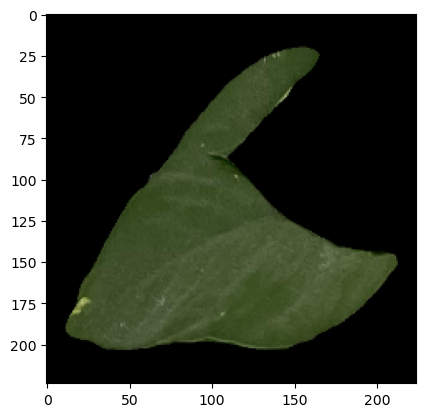

-9.40099811553955 8.26347095426172e-05 True


In [381]:
INDEX = random.sample(list(range(len(patches))), k=1)[0]
patch = patches[INDEX]
patch = cv2.resize(patch, (224, 224))
print(patches[INDEX].shape)
plt.imshow(patch)
plt.show()
result = resnet(tf_test(patch).to(device).unsqueeze(0)).item()
sig = torch.sigmoid(torch.tensor(result)).item()
print(result, sig, sig < 1e-4)

# Isolation forest detection

In [17]:
import torch
from torch.utils.data import DataLoader
from pyod.models.iforest import IForest
import numpy as np

# Initialize and fit the Isolation Forest model
clf = IForest(contamination=0.1)  # Adjust contamination as needed
clf.fit(dataset)

# Get the outlier scores
outlier_scores = clf.decision_function(X)

# Get binary labels (0 for inliers, 1 for outliers)
outlier_labels = clf.predict(X)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3261, 2) + inhomogeneous part.

# Autoencoder leaf-detection

## Training

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [2]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.Tanh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=2),  # 112x112
            act_fn(),
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2),  # 56x56
            act_fn(),
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2),  # 28x28
            act_fn(),
            nn.Conv2d(4*out_channels, 8*out_channels, 3, padding=1, stride=2),  # 14x14
            act_fn(),
            nn.Conv2d(8*out_channels, 16*out_channels, 3, padding=1, stride=2),  # 7x7
            act_fn(),
            nn.Flatten(),
            nn.Linear(16*out_channels*7*7, latent_dim),
            act_fn()
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.Tanh):
        super().__init__()
        self.out_channels = out_channels
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 16*out_channels*7*7),
            act_fn()
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16*out_channels, 8*out_channels, 3, stride=2, padding=1, output_padding=1),  # 14x14
            act_fn(),
            nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, stride=2, padding=1, output_padding=1),  # 28x28
            act_fn(),
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1, output_padding=1),  # 56x56
            act_fn(),
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, stride=2, padding=1, output_padding=1),  # 112x112
            act_fn(),
            nn.ConvTranspose2d(out_channels, in_channels, 3, stride=2, padding=1, output_padding=1),  # 224x224
        )

    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 16*self.out_channels, 7, 7)
        output = self.conv(output)
        return output

#  defining autoencoder
class BigAutoencoder(nn.Module):
    def __init__(self, encoder=Encoder(), decoder=Decoder()):
        super().__init__()
        self.encoder = encoder
#        self.encoder.to(device)

        self.decoder = decoder
#        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

dataset = SingleClassDataset('_data/us_leaf_d', transform=transform, apply_mask=True, crop_to_mask=True, split=.8)
dataset_val = SingleClassDataset('_data/us_leaf_d', transform=transform, apply_mask=True, crop_to_mask=True, split=-.2)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True, num_workers=2, pin_memory=True)
dataloader_val = DataLoader(dataset_val, batch_size=20, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.11191].


torch.Size([224, 224, 3])


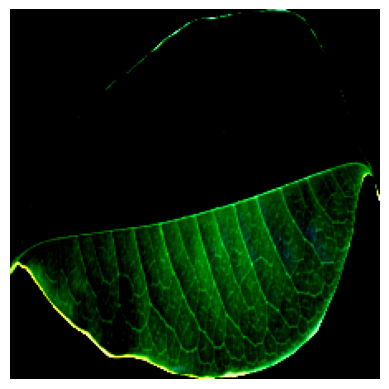

In [21]:
import matplotlib.pyplot as plt
sample, _ = next(iter(dataloader))
sample = torch.permute(sample[0], (1, 2, 0))
print(sample.shape)
plt.imshow(sample)
plt.axis('off')
plt.show()

In [22]:
def masked_mse_loss(output, target):
    mask = target == 0
    output[mask] = 0
    return nn.MSELoss()(output, target)

In [23]:
model = BigAutoencoder()
#model = torch.load("out/autoencoder_latest.pth")
criterion = masked_mse_loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

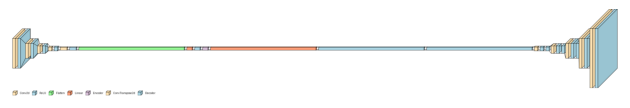

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

import visualtorch
img = visualtorch.layered_view(model.to('cpu'), input_shape=(1, 3, 224, 224), legend=True)

plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

plt.savefig("out/leaf_classifier/autoencoder/structure.png")

In [25]:
model = model.to(device)

In [26]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
              ReLU-2         [-1, 16, 112, 112]               0
            Conv2d-3           [-1, 32, 56, 56]           4,640
              ReLU-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 28, 28]          18,496
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 14, 14]          73,856
              ReLU-8          [-1, 128, 14, 14]               0
            Conv2d-9            [-1, 256, 7, 7]         295,168
             ReLU-10            [-1, 256, 7, 7]               0
          Flatten-11                [-1, 12544]               0
           Linear-12                  [-1, 200]       2,509,000
             ReLU-13                  [-1, 200]               0
          Encoder-14                  [

In [4]:
import pandas as pd
df_training = pd.DataFrame(columns=["loss", "accuracy", "precision", "recall", "f1_score"])

In [28]:
print(df_training.columns)

Index(['loss', 'accuracy', 'precision', 'recall', 'f1_score'], dtype='object')


In [29]:
if os.path.exists("out/leaf_classifier/autoencoder_masked_loss/training_metrics.csv"):
    df_training = pd.read_csv("out/leaf_classifier/autoencoder_masked_loss/training_metrics.csv")
if os.path.exists("out/leaf_classifier/autoencoder_masked_loss/autoencoder_latest.pth"):
    model = torch.load("out/leaf_classifier/autoencoder_masked_loss/autoencoder_latest.pth")

In [30]:
print(df_training.columns)

Index(['loss', 'accuracy', 'precision', 'recall', 'f1_score'], dtype='object')


In [ ]:
import one_class_detection
from tqdm import tqdm

print("Starting Training")
num_epochs = 50
for epoch in range(num_epochs):
    data_iter = iter(dataloader)

    next_batch = next(data_iter) # start loading the first batch
    next_batch = [ _.cuda(non_blocking=True) for _ in next_batch ] 
    # with pin_memory=True and non_blocking=True, this will copy data to GPU non blockingly

    epoch_loss = 0
    epoch_length = 0
    
    p_bar = tqdm(range(len(dataloader)))
    for i in p_bar:
        batch = next_batch 
        if i + 2 != len(dataloader): 
            # start copying data of next batch
            next_batch = next(data_iter)
            next_batch = [ _.cuda(non_blocking=True) for _ in next_batch]

        # training code
        #batch = [data for data, _ in batch]
        
        recon = model(batch[0])
        loss = criterion(recon, batch[0])
        p_bar.set_description(f"Loss: {loss}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += recon.shape[0] * loss.item()
        epoch_length += recon.shape[0]

    epoch_loss = epoch_loss / epoch_length
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.9f}')
    torch.save(model, "out/leaf_classifier/autoencoder_masked_loss/autoencoder_latest.pth")
    
    ae = one_class_detection.Autoencoder(model)
    test_result = ae.test()
    df_training = pd.concat([df_training, 
                             pd.DataFrame([[epoch_loss] + list(test_result.values())], 
                                          columns=df_training.columns)])
    df_training.to_csv("out/leaf_classifier/autoencoder_masked_loss/training_metrics.csv")

Starting Training


Loss: 0.31408923864364624: 100%|██████████| 391/391 [07:44<00:00,  1.19s/it]


Epoch [1/50], Loss: 0.565815694


/tmp/ipykernel_2035924/2517102346.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_training = pd.concat([df_training,
Loss: 0.2947487533092499: 100%|██████████| 391/391 [06:39<00:00,  1.02s/it] 


Epoch [2/50], Loss: 0.258839769


Loss: 0.24153071641921997:  44%|████▍     | 173/391 [03:39<04:21,  1.20s/it]

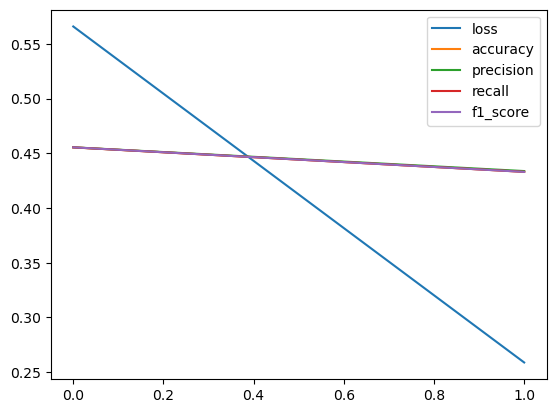

In [5]:
import matplotlib.pyplot as plt
df_training = pd.read_csv("out/leaf_classifier/autoencoder_masked_loss/training_metrics.csv")
df_training = df_training.drop(df_training.columns[0], axis="columns")

for col in df_training.columns:
    plt.plot(df_training.index, df_training[col], label=col)
    
plt.legend()
plt.show()

## Testing the trained model

In [6]:
import one_class_detection
import importlib
importlib.reload(one_class_detection)
ae = one_class_detection.Autoencoder(model)
ae.test()

NameError: name 'model' is not defined

In [35]:
# Function to compute anomaly score
def anomaly_score(img):
    model.eval()
    with torch.no_grad():
        img = img.to(device)  # Move input to GPU
        recon = model(img.unsqueeze(0))
        return nn.MSELoss()(recon, img.unsqueeze(0)).item()

In [36]:
# Example usage
from PIL import Image

test_tensor = transform(Image.fromarray(image)).to(device)  # Move test tensor to GPU
score = anomaly_score(test_tensor)
print(f'Anomaly score: {score}')

Anomaly score: 0.03849826008081436


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030659005..0.80810165].


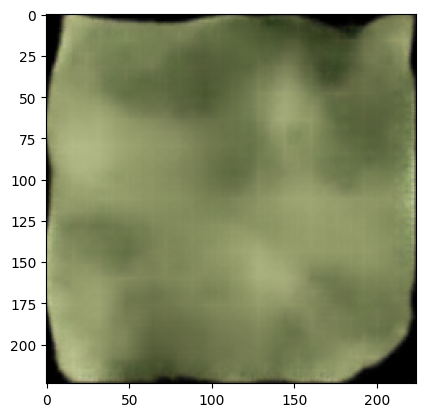

In [37]:
model.eval()
with torch.no_grad():
    recon = model(transform(Image.fromarray(image)).unsqueeze(0).to(device))
    plt.imshow(recon.cpu().numpy().squeeze().transpose((1, 2, 0)))
    plt.show()

## Inference 

In [9]:
#model = torch.load("out/autoencoder_model.pth")
model = torch.load("out/leaf_classifier/autoencoder/autoencoder_latest.pth")
model.to(device)

/tmp/ipykernel_478319/2304852818.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("out/autoencoder_latest.pth")


BigAutoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=12544, out_features=200, bias=True)
      (12): ReLU()
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=200, out_features=12544, bias=True)
      (1): ReLU()
    )
    (conv): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128

In [52]:
model.eval()
patches = get_patches(masks, image, True)
results = []
with torch.no_grad():
    for patch in patches:
        #result = model(transform(Image.fromarray(patch)).unsqueeze(0).to(device))
        results.append(anomaly_score(transform(Image.fromarray(patch))))

In [53]:
print(results)

[0.010771065950393677, 0.01487906463444233, 0.02022959105670452, 0.014664539135992527, 0.018378950655460358, 0.022761110216379166, 0.011428783647716045, 0.04956831783056259, 0.012767584063112736, 0.017550144344568253, 0.0053255874663591385, 0.015174182131886482, 0.006195089779794216, 0.021010883152484894, 0.018161237239837646, 0.003024713834747672, 0.004100357182323933, 0.015490272082388401, 0.008744707331061363, 0.021372539922595024, 0.009000622667372227, 0.007966321893036366, 0.007850716821849346, 0.0029691513627767563, 0.010075528174638748, 0.007056227419525385, 0.010519761592149734, 0.011137392371892929, 0.016243888065218925, 0.008916210383176804, 0.017665209248661995, 0.006666841916739941, 0.006141393445432186, 0.011291373521089554, 0.0056091188453137875, 0.003880304517224431, 0.004439832642674446, 0.016750449314713478, 0.0035008492413908243, 0.006945065688341856, 0.002668553963303566, 0.005450604949146509, 0.02132156863808632, 0.003985960967838764, 0.004843323025852442, 0.0023739

Detected leaf masks: 44


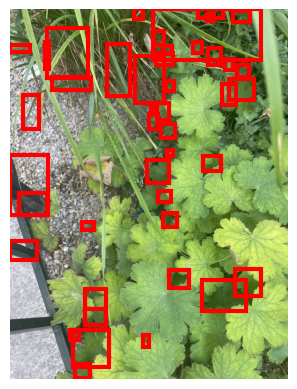

In [54]:
import matplotlib.patches as patches

ANOMALY_THRESHOLD = 0.004
masks_filtered = [mask for mask, result in zip(masks,results) if result < ANOMALY_THRESHOLD]
print("Detected leaf masks:", len(masks_filtered))
fig, ax = plt.subplots()
ax.imshow(image)
show_boxes(ax, [mask["bbox"] for mask in masks_filtered])
plt.axis('off')
plt.show() 

# Comparing Resnet to Autoencoder

In [29]:
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms

In [33]:
resnet = torch.load("out/leaf_classifier/resnet/resnet_latest.pth")
autoencoder = torch.load("out/leaf_classifier/autoencoder/autoencoder_latest.pth")

/tmp/ipykernel_1014013/2006269752.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet = torch.load("out/leaf_classifier/resnet/resnet_latest.pth")
/tmp/ipykernel_1014

In [176]:
patches = get_patches(masks, image)

In [177]:
# Function to compute anomaly score
def anomaly_score(model, img):
    model.eval()
    with torch.no_grad():
        img = img.to(device)  # Move input to GPU
        recon = model(img.unsqueeze(0))
        mse = nn.MSELoss()(recon, img.unsqueeze(0))
        return torch.sigmoid(mse).item()

In [178]:
transform_autoencoder = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [179]:
results_autoencoder = []
with torch.no_grad():
    for patch in patches:
        results_autoencoder.append(anomaly_score(resnet, transform_autoencoder(Image.fromarray(patch))))

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 3, 224, 224])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [180]:
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),  
])

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [181]:
results_resnet = []
with torch.no_grad():
    for patch in patches:
        input = transform_resnet(Image.fromarray(patch)).unsqueeze(0).to(device)
        result = torch.sigmoid(resnet(input)).cpu().item()
        
        results_resnet.append(result)

In [182]:
print(min(results_resnet), max(results_resnet))
print(results_resnet)

8.617632762050681e-19 1.0
[0.9994587302207947, 1.0, 2.4108892375807045e-06, 0.9998961687088013, 0.9109720587730408, 0.0018964532064273953, 0.0004250251513440162, 0.9940158128738403, 8.617632762050681e-19, 0.999998927116394, 0.9977472424507141, 0.9859835505485535, 0.999994158744812, 0.9998687505722046, 0.9999963045120239, 0.012672065757215023, 0.9738150238990784, 0.9939044117927551, 0.8695278167724609, 0.994005024433136, 0.9999995231628418, 1.0, 0.9990550875663757, 0.9973844885826111, 0.9986187219619751, 0.6379684805870056, 1.0, 0.9999998807907104, 0.8413133025169373, 0.9999995231628418, 0.8402429819107056, 0.9999998807907104, 0.033957045525312424, 0.9999998807907104, 0.9995176792144775, 0.9999996423721313, 0.9468242526054382, 0.24809494614601135, 0.7826216816902161, 2.051254721635587e-09, 0.9998517036437988, 0.9999995231628418, 0.9999997615814209, 0.9999994039535522, 0.9984330534934998, 0.6328079104423523, 0.9999998807907104, 0.8132676482200623, 0.9999998807907104, 1.0, 0.9999997615814

In [183]:
print(min(results_autoencoder), max(results_autoencoder))
print(results_autoencoder)

0.5151147246360779 1.0
[1.0, 1.0, 1.0, 1.0, 0.5502293705940247, 0.9987549781799316, 0.8216783404350281, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9760361313819885, 1.0, 1.0, 0.5818299651145935, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997310042381287, 1.0, 1.0, 1.0, 1.0, 0.9999986886978149, 1.0, 0.9998791217803955, 1.0, 0.9999998807907104, 1.0, 1.0, 1.0, 0.5151147246360779, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7142824530601501, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7052209973335266, 0.9999955892562866, 1.0, 1.0, 1.0, 1.0, 0.9867807030677795, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995217323303223, 0.9999986886978149, 1.0, 1.0, 1.0, 1.0, 0.9998210072517395, 1.0, 1.0, 0.9072073698043823, 1.0, 1.0, 1.0, 0.595706045627594, 1.0, 1.0, 1.0, 0.9997034668922424, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6654278039932251, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9803300499916077, 1.0, 1.0, 1.

In [184]:
AUTOENCODER_THRESHOLD = .75
RESNET_THRESHOLD = .01

In [ ]:
masks_autoencoder = [mask for mask, result in zip(masks,results_autoencoder) 
                     if result > AUTOENCODER_THRESHOLD]

masks_resnet = [mask for mask, result in zip(masks,results_resnet) 
                     if result < RESNET_THRESHOLD]
print(f"Detected leaf masks: AE {len(masks_autoencoder)}, RN: {len(masks_resnet)}")

fig, ax = plt.subplots()
ax.imshow(image)
show_boxes(ax, [mask["bbox"] for mask in masks_autoencoder], '#0000ff89')
show_boxes(ax, [mask["bbox"] for mask in masks_resnet], '#ff000089')
plt.axis('off')
plt.show() 

#Detections Resnet: 10
#Detections Autoencoder: 7


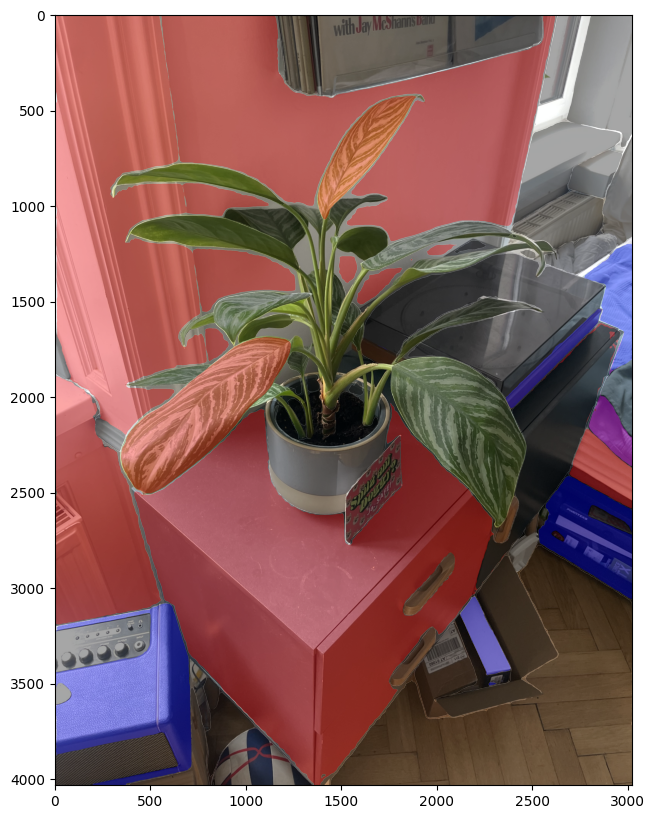

In [187]:
plt.figure(figsize=(10,10))
plt.imshow(image)
ax = plt.gca()
ax.set_autoscale_on(False)

img = np.ones((image.shape[0], image.shape[1], 4))
img[:,:,3] = 0

num_resnet = 0
num_autoencoder = 0

for ann, result_resnet, result_autoencoder in zip(masks, results_resnet, results_autoencoder):
    resnet_part = np.array([1, 0, 0]) if result_resnet < RESNET_THRESHOLD else np.array([0, 0, 0])
    autoencoder_part = np.array([0, 0, 1]) if result_autoencoder < AUTOENCODER_THRESHOLD else np.array([0, 0, 0])
    num_resnet += resnet_part[0]
    num_autoencoder += autoencoder_part[2]
    color = resnet_part + autoencoder_part
    m = ann['segmentation']
    color_mask = np.concatenate([color, [0.35]])
    img[m] = color_mask

print(f"#Detections Resnet: {num_resnet} (RED)")
print(f"#Detections Autoencoder: {num_autoencoder} (BLUE)")
    
ax.imshow(img)
plt.show()

# YOLOv8 prediction

In [15]:
from ultralytics import YOLO, checks
import cv2

In [16]:
checks()

Ultralytics 8.3.17 🚀 Python-3.12.4 torch-2.5.0.dev20240716 CUDA:0 (NVIDIA A100-SXM4-40GB, 40444MiB)
Setup complete ✅ (256 CPUs, 2015.2 GB RAM, 48.5/445.3 GB disk)


In [34]:
patches = get_patches(masks, image)
model = YOLO("out/yolo_urban_street/train/weights/best.pt")
model.info()
results_yolo = []
for patch in patches:
    result = model.predict(patch)
    results_yolo.append(1 if result[0].masks is not None and len(result[0].masks) > 0 else 0)

YOLOv8m-seg summary: 355 layers, 24,605,027 parameters, 0 gradients, 99.2 GFLOPs

0: 640x640 1 leaf, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 leaf, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 leaf, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)

0: 640x544 1 leaf, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x320 1 leaf, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 576x640 1 leaf, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)

0: 640x512 1 leaf, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x224 (no detections), 8.2ms
Speed: 1.6ms preprocess, 8.2ms

Detected leaf masks: 118


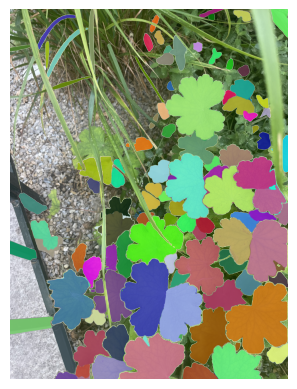

In [32]:
import matplotlib.patches as patches

ANOMALY_THRESHOLD = 0.004
masks_filtered = [mask for mask, result in zip(masks,results_yolo) if result > 0]
print("Detected leaf masks:", len(masks_filtered))
fig, ax = plt.subplots()
ax.imshow(image)
show_anns(masks_filtered, .85)
plt.axis('off')
plt.show() 

# CLIP (HF)

In [2]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

inputs = []
for patch in patches:
    inputs.append(Image.fromarray(patch))


inputs = processor(text=["a photo leaf", "a photo of a non-leaf"], images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


NameError: name 'patches' is not defined